In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, Column

In [2]:
import sncosmo

Importar el mapa de polvo de SFD (Schleger, Finkbeines & Davis 1998), descargado desde este link: https://github.com/kbarbary/sfdmap

In [3]:
import sfdmap
m = sfdmap.SFDMap('/home/francisca/sfddata-master/')

In [4]:
import psycopg2
import requests
from sqlalchemy import create_engine

In [5]:
url = "https://raw.githubusercontent.com/alercebroker/usecases/master/alercereaduser_v3.json"
params = requests.get(url).json()['params']
conn = psycopg2.connect(dbname=params['dbname'], user=params['user'], host=params['host'], password=params['password'])

# Funciones y resumen de los ajustes

En este notebook se verán ajustes con el módulo sncosmo de los modelos SALT2 (en la versión de Betoule et al. 2014) y SALT3 para las detecciones de 84 de las primeras observaciones de SNIa de ZTF confirmadas espectroscópicamente (https://iopscience.iop.org/article/10.3847/1538-4357/ab4cf5/pdf).

A continuación se describen las funciones que se utilizarán, explicando los pasos necesarios para realizar los ajustes, algunas modificaciones realizadas para lograr mejores ajustes, notas sobre lo que he pensado y algunas preguntas de cosas que creo que pueden ayudar a mejorarlos.

In [6]:
def flujo(mag_AB, zp=23.9):
    '''
    Transforma magnitudes AB en flujo, por defecto el flujo se 
    transforma en unidades de microJanskys.
    '''
    flux = 10**((zp - mag_AB)/2.5)
    return flux

Para los ajustes es necesario tener al menos las siguientes columnas en los datos: tiempo, filtro, flujo, error del flujo, zp,
y sistema de magnitudes a la cual permite pasar el zp.
Por lo tanto, como los flujos de ZTF se entregan en magnitudes AB:
- sistema de magnitudes: AB.

- zp: 23.9 (permite pasar de flujo en $\mu J$ $\rightarrow$ magnitudes AB).

- se utilizan los flujos en microJanskys y sus errores calculados a partir de magnitudes AB y sus errores reportados por ZTF, como:
$$flux_{\mu J} = 10^{\frac{23.9 - mag_{AB}}{2.5}}$$
  con $mag_{AB}$ obtenida en la columna "magpsf" de las detecciones, y
$$fluxerr_{\mu J} = flux_{\mu J} \cdot magerror_{AB} \cdot \frac{\ln{10}}{2.5}$$
  con $magerror_{AB}$ obtenido en la columna "sigmapsf" de las detecciones.

In [7]:
def mag_to_flux_fluxerr_flt(table, zp=23.9):
    '''
    A partir de una tabla de astropy con las detecciones se agregan 
    nuevas columnas, necesarias para realizar los ajustes, estas
    son: el flujo; el error del flujo; nombres de filtros (tal como 
    están guardados en sncosmo); el valor del zp que permite pasar 
    de magnitudes a flujo; y el sistema de magnitudes al cual 
    permite pasar el zp.
    
    - el flujo se determina a partir de la función flux a partir 
    del valor de la magnitud AB en la columna "magpsf" de las 
    detecciones.
    
    - el error del flujo se determina a partir del flujo y el error
    de las magnitudes como fluxerror = flux * magerror * ln(10)/2.5,
    donde este último factor sale de la transformación de 
    magnitudes a flujo, y magerr se encuentra en la comlumna 
    "sigmapsf" de las detecciones.
    
    - cambia los filtros para cada detección como fid: 1 -> 'ztfg' 
    y fid: 2 -> 'ztfr' (columna flt).
    
    - especifica el zp que permite pasar de magnitudes AB a flujo.
    
    - especifica que el zp permite pasar al sistema de 
    magnitudes AB (zpsys).
    '''
    nueva_col_flt = []
    nueva_col_f = []
    nueva_col_fe = []
    ab = sncosmo.get_magsystem('ab')
    for i in range(len(table)):
        if table['fid'][i] == 1:
            nueva_col_flt.append('ztfg')
            mag = table['magpsf'][i]
            magerr = table['sigmapsf'][i]
            flux = flujo(mag)
            fluxerr = magerr * flux * (np.log(2.3)/2.5)
            nueva_col_f.append(flux)
            nueva_col_fe.append(fluxerr)

        if table['fid'][i] == 2:
            nueva_col_flt.append('ztfr')
            mag = table['magpsf'][i]
            magerr = table['sigmapsf'][i]
            flux = flujo(mag)
            fluxerr = magerr * flux * (np.log(10)/2.5)
            nueva_col_f.append(flux)
            nueva_col_fe.append(fluxerr)
  
    table['band'] = nueva_col_flt
    table['f'] = nueva_col_f
    table['fe'] = nueva_col_fe
    table['zp'] = zp                                         
    table['zpsys'] = 'ab'     

In [8]:
def astropy_table_detections(df_metadata, df_detections, zp=23.9):
    '''
    A partir de dataframes de los metadata de las SN y de sus
    detecciones construye una lista de tablas de astropy con la
    información de las detecciones de las SN y sus metadata, que 
    es el formato de los datos que necesita sncosmo para hacer 
    los ajustes. Utiliza la función auxiliar 
    "mag_to_flux_fluxerr_flt" para agregar las columnas necesarias.  
    '''
    oids = list(df_metadata.oid)
    table_list = []
    for i in range(len(oids)):
        oid = oids[i]
        detect_i = df_detections[df_detections.oid == str(oid)] 
        table_i = Table.from_pandas(detect_i)
        mag_to_flux_fluxerr_flt(table_i, zp=zp)

        index_i = detect_i.index[0]
        metadata_i = df_metadata[df_metadata.oid == str(oid)]
        
        lista_val_metadata_i = []
        for j in range(len(metadata_i.columns)):
            column_j = metadata_i.columns[j]
            fila_column_j = list(metadata_i[column_j])
            val_column_j = fila_column_j[0]
            lista_val_metadata_i.append(val_column_j)

        table_i.meta = dict(zip(list(metadata_i.columns), 
                                     lista_val_metadata_i))
        table_list.append(table_i)

    return table_list

Para los ajustes:

- Se minimiza de $\chi^{2}$ mediante el minimizador 'minuit'.
- Un número máximo de iteraciones de 10.000.
- Se utilizan las detecciones que cumplen con tener una señal a ruido mayor a 3 (por defecto sncosmo utiliza 5).
- Se usarán los siguientes límites (por defecto) para los parámetros ajustados:
  - $z$: (0.001, 0.6)
  - $x1$: (-4 4)
  - $c$: (-0.4, 0.4)

Donde los límites para los parámetros $x1$ y $c$ son aquellos    utilizados por Scolnic & Kessler 2016 para simular SNIa de distintos surveys con el moldelo SALT2 (en Betoule et al. 2014 se utilizan $x1$:(-3, 3) y $c$:(-0.3, 0.3)).

- Se aplica la extinción de la vía láctea al modelo (afectando el sistema de referencia del observador), utilizando el mapa de polvo SFD (Schleger, Finkbeines & Davis 1998) con el valor de RA y DEC promedio del objeto y la ley de extinción de O'Donnel de 1994 para determinar el enrojecimiento $E(B-V)$, con parámetro $R_{V} = \frac{A_{V}}{E(B-V)} = 3.1$ constante. Estos se fijan al modelo para cada SN.
- Todos estos pueden modificarse. En particular se puede cambiar O'Donnel 1994 por Clayton Cardelli & Mathis 1989 o por Fitzpatrick 1999 (estos vienen implementados en sncosmo pero también se puede cambiar por otro).

Además:

- Se puede incluir la covarianza del modelo (por defecto es falso), si es verdadero itera hasta converger.
- Se pueden descartar rangos de tiempo y de longitud de onda.

Nota:

- En particular, los ajustes funcionan sin límites para $x1$ y $c$, pero no funcionan si no hay límites para $z$ ya que después de cierto valor de $z$ los rangos de longitudes de onda de los filtros de ZTF quedan fuera del rango de longitud de onda del modelo (para ZTF este se determina con la longitud de onda mínima de la banda $g$ y es $z=0.82$, más detalles en el notebook "SALT2 y SALT3"). Con esto, los ajustes pueden realizarse solo con una banda, lo cual no permite determinar bien $c$, y por lo tanto los ajustes no son buenos. 


- Debido a lo conversado en la práctica acerca de que lo más probable es que ZTF no pueda tener observaciones por sobre $z=0.6$ decidí usar este valor como límite superior para los ajustes.


In [9]:
def ajuste(oid, modelo, df_metadata, astropy_table, version=None, 
           z_real=False, graficos=True, zp=23.9, minsnr=3.0, 
           z_bounds = (0.001, 0.6), x1_bounds = (-4, 4),
           c_bounds = (-0.4, 0.4), effects='OD94', 
           effect_names='mw', effect_frames='obs'):
    '''
    Ajusta el modelo especificado a las observaciones del oid 
    indicado para observaciones que cumplen con tener una cierta
    señal a ruido. Incluye límites para los valores que pueden 
    tomar los parámetros ajustados y efectos que se le incluyen 
    al modelo. Como resultado entrega una lista con el nombre 
    del objeto ajustado, el modelo que mejor se ajusta y los 
    resultados del ajuste. Por defecto se grafica el ajuste 
    realizado. 
    
    
    Input:
    =================
    oid: [str], identificador del objeto.
    
    modelo: [str], nombre del modelo.
    
    df_metadata: [pd.DataFrame], DataFrame que incluye metadata 
                del objeto.
                
    astropy_table: [astropy.Table], tabla que contiene las 
                detecciones del objeto.
                
    version: [str], versión del modelo.
    
    z_real: [bool], incluir el redshift real en el ajuste.
    
    graficos: [bool], graficar el ajuste y los datos.
    
    zp: [float], zeropoint para pasar de flujo a magnitudes.
    
    minsnr: [float], mínima señal a ruido de los datos para 
           realizar el ajuste con ellos, en la función de ajuste
           de sncosmo este valor es 5.0 por defecto.
           
    z_bounds: [2-tuple of floats], límites para el redshift 
               ajustado.
               
    x1_bounds: [2-tuple of floats], límites para el parámetro x1 
               ajustado.
               
    c_bounds: [2-tuple of floats], límites para el parámetro c 
               ajustado.
               
    effects: [str or list of str], efectos que se incluyen en el 
            modelo. Por defecto en este ajuste se utiliza el mapa 
            de polvo de SFD (usando los valores de ra y dec 
            promedio del objeto) para la extinción de O'Donnel de 
            1994 ('OD94') para determinar el enrojecimiento E(B-V) 
            con parámetro R_V = A_V/E(B-V) = 3.1 constante.
            
    effect_names: [str or list of str], prefijo que se le añade
                 a los parámetros del efecto. Por defecto en el
                 ajuste solo se incluye la extinción de la vía
                 láctea ('mw')
                 
    effect_frames: [str or list of str], sistemas de referncia
                  a los cuales afecta el efecto que se le agrega
                  al modelo
    
    Output:
    =================
    
    entrega una lista con 3 elementos:
    1.- nombre del objeto ajustado
    2.- modelo ajustado
    3.- resultados del ajuste
    
    Por defecto grafica el ajuste.
    
    '''
    df_metadata = df_metadata.reset_index()    
    
    index = df_metadata[df_metadata["oid"] == str(oid)].index[0]
    table = astropy_table[index]
    if version is not None:
        source = sncosmo.get_source(modelo, version=version)

    else:
        source = sncosmo.get_source(modelo)

    #modelo
    if effects == None:
        model = sncosmo.Model(source=source)
        
    elif effects == 'OD94':
        dust = sncosmo.OD94Dust()
    elif effects == 'CCM89':
        dust = sncosmo.CCMDust()
    elif effects == 'F99':
        dust = sncosmo.F99Dust()
    
    if effect_names == 'mw':
        if effect_frames == 'obs':
            model = sncosmo.Model(source=source, effects=[dust], 
                                  effect_names=['mw'], 
                                  effect_frames=['obs'])
            meanra = table.meta['meanra']
            meandec = table.meta['meandec']
            
            rv = 3.1
            ebv = m.ebv(meanra, meandec)
            model.set(mwebv=ebv, mwr_v=rv)
    #if effect_names == 'host':
        #if effect_frames == 'rest':
            #model = sncosmo.Model(source=source, effects=[dust], effect_names=[effect_names], effect_frames=[effect_frames])
    
    if not z_real:
        bounds = {'z':z_bounds, 'x1':x1_bounds, 'c':c_bounds}
        result, fitted_model = sncosmo.fit_lc(table, model, 
                                              ['z', 't0', 'x0', 
                                               'x1', 'c'], # parametros a variar  
                                              bounds=bounds, 
                                              minsnr=minsnr) # elegir buenos bounds, eso demora el número de ajustes
        
        if graficos:
            sncosmo.plot_lc(table, model=fitted_model, 
                            errors=result.errors, 
                            figtext= oid+' z ajustado '+modelo, 
                            zp=zp)
            print(" ==== Con ajuste del redshift ====")
        
    if z_real:
        z = table.meta['z']
        model.set(z=z)
        result, fitted_model = sncosmo.fit_lc(table, 
                                              model,
                                              ['t0', 'x0', 
                                               'x1', 'c'])
        if graficos:
            sncosmo.plot_lc(table, model=fitted_model, 
                            errors=result.errors,
                            figtext= oid+' z real '+modelo, 
                            zp=zp, minsnr=minsnr)
            print(" ===== Ajuste con redshift real ====")
    
    return [oid, fitted_model, result] 


In [10]:
def modelo_ajustado_y_resultados(modelo, df_metadata, 
                                 df_detections, version=None, 
                                 z_real=False, zp=23.9, minsnr=3.0,
                                 z_bounds = (0.001, 0.6), 
                                 x1_bounds = (-4, 4), 
                                 c_bounds = (-0.4, 0.4),
                                 effects='OD94', effect_names='mw',
                                 effect_frames='obs', 
                                 print_ind_and_oid=False):
    
    '''
    Ajusta los objetos cuyos nombres y metadata están en un 
    DataFrame (df_metadata) y cuyas detecciones están en otro
    DataFrame (df_detections). Utiliza las funciones auxiliares
    "astropy_table_detections" para pasar las detecciones al 
    formato requerido; y "ajuste" para realizar el ajuste de cada 
    objeto (pero sin graficar los ajustes).
    
    Entrega una lista de los resultados de la función "ajuste" 
    de cada objeto, y, para poder encontrar objetos que no se 
    pudieron ajustar (en los cuales la función sncosmo.fit_lc 
    se cae) si se indica entre los parámetros 
    "print_ind_and_oid=True" imprime el valor del indice en los
    metadata y el nombre de las SN que se han podido ajustar (antes
    de que se caiga la función).
    
    '''
    
    
    df_metadata = df_metadata.reset_index()
    df_detections = df_detections.reset_index()
    
    astropy_table = astropy_table_detections(df_metadata, 
                                             df_detections, zp=zp)
    lista_ajustes = []
    oids = list(df_metadata.oid)
    for i in range(len(astropy_table)):
        oid = oids[i]
        modelo_ajustado_y_resultados_i = ajuste(oid, modelo, 
                                                df_metadata, 
                                                astropy_table, 
                                                version=version,
                                                z_real=z_real,
                                                graficos=False,
                                                zp=zp, 
                                                minsnr=minsnr, 
                                                z_bounds=z_bounds, 
                                                effects=effects, 
                                                effect_names=effect_names, 
                                                effect_frames=effect_frames)

        lista_ajustes.append(modelo_ajustado_y_resultados_i)
        if print_ind_and_oid:
            print(i, oid)
    return lista_ajustes

El objeto "result" de un ajuste (primer componente del resultado de la función sncosmo.fit_lc) es un diccionario con los siguientes parámetros:
- success: describe si el ajuste resultó.
- message: incluye mensajes adicionales de la salida.
- ncall: número de evaluaciones.
- chisq: mínimo valor de $\chi^{2}$.
- ndof: grados de libertad.
- param_names: nombre de los parámetros. 
- parameters: mejor ajuste de los parámetros.
- vparam_names: nombre de los parámetros que se variaron.
- covariance: arreglo 2-d de la covarianza de los parámetros (ordenados según vparam_names).
- errors: incerteza de los parámetros variados.
- nfit: número de veces que se realizó el ajuste, a menos de que se entregue el valor de la matriz de covarianza (donde itera hasta converger), su valor será siempre 1.
- data_mask: arreglo booleano que indica cuáles observaciones se utilizaron en el ajuste.

In [11]:
def estadisticas_resultados(ajustes, z_real=False):
    '''
    A partir de una lista de ajustes generada con la función
    "modelo_ajustado_y_resultados" entrega un DataFrame (sin 
    valores Nan) con los resultados del ajuste, que contiene:
    - el oid del objeto
    - ncall, chisq, ndof y el valor de chisq/ndof del mejor ajuste
    - los parámetros del mejor ajuste y los errores de los 
    parámetros ajustados (no se incluye la matriz de covarianza).
    
    Input:
    =================
    ajustes: [list], lista de ajustes del resultado de la función
            "modelo_ajustado_y_resultados".
    z_real: [bool], indica si en el ajuste se utilizó el redshift
            real de las SN.
    
    Output:
    =================
    df_resultados: [pd.DataFrame], DataFrame que en cada fila
                  contiene el oid, los resultados y mejores 
                  parámetros del ajuste de un cierto objeto.
                  Se eliminan aquellos que tienen valores Nan
                  en alguna de sus columnas
    '''
    oids = []
    ncall = []
    chisq = []
    ndof = [] # grados de libertad
    # nfit es siempre 1 ya que no se entrega el valor de la matriz
    #de covarianza, por lo que no se incluye en el df.
    z = []
    t0 = []
    x0 = []
    x1 = []
    c = []
    mwebv = []
    # mwr_v está fijo en 3.1
    # cov
    t0_err = []
    x0_err = []
    x1_err = []
    c_err = []

    for i in range(len(ajustes)):
        # oid 
        oid_i = ajustes[i][0]
        oids.append(oid_i)
        
        # estadísticas del ajuste
        ncall_i = ajustes[i][2]['ncall']
        ncall.append(ncall_i)
    
        chisq_i = ajustes[i][2]['chisq']
        chisq.append(chisq_i)
    
        ndof_i = ajustes[i][2]['ndof']
        ndof.append(ndof_i)

        z_i = ajustes[i][2]['parameters'][0]
        z.append(z_i)
    
        t0_i = ajustes[i][2]['parameters'][1]
        t0.append(t0_i)
    
        x0_i = ajustes[i][2]['parameters'][2]
        x0.append(x0_i)
    
        x1_i = ajustes[i][2]['parameters'][3]
        x1.append(x1_i)
    
        c_i = ajustes[i][2]['parameters'][4]
        c.append(c_i)
    
        mwebv_i = ajustes[i][2]['parameters'][5]
        mwebv.append(mwebv_i)
    
        # errores de los parámetros ajustados
        t0_err_i = ajustes[i][2]['errors']['t0']
        t0_err.append(t0_err_i)
    
        x0_err_i = ajustes[i][2]['errors']['x0']
        x0_err.append(x0_err_i)
    
        x1_err_i = ajustes[i][2]['errors']['x1']
        x1_err.append(x1_err_i)
    
        c_err_i = ajustes[i][2]['errors']['c']
        c_err.append(c_err_i)

    chisq_part_ndof = list(np.array(chisq)/np.array(ndof))
    
    if not z_real:
        # si no se utiliza el valor del redshift real de la SN
        # entonces este se ajusta, con lo que dentro del 
        # diccionario "errors" del resultado, se encuentra el
        # error del ajuste de z.
        z_err = []
        for i in range(len(ajustes)):
            z_err_i = ajustes[i][2]['errors']['z']
            z_err.append(z_err_i)
            
        data = {'oid': oids, 'ncall': ncall, 'chisq': chisq, 
                'ndof': ndof, 'chisq/ndof': chisq_part_ndof, 
                'z': z, 'z_err': z_err, 't0': t0, 't0_err': t0_err,
                'x0': x0, 'x0_err': x0_err, 'x1': x1, 
                'x1_err': x1_err, 'c': c, 'c_err': c_err, 
                'mwebv': mwebv}
    else:
        # si se utiliza el error del redshift real no hay error
        # en el ajuste de z, ya que este es un parámetro fijo
        data = {'oid': oids, 'ncall': ncall, 'chisq': chisq, 
                'ndof': ndof, 'chisq/ndof': chisq_part_ndof, 
                'z': z, 't0': t0, 't0_err': t0_err, 'x0': x0, 
                'x0_err': x0_err, 'x1': x1, 'x1_err': x1_err, 
                'c': c, 'c_err': c_err, 'mwebv': mwebv}  
        
    df_resultados = pd.DataFrame(data=data)
    
    # eliminar filas que tienen valores Nan
    return df_resultados.dropna()

In [12]:
def histogramas_estadisticas_resultados(ajustes, z_real=False, 
                                        n_bins=50, color='tab:blue',
                                        alpha=1):
    '''
    A partir de una lista de ajustes generada con la función
    "modelo_ajustado_y_resultados" utiliza la función 
    "estadisticas_resultados" y crea histogramas para todas sus
    columnas (salvo la columna "oid"), imprimiendo el valor de su 
    rango, promedio, desviación estándar y mediana.
    
    Input:
    =================
    ajustes: [list], lista de ajustes del resultado de la función
            "modelo_ajustado_y_resultados".
            
    z_real: [bool], indica si en el ajuste se utilizó el redshift
            real de las SN.
            
    n_bins: [int], número de bins.
    
    color: [str], color del histograma.
    
    alpha: [float], transparencia del color.
    
    '''
    df = estadisticas_resultados(ajustes, z_real=z_real)
    
    for i in range(1, len(df.columns)):
        columna_i = df.columns[i]
        lista_i = df[columna_i]
        arreglo_i = np.array(lista_i)
        prom_i = np.mean(arreglo_i)
        std_i = np.std(arreglo_i)
        min_i = np.min(arreglo_i)
        max_i = np.max(arreglo_i)
        med_i = np.median(arreglo_i)
        
        # imprimir distribución de valores de la columna
        print('rango {} : {}, {}'.format(columna_i, min_i, max_i))
        print('promedio {} : {}'.format(columna_i, prom_i))
        print('desviación estándar {} : {}'.format(columna_i, 
                                                   std_i))
        print('mediana {} : {}'.format(columna_i, med_i))
        
        # construcción de un histograma 
        plt.figure(i, figsize=(6, 4))
        plt.hist(arreglo_i, bins= n_bins, color=color, alpha=alpha)[0]
        plt.title(columna_i , fontsize=14)
        plt.tick_params(labelsize=14)
        plt.show()

Como se verá más adelante, un problema en el ajuste consiste en que los modelos SALT2 y SALT3 están definidos en un rango de tiempo con respecto al máximo de -20, 50 en el sistema de referencia en reposo, por lo que observaciones que se encuentran fuera de este rango aumentan mucho el valor de $\frac{\chi^{2}}{ndof}$ pese a que el ajuste se vea bien. 

Por la relación:
$$ z + 1 = \frac{\lambda_{obs}}{\lambda_{rest}}= \dfrac{\frac{c}{t_{obs}}}{\frac{c}{t_{rest}}}$$
con lo que 
$$ z + 1 = \frac{t_{rest}}{t_{obs}}$$

y así el rango de tiempo en $t_{obs}$ será: $-20 \cdot (1 + z)$, $50 \cdot (1 + z)$.

Por lo que una idea es determinar el tiempo del máximo ($t0$) y el redshift ($z$) en un primer ajuste y con estos hacer un segundo ajuste del modelo solo con las observaciones que se encuentren en el rango del modelo determinado con $t0$ y $z$.

Nota:
- Es importante notar que en el caso en que la selección de las observaciones que pertenecen al rango de tiempo del modelo se hace con el valor del redshift real ($z_{real}$) y los primeros ajustes realizados con este, se podría analizar qué pasaría si el ajuste determina el redshift real del modelo. Además asumiendo que en el primer ajuste se determina el valor del tiempo del máximo ($t_0$) de forma correcta o cercana a su valor real, se podría analizar qué pasaría en un "ajuste perfecto" en que se utilizan todos las observaciones que efectivamente pertenecen al rango de tiempo del modelo, y se ajustan solo los parámetros del modelo ($x_0$, $x1$, $c$) y el tiempo del máximo brillo ($t_0$). 

Pregunta:
- ¿Cómo se podrían incluir los errores del tiempo del máximo y del redshift determinados del primer ajuste en la determinación de este rango?

In [13]:
# tiempos máximos y mínimos en el sistema de referencia en reposo
# para los modelos SALT2 y SALT3
trest_min_modelo = -20 
trest_max_modelo = 50

def cortes_t_modelo(t_min, t_max, df_detect, df_results):
    '''
    A partir del tiempo máximo y mínimo del modelo en el 
    sistema de referencia en reposo, y los valores del tiempo
    del máximo (t0) y el redshift (z) determinados a partir
    de un primer ajuste, crea un nuevo DataFrame de las 
    detecciones de los objetos, que contiene solo las 
    observaciones que están dentro del rango de tiempo del modelo
    
    Input:
    ==============
    t_min: [float], tiempo mínimo del modelo con respecto al
           tiempo del máximo brillo, en el sistema de referencia
           en reposo
           
    t_max: [float], tiempo máximo del modelo con respecto al
           tiempo del máximo brillo, en el sistema de referencia
           en reposo
           
    df_detect: [pd.DataFrame], DataFrame que contiene las 
              detecciones de los objetos que se ajustaron en el
              primer ajuste
              
    df_results: [pd.DataFrame], DataFrame con los resultados del
               primer ajuste, obtenidos con la función 
               "estadisticas_resultados".
    
    
    Output:
    =============
    df_detect_cortes_t: [pd.DataFrame], DataFrame que contiene
                       las observaciones de los objetos dentro 
                       del rango de tiempo del modelo, determinado
                       a partir de los valores del tiempo del
                       máximo y redshift de un primer ajuste con 
                       el modelo.
    '''
    # lista de los oids que se ajustaron en el primer ajuste
    oids = list(df_results['oid'])
    
    # lista en la cual se guardarán las observaciones que están
    # en el rango de tiempo del modelo
    lista_df_detect_cortes_t = []
    
    # iterar para cada oid, guardando las observaciones que cumplen
    # lo anterior en la lista
    for i in range(len(oids)):
        oid_i = oids[i]
        # detecciones de cada oid
        detect_oid_i = df_detect[df_detect['oid'] == oid_i]
        ajustes_oid_i = df_results[df_results['oid'] == oid_i]
        
        # redshift ajustado
        z_i = list(ajustes_oid_i['z'])[0]
        
        # tiempo del máximo ajustado
        t0_i = list(ajustes_oid_i['t0'])[0]
        
        # cortes en tmax y tmin en el sistema de referencia del
        # observador, con tobs = trest*(1+z)
        corte_t_max = t0_i + t_max*(1 + z_i)
        corte_t_min = t0_i + t_min*(1 + z_i)
        
        # observaciones del oid en tiempos menores al máximo
        mask_t_max = detect_oid_i['mjd'] < corte_t_max
        df_detect_i_corte_t_max = detect_oid_i[mask_t_max]
        
        # observaciones del oid en el rango
        mask_rango_t = df_detect_i_corte_t_max['mjd'] > corte_t_min
        df_detect_i_cortes_t = df_detect_i_corte_t_max[mask_rango_t]
        
        # guardar las observaciones del oid que están en el rango
        # en una lista
        lista_df_detect_cortes_t.append(df_detect_i_cortes_t)
        
    # concatenar las observaciones de todos los oids que están
    # dentro del rango del modelo en un único DataFrame
    df_detect_cortes_t = pd.concat(lista_df_detect_cortes_t)
    
    return df_detect_cortes_t

Sin embargo, un problema de utilizar lo anterior es que se asume que tanto la fecha del máximo ajustada ($t_0$) como el redshift ($z$) se asume que son correctos, lo cual no siempre es cierto. En particular se verá que lo anterior hace que el valor de $\frac{\chi^{2}}{ndof}$ disminuya, pero sigue siendo alto, además aún se ven puntos que están fuera del rango del modelo, lo que puede pasar si el redshift del segundo ajuste es menor que el determinado en el primer ajuste. Algunas opciones para enfrentar lo anterior serían:
- Asumiendo que el valor del tiempo del máximo ajustado en el primer ajuste ($t_0$) es correcto, o cercano al valor correcto, descartar las observaciones fuera del rango del modelo en el sistema de referencia en reposo (en el cual $z=0$).

- Estimar de otra manera (más exacta) el tiempo del máximo y hacer lo mismo de la opción anterior con este tiempo del máximo.

- Determinar un rango de posibles valores de redshift de la SN a partir del valor de la magnitud aparente en el máximo, para que así el ajuste se demore menos y tome valores más probables (se verá que esto pasa más adelante usando límites para el valor del redshift).

Nota: 
- También se mostrará lo que pasa al eliminar puntos que pertenecen al rango de tiempo del modelo al analizar lo que pasa al hacer este corte en las detecciones para los ajustes que utilizan el redshift real, y así compararlo con el caso de un "ajuste perfecto" en que todos las observaciones seleccionadas para el ajuste pertenecen al rango de tiempo del modelo.

Preguntas:
- ¿Es posible determinar de forma más exacta el tiempo del máximo?

- ¿Sería posible determinar un rango de valores entre los cuales se puede encontrar el redshift de la SN?

Pendiente:
- Ver si se podría determinar un rango más pequeño para el parámetro $x1$ de SALT2/SALT3

- Revisar SALT2/SALT3 para ver si se puede usar el valor de g-r en el máximo como estimación del parámetro $c$ o de un rango para $c$.

In [14]:
def cortes_trest_modelo(t_min, t_max, df_detect, df_results):
    '''
    A partir del tiempo máximo y mínimo del modelo en el 
    sistema de referencia en reposo, y el valor del tiempo
    del máximo (t0) determinado a partir de un primer ajuste, 
    crea un nuevo DataFrame de las detecciones de los objetos, 
    que contiene solo las observaciones que están dentro del rango
    de tiempo del modelo, considerando que está en el sistema de
    referencia en reposo (z=0).
    
    Input:
    ==============
    t_min: [float], tiempo mínimo del modelo con respecto al
           tiempo del máximo brillo, en el sistema de referencia
           en reposo
           
    t_max: [float], tiempo máximo del modelo con respecto al
           tiempo del máximo brillo, en el sistema de referencia
           en reposo
           
    df_detect: [pd.DataFrame], DataFrame que contiene las 
              detecciones de los objetos que se ajustaron en el
              primer ajuste
              
    df_results: [pd.DataFrame], DataFrame con los resultados del
               primer ajuste, obtenidos con la función 
               "estadisticas_resultados".
    
    
    Output:
    =============
    df_detect_cortes_t: [pd.DataFrame], DataFrame que contiene
                       las observaciones de los objetos dentro 
                       del rango de tiempo del modelo, como si
                       el objeto estuviese en el sistema de
                       referencia en reposo, determinado a partir 
                       del valor del tiempo del máximo determinado
                       de un primer ajuste con el modelo.
    '''
    # lista de los oids que se ajustaron en el primer ajuste
    oids = list(df_results['oid'])
    
    # lista en la cual se guardarán las observaciones que están
    # en el rango de tiempo del modelo, considerando que el 
    # objeto está en el sistema de referencia en reposo
    lista_df_detect_cortes_trest = []
    
    # iterar para cada oid, guardando las observaciones que cumplen
    # lo anterior en la lista
    for i in range(len(oids)):
        oid_i = oids[i]
        # detecciones de cada oid
        detect_oid_i = df_detect[df_detect['oid'] == oid_i]
        ajustes_oid_i = df_results[df_results['oid'] == oid_i]
        
        # tiempo del máximo ajustado
        t0_i = list(ajustes_oid_i['t0'])[0]
        
        # cortes en tmax y tmin
        corte_trest_max = t0_i + t_max
        corte_trest_min = t0_i + t_min
        
        # observaciones del oid en tiempos menores al máximo
        mask_trest_max = detect_oid_i['mjd'] < corte_trest_max
        df_detect_i_corte_trest_max = detect_oid_i[mask_trest_max]
        
        # observaciones del oid en el rango
        mask = df_detect_i_corte_trest_max['mjd'] > corte_trest_min
        df_detect_i_cortes_trest = df_detect_i_corte_trest_max[mask]
        
        # guardar las observaciones del oid que están en el rango
        # en una lista
        lista_df_detect_cortes_trest.append(df_detect_i_cortes_trest)
    
    # concatenar las observaciones de todos los oids que están
    # dentro del rango del modelo en un único DataFrame
    df_detect_cortes_trest = pd.concat(lista_df_detect_cortes_trest)
    
    return df_detect_cortes_trest

Comentarios:

- Para lograr mejores ajustes es necesario eliminar las observaciones que están fuera del rango de tiempo del modelo, el cual es entre -20 y 50 días con respecto al máximo en el sistema de referencia en reposo. Al menos gráficamente los problemas asociados a esto se deben a observaciones después del límite superior, por lo que creo que esto no sería problema si se quiere implementar en vivo.


- Se ve que puede que entre los datos hayan outliers (hay valores que se escapan mucho del modelo (poner ejemplos), los cuales aumentan el valor de $\frac{\chi^{2}}{ndof}$.


- Hay veces que ajustes que a simple vista se ven bien tienen valores de $\frac{\chi^{2}}{ndof}$ grandes.


- Los mejores ajustes (en los cuales se ajusta el redshift) ocurren cuando se utiliza un límite más estricto para el redshift. Por lo anterior, si existe alguna manera externa de determinar un rango de valores posibles para el redshift (por ejemplo utilizando el valor de la máxima magnitud aparente de la SN), esto ayudaría a lograr ajustes mejores y más rápidos.


- En los modelos SALT2 y SALT3 a veces se ve que algunos días antes del máximo el modelo toma valores negativos para el flujo, esto podría ser un problema en el caso en que el modelo ajustado tenga esa forma y existan detecciones en esos días, ya que aumentaría de forma no realista el valor de $\frac{\chi^{2}}{ndof}$ (aunque en verdad quizás esto se corrige cuando hay detecciones en ese rango de tiempo). 


Pendiente:

- Hacer ajustes del modelo SALT2 y SALT3 a observaciones de las clases con las que más se confunden las SNIa.

Preguntas:

- ¿Cuál sería un buen criterio para eliminar los outliers?
- ¿Cómo se podría determinar un rango de valores posibles para el redshift?
- ¿Qué piensa acerca de hacer un query de todas las SNIa confirmadas espectroscópicamente hasta la fecha y determinar con estas la distribución de los parámetros $x1$ y $c$ de las SNIa de ZTF?¿Podrían haber valores que se salgan del rango determinado con las espectroscópicas debido a que estas en general son más cercanas y no necesariamente más luminosas?

# Primeras SNIa confirmadas espectroscópicamente de ZTF

## Obtener metadata y detecciones, y agregar el redshift espectroscópico en metadata

Lista de 121 SNIa confirmadas espectroscópicamente de ZTF (https://iopscience.iop.org/article/10.3847/1538-4357/ab4cf5/pdf)
su rango de redshift es $0.0181 \leq z \leq 0.141$.

In [15]:
early_obs =  ('ZTF18aasdted', 'ZTF18abgmcmv', 'ZTF18abauprj', 
              'ZTF18aaxcntm', 'ZTF18abcflnz', 'ZTF18abcrxoj', 
              'ZTF18abuqugw', 'ZTF18aaxsioa', 'ZTF18abkhcwl', 
              'ZTF18abfhryc', 'ZTF18aaxdrjn', 'ZTF18aaumeys', 
              'ZTF18abkhcrj', 'ZTF18abeecwe', 'ZTF18aawjywv', 
              'ZTF18abpaywm', 'ZTF18aayjvve', 'ZTF18aazsabq', 
              'ZTF18aaslhxt', 'ZTF18abbvsiv', 'ZTF18aawurud',
              'ZTF18abwdcdv', 'ZTF18abucvbf', 'ZTF18aapqwyv', 
              'ZTF18abjvhec', 'ZTF18aazixbw', 'ZTF18aansqun', 
              'ZTF18abcsgvj', 'ZTF18abrzeym', 'ZTF18abdbuty', 
              'ZTF18aaqcugm', 'ZTF18absdgon', 'ZTF18aavrwhu', 
              'ZTF18abckujq', 'ZTF18aaqffyp', 'ZTF18abxxssh', 
              'ZTF18sbsxlpi', 'ZTF18abwmuua', 'ZTF18abetehf', 
              'ZTF18abssuxz', 'ZTF18abmmkaz', 'ZTF18aazblzy',
              'ZTF18abnvoel', 'ZTF18abealop', 'ZTF18abbpeqo', 
              'ZTF18abcysdx', 'ZTF18aaqnrum', 'ZTF18abfgygp', 
              'ZTF18abdefet', 'ZTF18abdfwur', 'ZTF18aavrzxp', 
              'ZTF18abeegsl', 'ZTF18abmxdhb', 'ZTF18aazabmh', 
              'ZTF18aaunfqq', 'ZTF18aaqcqvr', 'ZTF18aapsedq', 
              'ZTF18abpamut', 'ZTF18aazjztm', 'ZTF18aaqcozd', 
              'ZTF18abckujg', 'ZTF18aatzygk', 'ZTF18abjtgdo', 
              'ZTF18abetewu', 'ZTF18aaytovs', 'ZTF18abjstcm', 
              'ZTF18abokpvh', 'ZTF18abpmmpo', 'ZTF18aailmnv', 
              'ZTF18abdkimx', 'ZTF18aaqqoqs', 'ZTF18aaxwjmp', 
              'ZTF18aaydmkh', 'ZTF18abcecfi', 'ZTF18abxygvv', 
              'ZTF18abdfydj', 'ZTF18abdfazk', 'ZTF18abdmgab', 
              'ZTF18aauhxce', 'ZTF18abqjvyl', 'ZTF18abimsyv', 
              'ZTF18aazcoob', 'ZTF18aasesgl', 'ZTF18abpttky',
              'ZTF18aaumlfl', 'ZTF18abkifng', 'ZTF18abtnlik', 
              'ZTF18abfhaji', 'ZTF18abfzkno', 'ZTF18aaxvpsw', 
              'ZTF18abkdujo', 'ZTF18abkigee', 'ZTF18aaoxryq', 
              'ZTF18abclalx', 'ZTF18abwnsoc', 'ZTF18abssdpi', 
              'ZTF18aauocnw', 'ZTF18aaxqyki', 'ZTF18abukmty', 
              'ZTF18abwtops', 'ZTF18abfwuwn', 'ZTF18abkhdxe', 
              'ZTF18abtogdl', 'ZTF18abgxvra', 'ZTF18abjtger',
              'ZTF18aarldnh', 'ZTF18aaxrvzj', 'ZTF18aboaeqy', 
              'ZTF18aarqnje', 'ZTF18aaqcqkv', 'ZTF18abptsco', 
              'ZTF18abrzrnb', 'ZTF18aaxakhh', 'ZTF18abixjey', 
              'ZTF18abslxhz', 'ZTF18abvbayb', 'ZTF18abqbavl', 
              'ZTF18abtcdfv', 'ZTF18abjdjge', 'ZTF18abatffv', 
              'ZTF18abklljv')

lista_early_obs = list(early_obs)
array_early_obs = np.array(lista_early_obs)

Redshift de las 121 SNIa confirmadas espectroscópicamente de ZTF

In [16]:
early_red = [0.0181, 0.0185, 0.0242, 0.0269, 0.0273, 0.0309, 
             0.0313, 0.0315, 0.0317, 0.0323, 0.034, 0.0365, 0.0383,
             0.0393, 0.04, 0.045, 0.0474, 0.05, 0.0509, 0.051, 
             0.0531, 0.0538, 0.0549, 0.056, 0.057, 0.0594, 0.0597, 
             0.06, 0.06, 0.06, 0.0619, 0.062, 0.062, 0.0638, 0.064,
             0.064, 0.0642, 0.0643, 0.0649, 0.0649, 0.065, 0.0653, 
             0.065, 0.0666, 0.0667, 0.067, 0.069, 0.07, 0.07, 0.07,
             0.07, 0.07, 0.07, 0.07, 0.0711, 0.0716, 0.072, 0.072,
             0.0721, 0.0732, 0.074, 0.074, 0.0741, 0.074, 0.0746,
             0.079, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08,
             0.08, 0.08, 0.08, 0.0803, 0.0831, 0.0835, 0.084, 
             0.0845, 0.0859, 0.086, 0.0874, 0.088, 0.09, 0.09, 0.09,
             0.0916, 0.0921, 0.0936, 0.094, 0.1, 0.1, 0.1, 0.1, 0.1003,
             0.102, 0.104, 0.105, 0.105, 0.105, 0.106, 0.106, 0.1077, 
             0.110, 0.115, 0.115, 0.1174, 0.12, 0.12, 0.12, 0.1218, 
             0.13, 0.13, 0.1392, 0.14, 0.14, 0.14, 0.141]

lista_early_red = list(early_red)
array_early_red = np.array(lista_early_red)

Metadata de 121 SNIa confirmadas espectroscópicamente (incluyendo la clase con la que se clasificó en ALeRCE)

In [17]:
query_meta_early_SNIa = ''' 
         SELECT
           object.oid, object.meanra, object.meandec, object.ndet,
           object.firstMJD, object.deltajd, object.g_r_max,
           probability.classifier_name, probability.class_name,
           probability.ranking, probability.probability
         FROM
           object INNER JOIN probability
           ON object.oid=probability.oid
         WHERE 
          probability.classifier_name='lc_classifier'
          AND probability.ranking = 1
          AND object.oid IN ('ZTF18aasdted', 'ZTF18abgmcmv', 'ZTF18abauprj', 'ZTF18aaxcntm', 'ZTF18abcflnz', 'ZTF18abcrxoj', 'ZTF18abuqugw',
              'ZTF18aaxsioa', 'ZTF18abkhcwl', 'ZTF18abfhryc', 'ZTF18aaxdrjn', 'ZTF18aaumeys', 'ZTF18abkhcrj', 'ZTF18abeecwe',
              'ZTF18aawjywv', 'ZTF18abpaywm', 'ZTF18aayjvve', 'ZTF18aazsabq', 'ZTF18aaslhxt', 'ZTF18abbvsiv', 'ZTF18aawurud',
              'ZTF18abwdcdv', 'ZTF18abucvbf', 'ZTF18aapqwyv', 'ZTF18abjvhec', 'ZTF18aazixbw', 'ZTF18aansqun', 'ZTF18abcsgvj',
              'ZTF18abrzeym', 'ZTF18abdbuty', 'ZTF18aaqcugm', 'ZTF18absdgon', 'ZTF18aavrwhu', 'ZTF18abckujq', 'ZTF18aaqffyp',
              'ZTF18abxxssh', 'ZTF18sbsxlpi', 'ZTF18abwmuua', 'ZTF18abetehf', 'ZTF18abssuxz', 'ZTF18abmmkaz', 'ZTF18aazblzy',
              'ZTF18abnvoel', 'ZTF18abealop', 'ZTF18abbpeqo', 'ZTF18abcysdx', 'ZTF18aaqnrum', 'ZTF18abfgygp', 'ZTF18abdefet',
              'ZTF18abdfwur', 'ZTF18aavrzxp', 'ZTF18abeegsl', 'ZTF18abmxdhb', 'ZTF18aazabmh', 'ZTF18aaunfqq', 'ZTF18aaqcqvr',
              'ZTF18aapsedq', 'ZTF18abpamut', 'ZTF18aazjztm', 'ZTF18aaqcozd', 'ZTF18abckujg', 'ZTF18aatzygk', 'ZTF18abjtgdo', 
              'ZTF18abetewu', 'ZTF18aaytovs', 'ZTF18abjstcm', 'ZTF18abokpvh', 'ZTF18abpmmpo', 'ZTF18aailmnv', 'ZTF18abdkimx',
              'ZTF18aaqqoqs', 'ZTF18aaxwjmp', 'ZTF18aaydmkh', 'ZTF18abcecfi', 'ZTF18abxygvv', 'ZTF18abdfydj', 'ZTF18abdfazk',
              'ZTF18abdmgab', 'ZTF18aauhxce', 'ZTF18abqjvyl', 'ZTF18abimsyv', 'ZTF18aazcoob', 'ZTF18aasesgl', 'ZTF18abpttky',
              'ZTF18aaumlfl', 'ZTF18abkifng', 'ZTF18abtnlik', 'ZTF18abfhaji', 'ZTF18abfzkno', 'ZTF18aaxvpsw', 'ZTF18abkdujo',
              'ZTF18abkigee', 'ZTF18aaoxryq', 'ZTF18abclalx', 'ZTF18abwnsoc', 'ZTF18abssdpi', 'ZTF18aauocnw', 'ZTF18aaxqyki',
              'ZTF18abukmty', 'ZTF18abwtops', 'ZTF18abfwuwn', 'ZTF18abkhdxe', 'ZTF18abtogdl', 'ZTF18abgxvra', 'ZTF18abjtger',
              'ZTF18aarldnh', 'ZTF18aaxrvzj', 'ZTF18aboaeqy', 'ZTF18aarqnje', 'ZTF18aaqcqkv', 'ZTF18abptsco', 'ZTF18abrzrnb',
              'ZTF18aaxakhh', 'ZTF18abixjey', 'ZTF18abslxhz', 'ZTF18abvbayb', 'ZTF18abqbavl', 'ZTF18abtcdfv', 'ZTF18abjdjge',
              'ZTF18abatffv', 'ZTF18abklljv')
       '''
df_meta_early_SNIa = pd.read_sql_query(query_meta_early_SNIa, conn)

De las 121 SNIa se encontraron los metadata de 84 de estas SNIa

In [18]:
df_meta_early_SNIa

oid      meanra    meandec  ndet      firstmjd     deltajd  \
0   ZTF18aailmnv  214.202064  58.485409    33  58312.219097   56.913102   
1   ZTF18aansqun  251.292054  42.717867    15  58305.217025   40.962685   
2   ZTF18aaqcqvr  193.852766  45.578389    22  58242.247049   55.009873   
3   ZTF18aaqffyp  231.945012  34.948221    31  58244.331181   46.926181   
4   ZTF18aaqqoqs  207.970373  47.256992    20  58248.263600   51.918218   
..           ...         ...        ...   ...           ...         ...   
79  ZTF18abucvbf  277.063688  46.353433    14  58370.159768   52.935185   
80  ZTF18abukmty  321.526517  24.045811    14  58370.274988   29.982072   
81  ZTF18abuqugw  244.557674  39.123812    18  58371.161875  151.346852   
82  ZTF18abvbayb  262.801136  79.054255    17  58373.264433   16.972199   
83  ZTF18abxygvv  293.846095  64.758393    18  58380.343542   51.757349   

     g_r_max classifier_name class_name  ranking  probability  
0  -0.263603   lc_classifier       SNIa        1     0.430000  
1   0.314913   lc_classifier      SNIbc        1     0.340768  
2   0.406601   lc_classifier      SNIbc        1     0.407184  
3  -0.054800   lc_classifier      SNIbc        1     0.377416  
4  -0.133701   lc_classifier      SNIbc        1     0.401196  
..       ...             ...        ...      ...          ...  
79 -0.209349   lc_classifier       SNIa        1     0.352584  
80 -0.111900   lc_classifier       SNIa        1     0.318136  
81 -0.220499   lc_classifier       SNIa        1     0.337560  
82 -0.023264   lc_classifier       SNIa        1     0.317440  
83 -0.130720   lc_classifier       SNIa        1     0.356568  

[84 rows x 11 columns]

Arreglo con los oid de las SNIa

In [19]:
names_SNIa = np.array(df_meta_early_SNIa['oid'])

Seleccionar el redshift de aquellas SNIa de las cuales se encontró su metadata 

In [20]:
index_SNIa = np.in1d(array_early_obs, names_SNIa)
red_SNIa = array_early_red[index_SNIa]

Incluir el redshift en el metadata

In [21]:
df_z_early_SNIa = pd.DataFrame({'oid': lista_early_obs,
                                'z': lista_early_red})
df_meta_early_SNIa = df_meta_early_SNIa.set_index('oid').join(df_z_early_SNIa.set_index('oid'))
df_meta_early_SNIa = df_meta_early_SNIa.reset_index()
display(df_meta_early_SNIa)

oid      meanra    meandec  ndet      firstmjd     deltajd  \
0   ZTF18aailmnv  214.202064  58.485409    33  58312.219097   56.913102   
1   ZTF18aansqun  251.292054  42.717867    15  58305.217025   40.962685   
2   ZTF18aaqcqvr  193.852766  45.578389    22  58242.247049   55.009873   
3   ZTF18aaqffyp  231.945012  34.948221    31  58244.331181   46.926181   
4   ZTF18aaqqoqs  207.970373  47.256992    20  58248.263600   51.918218   
..           ...         ...        ...   ...           ...         ...   
79  ZTF18abucvbf  277.063688  46.353433    14  58370.159768   52.935185   
80  ZTF18abukmty  321.526517  24.045811    14  58370.274988   29.982072   
81  ZTF18abuqugw  244.557674  39.123812    18  58371.161875  151.346852   
82  ZTF18abvbayb  262.801136  79.054255    17  58373.264433   16.972199   
83  ZTF18abxygvv  293.846095  64.758393    18  58380.343542   51.757349   

     g_r_max classifier_name class_name  ranking  probability       z  
0  -0.263603   lc_classifier       SNIa        1     0.430000  0.0800  
1   0.314913   lc_classifier      SNIbc        1     0.340768  0.0597  
2   0.406601   lc_classifier      SNIbc        1     0.407184  0.0716  
3  -0.054800   lc_classifier      SNIbc        1     0.377416  0.0640  
4  -0.133701   lc_classifier      SNIbc        1     0.401196  0.0800  
..       ...             ...        ...      ...          ...     ...  
79 -0.209349   lc_classifier       SNIa        1     0.352584  0.0549  
80 -0.111900   lc_classifier       SNIa        1     0.318136  0.1020  
81 -0.220499   lc_classifier       SNIa        1     0.337560  0.0313  
82 -0.023264   lc_classifier       SNIa        1     0.317440  0.1300  
83 -0.130720   lc_classifier       SNIa        1     0.356568  0.0800  

[84 rows x 12 columns]

Buscar las detecciones de las SNIa de las cuales se encontró su metadata

In [22]:
query_d_early_SNIa = ''' 
         SELECT
           oid, mjd, ra, dec, fid, magpsf, sigmapsf 
         FROM
           detection
         WHERE 
           oid IN ('ZTF18aailmnv', 'ZTF18aansqun', 'ZTF18aaqcqvr', 'ZTF18aaqffyp',
                   'ZTF18aaqqoqs', 'ZTF18aasdted', 'ZTF18aaslhxt', 'ZTF18aatzygk',
                   'ZTF18aaumeys', 'ZTF18aaumlfl', 'ZTF18aaunfqq', 'ZTF18aauocnw',
                   'ZTF18aavrwhu', 'ZTF18aavrzxp', 'ZTF18aawjywv', 'ZTF18aaxcntm',
                   'ZTF18aaxdrjn', 'ZTF18aaxqyki', 'ZTF18aaxrvzj', 'ZTF18aaxsioa',
                   'ZTF18aaxvpsw', 'ZTF18aaxwjmp', 'ZTF18aaydmkh', 'ZTF18aayjvve',
                   'ZTF18aaytovs', 'ZTF18aazblzy', 'ZTF18aazcoob', 'ZTF18aazixbw',
                   'ZTF18aazjztm', 'ZTF18aazsabq', 'ZTF18abauprj', 'ZTF18abbpeqo',
                   'ZTF18abbvsiv', 'ZTF18abcecfi', 'ZTF18abcflnz', 'ZTF18abckujg',
                   'ZTF18abclalx', 'ZTF18abcrxoj', 'ZTF18abcsgvj', 'ZTF18abdbuty',
                   'ZTF18abdefet', 'ZTF18abdfazk', 'ZTF18abdfwur', 'ZTF18abdkimx',
                   'ZTF18abealop', 'ZTF18abeecwe', 'ZTF18abetehf', 'ZTF18abetewu',
                   'ZTF18abfgygp', 'ZTF18abfhaji', 'ZTF18abfhryc', 'ZTF18abfzkno',
                   'ZTF18abgmcmv', 'ZTF18abimsyv', 'ZTF18abjtgdo', 'ZTF18abjtger',
                   'ZTF18abjvhec', 'ZTF18abkhcrj', 'ZTF18abkhcwl', 'ZTF18abkifng',
                   'ZTF18abkigee', 'ZTF18abmmkaz', 'ZTF18abmxdhb', 'ZTF18abnvoel',
                   'ZTF18aboaeqy', 'ZTF18abokpvh', 'ZTF18abpamut', 'ZTF18abpaywm',
                   'ZTF18abpmmpo', 'ZTF18abptsco', 'ZTF18abpttky', 'ZTF18abqbavl',
                   'ZTF18abqjvyl', 'ZTF18abrzeym', 'ZTF18absdgon', 'ZTF18abssdpi',
                   'ZTF18abtcdfv', 'ZTF18abtnlik', 'ZTF18abtogdl', 'ZTF18abucvbf',
                   'ZTF18abukmty', 'ZTF18abuqugw', 'ZTF18abvbayb', 'ZTF18abxygvv')
         ORDER BY
           mjd
        '''
detect_early_SNIa = pd.read_sql_query(query_d_early_SNIa, conn)
len_unique_SNIa = len(detect_early_SNIa['oid'].unique())
print('cantidad de SNIa distintas en las detecciones', len_unique_SNIa)
display(detect_early_SNIa)

cantidad de SNIa distintas en las detecciones 84


oid           mjd          ra        dec  fid     magpsf  \
0     ZTF18aaqcqvr  58242.247049  193.852748  45.578390    1  20.141900   
1     ZTF18aaqffyp  58244.331181  231.944966  34.948222    2  19.233500   
2     ZTF18aaqffyp  58247.275718  231.944993  34.948245    2  18.807000   
3     ZTF18aaqffyp  58247.354444  231.945015  34.948217    1  18.728900   
4     ZTF18aaslhxt  58247.383634  276.108012  44.130393    1  20.714400   
...            ...           ...         ...        ...  ...        ...   
2339  ZTF18aaumlfl  58617.286597  244.270727  50.792491    2  19.531965   
2340  ZTF18aaumlfl  58618.220012  244.270690  50.792461    2  19.607073   
2341  ZTF18aaxsioa  58618.228345  252.412938  45.492331    2  18.526710   
2342  ZTF18abauprj  58618.233009  254.770989  47.236451    2  16.972904   
2343  ZTF18aaxsioa  58618.233009  252.412928  45.492305    2  18.603142   

      sigmapsf  
0     0.078784  
1     0.067199  
2     0.030836  
3     0.024548  
4     0.117904  
...        ...  
2339  0.199149  
2340  0.167359  
2341  0.133332  
2342  0.066302  
2343  0.119479  

[2344 rows x 7 columns]

En realidad al hacer el query de las detecciones de las 121 SNIa se encuentran detecciones de 118 de estas

# Ajustes con el modelo SALT2 en la versión de Betoule et al. 2014

## Primeros ajustes

### Ajuste con el redshift verdadero

In [23]:
ajustes_SALT2_z_fijo_early_SNIa = modelo_ajustado_y_resultados('salt2', 
                                                               df_meta_early_SNIa, 
                                                               detect_early_SNIa, 
                                                               version='2.4', 
                                                               z_real=True,
                                                               print_ind_and_oid=False)

rango ncall : 82, 166
promedio ncall : 107.86904761904762
desviación estándar ncall : 14.679739651500215
mediana ncall : 102.0


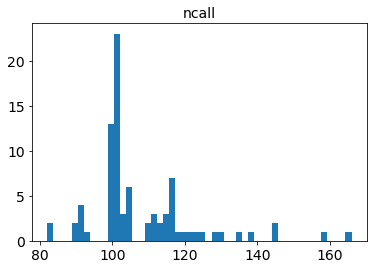

rango chisq : 1.2351738712913127, 21368.761710732033
promedio chisq : 779.0478614781939
desviación estándar chisq : 3178.9301159406627
mediana chisq : 33.100305784553775


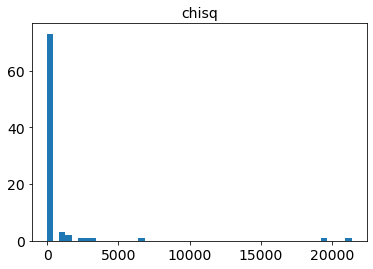

rango ndof : 4, 71
promedio ndof : 23.904761904761905
desviación estándar ndof : 15.012390951682805
mediana ndof : 18.0


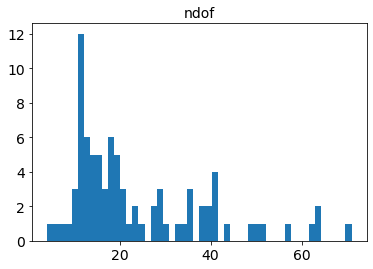

rango chisq/ndof : 0.3087934678228282, 305.3977618521512
promedio chisq/ndof : 15.689231143861818
desviación estándar chisq/ndof : 49.68149746908525
mediana chisq/ndof : 1.5834979614543645


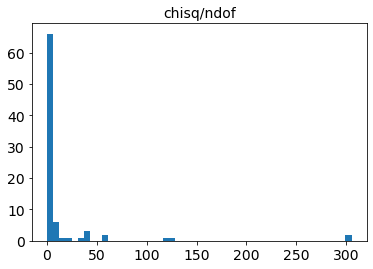

rango z : 0.0181, 0.14
promedio z : 0.07072857142857143
desviación estándar z : 0.026406531350391015
mediana z : 0.07135


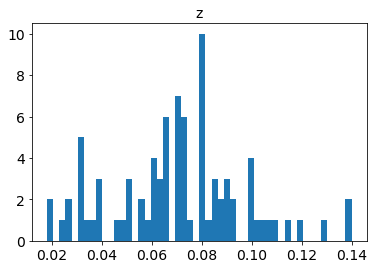

rango t0 : 58254.66089235649, 58395.614080229265
promedio t0 : 58319.86995877713
desviación estándar t0 : 38.78529729997025
mediana t0 : 58313.91860414081


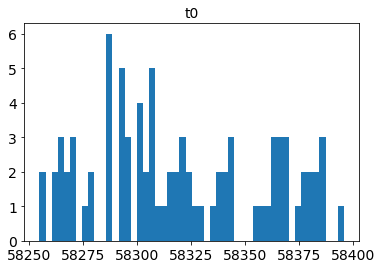

rango t0_err : 0.00994997473389958, 1.3873362933736644
promedio t0_err : 0.1766155041546188
desviación estándar t0_err : 0.20461623755293873
mediana t0_err : 0.1250895642733667


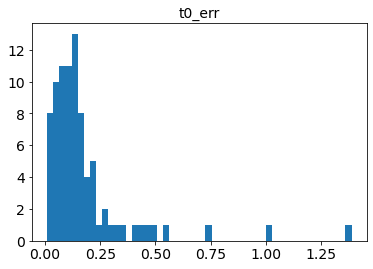

rango x0 : 0.00022820032888927092, 0.011094015298075272
promedio x0 : 0.0013610768555057779
desviación estándar x0 : 0.0017930783363122157
mediana x0 : 0.000714731294387839


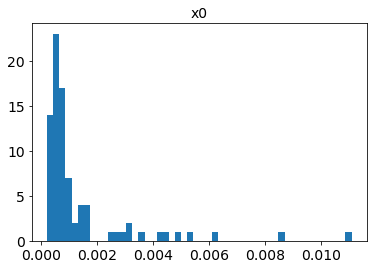

rango x0_err : 4.196005541534452e-06, 6.395852088265453e-05
promedio x0_err : 1.3827962893913176e-05
desviación estándar x0_err : 1.0194845547308356e-05
mediana x0_err : 1.0205068873302323e-05


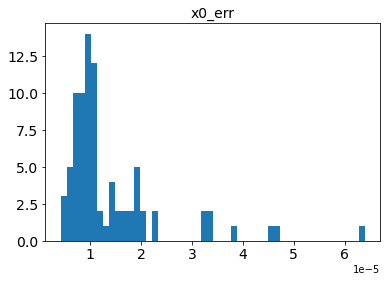

rango x1 : -2.164972393918284, 2.2803275812749906
promedio x1 : 0.09146807568859512
desviación estándar x1 : 1.0658749310209727
mediana x1 : 0.3144877602535358


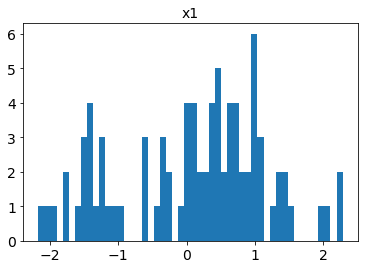

rango x1_err : 0.015622732213473964, 1.9865726930377352
promedio x1_err : 0.22546553357224322
desviación estándar x1_err : 0.2717632673113046
mediana x1_err : 0.15450798382540265


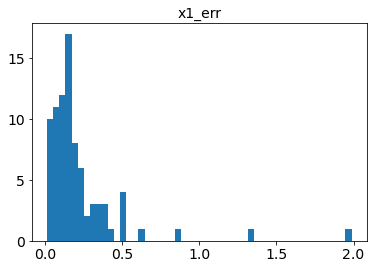

rango c : -0.17831176078141425, 0.6137454707035064
promedio c : 0.009106159369684886
desviación estándar c : 0.11601269273376019
mediana c : -0.005260231716384347


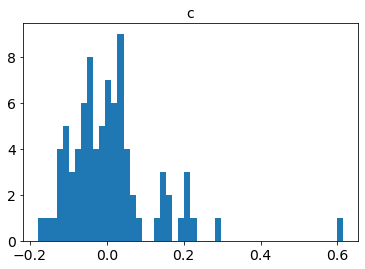

rango c_err : 0.0020608114076144783, 0.11904093410016503
promedio c_err : 0.02459206811520284
desviación estándar c_err : 0.015958875620523984
mediana c_err : 0.021516050038536627


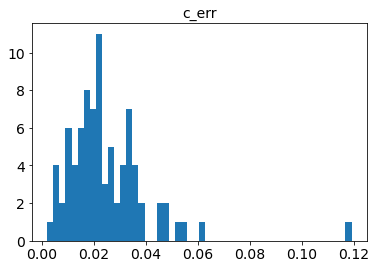

rango mwebv : 0.006204556550167132, 0.1144183424611353
promedio mwebv : 0.03064786661830939
desviación estándar mwebv : 0.02142708623940601
mediana mwebv : 0.02451353213255834


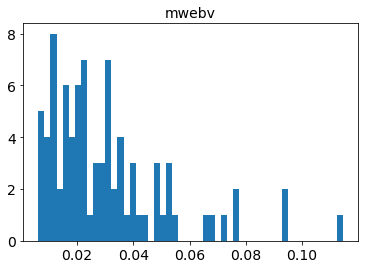

In [24]:
histogramas_estadisticas_resultados(ajustes_SALT2_z_fijo_early_SNIa, z_real=True)

Estadísticas de los ajustes, ordenados por valor de chisq/ndof

In [25]:
estadisticas_SALT2_z_fijo = estadisticas_resultados(ajustes_SALT2_z_fijo_early_SNIa, 
                                                    z_real=True).sort_values(by=['chisq/ndof'])

Listas de los oid y de los valores de chisq/ndof del primer ajuste
con SALT2 y redshift real, ordenados según el valor de chisq/ndof

In [26]:
lista_oid_SALT2_z_fijo = list(estadisticas_SALT2_z_fijo['oid'])
lista_chisq_vs_ndof_SALT2_z_fijo = list(estadisticas_SALT2_z_fijo['chisq/ndof'])

Filas de los resultados del ajuste con chisq/ndof sobre la 
mediana 

In [27]:
median_chisq_vs_ndof_SALT2_z_fijo = np.median(np.array(estadisticas_SALT2_z_fijo['chisq/ndof']))
df_chisq_vs_ndof_SALT2_z_fijo_sobre_mediana = estadisticas_SALT2_z_fijo[estadisticas_SALT2_z_fijo['chisq/ndof'] > median_chisq_vs_ndof_SALT2_z_fijo].reset_index()
lista_oid_SALT2_z_fijo_sobre_mediana = list(df_chisq_vs_ndof_SALT2_z_fijo_sobre_mediana['oid'])

Mostrar algunas columnas de los resultados del ajuste, con valores de chisq/ndof sobre la mediana

In [28]:
display(df_chisq_vs_ndof_SALT2_z_fijo_sobre_mediana[['oid', 
                                                     'chisq/ndof',
                                                     'z',
                                                     't0', 
                                                     't0_err']])

oid  chisq/ndof       z            t0    t0_err
0   ZTF18abdkimx    1.587939  0.0800  58313.849572  0.112693
1   ZTF18abpamut    1.588199  0.0720  58367.663093  0.148358
2   ZTF18abclalx    1.610255  0.1000  58301.101550  0.182075
3   ZTF18abdbuty    1.675277  0.0600  58308.087150  0.125924
4   ZTF18aaxwjmp    1.677559  0.0800  58288.346748  0.079886
5   ZTF18abjvhec    1.708779  0.0570  58340.363787  0.100591
6   ZTF18aaxrvzj    1.824913  0.1100  58286.100037  0.154429
7   ZTF18abpaywm    1.912038  0.0450  58367.953432  0.084035
8   ZTF18abealop    1.929016  0.0666  58316.249790  0.192941
9   ZTF18aaxqyki    1.982013  0.1003  58286.485350  0.127086
10  ZTF18abkifng    2.051978  0.0880  58343.578987  0.174145
11  ZTF18abdefet    2.058725  0.0700  58307.570275  0.226503
12  ZTF18abetewu    2.101013  0.0740  58318.777906  0.191203
13  ZTF18abbpeqo    2.457431  0.0667  58300.622391  0.093763
14  ZTF18abeecwe    3.200251  0.0393  58319.640314  0.072943
15  ZTF18aaunfqq    3.205966  0.0711  58268.627918  0.095477
16  ZTF18aazcoob    3.714843  0.0845  58294.347854  0.143362
17  ZTF18aavrwhu    3.736760  0.0620  58275.843487  0.067800
18  ZTF18aavrzxp    4.025645  0.0700  58270.401986  0.094260
19  ZTF18abetehf    4.149279  0.0649  58318.472003  0.097851
20  ZTF18aaqqoqs    4.373706  0.0800  58262.583571  0.059107
21  ZTF18abbvsiv    4.391523  0.0510  58296.789313  0.089446
22  ZTF18aaytovs    5.812707  0.0746  58294.398976  0.092329
23  ZTF18aaqffyp    5.886144  0.0640  58254.660892  0.063096
24  ZTF18aauocnw    7.668350  0.1000  58269.134177  0.096281
25  ZTF18aaxdrjn    8.359438  0.0340  58279.018955  0.025477
26  ZTF18aayjvve    9.028064  0.0474  58292.023149  0.060997
27  ZTF18aatzygk    9.715002  0.0740  58262.262824  0.124255
28  ZTF18aawjywv   10.414714  0.0400  58271.371162  0.055793
29  ZTF18aaumlfl   10.798533  0.0874  58265.834611  0.127550
30  ZTF18aaslhxt   14.010025  0.0509  58263.632197  0.023822
31  ZTF18aaqcqvr   18.741311  0.0716  58256.517423  0.061002
32  ZTF18abfhryc   31.904730  0.0323  58324.128910  0.062680
33  ZTF18abcrxoj   37.367808  0.0309  58306.248515  0.051181
34  ZTF18aaumeys   42.011079  0.0365  58267.258772  0.029081
35  ZTF18abgmcmv   42.672676  0.0185  58328.822553  0.049987
36  ZTF18aaxsioa   55.614553  0.0315  58286.116452  0.025369
37  ZTF18aaxcntm   57.352522  0.0269  58279.052295  0.025983
38  ZTF18abuqugw  118.045506  0.0313  58384.370971  0.091833
39  ZTF18abcflnz  128.387523  0.0273  58306.289413  0.041490
40  ZTF18aasdted  300.968475  0.0181  58265.285238  0.009950
41  ZTF18abauprj  305.397762  0.0242  58302.060639  0.025220

Se ve que los valores de $\frac{\chi^{2}}{ndof}$  son muy altos, pese a que se esté usando el redshift real de la SN Ia para hacer los ajustes. Veamos si esto también pasa al ajustar el redshift de las SN y analicemos ese caso.

### Ajuste con redshift variable 

In [29]:
ajustes_SALT2_early_SNIa = modelo_ajustado_y_resultados('salt2', 
                                                        df_meta_early_SNIa, 
                                                        detect_early_SNIa, 
                                                        version='2.4',
                                                        print_ind_and_oid=False)

rango ncall : 152, 1081
promedio ncall : 335.3690476190476
desviación estándar ncall : 158.846794994565
mediana ncall : 281.5


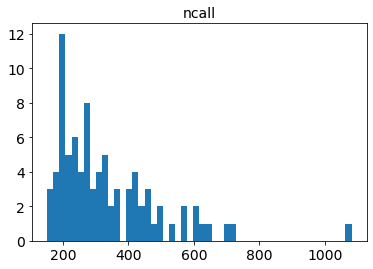

rango chisq : 1.272570386239837, 21325.384807206337
promedio chisq : 698.1003185001222
desviación estándar chisq : 3114.4010581404245
mediana chisq : 32.96942716360056


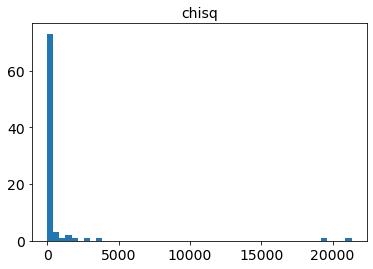

rango ndof : 3, 70
promedio ndof : 22.904761904761905
desviación estándar ndof : 15.012390951682805
mediana ndof : 17.0


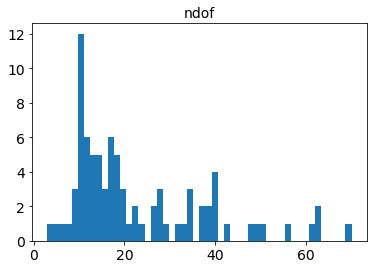

rango chisq/ndof : 0.4241901287466123, 310.24918593277556
promedio chisq/ndof : 14.386943679698149
desviación estándar chisq/ndof : 48.78146637180874
mediana chisq/ndof : 1.794328471457057


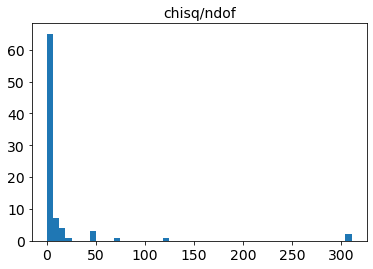

rango z : 0.0010000004500293118, 0.4403630136876394
promedio z : 0.1767371525656583
desviación estándar z : 0.09846763839113166
mediana z : 0.16856684866273774


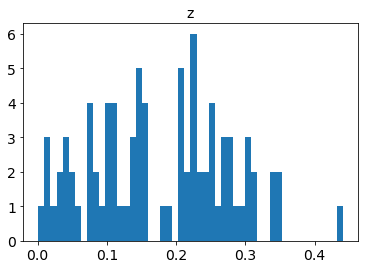

rango z_err : 1.597546400722294e-11, 0.4139954465671014
promedio z_err : 0.023904267781087257
desviación estándar z_err : 0.047814172909411756
mediana z_err : 0.014619410728271588


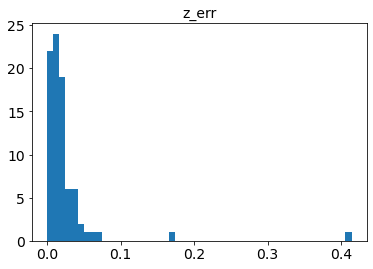

rango t0 : 58257.01493998718, 58396.5690826532
promedio t0 : 58320.86494531905
desviación estándar t0 : 38.869023740461564
mediana t0 : 58314.61047213344


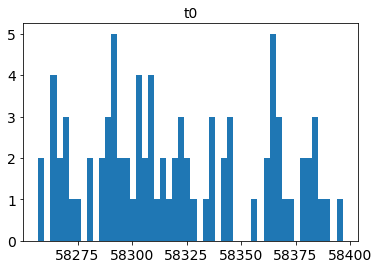

rango t0_err : 9.968061931431293e-10, 123.00576427039414
promedio t0_err : 1.7447191052764797
desviación estándar t0_err : 13.313793350301594
mediana t0_err : 0.19996139678733016


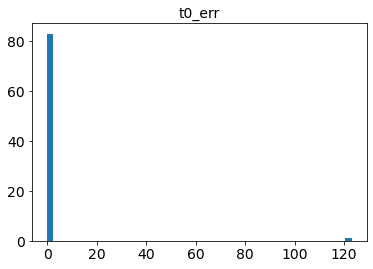

rango x0 : 0.00021593183581902124, 0.011187072147821797
promedio x0 : 0.001285116419685958
desviación estándar x0 : 0.0016783564456433623
mediana x0 : 0.0006647521601681382


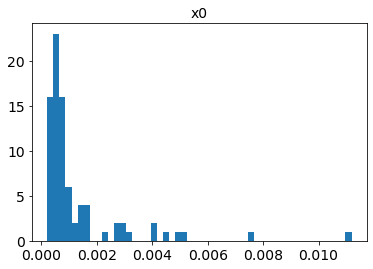

rango x0_err : 5.4301043387187246e-06, 1.0000010000366952
promedio x0_err : 0.011922583992337527
desviación estándar x0_err : 0.1084556968644107
mediana x0_err : 1.2654675741391135e-05


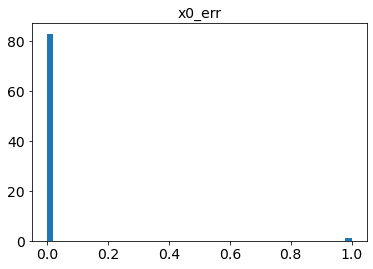

rango x1 : -2.305271444535058, 3.9999999603108023
promedio x1 : 0.12127844885550293
desviación estándar x1 : 1.2032596970300913
mediana x1 : 0.27221014887842987


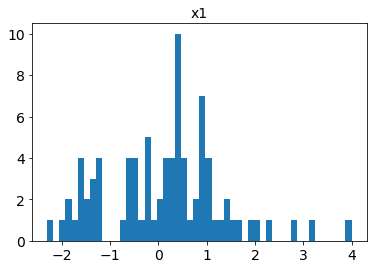

rango x1_err : 0.009495872892204549, 5.692635735224446
promedio x1_err : 0.31183425353495947
desviación estándar x1_err : 0.6516832158417281
mediana x1_err : 0.17460503477531986


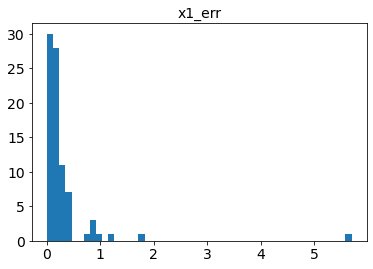

rango c : -0.34573583205279895, 0.2909049500748452
promedio c : -0.10677767935432092
desviación estándar c : 0.12825256366301274
mediana c : -0.10315874948742074


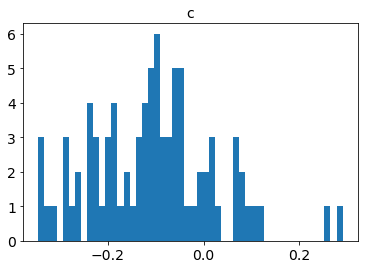

rango c_err : 0.0016599220068092002, 0.4982182012838825
promedio c_err : 0.041405070070644874
desviación estándar c_err : 0.059661955279468507
mediana c_err : 0.03120151341511279


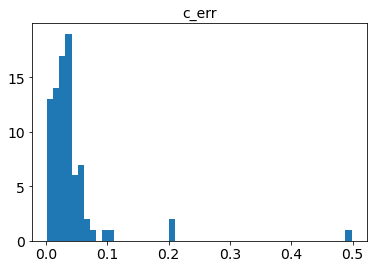

rango mwebv : 0.006204556550167132, 0.1144183424611353
promedio mwebv : 0.03064786661830939
desviación estándar mwebv : 0.02142708623940601
mediana mwebv : 0.02451353213255834


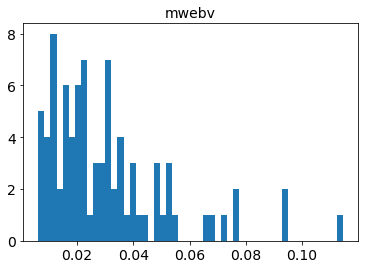

In [30]:
histogramas_estadisticas_resultados(ajustes_SALT2_early_SNIa)

Estadísticas de los ajustes, ordenados por valor de chisq/ndof

In [31]:
estadisticas_SALT2_z_var = estadisticas_resultados(ajustes_SALT2_early_SNIa).sort_values(by=['chisq/ndof'])

Listas de los oid y de los valores de chisq/ndof del primer ajuste
con SALT2 y redshift variable, ordenados según el valor de chisq/ndof

In [32]:
lista_oid_SALT2_z_var = list(estadisticas_SALT2_z_var['oid'])
lista_chisq_vs_ndof_SALT2_z_var = list(estadisticas_SALT2_z_var['chisq/ndof'])

Filas de los resultados del ajuste con chisq/ndof sobre la 
mediana 

In [33]:
median_chisq_vs_ndof_SALT2_z_var = np.median(np.array(estadisticas_SALT2_z_var['chisq/ndof']))
df_SALT2_z_var_chisq_vs_ndof_sobre_mediana = estadisticas_SALT2_z_var[estadisticas_SALT2_z_var['chisq/ndof'] > median_chisq_vs_ndof_SALT2_z_var].reset_index()
lista_oid_SALT2_z_var_sobre_mediana = list(df_SALT2_z_var_chisq_vs_ndof_sobre_mediana['oid'])

Mostrar algunas columnas de los resultados del ajuste, con valores de chisq/ndof sobre la mediana

In [34]:
display(df_SALT2_z_var_chisq_vs_ndof_sobre_mediana[['oid', 
                                                    'chisq/ndof',
                                                    'z', 
                                                    'z_err', 
                                                    't0', 
                                                    't0_err']])

oid  chisq/ndof         z     z_err            t0      t0_err
0   ZTF18abdfwur    1.815980  0.227314  0.012858  58311.487508    0.167697
1   ZTF18abealop    1.864397  0.001000  0.014048  58315.390314    0.198186
2   ZTF18abrzeym    1.871267  0.136248  0.018855  58374.232011    0.171011
3   ZTF18aaxrvzj    1.873503  0.220224  0.018028  58287.226885    0.206125
4   ZTF18absdgon    1.941578  0.254116  0.025015  58377.339180    0.201737
5   ZTF18abimsyv    2.021273  0.230718  0.013452  58336.099961    0.183273
6   ZTF18abkifng    2.029426  0.153458  0.033023  58344.007614    0.222102
7   ZTF18aaxqyki    2.099737  0.106999  0.033515  58286.567151    0.438536
8   ZTF18aaxwjmp    2.172378  0.335645  0.014701  58290.774825    0.238167
9   ZTF18abbvsiv    2.219474  0.209209  0.009346  58297.785635    0.178453
10  ZTF18abdefet    2.275477  0.156753  0.022183  58307.907156    0.243747
11  ZTF18abetewu    2.291251  0.075788  0.020830  58318.782157    0.197442
12  ZTF18abcsgvj    2.371042  0.346115  0.014585  58305.896496    0.160112
13  ZTF18abbpeqo    2.676484  0.256383  0.413995  58302.324449  123.005764
14  ZTF18aazcoob    3.654664  0.269479  0.013464  58296.259932    0.209550
15  ZTF18aansqun    3.753205  0.310186  0.017463  58317.273587    0.613566
16  ZTF18aavrwhu    3.840132  0.080349  0.010043  58275.916903    0.081428
17  ZTF18aavrzxp    4.093315  0.050553  0.007629  58270.237254    0.146567
18  ZTF18abetehf    4.291855  0.244272  0.011772  58319.992073    0.153885
19  ZTF18aaqqoqs    4.818820  0.244070  0.007953  58264.171541    0.084957
20  ZTF18aayjvve    5.077619  0.097981  0.007998  58292.354103    0.090881
21  ZTF18aaytovs    5.402372  0.223979  0.008384  58295.959268    0.103188
22  ZTF18aaunfqq    5.549376  0.301268  0.014568  58270.577144    0.217967
23  ZTF18abeecwe    6.679949  0.254437  0.006065  58321.701979    0.083504
24  ZTF18aaxdrjn    7.722644  0.133699  0.003721  58279.693294    0.029454
25  ZTF18aauocnw    8.216721  0.157735  0.017171  58269.293644    0.119899
26  ZTF18aaqffyp    8.845976  0.348966  0.008337  58257.435745    0.138198
27  ZTF18aatzygk    9.793850  0.207947  0.011961  58263.365460    0.222502
28  ZTF18aaumlfl   10.340520  0.018267  0.011033  58265.034643    0.270897
29  ZTF18aawjywv   10.760883  0.189886  0.005716  58272.300693    0.105955
30  ZTF18aaslhxt   12.844869  0.081361  0.003923  58263.803135    0.032827
31  ZTF18abfhryc   17.509469  0.118337  0.000007  58325.250174    0.068524
32  ZTF18abgmcmv   18.248411  0.440363  0.001924  58334.993881    0.066774
33  ZTF18abcrxoj   18.675195  0.105089  0.000003  58306.941149    0.000093
34  ZTF18aaqcqvr   19.062615  0.150800  0.011528  58257.014940    0.065514
35  ZTF18aaumeys   43.903576  0.148838  0.002812  58267.773178    0.031050
36  ZTF18aaxcntm   45.442265  0.149227  0.000002  58279.731813    0.000074
37  ZTF18aaxsioa   47.375581  0.281772  0.002542  58288.393868    0.035587
38  ZTF18abcflnz   72.646404  0.231620  0.000004  58308.631944    0.000020
39  ZTF18abuqugw  119.602447  0.110784  0.006573  58390.219885    0.066570
40  ZTF18aasdted  304.648354  0.274702  0.000014  58267.543978    0.000001
41  ZTF18abauprj  310.249186  0.019879  0.001916  58301.964083    0.050030

Tabla de astropy con las detecciones, en el formato que requiere
sncosmo para hacer los ajustes

In [35]:
table_early_SNIa = astropy_table_detections(df_meta_early_SNIa,
                                            detect_early_SNIa)

Algunos gráficos de los ajustes de las SN que tienen valores de $\frac{\chi^{2}}{ndof}$ menores a la mediana.

 ==== Con ajuste del redshift ====
chisq/ndof :  0.47023330605558744


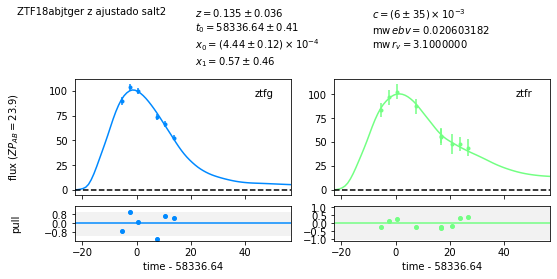

In [36]:
ajuste(lista_oid_SALT2_z_var[1], 'salt2', df_meta_early_SNIa, 
       table_early_SNIa, version='2.4')[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT2_z_var[1])

 ==== Con ajuste del redshift ====
chisq/ndof :  0.5551697749497996


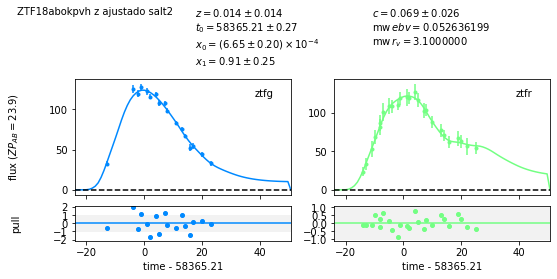

In [37]:
ajuste(lista_oid_SALT2_z_var[2], 'salt2', df_meta_early_SNIa, 
       table_early_SNIa, version='2.4')[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT2_z_var[2])

 ==== Con ajuste del redshift ====
chisq/ndof :  0.6049175865617807


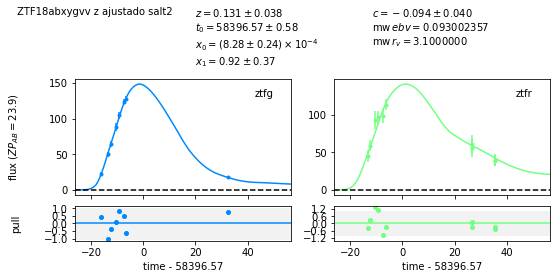

In [38]:
ajuste(lista_oid_SALT2_z_var[6], 'salt2', df_meta_early_SNIa, 
       table_early_SNIa, version='2.4')[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT2_z_var[6])

 ==== Con ajuste del redshift ====
chisq/ndof :  0.8265079196060631


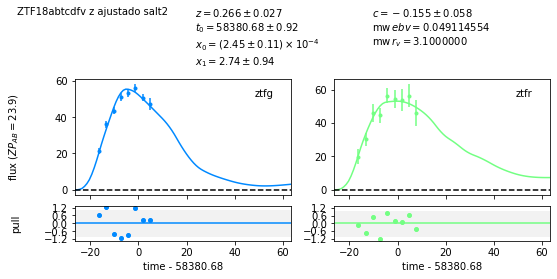

In [39]:
ajuste(lista_oid_SALT2_z_var[12], 'salt2', df_meta_early_SNIa, 
       table_early_SNIa, version='2.4')[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT2_z_var[12])

 ==== Con ajuste del redshift ====
chisq/ndof :  1.3198716083847688


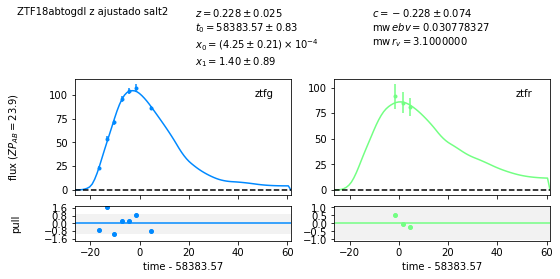

In [40]:
ajuste(lista_oid_SALT2_z_var[31], 'salt2', df_meta_early_SNIa, 
       table_early_SNIa, version='2.4')[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT2_z_var[31])

Algunos gráficos de los ajustes de las SN que tienen valores de $\frac{\chi^{2}}{ndof}$ mayores a la mediana.

 ==== Con ajuste del redshift ====
chisq/ndof :  1.8159802318084


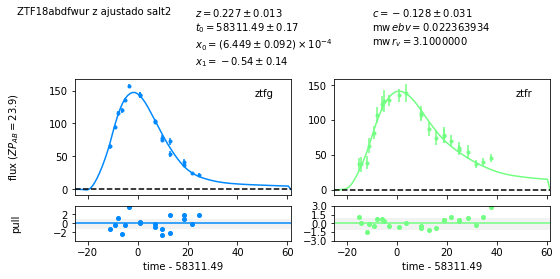

In [41]:
ajuste(lista_oid_SALT2_z_var_sobre_mediana[0], 'salt2', 
       df_meta_early_SNIa, table_early_SNIa, version='2.4')[0]
print('chisq/ndof : ', 
      df_SALT2_z_var_chisq_vs_ndof_sobre_mediana['chisq/ndof'][0])

 ==== Con ajuste del redshift ====
chisq/ndof :  3.654664148249278


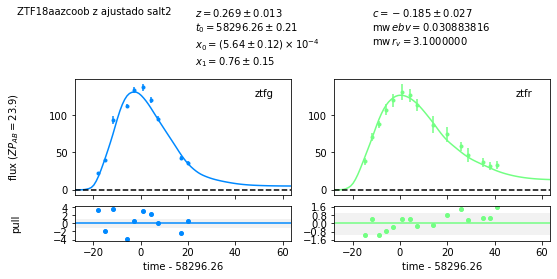

In [42]:
ajuste(lista_oid_SALT2_z_var_sobre_mediana[14], 'salt2', 
       df_meta_early_SNIa, table_early_SNIa, version='2.4')[0]
print('chisq/ndof : ', 
      df_SALT2_z_var_chisq_vs_ndof_sobre_mediana['chisq/ndof'][14])

 ==== Con ajuste del redshift ====
chisq/ndof :  3.7532045333725486


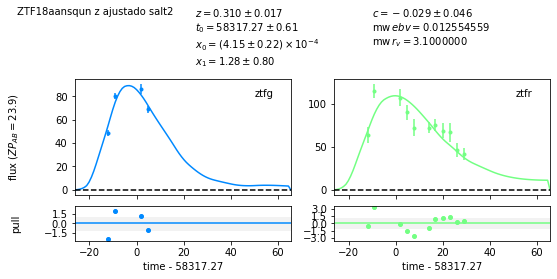

In [43]:
ajuste(lista_oid_SALT2_z_var_sobre_mediana[15], 'salt2', 
       df_meta_early_SNIa, table_early_SNIa, version='2.4')[0]
print('chisq/ndof : ', 
      df_SALT2_z_var_chisq_vs_ndof_sobre_mediana['chisq/ndof'][15])

 ==== Con ajuste del redshift ====
chisq/ndof :  3.840131934961187


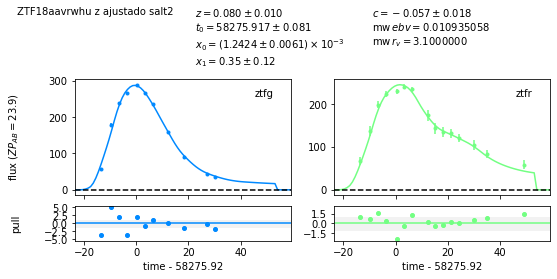

In [44]:
ajuste(lista_oid_SALT2_z_var_sobre_mediana[16], 'salt2', 
       df_meta_early_SNIa, table_early_SNIa, version='2.4')[0]
print('chisq/ndof : ', 
      df_SALT2_z_var_chisq_vs_ndof_sobre_mediana['chisq/ndof'][16])

 ==== Con ajuste del redshift ====
chisq/ndof :  5.402372166874435


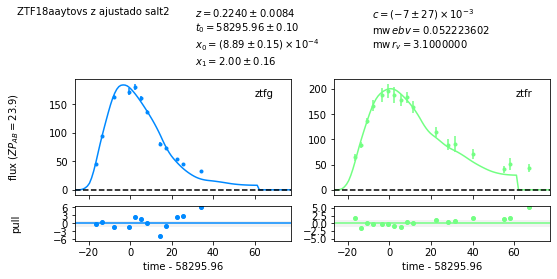

In [45]:
ajuste(lista_oid_SALT2_z_var_sobre_mediana[21], 'salt2', 
       df_meta_early_SNIa, table_early_SNIa, version='2.4')[0]
print('chisq/ndof : ', 
      df_SALT2_z_var_chisq_vs_ndof_sobre_mediana['chisq/ndof'][21])

 ==== Con ajuste del redshift ====
chisq/ndof :  7.722644047719621


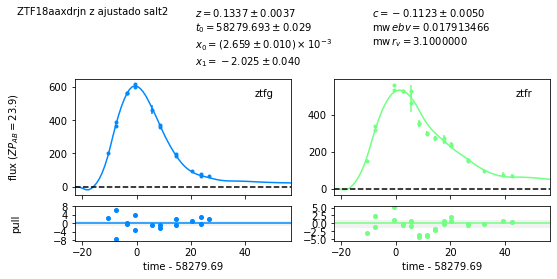

In [46]:
ajuste(lista_oid_SALT2_z_var_sobre_mediana[24], 'salt2', 
       df_meta_early_SNIa, table_early_SNIa, version='2.4')[0]
print('chisq/ndof : ', 
      df_SALT2_z_var_chisq_vs_ndof_sobre_mediana['chisq/ndof'][24])

 ==== Con ajuste del redshift ====
chisq/ndof :  8.216720814043448


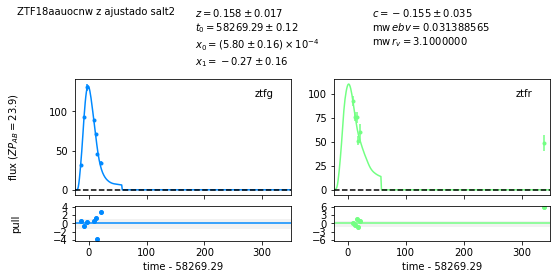

In [47]:
ajuste(lista_oid_SALT2_z_var_sobre_mediana[25], 'salt2', 
       df_meta_early_SNIa, table_early_SNIa, version='2.4')[0]
print('chisq/ndof : ', 
      df_SALT2_z_var_chisq_vs_ndof_sobre_mediana['chisq/ndof'][25])

 ==== Con ajuste del redshift ====
chisq/ndof :  8.845976382294763


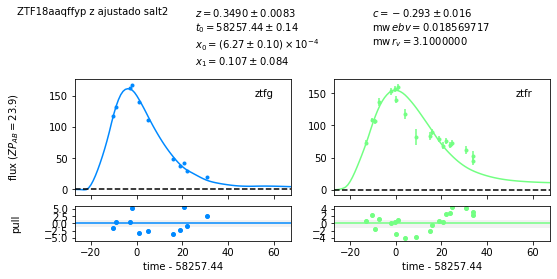

In [48]:
ajuste(lista_oid_SALT2_z_var_sobre_mediana[26], 'salt2', 
       df_meta_early_SNIa, table_early_SNIa, version='2.4')[0]
print('chisq/ndof : ', 
      df_SALT2_z_var_chisq_vs_ndof_sobre_mediana['chisq/ndof'][26])

 ==== Con ajuste del redshift ====
chisq/ndof :  12.84486862637627


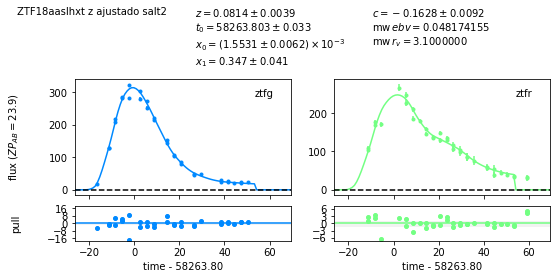

In [49]:
ajuste(lista_oid_SALT2_z_var_sobre_mediana[30], 'salt2', 
       df_meta_early_SNIa, table_early_SNIa, version='2.4')[0]
print('chisq/ndof : ', 
      df_SALT2_z_var_chisq_vs_ndof_sobre_mediana['chisq/ndof'][30])

 ==== Con ajuste del redshift ====
chisq/ndof :  119.60244725464872


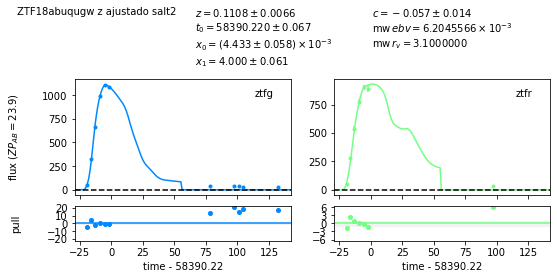

In [50]:
ajuste(lista_oid_SALT2_z_var_sobre_mediana[39], 'salt2', 
       df_meta_early_SNIa, table_early_SNIa, version='2.4', )[0]
print('chisq/ndof : ', 
      df_SALT2_z_var_chisq_vs_ndof_sobre_mediana['chisq/ndof'][39])

 ==== Con ajuste del redshift ====
chisq/ndof :  310.24918593277556


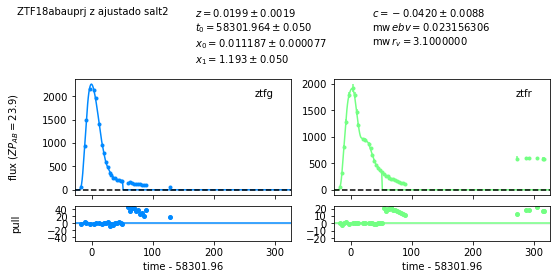

In [51]:
ajuste(lista_oid_SALT2_z_var_sobre_mediana[41], 'salt2', 
       df_meta_early_SNIa, table_early_SNIa, version='2.4')[0]
print('chisq/ndof : ', 
      df_SALT2_z_var_chisq_vs_ndof_sobre_mediana['chisq/ndof'][41])

De lo anterior se ve que los ajustes no son muy buenos y que el valor de $\frac{\chi^{2}}{ndof}$ aumenta mucho cuando hay puntos fuera del rango del modelo. Por lo anterior, se harán cortes en las observaciones para estar dentro del rango de tiempo del modelo, determinado a partir del valor del tiempo del máximo ($t_0$) y del redshift ($z$) determinado en el primer ajuste. 

Donde se utilizarán las observaciones realizadas en un tiempo $t$ que satisface que: $t_0 - 20 \cdot (1+z) \leq t \leq t_0 + 50 \cdot (1+z)$.

## Ajuste con observaciones en el rango de tiempo del modelo (determinado con $t_0$ y $z$ del primer ajuste)

### Ajuste con redshift real

Seleccionar las detecciones de las SN que están dentro del rango de tiempo del modelo según el primer ajuste con el modelo SALT2 y redshift real

In [52]:
detect_early_SNIa_cortes_t_SALT2_z_fijo = cortes_t_modelo(trest_min_modelo,
                                                          trest_max_modelo, 
                                                          detect_early_SNIa,
                                                          estadisticas_SALT2_z_fijo)

Ajustes con las detecciones de las SN que están dentro del rango de tiempo del modelo

In [53]:
ajustes_SALT2_z_fijo_early_SNIa_cortes_t = modelo_ajustado_y_resultados('salt2', 
                                                                        df_meta_early_SNIa, 
                                                                        detect_early_SNIa_cortes_t_SALT2_z_fijo, 
                                                                        version='2.4', 
                                                                        z_real=True,
                                                                        print_ind_and_oid=False)

rango ncall : 82, 168
promedio ncall : 107.88095238095238
desviación estándar ncall : 14.631509346599795
mediana ncall : 102.0


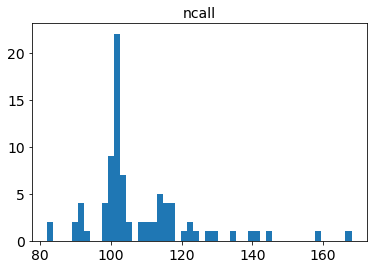

rango chisq : 1.2351738712913127, 789.0441000818224
promedio chisq : 65.6593698458964
desviación estándar chisq : 113.6568727316013
mediana chisq : 32.84772035070169


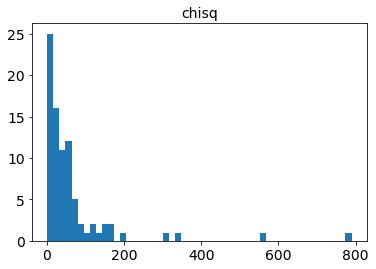

rango ndof : 4, 60
promedio ndof : 21.607142857142858
desviación estándar ndof : 11.77064332216753
mediana ndof : 18.0


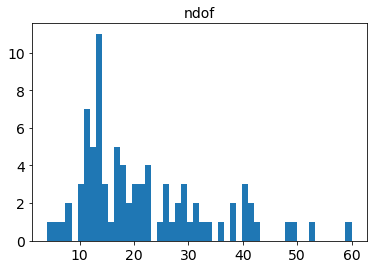

rango chisq/ndof : 0.3087934678228282, 20.296988357874742
promedio chisq/ndof : 2.8313381572578784
desviación estándar chisq/ndof : 3.8663571028249812
mediana chisq/ndof : 1.4956640308705555


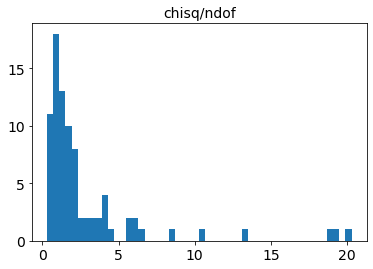

rango z : 0.0181, 0.14
promedio z : 0.07072857142857143
desviación estándar z : 0.026406531350391015
mediana z : 0.07135


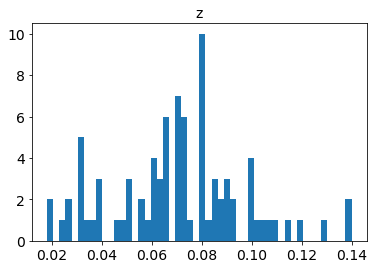

rango t0 : 58254.66089235649, 58395.614080229265
promedio t0 : 58319.86995976897
desviación estándar t0 : 38.78526685792459
mediana t0 : 58313.91860414081


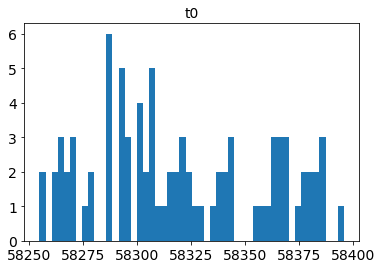

rango t0_err : 0.009948143877409166, 1.3873362933736644
promedio t0_err : 0.17661480382923314
desviación estándar t0_err : 0.20461643881213823
mediana t0_err : 0.12506301414396148


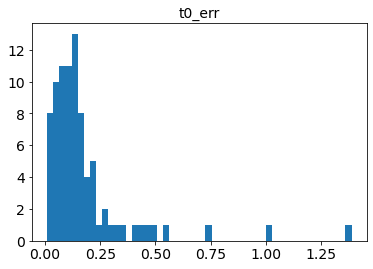

rango x0 : 0.00022820032888927092, 0.01109407608538051
promedio x0 : 0.0013610791158527394
desviación estándar x0 : 0.001793083651464728
mediana x0 : 0.000714731294387839


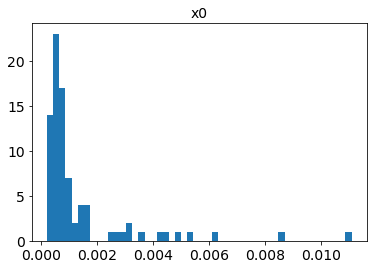

rango x0_err : 4.196005541534452e-06, 6.388406624862285e-05
promedio x0_err : 1.3825831929620132e-05
desviación estándar x0_err : 1.0188153574522919e-05
mediana x0_err : 1.0203399832522604e-05


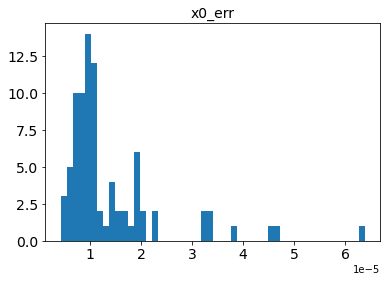

rango x1 : -2.164972393918284, 2.2803275812749906
promedio x1 : 0.0914748260281345
desviación estándar x1 : 1.0658732909592652
mediana x1 : 0.3144911959931642


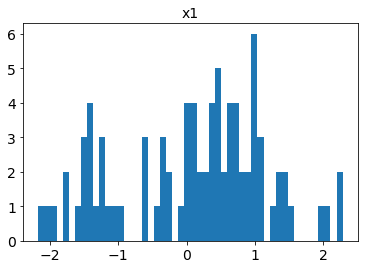

rango x1_err : 0.015615974080204131, 1.9865726930377352
promedio x1_err : 0.2254630132494175
desviación estándar x1_err : 0.27176432299313574
mediana x1_err : 0.15449404475441758


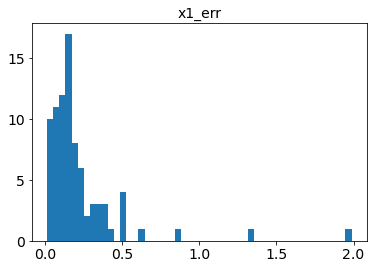

rango c : -0.17831176078141425, 0.6137259453196798
promedio c : 0.009104056558769705
desviación estándar c : 0.11601125424387478
mediana c : -0.005260231716384347


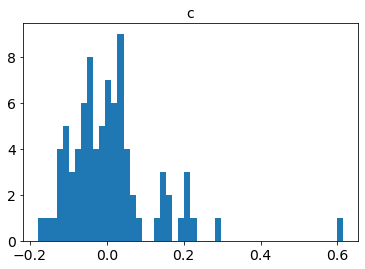

rango c_err : 0.0020599817010846346, 0.11904093410016503
promedio c_err : 0.024591655724068115
desviación estándar c_err : 0.0159592268231857
mediana c_err : 0.021516050038536627


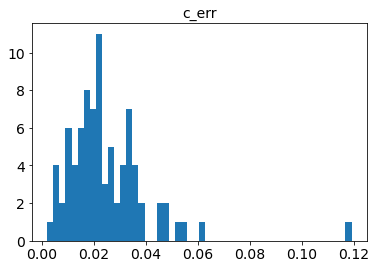

rango mwebv : 0.006204556550167132, 0.1144183424611353
promedio mwebv : 0.03064786661830939
desviación estándar mwebv : 0.02142708623940601
mediana mwebv : 0.02451353213255834


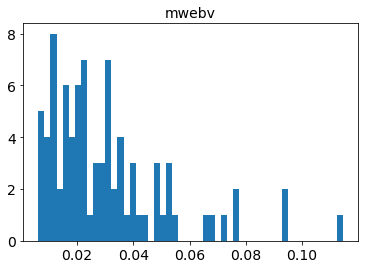

In [54]:
histogramas_estadisticas_resultados(ajustes_SALT2_z_fijo_early_SNIa_cortes_t, 
                                    z_real=True)

Aquí vemos que el valor de $\frac{\chi^{2}}{ndof}$ disminuye mucho al utilizar para los ajustes solo las observaciones que están dentro del rango de tiempo del modelo. 

Es importante notar que como aquí se está utilizando el valor real del redshift, si se asume que el valor del tiempo del máximo brillo ($t_0$) es correcto o muy cercano al valor real, este corte en el rango de tiempo del modelo es efectivamente aquel que deja a todas las observaciones posibles dentro del rango de tiempo del modelo.

Por lo anterior, este sería el ajuste perfecto en el caso en que el redshift que se utiliza es el redshift real de la SN y solo se ajustan los parámetros del modelo SALT2 ($x0$, $x1$, $c$) y el tiempo del máximo brillo ($t_0$).




Pregunta: (también está en la parte de las funciones)

- ¿Es posible determinar de otra forma (más exacta) el tiempo del máximo brillo?

Estadísticas de los ajustes, ordenados por valor de chisq/ndof

In [55]:
estadisticas_SALT2_z_fijo_cortes_t = estadisticas_resultados(ajustes_SALT2_z_fijo_early_SNIa_cortes_t, 
                                                             z_real=True).sort_values(by=['chisq/ndof'])

Listas de los oid y de los valores de chisq/ndof del ajuste con con el modelo SALT2 y redshift real, utilizando los puntos que pertenecen al rango de tiempo del modelo (determinado con los valores de $t_0$ del primer ajuste y $z_{real}$), ordenados según el valor de chisq/ndof

In [56]:
lista_oid_SALT2_z_fijo_cortes_t = list(estadisticas_SALT2_z_fijo_cortes_t['oid'])
lista_chisq_vs_ndof_SALT2_z_fijo_cortes_t = list(estadisticas_SALT2_z_fijo_cortes_t['chisq/ndof'])

Filas de los resultados del ajuste con chisq/ndof sobre la 
mediana 

In [57]:
median_chisq_vs_ndof_SALT2_z_fijo_cortes_t = np.median(np.array(estadisticas_SALT2_z_fijo_cortes_t['chisq/ndof']))
df_chisq_vs_ndof_SALT2_z_fijo_sobre_mediana_cortes_t = estadisticas_SALT2_z_fijo_cortes_t[estadisticas_SALT2_z_fijo_cortes_t['chisq/ndof'] > median_chisq_vs_ndof_SALT2_z_fijo_cortes_t].reset_index()
lista_oid_SALT2_z_fijo_sobre_mediana_cortes_t = list(df_chisq_vs_ndof_SALT2_z_fijo_sobre_mediana_cortes_t['oid'])

Mostrar algunas columnas de los resultados del ajuste, con valores de chisq/ndof sobre la mediana

In [58]:
display(df_chisq_vs_ndof_SALT2_z_fijo_sobre_mediana_cortes_t[['oid', 
                                                             'chisq/ndof', 
                                                             'z', 
                                                             't0', 
                                                             't0_err']])

oid  chisq/ndof       z            t0    t0_err
0   ZTF18abckujg    1.561183  0.0740  58303.340122  0.146650
1   ZTF18abtnlik    1.564569  0.0900  58379.085173  0.151260
2   ZTF18aazblzy    1.579057  0.0653  58291.799175  0.049163
3   ZTF18abdkimx    1.587939  0.0800  58313.849572  0.112693
4   ZTF18abpamut    1.588199  0.0720  58367.663093  0.148358
5   ZTF18abclalx    1.610255  0.1000  58301.101550  0.182075
6   ZTF18abdbuty    1.675277  0.0600  58308.087150  0.125924
7   ZTF18aaxwjmp    1.677559  0.0800  58288.346748  0.079886
8   ZTF18abjvhec    1.708779  0.0570  58340.363787  0.100591
9   ZTF18aaxrvzj    1.824913  0.1100  58286.100037  0.154429
10  ZTF18abealop    1.929016  0.0666  58316.249790  0.192941
11  ZTF18abcrxoj    1.955691  0.0309  58306.248516  0.051181
12  ZTF18aaxqyki    1.982013  0.1003  58286.485350  0.127086
13  ZTF18abcflnz    1.996004  0.0273  58306.289429  0.041488
14  ZTF18abkifng    2.051978  0.0880  58343.578987  0.174145
15  ZTF18abdefet    2.058725  0.0700  58307.570275  0.226503
16  ZTF18abetewu    2.101013  0.0740  58318.777906  0.191203
17  ZTF18abgmcmv    2.160806  0.0185  58328.822488  0.049985
18  ZTF18aayjvve    2.504635  0.0474  58292.023146  0.060994
19  ZTF18aaumlfl    2.689409  0.0874  58265.834613  0.127528
20  ZTF18abbvsiv    3.038040  0.0510  58296.789343  0.089445
21  ZTF18aaytovs    3.044425  0.0746  58294.398873  0.092323
22  ZTF18abfhryc    3.126106  0.0323  58324.128910  0.062675
23  ZTF18aaunfqq    3.205966  0.0711  58268.627918  0.095477
24  ZTF18aazcoob    3.714843  0.0845  58294.347854  0.143362
25  ZTF18aavrwhu    3.736760  0.0620  58275.843487  0.067800
26  ZTF18aavrzxp    4.025645  0.0700  58270.401986  0.094260
27  ZTF18abauprj    4.031864  0.0242  58302.060626  0.025214
28  ZTF18abetehf    4.149279  0.0649  58318.472003  0.097851
29  ZTF18aauocnw    4.286056  0.1000  58269.134214  0.096280
30  ZTF18aaqqoqs    4.373706  0.0800  58262.583571  0.059107
31  ZTF18aatzygk    5.685808  0.0740  58262.263826  0.124202
32  ZTF18aaqffyp    5.886144  0.0640  58254.660892  0.063096
33  ZTF18aaxcntm    5.970880  0.0269  58279.052300  0.025982
34  ZTF18aaumeys    6.179594  0.0365  58267.258778  0.029081
35  ZTF18aaxsioa    6.458988  0.0315  58286.116452  0.025369
36  ZTF18aaxdrjn    8.359438  0.0340  58279.018955  0.025477
37  ZTF18aawjywv   10.414714  0.0400  58271.371162  0.055793
38  ZTF18aaslhxt   13.150735  0.0509  58263.632211  0.023822
39  ZTF18aaqcqvr   18.741311  0.0716  58256.517423  0.061002
40  ZTF18abuqugw   19.116075  0.0313  58384.370995  0.091862
41  ZTF18aasdted   20.296988  0.0181  58265.285232  0.009948

Intersección de los oid de las SN con valores de chisq/ndof mayores a la mediana de los ajustes con SALT2 y $z_{real}$  antes y después de eliminar los puntos fuera del rango de tiempo del modelo

In [59]:
inter_oid_SALT2_z_fijo_sobre_mediana_cortes_t = np.intersect1d(np.array(lista_oid_SALT2_z_fijo_sobre_mediana),
                                                               np.array(lista_oid_SALT2_z_fijo_sobre_mediana_cortes_t))
print('Elementos comunes sobre la mediana de chisq/ndof : ',len(inter_oid_SALT2_z_fijo_sobre_mediana_cortes_t))

Elementos comunes sobre la mediana de chisq/ndof :  39


Tabla de astropy con las detecciones que están en el rango de tiempo del modelo, en el formato que requiere sncosmo para hacer los ajustes 

In [60]:
table_early_SNIa_SALT2_z_fijo_cortes_t = astropy_table_detections(df_meta_early_SNIa, 
                                                                    detect_early_SNIa_cortes_t_SALT2_z_fijo)


Algunos gráficos de los ajustes de las SN que tienen valores de $\frac{\chi^{2}}{ndof}$ menores a la mediana.

 ===== Ajuste con redshift real ====
chisq/ndof :  0.46993974084599666


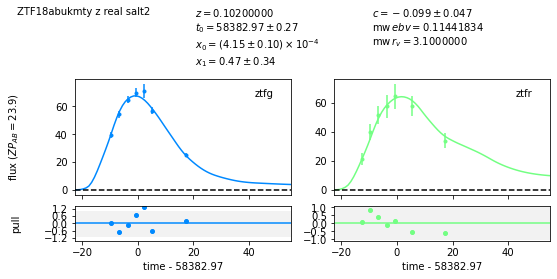

In [61]:
ajuste(lista_oid_SALT2_z_fijo_cortes_t[2], 'salt2', df_meta_early_SNIa, 
       table_early_SNIa_SALT2_z_fijo_cortes_t, version='2.4', z_real=True)[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT2_z_fijo_cortes_t[2])

 ===== Ajuste con redshift real ====
chisq/ndof :  0.5556740203847491


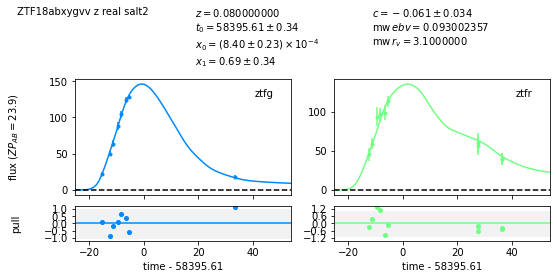

In [62]:
ajuste(lista_oid_SALT2_z_fijo_cortes_t[4], 'salt2', df_meta_early_SNIa, 
       table_early_SNIa_SALT2_z_fijo_cortes_t, version='2.4', z_real=True)[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT2_z_fijo_cortes_t[4])

 ===== Ajuste con redshift real ====
chisq/ndof :  0.8230933161198772


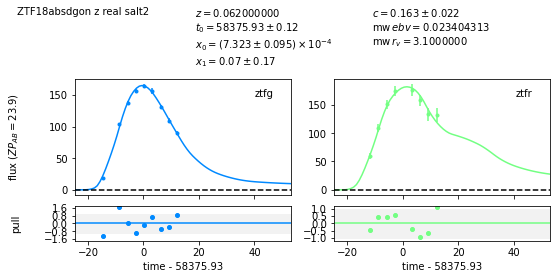

In [63]:
ajuste(lista_oid_SALT2_z_fijo_cortes_t[15], 'salt2', df_meta_early_SNIa, 
       table_early_SNIa_SALT2_z_fijo_cortes_t, version='2.4', z_real=True)[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT2_z_fijo_cortes_t[15])

 ===== Ajuste con redshift real ====
chisq/ndof :  0.8885944752391858


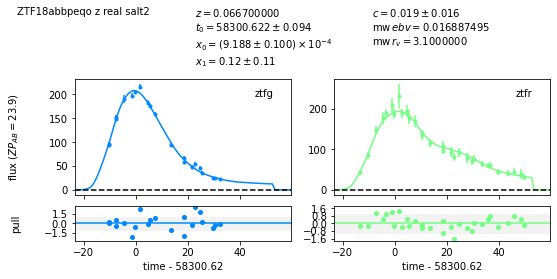

In [64]:
ajuste(lista_oid_SALT2_z_fijo_cortes_t[20], 'salt2', df_meta_early_SNIa, 
       table_early_SNIa_SALT2_z_fijo_cortes_t, version='2.4', z_real=True)[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT2_z_fijo_cortes_t[20])

 ===== Ajuste con redshift real ====
chisq/ndof :  1.1224600572300125


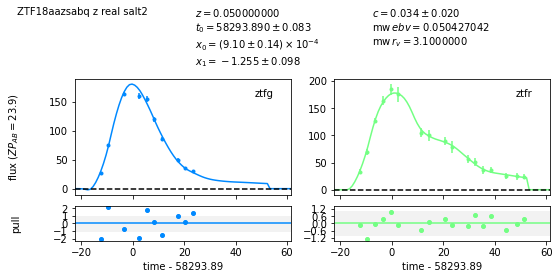

In [65]:
ajuste(lista_oid_SALT2_z_fijo_cortes_t[30], 'salt2', df_meta_early_SNIa, 
       table_early_SNIa_SALT2_z_fijo_cortes_t, version='2.4', z_real=True)[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT2_z_fijo_cortes_t[30])

 ===== Ajuste con redshift real ====
chisq/ndof :  1.2055754864205708


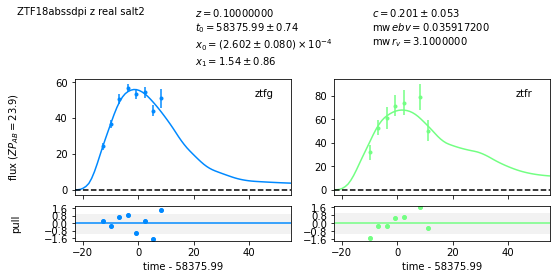

In [66]:
ajuste(lista_oid_SALT2_z_fijo_cortes_t[32], 'salt2', df_meta_early_SNIa, 
       table_early_SNIa_SALT2_z_fijo_cortes_t, version='2.4', z_real=True)[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT2_z_fijo_cortes_t[32])

 ===== Ajuste con redshift real ====
chisq/ndof :  1.3258233956677075


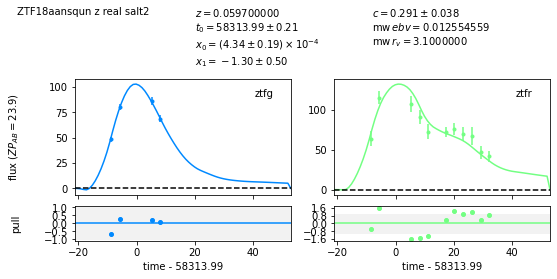

In [67]:
ajuste(lista_oid_SALT2_z_fijo_cortes_t[36], 'salt2', df_meta_early_SNIa, 
       table_early_SNIa_SALT2_z_fijo_cortes_t, version='2.4', z_real=True)[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT2_z_fijo_cortes_t[36])

 ===== Ajuste con redshift real ====
chisq/ndof :  1.430145069722101


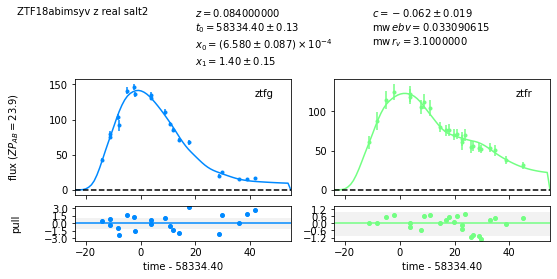

In [68]:
ajuste(lista_oid_SALT2_z_fijo_cortes_t[41], 'salt2', df_meta_early_SNIa, 
       table_early_SNIa_SALT2_z_fijo_cortes_t, version='2.4', z_real=True)[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT2_z_fijo_cortes_t[41])

Algunos gráficos de los ajustes de las SN que tienen valores de $\frac{\chi^{2}}{ndof}$ mayores a la mediana.

 ===== Ajuste con redshift real ====
chisq/ndof :  1.5611829920190101


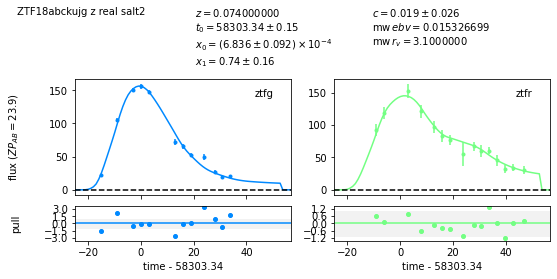

In [69]:
ajuste(lista_oid_SALT2_z_fijo_sobre_mediana_cortes_t[0], 'salt2', 
       df_meta_early_SNIa, table_early_SNIa_SALT2_z_fijo_cortes_t, 
       version='2.4', z_real=True)[0]
print('chisq/ndof : ', 
      df_chisq_vs_ndof_SALT2_z_fijo_sobre_mediana_cortes_t['chisq/ndof'][0])

 ===== Ajuste con redshift real ====
chisq/ndof :  2.5046350396752404


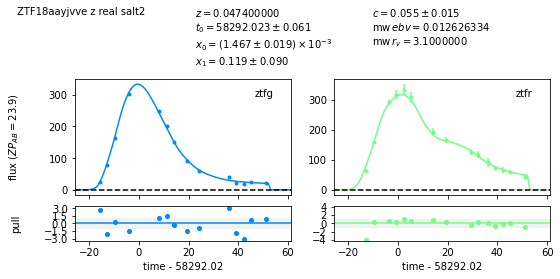

In [70]:
ajuste(lista_oid_SALT2_z_fijo_sobre_mediana_cortes_t[18], 'salt2', 
       df_meta_early_SNIa, table_early_SNIa_SALT2_z_fijo_cortes_t, 
       version='2.4', z_real=True)[0]
print('chisq/ndof : ', 
      df_chisq_vs_ndof_SALT2_z_fijo_sobre_mediana_cortes_t['chisq/ndof'][18])

 ===== Ajuste con redshift real ====
chisq/ndof :  3.0380397848592358


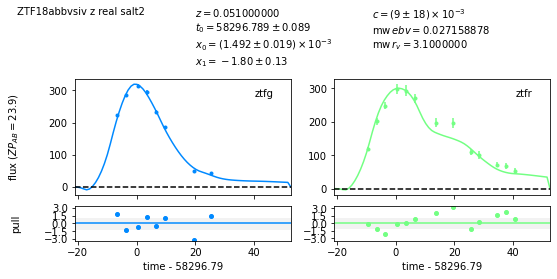

In [71]:
ajuste(lista_oid_SALT2_z_fijo_sobre_mediana_cortes_t[20], 'salt2', 
       df_meta_early_SNIa, table_early_SNIa_SALT2_z_fijo_cortes_t, 
       version='2.4', z_real=True)[0]
print('chisq/ndof : ', 
      df_chisq_vs_ndof_SALT2_z_fijo_sobre_mediana_cortes_t['chisq/ndof'][20])

 ===== Ajuste con redshift real ====
chisq/ndof :  3.0444253527274197


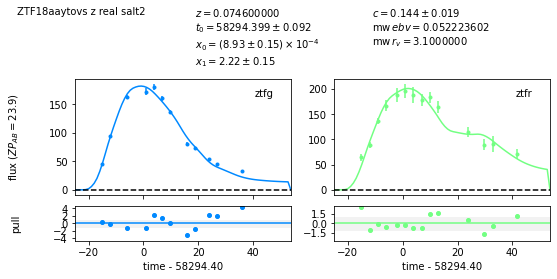

In [72]:
ajuste(lista_oid_SALT2_z_fijo_sobre_mediana_cortes_t[21], 'salt2', 
       df_meta_early_SNIa, table_early_SNIa_SALT2_z_fijo_cortes_t, 
       version='2.4', z_real=True)[0]
print('chisq/ndof : ', 
      df_chisq_vs_ndof_SALT2_z_fijo_sobre_mediana_cortes_t['chisq/ndof'][21])

 ===== Ajuste con redshift real ====
chisq/ndof :  5.886143514852669


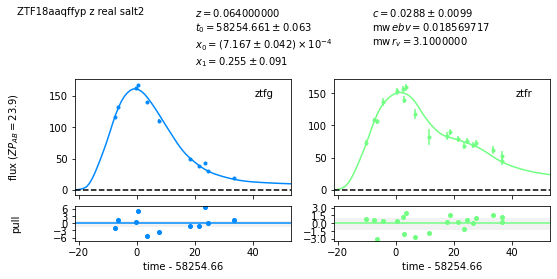

In [73]:
ajuste(lista_oid_SALT2_z_fijo_sobre_mediana_cortes_t[32], 'salt2', 
       df_meta_early_SNIa, table_early_SNIa_SALT2_z_fijo_cortes_t, 
       version='2.4', z_real=True)[0]
print('chisq/ndof : ', 
      df_chisq_vs_ndof_SALT2_z_fijo_sobre_mediana_cortes_t['chisq/ndof'][32])

 ===== Ajuste con redshift real ====
chisq/ndof :  6.179594319770619


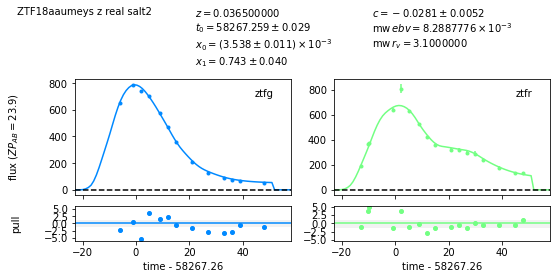

In [74]:
ajuste(lista_oid_SALT2_z_fijo_sobre_mediana_cortes_t[34], 'salt2', 
       df_meta_early_SNIa, table_early_SNIa_SALT2_z_fijo_cortes_t, 
       version='2.4', z_real=True)[0]
print('chisq/ndof : ', 
      df_chisq_vs_ndof_SALT2_z_fijo_sobre_mediana_cortes_t['chisq/ndof'][34])

 ===== Ajuste con redshift real ====
chisq/ndof :  13.150735001363707


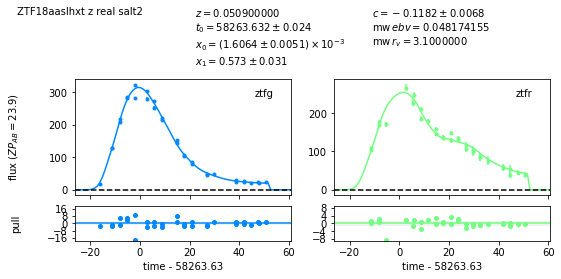

In [75]:
ajuste(lista_oid_SALT2_z_fijo_sobre_mediana_cortes_t[38], 'salt2', 
       df_meta_early_SNIa, table_early_SNIa_SALT2_z_fijo_cortes_t, 
       version='2.4', z_real=True)[0]
print('chisq/ndof : ', 
      df_chisq_vs_ndof_SALT2_z_fijo_sobre_mediana_cortes_t['chisq/ndof'][38])

 ===== Ajuste con redshift real ====
chisq/ndof :  20.296988357874742


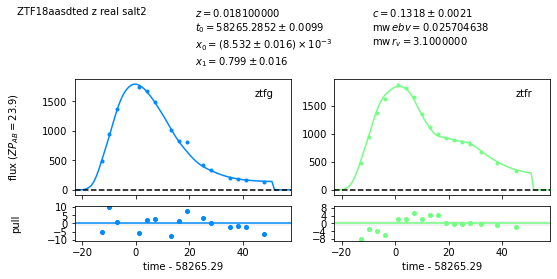

In [76]:
ajuste(lista_oid_SALT2_z_fijo_sobre_mediana_cortes_t[41], 'salt2', 
       df_meta_early_SNIa, table_early_SNIa_SALT2_z_fijo_cortes_t, 
       version='2.4', z_real=True)[0]
print('chisq/ndof : ', 
      df_chisq_vs_ndof_SALT2_z_fijo_sobre_mediana_cortes_t['chisq/ndof'][41])

### Ajuste con redshift variable

Seleccionar las detecciones de las SN que están dentro del rango de tiempo del modelo según el primer ajuste con el modelo SALT2 y redshift variable

In [77]:
detect_early_SNIa_cortes_t = cortes_t_modelo(trest_min_modelo, 
                                             trest_max_modelo, 
                                             detect_early_SNIa,
                                             estadisticas_SALT2_z_var)

Ajustes con las detecciones de las SN que están dentro del rango de tiempo del modelo

In [78]:
ajustes_SALT2_early_SNIa_cortes_t = modelo_ajustado_y_resultados('salt2', 
                                                                 df_meta_early_SNIa, 
                                                                 detect_early_SNIa_cortes_t, 
                                                                 version='2.4',
                                                                 print_ind_and_oid=False)

rango ncall : 152, 1436
promedio ncall : 346.4404761904762
desviación estándar ncall : 200.28024123299
mediana ncall : 281.5


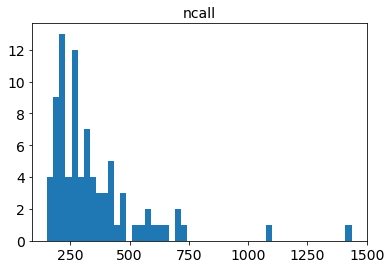

rango chisq : 1.272570386239837, 7243.638680956665
promedio chisq : 192.99149434745516
desviación estándar chisq : 801.4370798495086
mediana chisq : 31.472019545458128


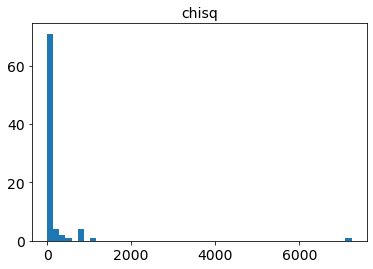

rango ndof : 3, 61
promedio ndof : 21.321428571428573
desviación estándar ndof : 12.653025907894536
mediana ndof : 17.0


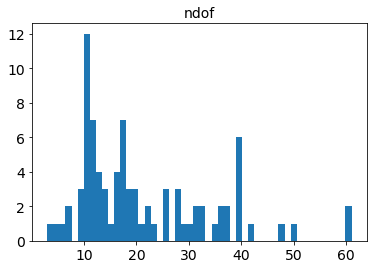

rango chisq/ndof : 0.4241901287466123, 201.21218558212956
promedio chisq/ndof : 6.225369592327679
desviación estándar chisq/ndof : 22.060487724891594
mediana chisq/ndof : 1.7641701886658043


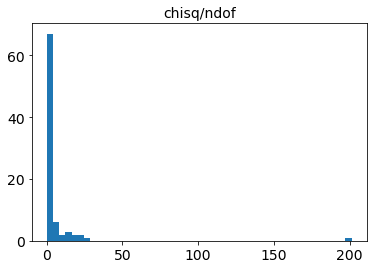

rango z : 0.0010000004500293118, 0.4403630136876394
promedio z : 0.17477549071116086
desviación estándar z : 0.10049671033666936
mediana z : 0.16855413319431933


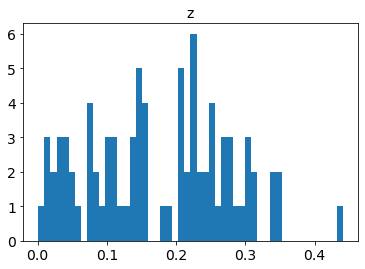

rango z_err : 1.597546400722294e-11, 0.3576527036231301
promedio z_err : 0.02326021257423449
desviación estándar z_err : 0.04241506498339299
mediana z_err : 0.014619410728271588


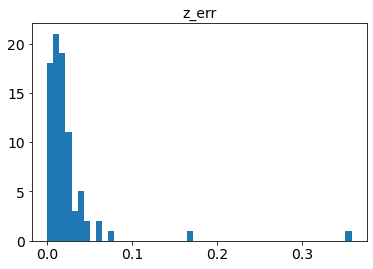

rango t0 : 58257.01493998718, 58396.5690826532
promedio t0 : 58320.842785329434
desviación estándar t0 : 38.84668386925134
mediana t0 : 58314.61047213344


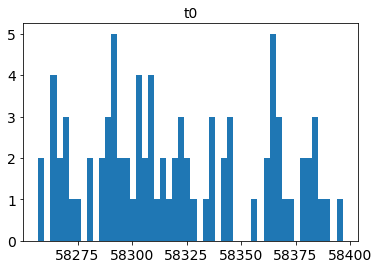

rango t0_err : 9.968061931431293e-10, 113.91267422946476
promedio t0_err : 1.6383156947353026
desviación estándar t0_err : 12.327643080704462
mediana t0_err : 0.19996139678733016


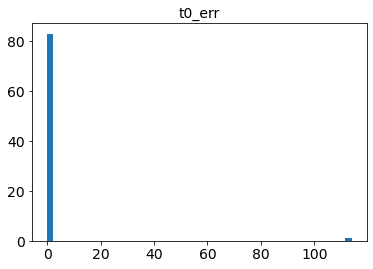

rango x0 : 0.00021593183581902124, 0.011187195217606609
promedio x0 : 0.0012935271865246645
desviación estándar x0 : 0.001694354014987703
mediana x0 : 0.0006647521601681382


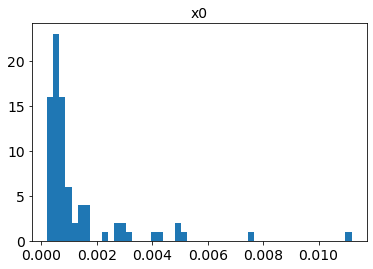

rango x0_err : 5.292840908066453e-06, 1.0000010003103934
promedio x0_err : 0.011923121141725126
desviación estándar x0_err : 0.10845563838429445
mediana x0_err : 1.2362279664604769e-05


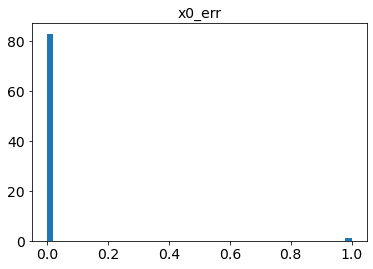

rango x1 : -2.305271444535058, 3.9168637014464673
promedio x1 : 0.12109650726347934
desviación estándar x1 : 1.1994394786067686
mediana x1 : 0.27221014887842987


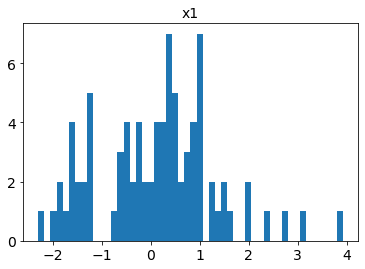

rango x1_err : 0.009965967432632894, 5.851764912934313
promedio x1_err : 0.31605869220082394
desviación estándar x1_err : 0.6667309265209483
mediana x1_err : 0.17724620542046177


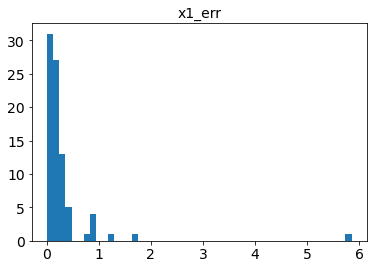

rango c : -0.34573583205279895, 0.2909049500748452
promedio c : -0.10464872189929263
desviación estándar c : 0.12962159778786633
mediana c : -0.10315874948742074


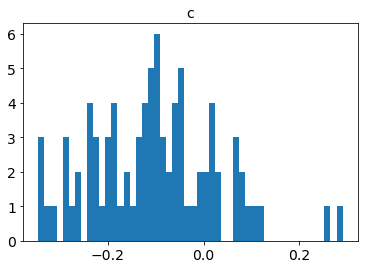

rango c_err : 0.0016603399957476755, 0.530126720317886
promedio c_err : 0.04178435187751515
desviación estándar c_err : 0.0626021641227917
mediana c_err : 0.03120151341511279


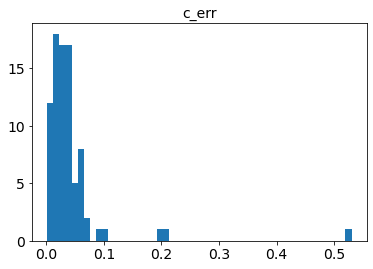

rango mwebv : 0.006204556550167132, 0.1144183424611353
promedio mwebv : 0.03064786661830939
desviación estándar mwebv : 0.02142708623940601
mediana mwebv : 0.02451353213255834


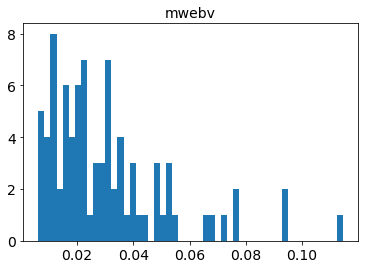

In [79]:
histogramas_estadisticas_resultados(ajustes_SALT2_early_SNIa_cortes_t)

Aquí vemos que el valor de $\frac{\chi^{2}}{ndof}$ disminuye un poco al utilizar para los ajustes solo las observaciones que están dentro del rango de tiempo del modelo.

Estadísticas de los ajustes, ordenados por valor de chisq/ndof

In [80]:
estadisticas_SALT2_z_var_cortes_t = estadisticas_resultados(ajustes_SALT2_early_SNIa_cortes_t).sort_values(by=['chisq/ndof'])

Listas de los oid y de los valores de chisq/ndof del ajuste con con el modelo SALT2 y redshift variable, utilizando los puntos que pertenecen al rango de tiempo del modelo (determinado con los valores de $t_0$ $z$ y del primer ajuste), ordenados según el valor de chisq/ndof

In [81]:
lista_oid_SALT2_z_var_cortes_t = list(estadisticas_SALT2_z_var_cortes_t['oid'])
lista_chisq_vs_ndof_SALT2_z_var_cortes_t = list(estadisticas_SALT2_z_var_cortes_t['chisq/ndof'])

Filas de los resultados del ajuste con chisq/ndof sobre la 
mediana 

In [82]:
median_chisq_vs_ndof_SALT2_z_var_cortes_t = np.median(np.array(estadisticas_SALT2_z_var_cortes_t['chisq/ndof']))
df_chisq_vs_ndof_SALT2_z_var_sobre_mediana_cortes_t = estadisticas_SALT2_z_var_cortes_t[estadisticas_SALT2_z_var_cortes_t['chisq/ndof'] > median_chisq_vs_ndof_SALT2_z_var_cortes_t].reset_index()
lista_oid_SALT2_z_var_sobre_mediana_cortes_t = list(df_chisq_vs_ndof_SALT2_z_var_sobre_mediana_cortes_t['oid'])

Mostrar algunas columnas de los resultados del ajuste, con valores de chisq/ndof sobre la mediana

In [83]:
display(df_chisq_vs_ndof_SALT2_z_var_sobre_mediana_cortes_t[['oid', 
                                                             'chisq/ndof', 
                                                             'z',
                                                             'z_err', 
                                                             't0', 
                                                             't0_err']])

oid  chisq/ndof         z         z_err            t0      t0_err
0   ZTF18abfgygp    1.772677  0.226013  7.145235e-03  58323.517629    0.100453
1   ZTF18abdfwur    1.815980  0.227314  1.285829e-02  58311.487508    0.167697
2   ZTF18abealop    1.864397  0.001000  1.404756e-02  58315.390314    0.198186
3   ZTF18abrzeym    1.871267  0.136248  1.885541e-02  58374.232011    0.171011
4   ZTF18aaxrvzj    1.873503  0.220224  1.802760e-02  58287.226885    0.206125
5   ZTF18absdgon    1.941578  0.254116  2.501496e-02  58377.339180    0.201737
6   ZTF18abimsyv    2.021273  0.230718  1.345244e-02  58336.099961    0.183273
7   ZTF18abkifng    2.029426  0.153458  3.302331e-02  58344.007614    0.222102
8   ZTF18aaxqyki    2.099737  0.106999  3.351543e-02  58286.567151    0.438536
9   ZTF18aaxwjmp    2.172378  0.335645  1.470137e-02  58290.774825    0.238167
10  ZTF18abbpeqo    2.187380  0.256391  7.599820e-06  58302.324329    0.000346
11  ZTF18abbvsiv    2.219474  0.209209  9.346173e-03  58297.785635    0.178453
12  ZTF18abdefet    2.275477  0.156753  2.218336e-02  58307.907156    0.243747
13  ZTF18abetewu    2.291251  0.075788  2.082968e-02  58318.782157    0.197442
14  ZTF18abcsgvj    2.371042  0.346115  1.458496e-02  58305.896496    0.160112
15  ZTF18aayjvve    2.500901  0.098053  9.198378e-03  58292.354845    0.098889
16  ZTF18aazcoob    3.654664  0.269479  1.346382e-02  58296.259932    0.209550
17  ZTF18aansqun    3.753205  0.310186  1.746300e-02  58317.273587    0.613566
18  ZTF18aavrwhu    3.840132  0.080349  1.004254e-02  58275.916903    0.081428
19  ZTF18abuqugw    3.974160  0.021136  7.279315e-03  58389.014283    0.192045
20  ZTF18abauprj    4.014362  0.019877  1.584965e-03  58301.964141    0.043737
21  ZTF18aavrzxp    4.093315  0.050553  7.629041e-03  58270.237254    0.146567
22  ZTF18abetehf    4.291855  0.244272  1.177155e-02  58319.992073    0.153885
23  ZTF18aaytovs    4.402552  0.224035  8.276911e-03  58295.959335    0.102785
24  ZTF18aauocnw    4.429584  0.157710  1.614965e-02  58269.293561    0.117552
25  ZTF18aaqqoqs    4.818820  0.244070  7.953352e-03  58264.171541    0.084957
26  ZTF18aatzygk    5.517762  0.207949  1.200381e-02  58263.365483    0.223090
27  ZTF18aaunfqq    5.549376  0.301268  1.456846e-02  58270.577144    0.217967
28  ZTF18abeecwe    6.679949  0.254437  6.065117e-03  58321.701979    0.083504
29  ZTF18abfhryc    7.280108  0.118337  3.576527e-01  58325.250206  113.912674
30  ZTF18aaxdrjn    7.722644  0.133699  3.721334e-03  58279.693294    0.029454
31  ZTF18aaqffyp    8.845976  0.348966  8.337316e-03  58257.435745    0.138198
32  ZTF18aawjywv   10.760883  0.189886  5.716316e-03  58272.300693    0.105955
33  ZTF18aaslhxt   12.526437  0.081367  3.922463e-03  58263.803203    0.032829
34  ZTF18aaxcntm   14.434108  0.149233  4.036182e-06  58279.731995    0.028993
35  ZTF18aaumeys   15.130752  0.148835  2.907553e-03  58267.773298    0.031053
36  ZTF18abgmcmv   18.248411  0.440363  1.923648e-03  58334.993881    0.066774
37  ZTF18aaqcqvr   19.062615  0.150800  1.152795e-02  58257.014940    0.065514
38  ZTF18abcflnz   20.874397  0.231162  1.235999e-08  58308.653995    0.000003
39  ZTF18aaxsioa   21.527486  0.277977  4.327091e-06  58288.359630    0.026263
40  ZTF18abcrxoj   27.379380  0.034139  4.390884e-03  58306.296324    0.082219
41  ZTF18aasdted  201.212186  0.274689  4.749534e-08  58267.544602    0.000009

Intersección de los oid de las SN con valores de chisq/ndof mayores a la mediana de los ajustes con SALT2 y $z$ variable antes y después de eliminar los puntos fuera del rango de tiempo del modelo

In [84]:
inter_oid_SALT2_z_var_sobre_mediana_cortes_t = np.intersect1d(np.array(lista_oid_SALT2_z_var_sobre_mediana),
                                                              np.array(lista_oid_SALT2_z_var_sobre_mediana_cortes_t))
print('Elementos comunes sobre la mediana de chisq/ndof : ',len(inter_oid_SALT2_z_var_sobre_mediana_cortes_t))

Elementos comunes sobre la mediana de chisq/ndof :  41


Tabla de astropy con las detecciones que están en el rango de tiempo del modelo, en el formato que requiere sncosmo para hacer los ajustes 

In [85]:
table_early_SNIa_SALT2_z_var_cortes_t = astropy_table_detections(df_meta_early_SNIa, 
                                                                detect_early_SNIa_cortes_t)

Algunos gráficos de los ajustes de las SN que tienen valores de $\frac{\chi^{2}}{ndof}$ menores a la mediana.

 ==== Con ajuste del redshift ====
chisq/ndof :  0.4241901287466123


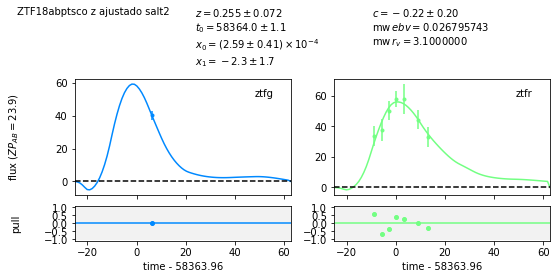

In [86]:
ajuste(lista_oid_SALT2_z_var_cortes_t[0], 'salt2', df_meta_early_SNIa, 
       table_early_SNIa_SALT2_z_var_cortes_t, version='2.4')[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT2_z_var_cortes_t[0])

 ==== Con ajuste del redshift ====
chisq/ndof :  0.6306178176926891


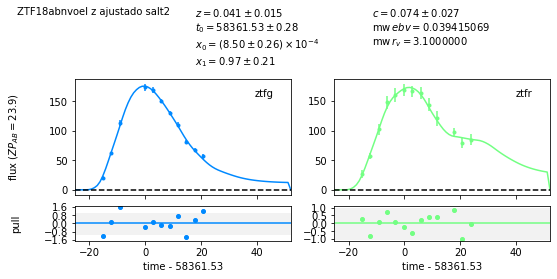

In [87]:
ajuste(lista_oid_SALT2_z_var_cortes_t[7], 'salt2', df_meta_early_SNIa, 
       table_early_SNIa_SALT2_z_var_cortes_t, version='2.4')[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT2_z_var_cortes_t[7])

 ==== Con ajuste del redshift ====
chisq/ndof :  0.6937781076434644


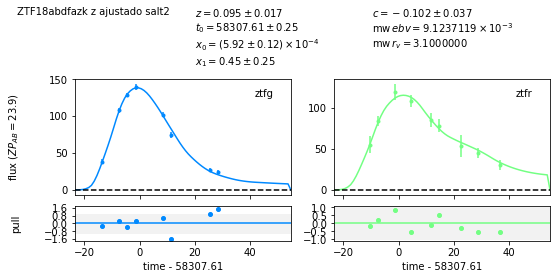

In [88]:
ajuste(lista_oid_SALT2_z_var_cortes_t[9], 'salt2', df_meta_early_SNIa, 
       table_early_SNIa_SALT2_z_var_cortes_t, version='2.4')[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT2_z_var_cortes_t[9])

 ==== Con ajuste del redshift ====
chisq/ndof :  1.1482001375805873


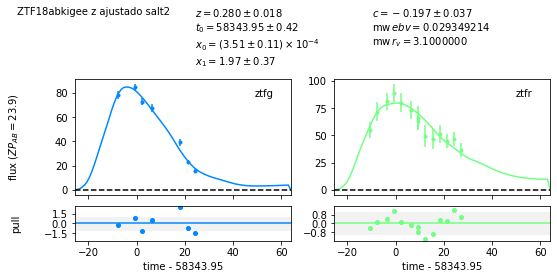

In [89]:
ajuste(lista_oid_SALT2_z_var_cortes_t[21], 'salt2', df_meta_early_SNIa, 
       table_early_SNIa_SALT2_z_var_cortes_t, version='2.4')[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT2_z_var_cortes_t[21])

 ==== Con ajuste del redshift ====
chisq/ndof :  1.2853089802036581


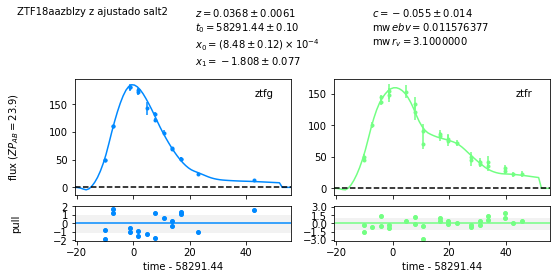

In [90]:
ajuste(lista_oid_SALT2_z_var_cortes_t[28], 'salt2', df_meta_early_SNIa, 
       table_early_SNIa_SALT2_z_var_cortes_t, version='2.4')[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT2_z_var_cortes_t[28])

 ==== Con ajuste del redshift ====
chisq/ndof :  1.7556636662258942


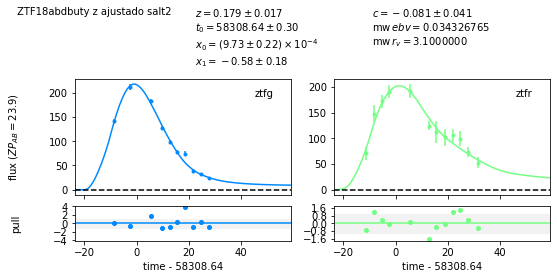

In [91]:
ajuste(lista_oid_SALT2_z_var_cortes_t[41], 'salt2', df_meta_early_SNIa, 
       table_early_SNIa_SALT2_z_var_cortes_t, version='2.4')[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT2_z_var_cortes_t[41])

Algunos gráficos de los ajustes de las SN que tienen valores de $\frac{\chi^{2}}{ndof}$ mayores a la mediana.

 ==== Con ajuste del redshift ====
chisq/ndof :  1.8159802318084


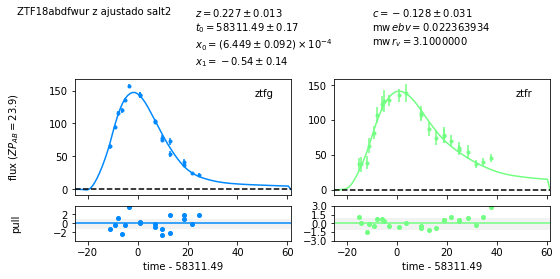

In [92]:
ajuste(lista_oid_SALT2_z_var_sobre_mediana_cortes_t[1], 'salt2', 
       df_meta_early_SNIa, table_early_SNIa_SALT2_z_var_cortes_t, 
       version='2.4')[0]
print('chisq/ndof : ', 
      df_chisq_vs_ndof_SALT2_z_var_sobre_mediana_cortes_t['chisq/ndof'][1])

 ==== Con ajuste del redshift ====
chisq/ndof :  1.8712673689842774


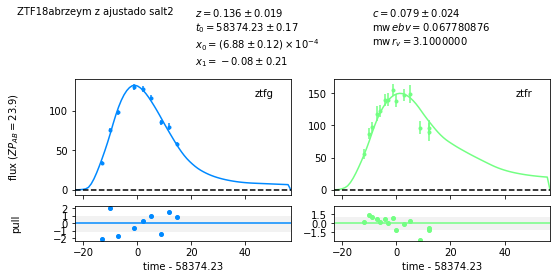

In [93]:
ajuste(lista_oid_SALT2_z_var_sobre_mediana_cortes_t[3], 'salt2', 
       df_meta_early_SNIa, table_early_SNIa_SALT2_z_var_cortes_t, 
       version='2.4')[0]
print('chisq/ndof : ', 
      df_chisq_vs_ndof_SALT2_z_var_sobre_mediana_cortes_t['chisq/ndof'][3])

 ==== Con ajuste del redshift ====
chisq/ndof :  2.219474000824213


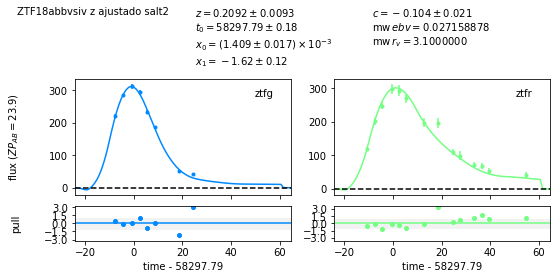

In [94]:
ajuste(lista_oid_SALT2_z_var_sobre_mediana_cortes_t[11], 'salt2', 
       df_meta_early_SNIa, table_early_SNIa_SALT2_z_var_cortes_t, 
       version='2.4')[0]
print('chisq/ndof : ', 
      df_chisq_vs_ndof_SALT2_z_var_sobre_mediana_cortes_t['chisq/ndof'][11])

 ==== Con ajuste del redshift ====
chisq/ndof :  3.9741603902957947


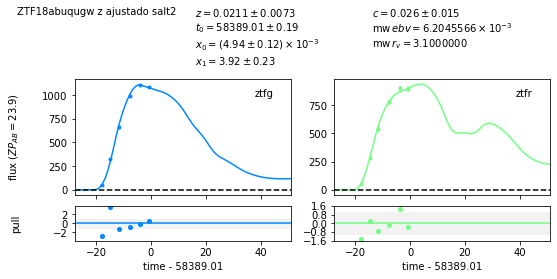

In [95]:
ajuste(lista_oid_SALT2_z_var_sobre_mediana_cortes_t[19], 'salt2', 
       df_meta_early_SNIa, table_early_SNIa_SALT2_z_var_cortes_t, 
       version='2.4')[0]
print('chisq/ndof : ', 
      df_chisq_vs_ndof_SALT2_z_var_sobre_mediana_cortes_t['chisq/ndof'][19])

 ==== Con ajuste del redshift ====
chisq/ndof :  4.014362040525008


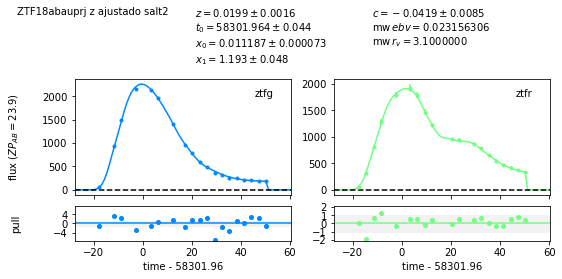

In [96]:
ajuste(lista_oid_SALT2_z_var_sobre_mediana_cortes_t[20], 'salt2', 
       df_meta_early_SNIa, table_early_SNIa_SALT2_z_var_cortes_t, 
       version='2.4')[0]
print('chisq/ndof : ', 
      df_chisq_vs_ndof_SALT2_z_var_sobre_mediana_cortes_t['chisq/ndof'][20])

 ==== Con ajuste del redshift ====
chisq/ndof :  6.679948614954342


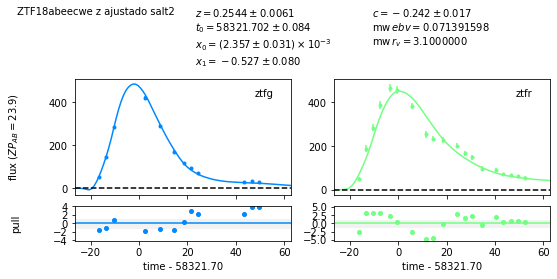

In [97]:
ajuste(lista_oid_SALT2_z_var_sobre_mediana_cortes_t[28], 'salt2', 
       df_meta_early_SNIa, table_early_SNIa_SALT2_z_var_cortes_t, 
       version='2.4')[0]
print('chisq/ndof : ', 
      df_chisq_vs_ndof_SALT2_z_var_sobre_mediana_cortes_t['chisq/ndof'][28])

 ==== Con ajuste del redshift ====
chisq/ndof :  18.248410722090494


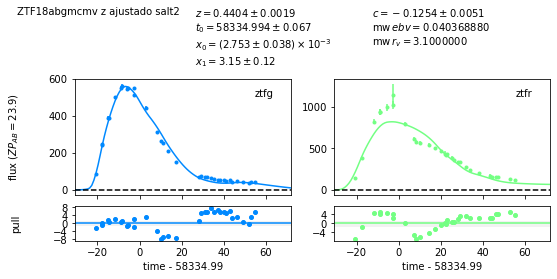

In [98]:
ajuste(lista_oid_SALT2_z_var_sobre_mediana_cortes_t[36], 'salt2', 
       df_meta_early_SNIa, table_early_SNIa_SALT2_z_var_cortes_t, 
       version='2.4')[0]
print('chisq/ndof : ', 
      df_chisq_vs_ndof_SALT2_z_var_sobre_mediana_cortes_t['chisq/ndof'][36])

 ==== Con ajuste del redshift ====
chisq/ndof :  27.379380335569625


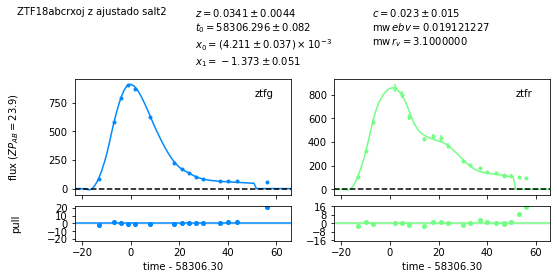

In [99]:
ajuste(lista_oid_SALT2_z_var_sobre_mediana_cortes_t[40], 'salt2', 
       df_meta_early_SNIa, table_early_SNIa_SALT2_z_var_cortes_t, 
       version='2.4')[0]
print('chisq/ndof : ', 
      df_chisq_vs_ndof_SALT2_z_var_sobre_mediana_cortes_t['chisq/ndof'][40])

Aquí vemos que aún hay observaciones que están fuera del rango del modelo pese a que se hayan descartados las observaciones fuera del rango del modelo del obtenido a partir de los parámetros $t_0$ y $z$ del primer ajuste. Esto se debe a que los parámetros $t_0$ y $z$ pueden cambiar al hacer un nuevo ajuste. En particular, si el $z$ obtenido en el segundo ajuste es menor que el del primer ajuste y/o el valor de $t_0$ cambia puede pasar que puntos que estaban dentro del rango de tiempo del modelo en el primer ajuste, ya no lo estén.

Por lo anterior, ahora se hará el ajuste considerando solo las observaciones que están dentro del rango del modelo, como si este estuviese en el sistema de referencia en reposo (en el cual $z=0$) y considerando como correcto el valor de $t_0$ del primer ajuste. 

## Ajuste con observaciones en el rango de tiempo del modelo como si estuviese en el sistema de referencia en reposo (determinado con $t_0$ del primer ajuste)

Como se vió anteriormente, los valores muy grandes de $\frac{\chi^{2}}{ndof}$ tenían que ver principalmente con observaciones que estaban fuera del rango de tiempo del modelo, por lo que ahora se analizarán los casos en que se ajustan solo las observaciones que están en una aproximación para el rango de tiempo del modelo que considera que las observaciones están hechas en el sistema de referencia en reposo de la SN ($z=0$). 

Nota:
- También se podría elegir un valor de $z_{min}$ y considerar que las SN tienen este valor de $z$ para descartar puntos fuera del rango de tiempo del modelo.

### Ajuste con redshift real 

Seleccionar las detecciones de las SN que están dentro del rango de tiempo del modelo según el primer ajuste de $t_0$ con el modelo SALT2 y $z=0$, pero utilizando el redshift real para el siguiente ajuste.

In [100]:
detect_early_SNIa_cortes_trest_SALT2_z_fijo = cortes_trest_modelo(trest_min_modelo,
                                                                  trest_max_modelo, 
                                                                  detect_early_SNIa,
                                                                  estadisticas_SALT2_z_fijo)

Ajustes con las detecciones de las SN que están dentro del rango de tiempo del modelo, determinado con $z=0$ y $t_0$ del primer ajuste

In [101]:
ajustes_SALT2_z_fijo_early_SNIa_cortes_trest = modelo_ajustado_y_resultados('salt2', 
                                                                            df_meta_early_SNIa, 
                                                                            detect_early_SNIa_cortes_trest_SALT2_z_fijo, 
                                                                            version='2.4', 
                                                                            z_real=True,
                                                                            print_ind_and_oid=False)

rango ncall : 82, 162
promedio ncall : 107.77380952380952
desviación estándar ncall : 14.469468011476698
mediana ncall : 102.0


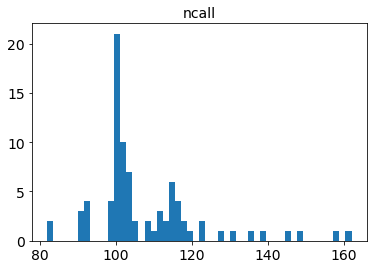

rango chisq : 1.2351738712913127, 786.9259414840894
promedio chisq : 65.54304448281327
desviación estándar chisq : 113.47447713586642
mediana chisq : 32.8457870167547


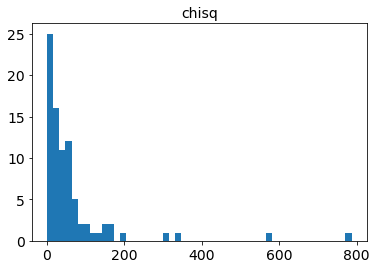

rango ndof : 4, 58
promedio ndof : 21.428571428571427
desviación estándar ndof : 11.543175384580435
mediana ndof : 18.0


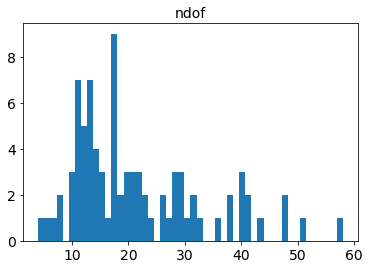

rango chisq/ndof : 0.3087934678228282, 20.296988357874742
promedio chisq/ndof : 2.848410645447402
desviación estándar chisq/ndof : 3.885357542246007
mediana chisq/ndof : 1.4956640308705555


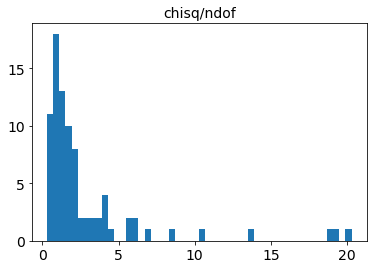

rango z : 0.0181, 0.14
promedio z : 0.07072857142857143
desviación estándar z : 0.026406531350391015
mediana z : 0.07135


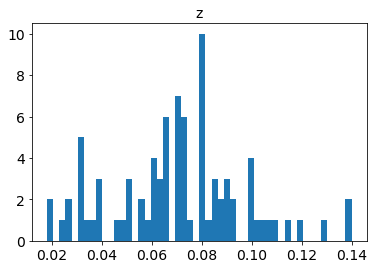

rango t0 : 58254.66089235649, 58395.614080229265
promedio t0 : 58319.86999185645
desviación estándar t0 : 38.7853244168552
mediana t0 : 58313.91860414081


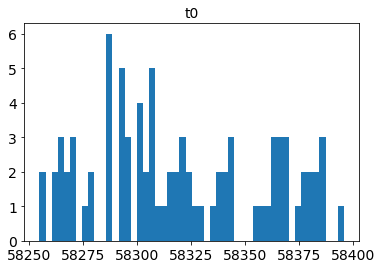

rango t0_err : 0.009948143877409166, 1.3873362933736644
promedio t0_err : 0.17663140934122826
desviación estándar t0_err : 0.20460738310501644
mediana t0_err : 0.12506301414396148


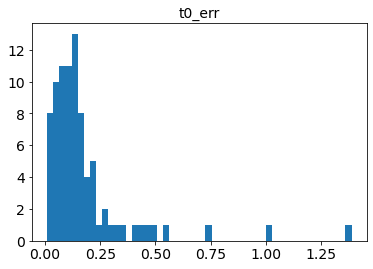

rango x0 : 0.00022820032888927092, 0.011095939060549339
promedio x0 : 0.0013610018295733637
desviación estándar x0 : 0.001793096744594615
mediana x0 : 0.000714731294387839


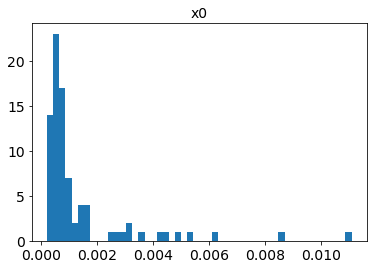

rango x0_err : 4.196005541534452e-06, 6.411129651324512e-05
promedio x0_err : 1.3833815884551703e-05
desviación estándar x0_err : 1.0212018999770366e-05
mediana x0_err : 1.0203399832522604e-05


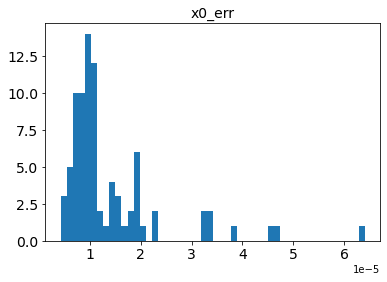

rango x1 : -2.164972393918284, 2.2803275812749906
promedio x1 : 0.09159824489333387
desviación estándar x1 : 1.0661003713393356
mediana x1 : 0.3144911959931642


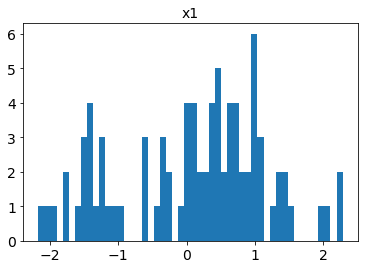

rango x1_err : 0.015615974080204131, 1.9865726930377352
promedio x1_err : 0.22548833481558894
desviación estándar x1_err : 0.27175078823737675
mediana x1_err : 0.15449404475441758


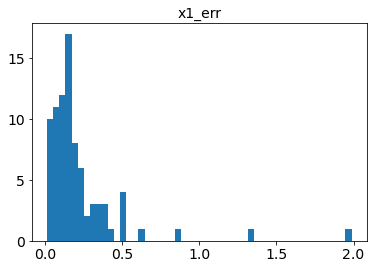

rango c : -0.17831176078141425, 0.6147510196896453
promedio c : 0.00915986721297978
desviación estándar c : 0.1160702615926447
mediana c : -0.005260231716384347


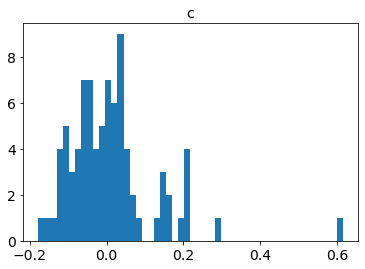

rango c_err : 0.0020599817010846346, 0.11904093410016503
promedio c_err : 0.024599538899879456
desviación estándar c_err : 0.015954094978892434
mediana c_err : 0.021516050038536627


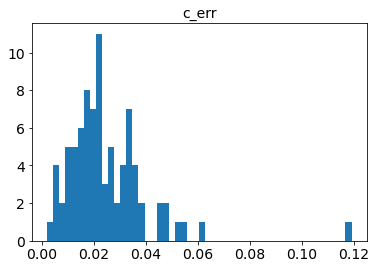

rango mwebv : 0.006204556550167132, 0.1144183424611353
promedio mwebv : 0.03064786661830939
desviación estándar mwebv : 0.02142708623940601
mediana mwebv : 0.02451353213255834


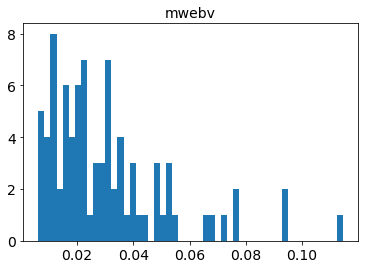

In [102]:
histogramas_estadisticas_resultados(ajustes_SALT2_z_fijo_early_SNIa_cortes_trest, 
                                    z_real=True)

Estadísticas de los ajustes, ordenados por valor de chisq/ndof

In [103]:
estadisticas_SALT2_z_fijo_cortes_trest = estadisticas_resultados(ajustes_SALT2_z_fijo_early_SNIa_cortes_trest, 
                                                                 z_real=True).sort_values(by=['chisq/ndof'])

Listas de los oid y de los valores de chisq/ndof del ajuste con con el modelo SALT2 y redshift real, utilizando los puntos que pertenecen al rango de tiempo del modelo (determinado con los valores de $t_0$ del primer ajuste y $z=0$), ordenados según el valor de chisq/ndof

In [104]:
lista_oid_SALT2_z_fijo_cortes_trest = list(estadisticas_SALT2_z_fijo_cortes_trest['oid'])
lista_chisq_vs_ndof_SALT2_z_fijo_cortes_trest = list(estadisticas_SALT2_z_fijo_cortes_trest['chisq/ndof'])

Filas de los resultados del ajuste con chisq/ndof sobre la 
mediana 

In [105]:
median_chisq_vs_ndof_SALT2_z_fijo_cortes_trest = np.median(np.array(estadisticas_SALT2_z_fijo_cortes_trest['chisq/ndof']))
df_chisq_vs_ndof_SALT2_z_fijo_sobre_mediana_cortes_trest = estadisticas_SALT2_z_fijo_cortes_trest[estadisticas_SALT2_z_fijo_cortes_trest['chisq/ndof'] > median_chisq_vs_ndof_SALT2_z_fijo_cortes_trest].reset_index()
lista_oid_SALT2_z_fijo_sobre_mediana_cortes_trest = list(df_chisq_vs_ndof_SALT2_z_fijo_sobre_mediana_cortes_trest['oid'])

Mostrar algunas columnas de los resultados del ajuste, con valores de chisq/ndof sobre la mediana

In [106]:
display(df_chisq_vs_ndof_SALT2_z_fijo_sobre_mediana_cortes_trest[['oid', 
                                                                  'chisq/ndof', 
                                                                  'z', 
                                                                  't0', 
                                                                  't0_err']])

oid  chisq/ndof       z            t0    t0_err
0   ZTF18abckujg    1.561183  0.0740  58303.340122  0.146650
1   ZTF18abtnlik    1.564569  0.0900  58379.085173  0.151260
2   ZTF18aazblzy    1.579057  0.0653  58291.799175  0.049163
3   ZTF18abdkimx    1.587939  0.0800  58313.849572  0.112693
4   ZTF18abpamut    1.588199  0.0720  58367.663093  0.148358
5   ZTF18abclalx    1.610255  0.1000  58301.101550  0.182075
6   ZTF18abdbuty    1.675277  0.0600  58308.087150  0.125924
7   ZTF18aaxwjmp    1.677559  0.0800  58288.346748  0.079886
8   ZTF18abjvhec    1.708779  0.0570  58340.363787  0.100591
9   ZTF18aaxrvzj    1.824913  0.1100  58286.100037  0.154429
10  ZTF18abealop    1.929016  0.0666  58316.249790  0.192941
11  ZTF18abcrxoj    1.955691  0.0309  58306.248516  0.051181
12  ZTF18aaxqyki    1.982013  0.1003  58286.485350  0.127086
13  ZTF18abcflnz    1.996004  0.0273  58306.289429  0.041488
14  ZTF18abkifng    2.051978  0.0880  58343.578987  0.174145
15  ZTF18abdefet    2.058725  0.0700  58307.570275  0.226503
16  ZTF18abetewu    2.101013  0.0740  58318.777906  0.191203
17  ZTF18abgmcmv    2.169733  0.0185  58328.827647  0.050000
18  ZTF18aayjvve    2.664843  0.0474  58292.022943  0.061268
19  ZTF18aaumlfl    2.689409  0.0874  58265.834613  0.127528
20  ZTF18abbvsiv    3.038040  0.0510  58296.789343  0.089445
21  ZTF18aaytovs    3.044425  0.0746  58294.398873  0.092323
22  ZTF18abfhryc    3.191147  0.0323  58324.132423  0.062726
23  ZTF18aaunfqq    3.205966  0.0711  58268.627918  0.095477
24  ZTF18aazcoob    3.714843  0.0845  58294.347854  0.143362
25  ZTF18aavrwhu    3.736760  0.0620  58275.843487  0.067800
26  ZTF18aavrzxp    4.025645  0.0700  58270.401986  0.094260
27  ZTF18abetehf    4.149279  0.0649  58318.472003  0.097851
28  ZTF18abauprj    4.278638  0.0242  58302.060574  0.025249
29  ZTF18aauocnw    4.286056  0.1000  58269.134214  0.096280
30  ZTF18aaqqoqs    4.373706  0.0800  58262.583571  0.059107
31  ZTF18aatzygk    5.685808  0.0740  58262.263826  0.124202
32  ZTF18aaqffyp    5.886144  0.0640  58254.660892  0.063096
33  ZTF18aaxcntm    5.970880  0.0269  58279.052300  0.025982
34  ZTF18aaumeys    6.179594  0.0365  58267.258778  0.029081
35  ZTF18aaxsioa    6.898051  0.0315  58286.115509  0.025509
36  ZTF18aaxdrjn    8.359438  0.0340  58279.018955  0.025477
37  ZTF18aawjywv   10.414714  0.0400  58271.371162  0.055793
38  ZTF18aaslhxt   13.567689  0.0509  58263.631667  0.023829
39  ZTF18aaqcqvr   18.741311  0.0716  58256.517423  0.061002
40  ZTF18abuqugw   19.116075  0.0313  58384.370995  0.091862
41  ZTF18aasdted   20.296988  0.0181  58265.285232  0.009948

Intersección de los oid de las SN con valores de chisq/ndof mayores a la mediana de los ajustes con SALT2 y $z_{real}$  antes y después de eliminar los puntos fuera del rango de tiempo del modelo en trest

In [107]:
inter_oid_SALT2_z_fijo_sobre_mediana_cortes_trest = np.intersect1d(np.array(lista_oid_SALT2_z_fijo_sobre_mediana),
                                                                   np.array(lista_oid_SALT2_z_fijo_sobre_mediana_cortes_trest))
print('Elementos comunes sobre la mediana de chisq/ndof : ',len(inter_oid_SALT2_z_fijo_sobre_mediana_cortes_trest))

Elementos comunes sobre la mediana de chisq/ndof :  39


Tabla de astropy con las detecciones que están en el rango de tiempo del modelo, en el formato que requiere sncosmo para hacer los ajustes 

In [108]:
table_early_SNIa_SALT2_z_fijo_cortes_trest = astropy_table_detections(df_meta_early_SNIa, 
                                                                     detect_early_SNIa_cortes_trest_SALT2_z_fijo)

Algunos gráficos de los ajustes de las SN que tienen valores de $\frac{\chi^{2}}{ndof}$ menores a la mediana.

 ===== Ajuste con redshift real ====
chisq/ndof :  0.44236796253013444


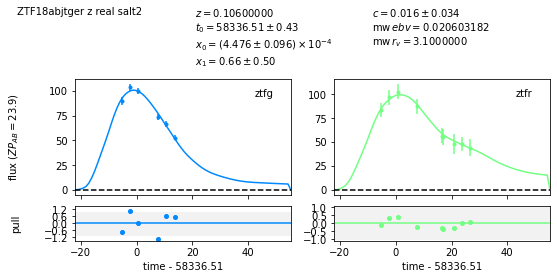

In [109]:
ajuste(lista_oid_SALT2_z_fijo_cortes_trest[1], 'salt2', df_meta_early_SNIa, 
       table_early_SNIa_SALT2_z_fijo_cortes_trest, version='2.4', z_real=True)[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT2_z_fijo_cortes_trest[1])

 ===== Ajuste con redshift real ====
chisq/ndof :  0.6666883475318054


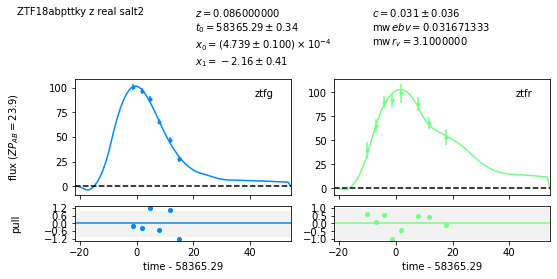

In [110]:
ajuste(lista_oid_SALT2_z_fijo_cortes_trest[6], 'salt2', df_meta_early_SNIa, 
       table_early_SNIa_SALT2_z_fijo_cortes_trest, version='2.4', z_real=True)[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT2_z_fijo_cortes_trest[6])

 ===== Ajuste con redshift real ====
chisq/ndof :  0.8321587841857431


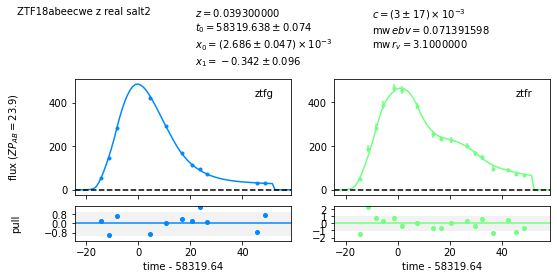

In [111]:
ajuste(lista_oid_SALT2_z_fijo_cortes_trest[16], 'salt2', df_meta_early_SNIa, 
       table_early_SNIa_SALT2_z_fijo_cortes_trest, version='2.4', z_real=True)[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT2_z_fijo_cortes_trest[16])

 ===== Ajuste con redshift real ====
chisq/ndof :  0.8885482367528331


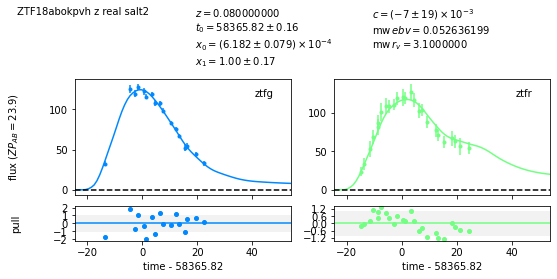

In [112]:
ajuste(lista_oid_SALT2_z_fijo_cortes_trest[19], 'salt2', df_meta_early_SNIa, 
       table_early_SNIa_SALT2_z_fijo_cortes_trest, version='2.4', z_real=True)[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT2_z_fijo_cortes_trest[19])

 ===== Ajuste con redshift real ====
chisq/ndof :  1.1175309016906863


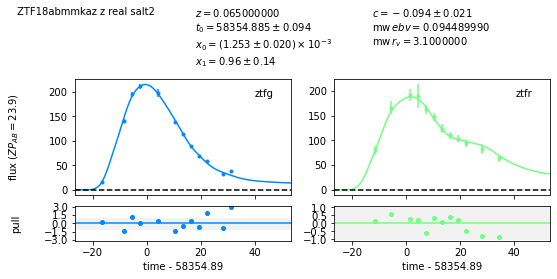

In [113]:
ajuste(lista_oid_SALT2_z_fijo_cortes_trest[29], 'salt2', df_meta_early_SNIa, 
       table_early_SNIa_SALT2_z_fijo_cortes_trest, version='2.4', z_real=True)[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT2_z_fijo_cortes_trest[29])

 ===== Ajuste con redshift real ====
chisq/ndof :  1.2055754864205708


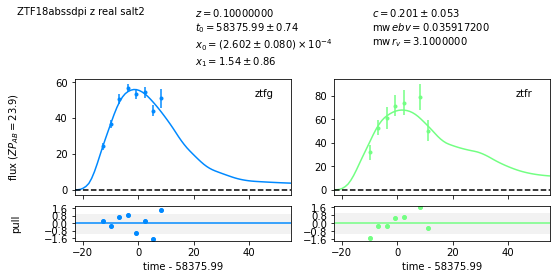

In [114]:
ajuste(lista_oid_SALT2_z_fijo_cortes_trest[32], 'salt2', df_meta_early_SNIa, 
       table_early_SNIa_SALT2_z_fijo_cortes_trest, version='2.4', z_real=True)[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT2_z_fijo_cortes_trest[32])

 ===== Ajuste con redshift real ====
chisq/ndof :  1.416398910085873


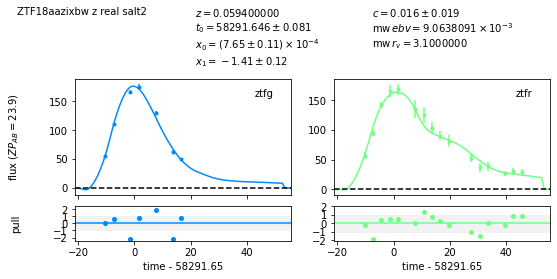

In [115]:
ajuste(lista_oid_SALT2_z_fijo_cortes_trest[40], 'salt2', df_meta_early_SNIa, 
       table_early_SNIa_SALT2_z_fijo_cortes_trest, version='2.4', z_real=True)[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT2_z_fijo_cortes_trest[40])

 ===== Ajuste con redshift real ====
chisq/ndof :  1.430145069722101


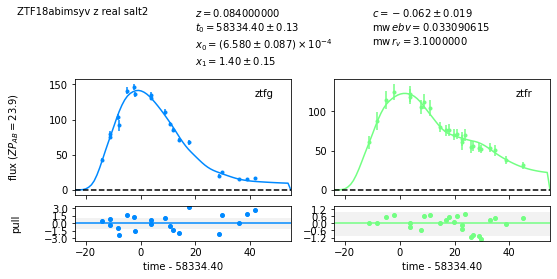

In [116]:
ajuste(lista_oid_SALT2_z_fijo_cortes_trest[41], 'salt2', df_meta_early_SNIa, 
       table_early_SNIa_SALT2_z_fijo_cortes_trest, version='2.4', z_real=True)[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT2_z_fijo_cortes_trest[41])

Algunos gráficos de los ajustes de las SN que tienen valores de $\frac{\chi^{2}}{ndof}$ mayores a la mediana.

 ===== Ajuste con redshift real ====
chisq/ndof :  1.6752772015673179


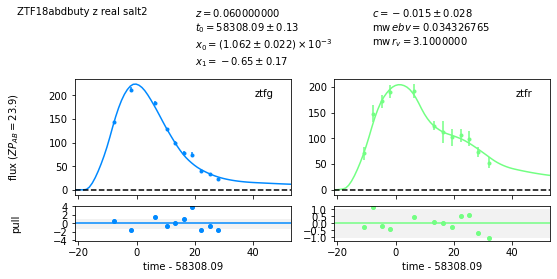

In [117]:
ajuste(lista_oid_SALT2_z_fijo_sobre_mediana_cortes_trest[6], 'salt2', 
       df_meta_early_SNIa, table_early_SNIa_SALT2_z_fijo_cortes_trest, 
       version='2.4', z_real=True)[0]
print('chisq/ndof : ', 
      df_chisq_vs_ndof_SALT2_z_fijo_sobre_mediana_cortes_trest['chisq/ndof'][6])

 ===== Ajuste con redshift real ====
chisq/ndof :  1.9960044165670108


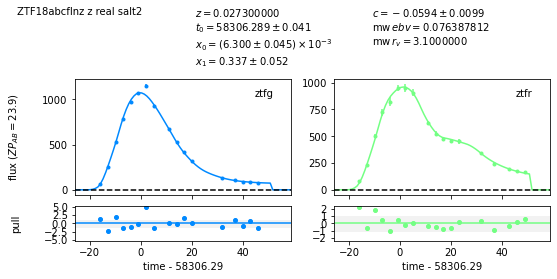

In [118]:
ajuste(lista_oid_SALT2_z_fijo_sobre_mediana_cortes_trest[13], 'salt2', 
       df_meta_early_SNIa, table_early_SNIa_SALT2_z_fijo_cortes_trest, 
       version='2.4', z_real=True)[0]
print('chisq/ndof : ', 
      df_chisq_vs_ndof_SALT2_z_fijo_sobre_mediana_cortes_trest['chisq/ndof'][13])

 ===== Ajuste con redshift real ====
chisq/ndof :  3.0380397848592358


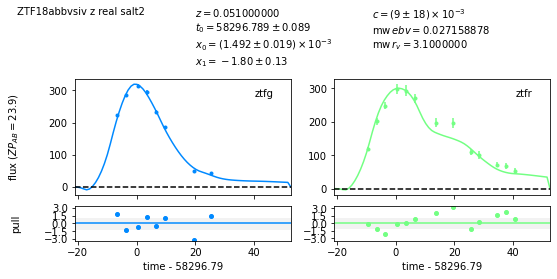

In [119]:
ajuste(lista_oid_SALT2_z_fijo_sobre_mediana_cortes_trest[20], 'salt2', 
       df_meta_early_SNIa, table_early_SNIa_SALT2_z_fijo_cortes_trest, 
       version='2.4', z_real=True)[0]
print('chisq/ndof : ', 
      df_chisq_vs_ndof_SALT2_z_fijo_sobre_mediana_cortes_trest['chisq/ndof'][20])

 ===== Ajuste con redshift real ====
chisq/ndof :  3.205966362146047


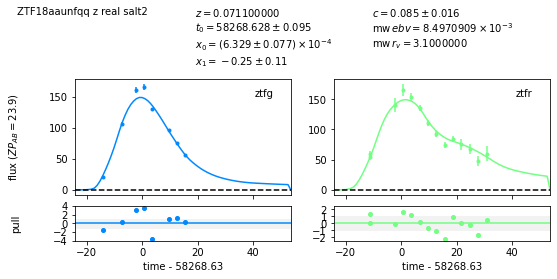

In [120]:
ajuste(lista_oid_SALT2_z_fijo_sobre_mediana_cortes_trest[23], 'salt2', 
       df_meta_early_SNIa, table_early_SNIa_SALT2_z_fijo_cortes_trest, 
       version='2.4', z_real=True)[0]
print('chisq/ndof : ', 
      df_chisq_vs_ndof_SALT2_z_fijo_sobre_mediana_cortes_trest['chisq/ndof'][23])

 ===== Ajuste con redshift real ====
chisq/ndof :  5.685807886884724


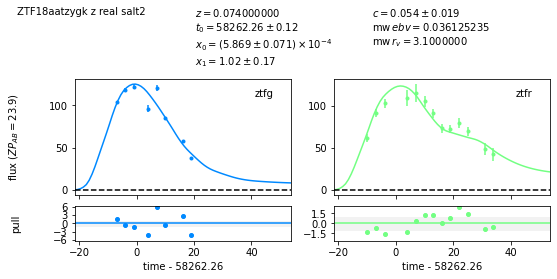

In [121]:
ajuste(lista_oid_SALT2_z_fijo_sobre_mediana_cortes_trest[31], 'salt2', 
       df_meta_early_SNIa, table_early_SNIa_SALT2_z_fijo_cortes_trest, 
       version='2.4', z_real=True)[0]
print('chisq/ndof : ', 
      df_chisq_vs_ndof_SALT2_z_fijo_sobre_mediana_cortes_trest['chisq/ndof'][31])

 ===== Ajuste con redshift real ====
chisq/ndof :  13.567688646277404


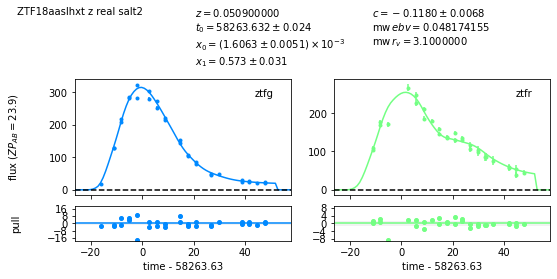

In [122]:
ajuste(lista_oid_SALT2_z_fijo_sobre_mediana_cortes_trest[38], 'salt2', 
       df_meta_early_SNIa, table_early_SNIa_SALT2_z_fijo_cortes_trest, 
       version='2.4', z_real=True)[0]
print('chisq/ndof : ', 
      df_chisq_vs_ndof_SALT2_z_fijo_sobre_mediana_cortes_trest['chisq/ndof'][38])

 ===== Ajuste con redshift real ====
chisq/ndof :  19.116075103470454


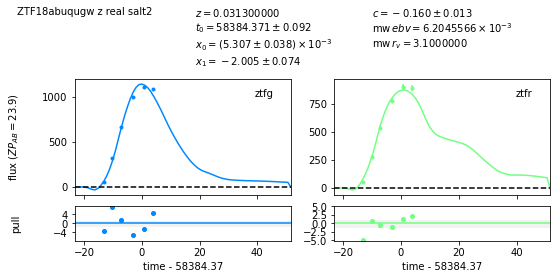

In [123]:
ajuste(lista_oid_SALT2_z_fijo_sobre_mediana_cortes_trest[40], 'salt2', 
       df_meta_early_SNIa, table_early_SNIa_SALT2_z_fijo_cortes_trest, 
       version='2.4', z_real=True)[0]
print('chisq/ndof : ', 
      df_chisq_vs_ndof_SALT2_z_fijo_sobre_mediana_cortes_trest['chisq/ndof'][40])

 ===== Ajuste con redshift real ====
chisq/ndof :  20.296988357874742


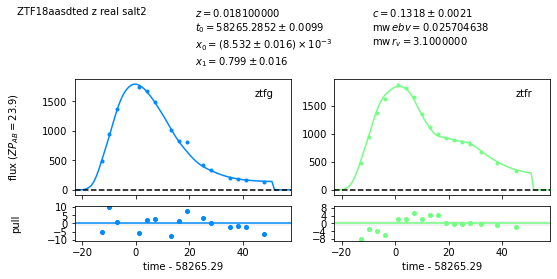

In [124]:
ajuste(lista_oid_SALT2_z_fijo_sobre_mediana_cortes_trest[41], 'salt2', 
       df_meta_early_SNIa, table_early_SNIa_SALT2_z_fijo_cortes_trest, 
       version='2.4', z_real=True)[0]
print('chisq/ndof : ', 
      df_chisq_vs_ndof_SALT2_z_fijo_sobre_mediana_cortes_trest['chisq/ndof'][41])

### Ajuste con redshift variable

Seleccionar las detecciones de las SN que están dentro del rango de tiempo del modelo según el valor de $t_0$ del primer ajuste con el modelo SALT2 $z=0$, donde el siguiente ajuste se realizará con redshift variable

In [125]:
detect_early_SNIa_cortes_trest_SALT2_z_var = cortes_trest_modelo(trest_min_modelo,
                                                                 trest_max_modelo, 
                                                                 detect_early_SNIa,
                                                                 estadisticas_SALT2_z_var)

Ajustes con las detecciones de las SN que están dentro del rango de tiempo del modelo, determinado con $z=0$ y $t_0$ del primer ajuste

In [126]:
ajustes_SALT2_early_SNIa_cortes_trest = modelo_ajustado_y_resultados('salt2', 
                                                                     df_meta_early_SNIa, 
                                                                     detect_early_SNIa_cortes_trest_SALT2_z_var, 
                                                                     version='2.4',
                                                                     print_ind_and_oid=False)

rango ncall : 152, 1184
promedio ncall : 325.8333333333333
desviación estándar ncall : 156.6641717126564
mediana ncall : 277.0


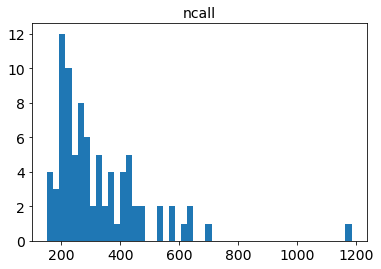

rango chisq : 1.272570386239837, 941.7936635009944
promedio chisq : 92.66709892046413
desviación estándar chisq : 170.65834457542903
mediana chisq : 31.472019545458128


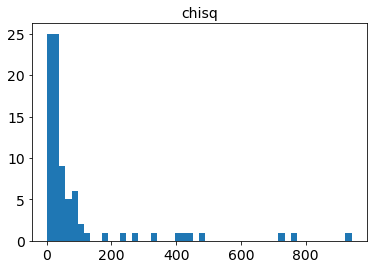

rango ndof : 3, 57
promedio ndof : 20.571428571428573
desviación estándar ndof : 11.748642995890972
mediana ndof : 17.0


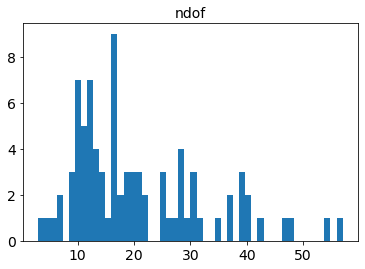

rango chisq/ndof : 0.4241901287466123, 24.238260655889075
promedio chisq/ndof : 3.6587053493261834
desviación estándar chisq/ndof : 4.894957571084628
mediana chisq/ndof : 1.745778100850726


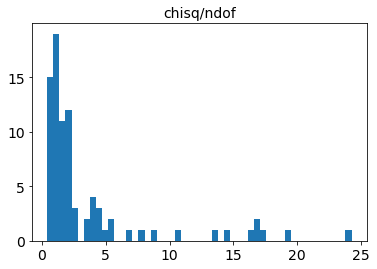

rango z : 0.0010000004500293118, 0.4464162651526625
promedio z : 0.16784366964631223
desviación estándar z : 0.10313652972924585
mediana z : 0.15510544614618324


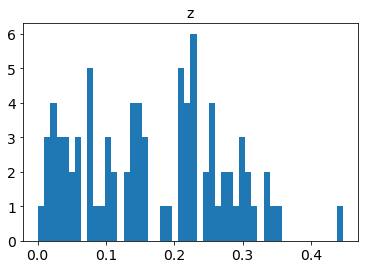

rango z_err : 1.2479866098868975e-10, 0.1661183133954589
promedio z_err : 0.019577141160914417
desviación estándar z_err : 0.02103957077688398
mediana z_err : 0.014677616024827707


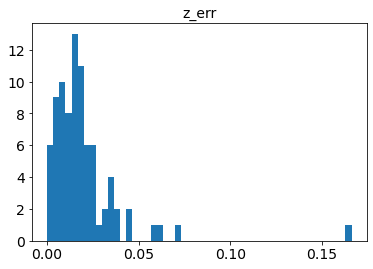

rango t0 : 58257.01493998718, 58396.5690826532
promedio t0 : 58320.774910967986
desviación estándar t0 : 38.8877938359881
mediana t0 : 58314.61047213344


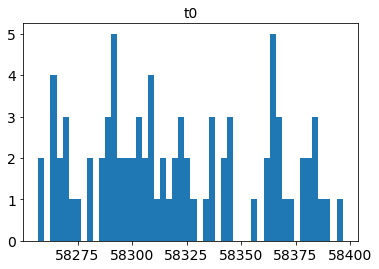

rango t0_err : 2.816998676280491e-05, 1.9826998928328976
promedio t0_err : 0.2869498554204949
desviación estándar t0_err : 0.3094532002910986
mediana t0_err : 0.1978138976955961


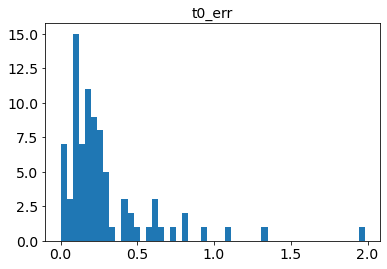

rango x0 : 0.00021593183581902124, 0.011206030560162445
promedio x0 : 0.001311650181361084
desviación estándar x0 : 0.0017466573297740989
mediana x0 : 0.0006647521601681382


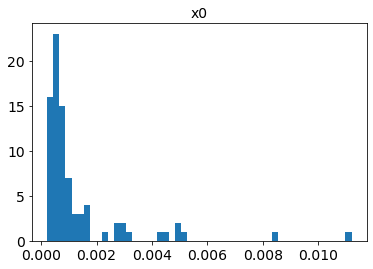

rango x0_err : 5.4301043387187246e-06, 0.00011701876278161326
promedio x0_err : 1.9346181061165038e-05
desviación estándar x0_err : 1.6241456631180034e-05
mediana x0_err : 1.3016144205711878e-05


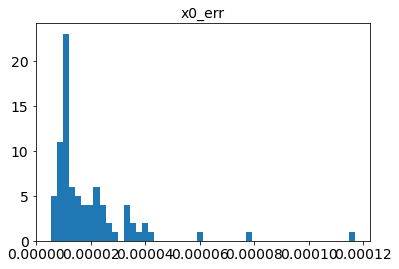

rango x1 : -2.305271444535058, 3.9168637014464673
promedio x1 : 0.12585964276353587
desviación estándar x1 : 1.1951229603144398
mediana x1 : 0.27221014887842987


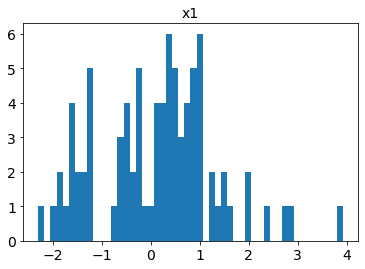

rango x1_err : 0.018290688646695585, 1.7233964727009694
promedio x1_err : 0.24839175256923907
desviación estándar x1_err : 0.274488310972588
mediana x1_err : 0.17460502541252065


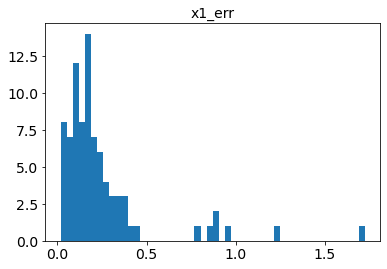

rango c : -0.34573583205279895, 0.2909049500748452
promedio c : -0.09544853304010655
desviación estándar c : 0.13283253595329833
mediana c : -0.09787403368210532


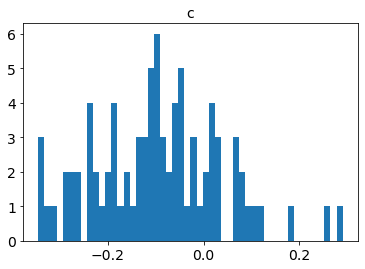

rango c_err : 0.002216417209866872, 0.2035663010874139
promedio c_err : 0.03604536326201346
desviación estándar c_err : 0.0321670998565752
mediana c_err : 0.029508543599356715


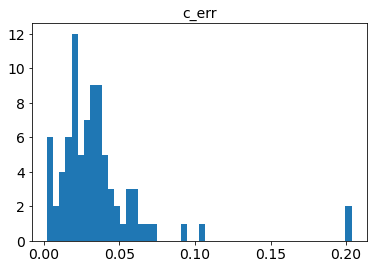

rango mwebv : 0.006204556550167132, 0.1144183424611353
promedio mwebv : 0.03064786661830939
desviación estándar mwebv : 0.02142708623940601
mediana mwebv : 0.02451353213255834


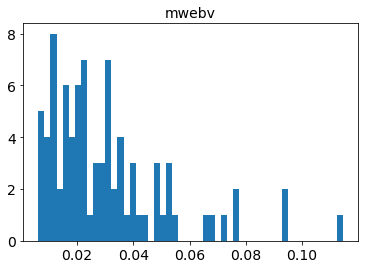

In [127]:
histogramas_estadisticas_resultados(ajustes_SALT2_early_SNIa_cortes_trest)

Estadísticas de los ajustes, ordenados por valor de chisq/ndof

In [128]:
estadisticas_SALT2_z_var_cortes_trest = estadisticas_resultados(ajustes_SALT2_early_SNIa_cortes_trest).sort_values(by=['chisq/ndof'])

Listas de los oid y de los valores de chisq/ndof del ajuste con con el modelo SALT2 y redshift variable, utilizando los puntos que pertenecen al rango de tiempo del modelo (determinado con los valores de $t_0$ del primer ajuste y $z=0$), ordenados según el valor de chisq/ndof

In [129]:
lista_oid_SALT2_z_var_cortes_trest = list(estadisticas_SALT2_z_var_cortes_trest['oid'])
lista_chisq_vs_ndof_SALT2_z_var_cortes_trest = list(estadisticas_SALT2_z_var_cortes_trest['chisq/ndof'])

Filas de los resultados del ajuste con chisq/ndof sobre la 
mediana 

In [130]:
median_chisq_vs_ndof_SALT2_z_var_cortes_trest = np.median(np.array(estadisticas_SALT2_z_var_cortes_trest['chisq/ndof']))
df_chisq_vs_ndof_SALT2_z_var_sobre_mediana_cortes_trest = estadisticas_SALT2_z_var_cortes_trest[estadisticas_SALT2_z_var_cortes_trest['chisq/ndof'] > median_chisq_vs_ndof_SALT2_z_var_cortes_trest].reset_index()
lista_oid_SALT2_z_var_sobre_mediana_cortes_trest = list(df_chisq_vs_ndof_SALT2_z_var_sobre_mediana_cortes_trest['oid'])

Mostrar algunas columnas de los resultados del ajuste, con valores de chisq/ndof sobre la mediana

In [131]:
display(df_chisq_vs_ndof_SALT2_z_var_sobre_mediana_cortes_trest[['oid', 
                                                                 'chisq/ndof', 
                                                                 'z', 
                                                                 'z_err', 
                                                                 't0', 
                                                                 't0_err']])

oid  chisq/ndof         z         z_err            t0    t0_err
0   ZTF18abdbuty    1.755664  0.179398  1.680274e-02  58308.635290  0.298514
1   ZTF18abfgygp    1.772677  0.226013  7.145235e-03  58323.517629  0.100453
2   ZTF18abdfwur    1.815980  0.227314  1.285829e-02  58311.487508  0.167697
3   ZTF18abealop    1.864397  0.001000  1.404756e-02  58315.390314  0.198186
4   ZTF18abrzeym    1.871267  0.136248  1.885541e-02  58374.232011  0.171011
5   ZTF18aaxrvzj    1.873503  0.220224  1.802760e-02  58287.226885  0.206125
6   ZTF18absdgon    1.941578  0.254116  2.501496e-02  58377.339180  0.201737
7   ZTF18abcrxoj    2.004514  0.034167  4.260207e-03  58306.296736  0.080730
8   ZTF18abimsyv    2.021273  0.230718  1.345244e-02  58336.099961  0.183273
9   ZTF18abkifng    2.029426  0.153458  3.302331e-02  58344.007614  0.222102
10  ZTF18aaxqyki    2.099737  0.106999  3.351543e-02  58286.567151  0.438536
11  ZTF18aaxwjmp    2.172378  0.335645  1.470137e-02  58290.774825  0.238167
12  ZTF18abbvsiv    2.264678  0.209171  9.101725e-03  58297.782231  0.175318
13  ZTF18abdefet    2.275477  0.156753  2.218336e-02  58307.907156  0.243747
14  ZTF18abetewu    2.291251  0.075788  2.082968e-02  58318.782157  0.197442
15  ZTF18abcsgvj    2.371042  0.346115  1.458496e-02  58305.896496  0.160112
16  ZTF18aayjvve    2.480381  0.102159  8.230208e-03  58292.383340  0.098937
17  ZTF18abfhryc    2.583395  0.023599  1.247987e-10  58324.004398  0.000028
18  ZTF18aazcoob    3.654664  0.269479  1.346382e-02  58296.259932  0.209550
19  ZTF18aansqun    3.753205  0.310186  1.746300e-02  58317.273587  0.613566
20  ZTF18aavrwhu    3.840132  0.080349  1.004254e-02  58275.916903  0.081428
21  ZTF18abuqugw    3.974160  0.021136  7.279315e-03  58389.014283  0.192045
22  ZTF18aavrzxp    4.093315  0.050553  7.629041e-03  58270.237254  0.146567
23  ZTF18abauprj    4.231567  0.019189  2.061795e-03  58301.948778  0.052961
24  ZTF18abetehf    4.291855  0.244272  1.177155e-02  58319.992073  0.153885
25  ZTF18aauocnw    4.429584  0.157710  1.614965e-02  58269.293561  0.117552
26  ZTF18aaytovs    4.564118  0.225866  7.191508e-03  58295.966316  0.097280
27  ZTF18aaqqoqs    4.818820  0.244070  7.953352e-03  58264.171541  0.084957
28  ZTF18aatzygk    5.517762  0.207949  1.200381e-02  58263.365483  0.223090
29  ZTF18aaunfqq    5.549376  0.301268  1.456846e-02  58270.577144  0.217967
30  ZTF18abeecwe    6.940864  0.254834  7.600094e-03  58321.703231  0.087144
31  ZTF18aaxdrjn    7.722644  0.133699  3.721334e-03  58279.693294  0.029454
32  ZTF18aaqffyp    8.845976  0.348966  8.337316e-03  58257.435745  0.138198
33  ZTF18aawjywv   10.760883  0.189886  5.716316e-03  58272.300693  0.105955
34  ZTF18aaslhxt   13.311372  0.081648  4.069229e-03  58263.804443  0.033553
35  ZTF18abcflnz   14.445752  0.221382  5.159245e-03  58308.473889  0.064107
36  ZTF18aaxcntm   16.152312  0.141999  2.886871e-03  58279.732328  0.029172
37  ZTF18aaumeys   16.775425  0.148923  3.759674e-03  58267.773316  0.031104
38  ZTF18aasdted   16.857810  0.027213  9.547257e-04  58265.452961  0.020373
39  ZTF18abgmcmv   17.440623  0.446416  2.035556e-03  58334.617030  0.081524
40  ZTF18aaqcqvr   19.062615  0.150800  1.152795e-02  58257.014940  0.065514
41  ZTF18aaxsioa   24.238261  0.281158  2.710815e-03  58288.377812  0.036663

Tabla de astropy con las detecciones que están en el rango de tiempo del modelo, en el formato que requiere sncosmo para hacer los ajustes 

In [132]:
table_early_SNIa_SALT2_z_var_cortes_trest = astropy_table_detections(df_meta_early_SNIa, 
                                                                      detect_early_SNIa_cortes_trest_SALT2_z_var)

Algunos gráficos de los ajustes de las SN que tienen valores de $\frac{\chi^{2}}{ndof}$ menores a la mediana.

 ==== Con ajuste del redshift ====
chisq/ndof :  0.4241901287466123


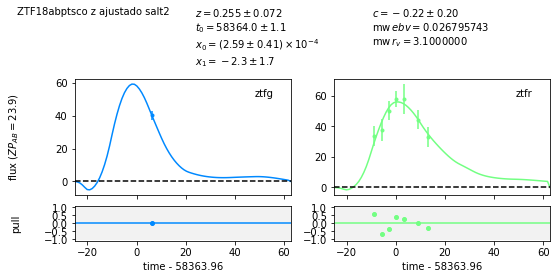

In [133]:
ajuste(lista_oid_SALT2_z_var_cortes_trest[0], 'salt2', df_meta_early_SNIa, 
       table_early_SNIa_SALT2_z_var_cortes_trest, version='2.4')[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT2_z_var_cortes_trest[0])

 ==== Con ajuste del redshift ====
chisq/ndof :  0.5551697749497996


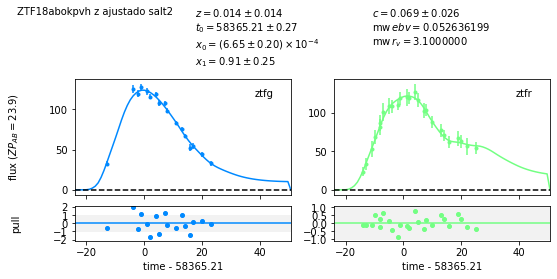

In [134]:
ajuste(lista_oid_SALT2_z_var_cortes_trest[2], 'salt2', df_meta_early_SNIa, 
       table_early_SNIa_SALT2_z_var_cortes_trest, version='2.4')[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT2_z_var_cortes_trest[2])

 ==== Con ajuste del redshift ====
chisq/ndof :  0.6937781076434644


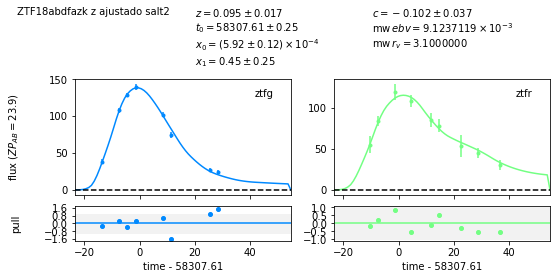

In [135]:
ajuste(lista_oid_SALT2_z_var_cortes_trest[9], 'salt2', df_meta_early_SNIa, 
       table_early_SNIa_SALT2_z_var_cortes_trest, version='2.4')[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT2_z_var_cortes_trest[9])

 ==== Con ajuste del redshift ====
chisq/ndof :  0.9758428029340361


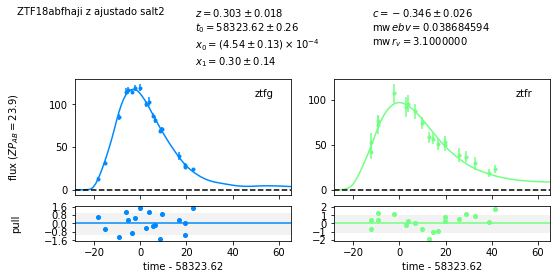

In [136]:
ajuste(lista_oid_SALT2_z_var_cortes_trest[16], 'salt2', df_meta_early_SNIa, 
       table_early_SNIa_SALT2_z_var_cortes_trest, version='2.4')[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT2_z_var_cortes_trest[16])

 ==== Con ajuste del redshift ====
chisq/ndof :  1.0542029473801287


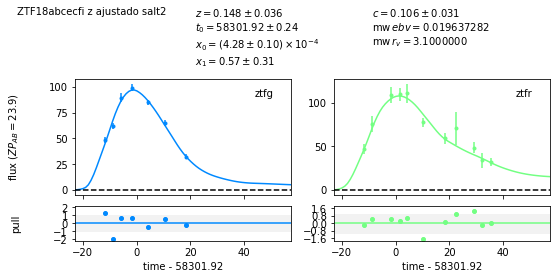

In [137]:
ajuste(lista_oid_SALT2_z_var_cortes_trest[19], 'salt2', df_meta_early_SNIa, 
       table_early_SNIa_SALT2_z_var_cortes_trest, version='2.4')[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT2_z_var_cortes_trest[19])

 ==== Con ajuste del redshift ====
chisq/ndof :  1.1815579388047808


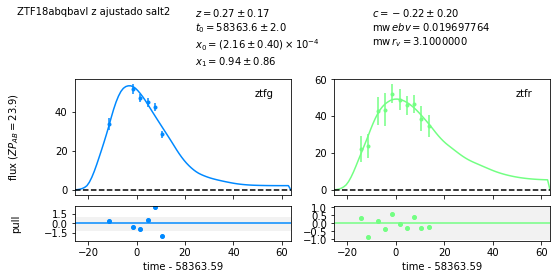

In [138]:
ajuste(lista_oid_SALT2_z_var_cortes_trest[24], 'salt2', df_meta_early_SNIa, 
       table_early_SNIa_SALT2_z_var_cortes_trest, version='2.4')[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT2_z_var_cortes_trest[24])

 ==== Con ajuste del redshift ====
chisq/ndof :  1.691554430365863


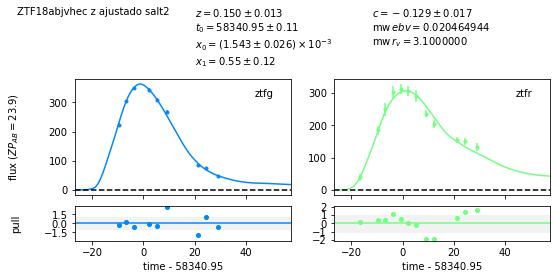

In [139]:
ajuste(lista_oid_SALT2_z_var_cortes_trest[40], 'salt2', df_meta_early_SNIa, 
       table_early_SNIa_SALT2_z_var_cortes_trest, version='2.4')[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT2_z_var_cortes_trest[40])

 ==== Con ajuste del redshift ====
chisq/ndof :  1.735892535475558


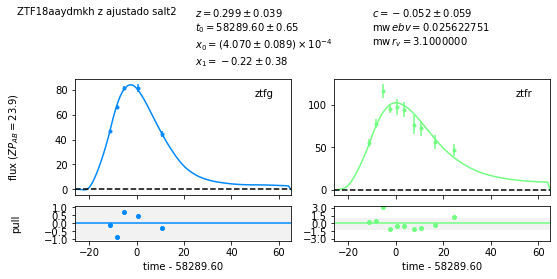

In [140]:
ajuste(lista_oid_SALT2_z_var_cortes_trest[41], 'salt2', df_meta_early_SNIa, 
       table_early_SNIa_SALT2_z_var_cortes_trest, version='2.4')[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT2_z_var_cortes_trest[41])

Algunos gráficos de los ajustes de las SN que tienen valores de $\frac{\chi^{2}}{ndof}$ mayores a la mediana.

 ==== Con ajuste del redshift ====
chisq/ndof :  1.8643974474087515


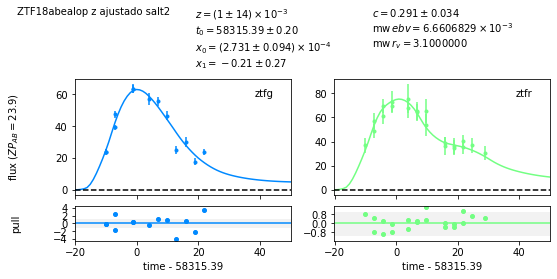

In [141]:
ajuste(lista_oid_SALT2_z_var_sobre_mediana_cortes_trest[3], 'salt2', df_meta_early_SNIa, 
       table_early_SNIa_SALT2_z_var_cortes_trest, version='2.4')[0]
print('chisq/ndof : ', 
      df_chisq_vs_ndof_SALT2_z_var_sobre_mediana_cortes_trest['chisq/ndof'][3])

 ==== Con ajuste del redshift ====
chisq/ndof :  2.0212731548822114


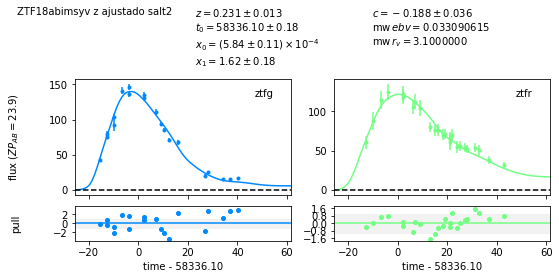

In [142]:
ajuste(lista_oid_SALT2_z_var_sobre_mediana_cortes_trest[8], 'salt2', df_meta_early_SNIa, 
       table_early_SNIa_SALT2_z_var_cortes_trest, version='2.4')[0]
print('chisq/ndof : ', 
      df_chisq_vs_ndof_SALT2_z_var_sobre_mediana_cortes_trest['chisq/ndof'][8])

 ==== Con ajuste del redshift ====
chisq/ndof :  2.371042239064131


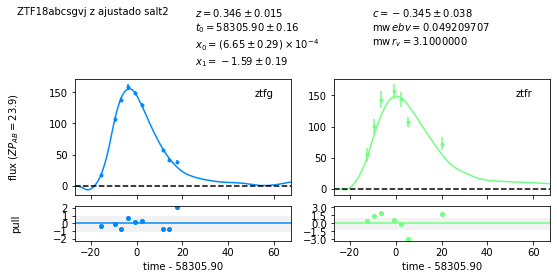

In [143]:
ajuste(lista_oid_SALT2_z_var_sobre_mediana_cortes_trest[15], 'salt2', df_meta_early_SNIa, 
       table_early_SNIa_SALT2_z_var_cortes_trest, version='2.4')[0]
print('chisq/ndof : ', 
      df_chisq_vs_ndof_SALT2_z_var_sobre_mediana_cortes_trest['chisq/ndof'][15])

 ==== Con ajuste del redshift ====
chisq/ndof :  2.5833948998752843


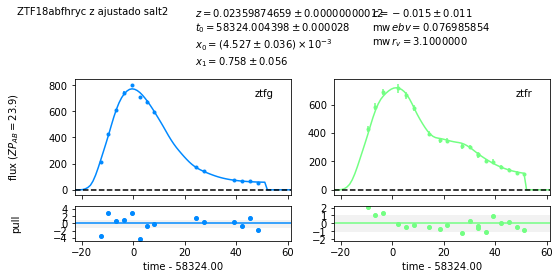

In [144]:
ajuste(lista_oid_SALT2_z_var_sobre_mediana_cortes_trest[17], 'salt2', df_meta_early_SNIa, 
       table_early_SNIa_SALT2_z_var_cortes_trest, version='2.4')[0]
print('chisq/ndof : ', 
      df_chisq_vs_ndof_SALT2_z_var_sobre_mediana_cortes_trest['chisq/ndof'][17])

 ==== Con ajuste del redshift ====
chisq/ndof :  3.9741603902957947


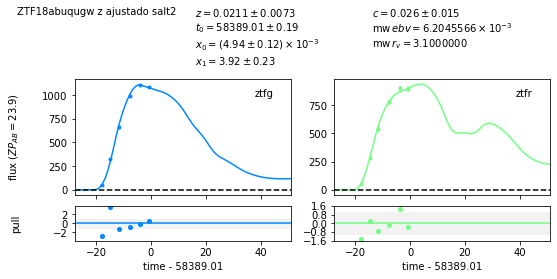

In [145]:
ajuste(lista_oid_SALT2_z_var_sobre_mediana_cortes_trest[21], 'salt2', df_meta_early_SNIa, 
       table_early_SNIa_SALT2_z_var_cortes_trest, version='2.4')[0]
print('chisq/ndof : ', 
      df_chisq_vs_ndof_SALT2_z_var_sobre_mediana_cortes_trest['chisq/ndof'][21])

 ==== Con ajuste del redshift ====
chisq/ndof :  4.564118269865215


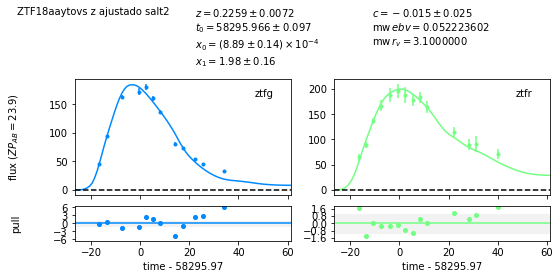

In [146]:
ajuste(lista_oid_SALT2_z_var_sobre_mediana_cortes_trest[26], 'salt2', df_meta_early_SNIa, 
       table_early_SNIa_SALT2_z_var_cortes_trest, version='2.4')[0]
print('chisq/ndof : ', 
      df_chisq_vs_ndof_SALT2_z_var_sobre_mediana_cortes_trest['chisq/ndof'][26])

 ==== Con ajuste del redshift ====
chisq/ndof :  5.54937622561167


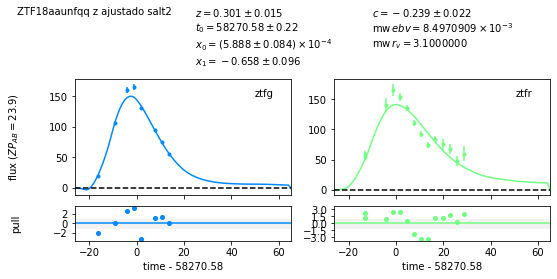

In [147]:
ajuste(lista_oid_SALT2_z_var_sobre_mediana_cortes_trest[29], 'salt2', df_meta_early_SNIa, 
       table_early_SNIa_SALT2_z_var_cortes_trest, version='2.4')[0]
print('chisq/ndof : ', 
      df_chisq_vs_ndof_SALT2_z_var_sobre_mediana_cortes_trest['chisq/ndof'][29])

 ==== Con ajuste del redshift ====
chisq/ndof :  10.76088283236842


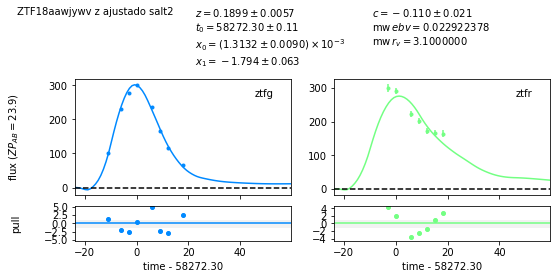

In [148]:
ajuste(lista_oid_SALT2_z_var_sobre_mediana_cortes_trest[33], 'salt2', df_meta_early_SNIa, 
       table_early_SNIa_SALT2_z_var_cortes_trest, version='2.4')[0]
print('chisq/ndof : ', 
      df_chisq_vs_ndof_SALT2_z_var_sobre_mediana_cortes_trest['chisq/ndof'][33])

 ==== Con ajuste del redshift ====
chisq/ndof :  17.44062339816656


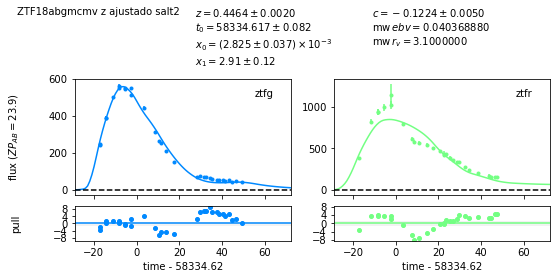

In [149]:
ajuste(lista_oid_SALT2_z_var_sobre_mediana_cortes_trest[39], 'salt2', df_meta_early_SNIa, 
       table_early_SNIa_SALT2_z_var_cortes_trest, version='2.4')[0]
print('chisq/ndof : ', 
      df_chisq_vs_ndof_SALT2_z_var_sobre_mediana_cortes_trest['chisq/ndof'][39])

## Ajuste con límite más estricto en el valor de $z$ (solo afecta a los que también ajustan $z$) 

Aquí sabemos que el rango de redshift real de las SNIa es $0.0181 \leq z \leq 0.141$. Probaremos que pasa si en los ajustes se utiliza un rango más estricto de valores de $z$, que en este ejemplo será $[0, 0.2]$.

Límite en el rango de $z$

In [150]:
z_bounds = (0, 0.2)

### Ajuste usando todas las observaciones (con redshift variable), se debe eliminar una SN ya que no se puede ajustar (si no se elimina el programa se cae)

In [151]:
name_50 = names_SNIa[50]
print('Eliminada : ', name_50)

df_meta_early_SNIa_sin_SN50 = df_meta_early_SNIa[df_meta_early_SNIa['oid'] != name_50]
detect_early_SNIa_sin_SN50 = detect_early_SNIa[detect_early_SNIa['oid'] != name_50]

ajustes_SALT2_early_SNIa_z_bounded = modelo_ajustado_y_resultados('salt2', 
                                                                  df_meta_early_SNIa_sin_SN50,
                                                                  detect_early_SNIa_sin_SN50,
                                                                  version='2.4',
                                                                  z_bounds=z_bounds,
                                                                  print_ind_and_oid=False)

Eliminada :  ZTF18abfhryc


Link en ALeRCE ZTF explorer de esta SN: https://alerce.online/object/ZTF18abfhryc

rango ncall : 136, 831
promedio ncall : 247.42168674698794
desviación estándar ncall : 130.12988140972504
mediana ncall : 201.0


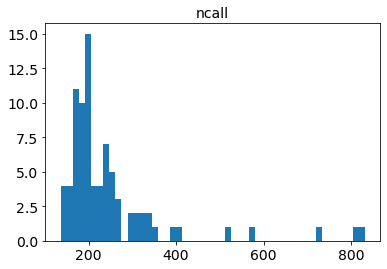

rango chisq : 1.0611599256899187, 21137.799247589563
promedio chisq : 724.0051396377522
desviación estándar chisq : 3132.739409483218
mediana chisq : 28.726716412008713


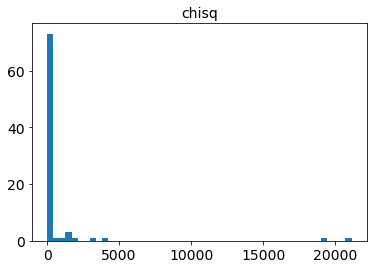

rango ndof : 3, 70
promedio ndof : 22.759036144578314
desviación estándar ndof : 15.043383336321416
mediana ndof : 17.0


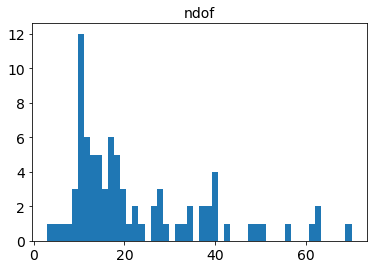

rango chisq/ndof : 0.3537199752299729, 310.2491863883433
promedio chisq/ndof : 14.935416444165199
desviación estándar chisq/ndof : 49.50671368365422
mediana chisq/ndof : 1.4701360460146091


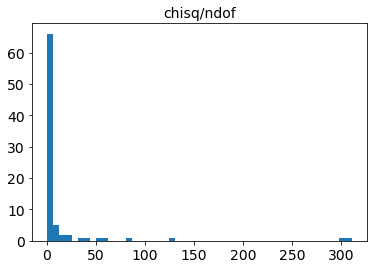

rango z : 3.2474510636149035e-09, 0.1999997551004081
promedio z : 0.07745572586694546
desviación estándar z : 0.046810485421753485
mediana z : 0.07581995561001885


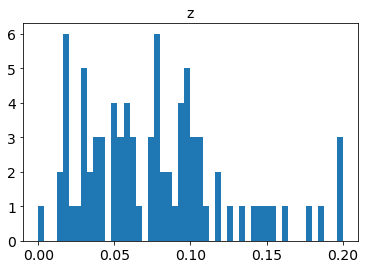

rango z_err : 1.9541313012183537e-12, 0.17104537277360138
promedio z_err : 0.024458467273245313
desviación estándar z_err : 0.035417281396290114
mediana z_err : 0.013966226715891844


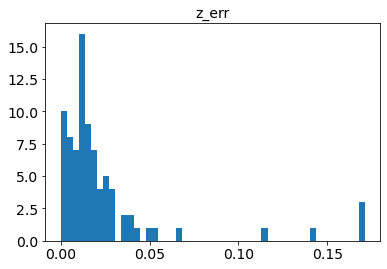

rango t0 : 58254.639819063304, 58394.951637928374
promedio t0 : 58319.83877815076
desviación estándar t0 : 39.00620135943871
mediana t0 : 58313.82632032845


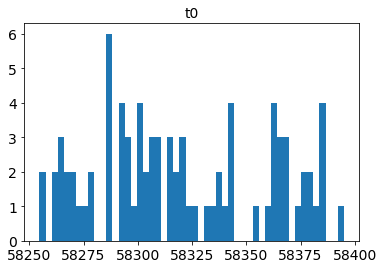

rango t0_err : 3.776222001761198e-09, 107.14097613492413
promedio t0_err : 2.7568358730720526
desviación estándar t0_err : 16.054858136107754
mediana t0_err : 0.20602531019540038


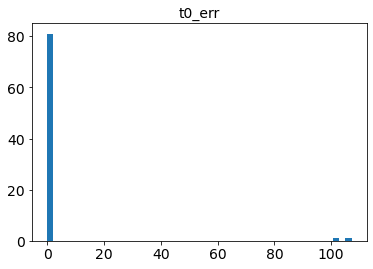

rango x0 : 0.00023151334994536514, 0.011187049600985767
promedio x0 : 0.0013132533030790552
desviación estándar x0 : 0.001737858822366286
mediana x0 : 0.0007102350759029997


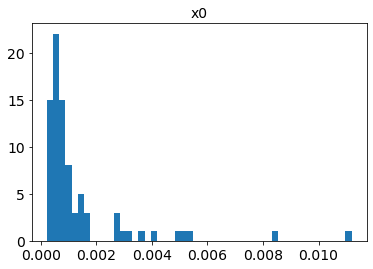

rango x0_err : 5.13260252254012e-06, 1.0339429147941692
promedio x0_err : 0.024524138757600848
desviación estándar x0_err : 0.1559703798840404
mediana x0_err : 1.341860253804596e-05


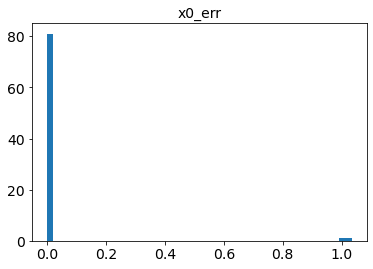

rango x1 : -2.1568083534898075, 2.6923321335276116
promedio x1 : 0.057493782100815495
desviación estándar x1 : 1.1253794766991214
mediana x1 : 0.25976718284826816


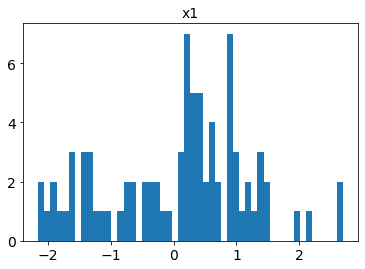

rango x1_err : 0.018310802068357113, 5.762989156459191
promedio x1_err : 0.387394243243015
desviación estándar x1_err : 0.8562639081365143
mediana x1_err : 0.18431505549658755


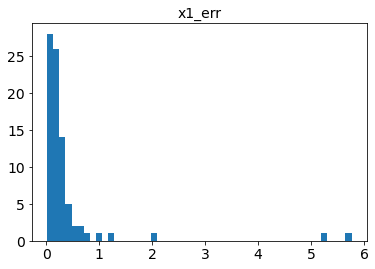

rango c : -0.21678815167251564, 0.39992542299987655
promedio c : 0.0068788858827030135
desviación estándar c : 0.11378658228549059
mediana c : -0.0023376724281225503


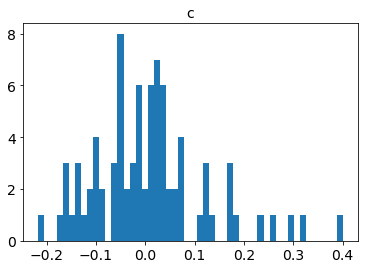

rango c_err : 0.00016156469826961173, 0.5887588462221147
promedio c_err : 0.04553461514527974
desviación estándar c_err : 0.0868092622926971
mediana c_err : 0.029547897822770064


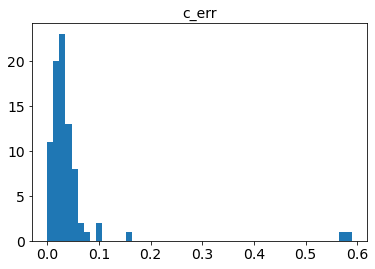

rango mwebv : 0.006204556550167132, 0.1144183424611353
promedio mwebv : 0.030089577616138525
desviación estándar mwebv : 0.020939673255291013
mediana mwebv : 0.023404313345236558


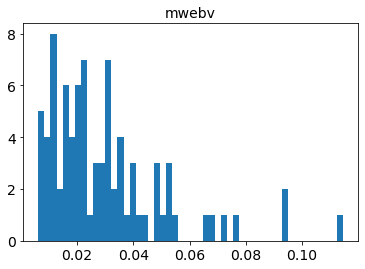

In [152]:
histogramas_estadisticas_resultados(ajustes_SALT2_early_SNIa_z_bounded)

Estadísticas de los ajustes, ordenados por valor de chisq/ndof

In [153]:
estadisticas_SALT2_z_bounded = estadisticas_resultados(ajustes_SALT2_early_SNIa_z_bounded).sort_values(by=['chisq/ndof'])

Listas de los oid y de los valores de chisq/ndof del ajuste con con el modelo SALT2 y redshift variable, utilizando los puntos que pertenecen al rango de tiempo del modelo (determinado con los valores de $t_0$ del primer ajuste y $z=0$), ordenados según el valor de chisq/ndof

In [154]:
lista_oid_SALT2_z_bounded = list(estadisticas_SALT2_z_bounded['oid'])
lista_chisq_vs_ndof_SALT2_z_bounded = list(estadisticas_SALT2_z_bounded['chisq/ndof'])

Filas de los resultados del ajuste con chisq/ndof sobre la 
mediana 

In [155]:
median_chisq_vs_ndof_SALT2_z_bounded = np.median(np.array(estadisticas_SALT2_z_bounded['chisq/ndof']))
df_chisq_vs_ndof_SALT2_z_bounded_sobre_mediana = estadisticas_SALT2_z_bounded[estadisticas_SALT2_z_bounded['chisq/ndof'] > median_chisq_vs_ndof_SALT2_z_bounded].reset_index()
lista_oid_SALT2_z_bounded_sobre_mediana = list(df_chisq_vs_ndof_SALT2_z_bounded_sobre_mediana['oid'])

Mostrar algunas columnas de los resultados del ajuste, con valores de chisq/ndof sobre la mediana

In [156]:
display(df_chisq_vs_ndof_SALT2_z_bounded_sobre_mediana[['oid', 
                                                        'chisq/ndof', 
                                                        'z', 
                                                        'z_err', 
                                                        't0', 
                                                        't0_err']])

oid  chisq/ndof             z         z_err            t0  \
0   ZTF18abpaywm    1.507910  9.667435e-02  1.412859e-01  58368.265877   
1   ZTF18abdbuty    1.635361  1.045593e-01  1.604610e-02  58308.315705   
2   ZTF18abclalx    1.650098  1.756881e-02  1.638991e-02  58300.363622   
3   ZTF18abdkimx    1.669320  7.622732e-02  1.867455e-02  58313.830874   
4   ZTF18aaxwjmp    1.680652  5.301183e-02  1.204099e-02  58288.218599   
5   ZTF18abjvhec    1.691556  1.501537e-01  1.253378e-02  58340.953026   
6   ZTF18abtnlik    1.721071  8.695092e-02  4.823907e-02  58379.073481   
7   ZTF18abealop    1.861882  3.247451e-09  1.296470e-02  58315.374825   
8   ZTF18aaxrvzj    1.920324  1.178836e-01  1.549046e-02  58286.183747   
9   ZTF18aaxqyki    2.099740  1.067138e-01  3.032694e-02  58286.563808   
10  ZTF18abdefet    2.197985  4.841154e-02  2.115807e-02  58307.433272   
11  ZTF18abbvsiv    2.288683  1.034585e-01  2.514417e-09  58297.094536   
12  ZTF18abetewu    2.291253  7.581996e-02  1.933718e-02  58318.782768   
13  ZTF18abkifng    2.312953  5.837695e-02  6.732303e-02  58343.395970   
14  ZTF18abbpeqo    2.492689  5.662046e-02  2.474846e-02  58300.571792   
15  ZTF18aaunfqq    2.546854  1.985458e-02  7.605665e-03  58267.936854   
16  ZTF18aazcoob    3.517563  1.763001e-01  1.317492e-02  58295.092952   
17  ZTF18aavrwhu    3.840133  8.031302e-02  1.038374e-02  58275.916916   
18  ZTF18aavrzxp    4.093312  5.058892e-02  8.035743e-03  58270.237532   
19  ZTF18abetehf    4.290493  1.166007e-01  8.838912e-03  58318.764904   
20  ZTF18aaqqoqs    4.654404  7.619708e-02  9.624060e-03  58262.563744   
21  ZTF18aayjvve    5.077561  9.803912e-02  5.804147e-04  58292.354715   
22  ZTF18aaytovs    6.051287  7.939878e-02  1.009525e-02  58294.420620   
23  ZTF18aaqffyp    6.107432  6.020236e-02  8.859938e-03  58254.639819   
24  ZTF18aaxdrjn    7.362290  5.815731e-02  3.106761e-03  58279.326747   
25  ZTF18aauocnw    8.560691  5.879527e-02  1.071895e-02  58268.888908   
26  ZTF18aatzygk    9.983019  9.591177e-02  1.337715e-02  58262.375365   
27  ZTF18aaumlfl   10.340522  1.832568e-02  1.123159e-02  58265.036040   
28  ZTF18aawjywv   10.430267  6.650745e-02  1.349584e-02  58271.720195   
29  ZTF18aaslhxt   12.844869  8.136162e-02  3.929968e-03  58263.803200   
30  ZTF18abeecwe   16.021887  2.909933e-02  5.131513e-03  58319.483651   
31  ZTF18aaqcqvr   19.352286  4.389275e-02  6.140751e-03  58256.310499   
32  ZTF18abgmcmv   23.756460  1.553477e-01  1.133473e-01  58330.412837   
33  ZTF18abcrxoj   36.389430  5.386817e-02  2.187272e-03  58306.548550   
34  ZTF18aaumeys   43.055135  2.915903e-02  4.711139e-03  58267.155440   
35  ZTF18aaxcntm   52.754367  9.138937e-02  2.729531e-07  58279.618398   
36  ZTF18aaxsioa   56.444163  3.898783e-02  2.124387e-03  58286.229086   
37  ZTF18abcflnz   84.285780  1.841236e-01  1.954131e-12  58308.026989   
38  ZTF18abuqugw  127.111838  2.898448e-02  4.368983e-03  58384.346644   
39  ZTF18aasdted  301.968561  2.720077e-02  9.563773e-04  58265.452732   
40  ZTF18abauprj  310.249186  1.988384e-02  1.909848e-03  58301.964154   

          t0_err  
0   1.026511e+02  
1   1.617450e-01  
2   3.662155e-01  
3   1.441406e-01  
4   1.291181e-01  
5   1.100675e-01  
6   2.399219e-01  
7   1.981789e-01  
8   2.009828e-01  
9   4.058047e-01  
10  3.261805e-01  
11  3.735113e-08  
12  1.966277e-01  
13  4.697162e-01  
14  1.890551e-01  
15  1.843926e-01  
16  2.391722e-01  
17  8.220016e-02  
18  1.510315e-01  
19  1.152773e-01  
20  7.584017e-02  
21  6.088924e-02  
22  1.047873e-01  
23  8.053253e-02  
24  4.138307e-02  
25  1.264364e-01  
26  1.652756e-01  
27  2.755013e-01  
28  9.144940e-02  
29  3.285713e-02  
30  1.093358e-01  
31  1.069617e-01  
32  2.235485e-05  
33  1.071410e+02  
34  7.344998e-02  
35  1.293358e-05  
36  4.061950e-02  
37  3.776222e-09  
38  1.028546e-01  
39  2.040674e-02  
40  4.991071e-02

Se observa que los valores de $\frac{\chi^{2}}{ndof}$ son muy altos, y que estos tenían que ver principalmente con hay observaciones que están fuera del rango de tiempo del modelo

### Ajuste con observaciones en el rango de tiempo del modelo (determinado con $t_0$ y $z$ del primer ajuste)

Seleccionar las detecciones de las SN que están dentro del rango de tiempo del modelo según el primer ajuste con el modelo SALT2 y límites para $z$

In [157]:
detect_early_SNIa_SALT2_z_bounded_cortes_t = cortes_t_modelo(trest_min_modelo, 
                                                             trest_max_modelo, 
                                                             detect_early_SNIa_sin_SN50,
                                                             estadisticas_SALT2_z_bounded)

Ajustes con las detecciones de las SN que están dentro del rango de tiempo del modelo

In [158]:
ajustes_SALT2_early_SNIa_z_bounded_cortes_t = modelo_ajustado_y_resultados('salt2', 
                                                                           df_meta_early_SNIa_sin_SN50, 
                                                                           detect_early_SNIa_SALT2_z_bounded_cortes_t, 
                                                                           version='2.4',
                                                                           z_bounds=z_bounds,
                                                                           print_ind_and_oid=False)

rango ncall : 136, 750
promedio ncall : 240.95180722891567
desviación estándar ncall : 107.36054598446918
mediana ncall : 201.0


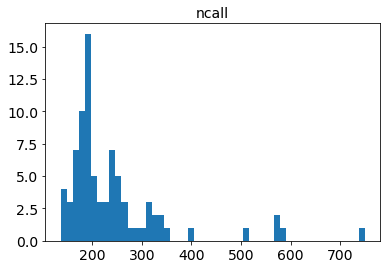

rango chisq : 1.0611599256899187, 1322.9854033194588
promedio chisq : 91.74437639758276
desviación estándar chisq : 206.48750860964114
mediana chisq : 27.521247000603353


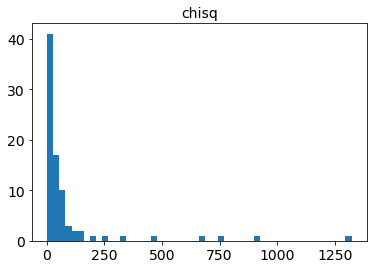

rango ndof : 3, 61
promedio ndof : 20.80722891566265
desviación estándar ndof : 12.281299165339206
mediana ndof : 17.0


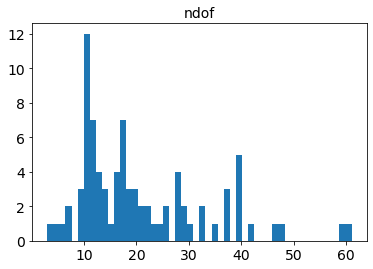

rango chisq/ndof : 0.3537199752299729, 35.75636225187726
promedio chisq/ndof : 3.5067010046829195
desviación estándar chisq/ndof : 5.689584799796647
mediana chisq/ndof : 1.4363358206004357


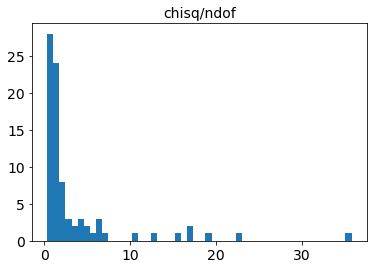

rango z : 3.2474510636149035e-09, 0.1999997551004081
promedio z : 0.07693635591317739
desviación estándar z : 0.04473476082501813
mediana z : 0.07619708487137405


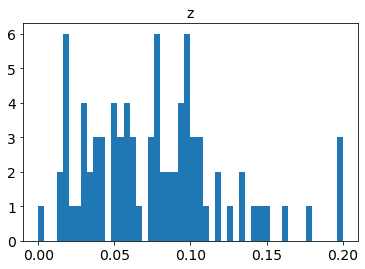

rango z_err : 1.2836442360442124e-09, 0.17104537277360138
promedio z_err : 0.02308664522878998
desviación estándar z_err : 0.03411568895674924
mediana z_err : 0.013495842616611301


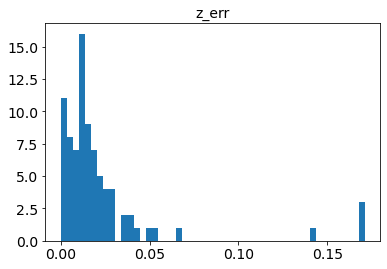

rango t0 : 58254.639819063304, 58394.951637928374
promedio t0 : 58319.82383660902
desviación estándar t0 : 39.01938905594813
mediana t0 : 58313.82632032845


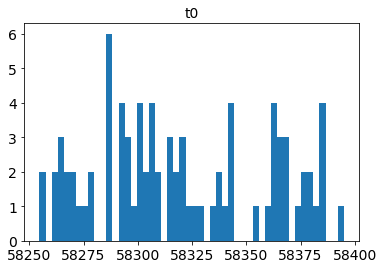

rango t0_err : 3.735112841241062e-08, 102.65107414352678
promedio t0_err : 1.4662111748830176
desviación estándar t0_err : 11.176103186265742
mediana t0_err : 0.20098277028591838


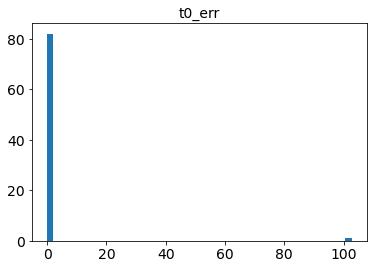

rango x0 : 0.00023151334994536514, 0.011187092675766126
promedio x0 : 0.0013101905308686788
desviación estándar x0 : 0.0017335886142075966
mediana x0 : 0.0007102350759029997


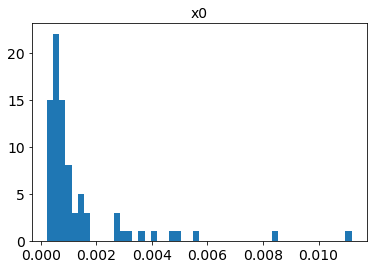

rango x0_err : 5.13260252254012e-06, 1.0000010000317845
promedio x0_err : 0.01206634430399152
desviación estándar x0_err : 0.10909913256055706
mediana x0_err : 1.3351928258003127e-05


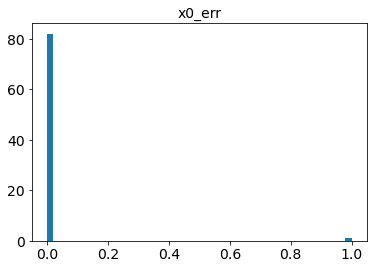

rango x1 : -2.252014411413962, 2.6923321335276116
promedio x1 : 0.047989333114976725
desviación estándar x1 : 1.138050824238361
mediana x1 : 0.2310505440345798


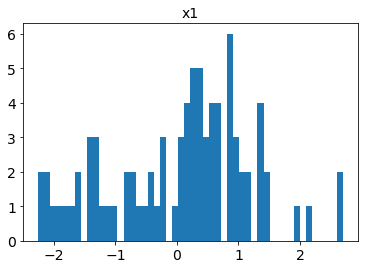

rango x1_err : 0.018296332981925012, 5.762989156459191
promedio x1_err : 0.32415142899499994
desviación estándar x1_err : 0.6634582269776964
mediana x1_err : 0.18313665511963118


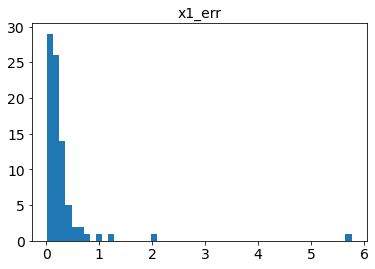

rango c : -0.17713845007615392, 0.39999999996292623
promedio c : 0.007359627748860214
desviación estándar c : 0.11274863932864267
mediana c : -0.0023376724281225503


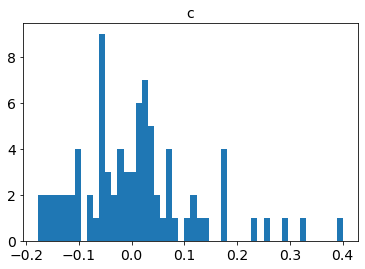

rango c_err : 0.0009453064944764944, 0.5887588462221147
promedio c_err : 0.03883585826294673
desviación estándar c_err : 0.064972888471783
mediana c_err : 0.028856794308065398


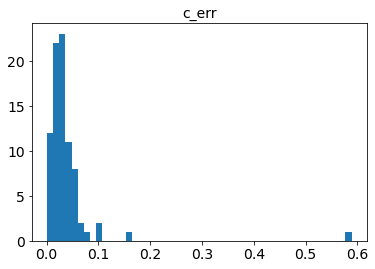

rango mwebv : 0.006204556550167132, 0.1144183424611353
promedio mwebv : 0.030089577616138525
desviación estándar mwebv : 0.020939673255291013
mediana mwebv : 0.023404313345236558


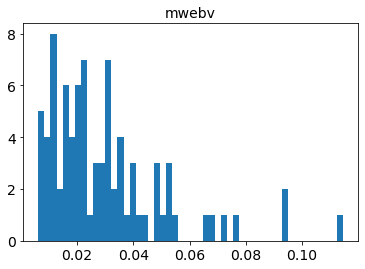

In [159]:
histogramas_estadisticas_resultados(ajustes_SALT2_early_SNIa_z_bounded_cortes_t)

Estadísticas de los ajustes, ordenados por valor de chisq/ndof

In [160]:
estadisticas_SALT2_z_bounded_cortes_t = estadisticas_resultados(ajustes_SALT2_early_SNIa_z_bounded_cortes_t).sort_values(by=['chisq/ndof'])

Listas de los oid y de los valores de chisq/ndof del ajuste con con el modelo SALT2 y redshift variable, utilizando los puntos que pertenecen al rango de tiempo del modelo (determinado con los valores de $t_0$ del primer ajuste y $z=0$), ordenados según el valor de chisq/ndof

In [161]:
lista_oid_SALT2_z_bounded_cortes_t = list(estadisticas_SALT2_z_bounded_cortes_t['oid'])
lista_chisq_vs_ndof_SALT2_z_bounded_cortes_t = list(estadisticas_SALT2_z_bounded_cortes_t['chisq/ndof'])

Filas de los resultados del ajuste con chisq/ndof sobre la 
mediana 

In [162]:
median_chisq_vs_ndof_SALT2_z_bounded_cortes_t = np.median(np.array(estadisticas_SALT2_z_bounded_cortes_t['chisq/ndof']))
df_chisq_vs_ndof_SALT2_z_bounded_sobre_mediana_cortes_t = estadisticas_SALT2_z_bounded_cortes_t[estadisticas_SALT2_z_bounded_cortes_t['chisq/ndof'] > median_chisq_vs_ndof_SALT2_z_bounded_cortes_t].reset_index()
lista_oid_SALT2_z_bounded_sobre_mediana_cortes_t = list(df_chisq_vs_ndof_SALT2_z_bounded_sobre_mediana_cortes_t['oid'])

Mostrar algunas columnas de los resultados del ajuste, con valores de chisq/ndof sobre la mediana

In [163]:
display(df_chisq_vs_ndof_SALT2_z_bounded_sobre_mediana_cortes_t[['oid', 
                                                                 'chisq/ndof', 
                                                                 'z', 
                                                                 'z_err', 
                                                                 't0', 
                                                                 't0_err']])

oid  chisq/ndof             z         z_err            t0  \
0   ZTF18aaumlfl    1.441130  1.830432e-02  1.116389e-02  58265.035894   
1   ZTF18abimsyv    1.464449  8.639310e-02  9.286663e-03  58334.425352   
2   ZTF18abckujg    1.470136  3.203560e-02  1.029074e-02  58302.909650   
3   ZTF18abpaywm    1.507910  9.667435e-02  1.412859e-01  58368.265877   
4   ZTF18abdbuty    1.635361  1.045593e-01  1.604610e-02  58308.315705   
5   ZTF18abclalx    1.650098  1.756881e-02  1.638991e-02  58300.363622   
6   ZTF18abdkimx    1.669320  7.622732e-02  1.867455e-02  58313.830874   
7   ZTF18aaxwjmp    1.680652  5.301183e-02  1.204099e-02  58288.218599   
8   ZTF18abjvhec    1.691556  1.501537e-01  1.253378e-02  58340.953026   
9   ZTF18abtnlik    1.721071  8.695092e-02  4.823907e-02  58379.073481   
10  ZTF18abealop    1.861882  3.247451e-09  1.296470e-02  58315.374825   
11  ZTF18aaxrvzj    1.920324  1.178836e-01  1.549046e-02  58286.183747   
12  ZTF18aaxqyki    2.099740  1.067138e-01  3.032694e-02  58286.563808   
13  ZTF18abdefet    2.197985  4.841154e-02  2.115807e-02  58307.433272   
14  ZTF18abbvsiv    2.288683  1.034585e-01  2.514417e-09  58297.094536   
15  ZTF18abetewu    2.291253  7.581996e-02  1.933718e-02  58318.782768   
16  ZTF18abkifng    2.312953  5.837695e-02  6.732303e-02  58343.395970   
17  ZTF18abcrxoj    2.388555  5.374680e-02  2.235897e-09  58306.552908   
18  ZTF18aayjvve    2.500901  9.803689e-02  2.875367e-03  58292.354697   
19  ZTF18aaunfqq    2.546854  1.985458e-02  7.605665e-03  58267.936854   
20  ZTF18aaytovs    3.185264  7.939857e-02  1.003717e-02  58294.420618   
21  ZTF18aazcoob    3.517563  1.763001e-01  1.317492e-02  58295.092952   
22  ZTF18aavrwhu    3.840133  8.031302e-02  1.038374e-02  58275.916916   
23  ZTF18abauprj    4.014362  1.988334e-02  1.993017e-03  58301.964135   
24  ZTF18aavrzxp    4.093312  5.058892e-02  8.035743e-03  58270.237532   
25  ZTF18abetehf    4.290493  1.166007e-01  8.838912e-03  58318.764904   
26  ZTF18aaqqoqs    4.654404  7.619708e-02  9.624060e-03  58262.563744   
27  ZTF18aauocnw    4.822691  5.881110e-02  1.060005e-02  58268.888972   
28  ZTF18aatzygk    5.718754  9.591062e-02  1.348223e-02  58262.375364   
29  ZTF18aaqffyp    6.107432  6.020236e-02  8.859938e-03  58254.639819   
30  ZTF18aaumeys    6.208018  2.919801e-02  4.605528e-03  58267.156041   
31  ZTF18aaxsioa    6.369074  3.899623e-02  2.056986e-03  58286.229215   
32  ZTF18aaxdrjn    7.362290  5.815731e-02  3.106761e-03  58279.326747   
33  ZTF18aawjywv   10.430267  6.650745e-02  1.349584e-02  58271.720195   
34  ZTF18aaslhxt   12.526437  8.137124e-02  3.928801e-03  58263.803205   
35  ZTF18abgmcmv   15.586874  8.940449e-02  2.780735e-06  58329.755142   
36  ZTF18aasdted   16.857812  2.720954e-02  9.558566e-04  58265.452936   
37  ZTF18abuqugw   16.923946  9.195510e-02  5.998335e-03  58384.751181   
38  ZTF18aaqcqvr   19.352286  4.389275e-02  6.140751e-03  58256.310499   
39  ZTF18aaxcntm   22.888386  9.941922e-02  5.115749e-08  58279.216878   
40  ZTF18abcflnz   35.756362  1.358459e-01  9.592930e-08  58307.435097   

          t0_err  
0   2.741170e-01  
1   1.540282e-01  
2   2.332035e-01  
3   1.026511e+02  
4   1.617450e-01  
5   3.662155e-01  
6   1.441406e-01  
7   1.291181e-01  
8   1.100675e-01  
9   2.399219e-01  
10  1.981789e-01  
11  2.009828e-01  
12  4.058047e-01  
13  3.261805e-01  
14  3.735113e-08  
15  1.966277e-01  
16  4.697162e-01  
17  1.430664e-05  
18  6.540260e-02  
19  1.843926e-01  
20  1.046425e-01  
21  2.391722e-01  
22  8.220016e-02  
23  5.155287e-02  
24  1.510315e-01  
25  1.152773e-01  
26  7.584017e-02  
27  1.258028e-01  
28  1.658307e-01  
29  8.053253e-02  
30  7.209428e-02  
31  3.984467e-02  
32  4.138307e-02  
33  9.144940e-02  
34  3.285669e-02  
35  5.103144e-02  
36  2.039081e-02  
37  8.213658e-02  
38  1.069617e-01  
39  2.686294e-06  
40  1.362394e-06

Intersección de los oid de las SN con valores de chisq/ndof mayores a la mediana de los ajustes con SALT2 y $z$ variable antes y después de eliminar los puntos fuera del rango de tiempo del modelo

In [164]:
inter_oid_SALT2_z_bounded_sobre_mediana_cortes_t = np.intersect1d(np.array(lista_oid_SALT2_z_var_sobre_mediana),
                                                                  np.array(lista_oid_SALT2_z_bounded_sobre_mediana_cortes_t))
print('Elementos comunes sobre la mediana de chisq/ndof : ',
      len(inter_oid_SALT2_z_bounded_sobre_mediana_cortes_t))

Elementos comunes sobre la mediana de chisq/ndof :  34


Tabla de astropy con las detecciones que están en el rango de tiempo del modelo, en el formato que requiere sncosmo para hacer los ajustes 

In [165]:
table_early_SNIa_SALT2_z_bounded_cortes_t = astropy_table_detections(df_meta_early_SNIa_sin_SN50, 
                                                                     detect_early_SNIa_SALT2_z_bounded_cortes_t)

Algunos gráficos interesantes de ajustes con $\frac{\chi^2}{ndof}$ mayor a la mediana

 ==== Con ajuste del redshift ====
chisq/ndof :  2.288682576553392


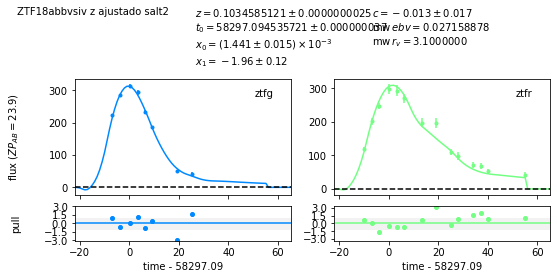

In [166]:
ajuste(lista_oid_SALT2_z_bounded_sobre_mediana_cortes_t[14], 'salt2', df_meta_early_SNIa, 
       table_early_SNIa_SALT2_z_bounded_cortes_t, version='2.4', z_bounds=z_bounds)[0]
print('chisq/ndof : ', df_chisq_vs_ndof_SALT2_z_bounded_sobre_mediana_cortes_t['chisq/ndof'][14])

 ==== Con ajuste del redshift ====
chisq/ndof :  2.500900895061325


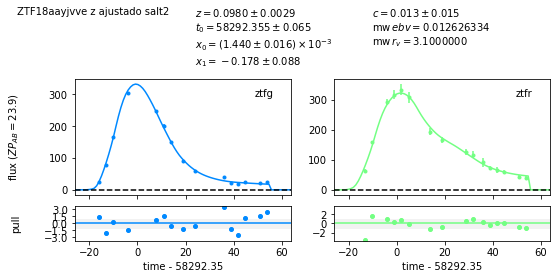

In [167]:
ajuste(lista_oid_SALT2_z_bounded_sobre_mediana_cortes_t[18], 'salt2', df_meta_early_SNIa, 
       table_early_SNIa_SALT2_z_bounded_cortes_t, version='2.4', z_bounds=z_bounds)[0]
print('chisq/ndof : ', df_chisq_vs_ndof_SALT2_z_bounded_sobre_mediana_cortes_t['chisq/ndof'][18])

 ==== Con ajuste del redshift ====
chisq/ndof :  4.290493432303422


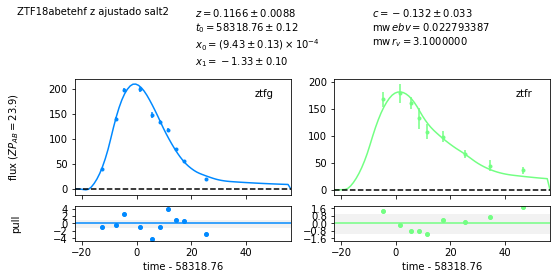

In [168]:
ajuste(lista_oid_SALT2_z_bounded_sobre_mediana_cortes_t[25], 'salt2', df_meta_early_SNIa, 
       table_early_SNIa_SALT2_z_bounded_cortes_t, version='2.4', z_bounds=z_bounds)[0]
print('chisq/ndof : ', df_chisq_vs_ndof_SALT2_z_bounded_sobre_mediana_cortes_t['chisq/ndof'][25])

 ==== Con ajuste del redshift ====
chisq/ndof :  5.718753898085726


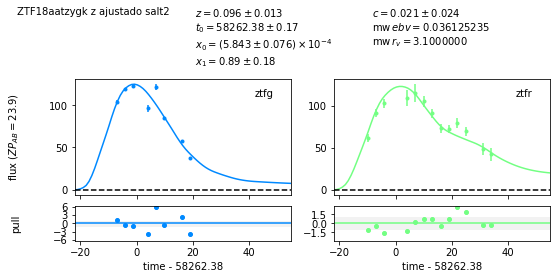

In [169]:
ajuste(lista_oid_SALT2_z_bounded_sobre_mediana_cortes_t[28], 'salt2', df_meta_early_SNIa, 
       table_early_SNIa_SALT2_z_bounded_cortes_t, version='2.4', z_bounds=z_bounds)[0]
print('chisq/ndof : ', df_chisq_vs_ndof_SALT2_z_bounded_sobre_mediana_cortes_t['chisq/ndof'][28])

 ==== Con ajuste del redshift ====
chisq/ndof :  6.208018491940477


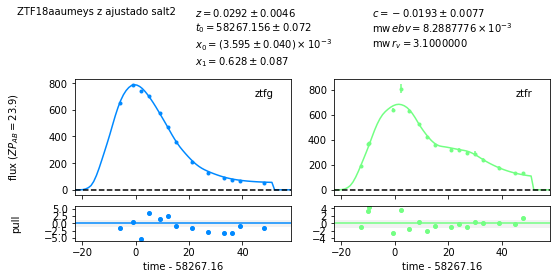

In [170]:
ajuste(lista_oid_SALT2_z_bounded_sobre_mediana_cortes_t[30], 'salt2', df_meta_early_SNIa, 
       table_early_SNIa_SALT2_z_bounded_cortes_t, version='2.4', z_bounds=z_bounds)[0]
print('chisq/ndof : ', df_chisq_vs_ndof_SALT2_z_bounded_sobre_mediana_cortes_t['chisq/ndof'][30])

 ==== Con ajuste del redshift ====
chisq/ndof :  35.75636225187726


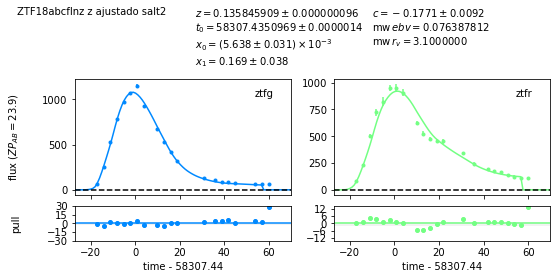

In [171]:
ajuste(lista_oid_SALT2_z_bounded_sobre_mediana_cortes_t[40], 'salt2', df_meta_early_SNIa, 
       table_early_SNIa_SALT2_z_bounded_cortes_t, version='2.4', z_bounds=z_bounds)[0]
print('chisq/ndof : ', df_chisq_vs_ndof_SALT2_z_bounded_sobre_mediana_cortes_t['chisq/ndof'][40])

En general los ajustes se ven bien y se parecen al caso en que se utiliza el redshift real de las SN.

Se ve que hay puntos que quedaron fuera del rango de tiempo del modelo, lo que aumenta el valor de $\frac{\chi^2}{ndof}$.

### Ajuste con observaciones en el rango de tiempo del modelo como si estuviese en el sistema de referencia en reposo (determinado con $t_0$ del primer ajuste)

Seleccionar las detecciones de las SN que están dentro del rango de tiempo del modelo asumiendo que está en el sistema de referencia en reposo $z=0$, con el valor de $t_0$ del primer ajuste con el modelo SALT2 y límites para $z$

In [172]:
detect_early_SNIa_SALT2_z_bounded_cortes_trest = cortes_trest_modelo(trest_min_modelo, 
                                                                     trest_max_modelo, 
                                                                     detect_early_SNIa_sin_SN50,
                                                                     estadisticas_SALT2_z_bounded)

Ajustes con las detecciones de las SN que están dentro del rango de tiempo del modelo 

In [173]:
ajustes_SALT2_early_SNIa_z_bounded_cortes_trest = modelo_ajustado_y_resultados('salt2', 
                                                                               df_meta_early_SNIa_sin_SN50, 
                                                                               detect_early_SNIa_SALT2_z_bounded_cortes_trest, 
                                                                               version='2.4',
                                                                               z_bounds=z_bounds,
                                                                               print_ind_and_oid=False)

rango ncall : 136, 402
promedio ncall : 218.03614457831324
desviación estándar ncall : 56.02010090688566
mediana ncall : 195.0


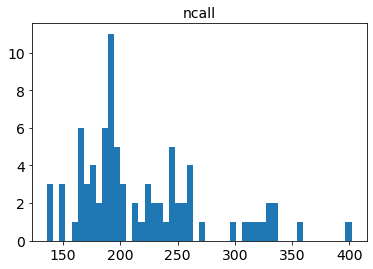

rango chisq : 1.0611599256899187, 758.7481051326613
promedio chisq : 61.77541556351514
desviación estándar chisq : 107.6074930788999
mediana chisq : 27.521247000603353


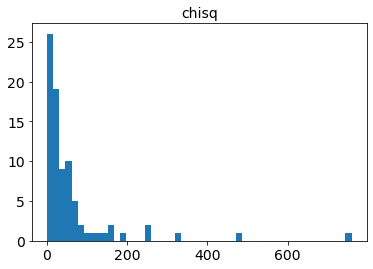

rango ndof : 3, 57
promedio ndof : 20.373493975903614
desviación estándar ndof : 11.653336916356116
mediana ndof : 17.0


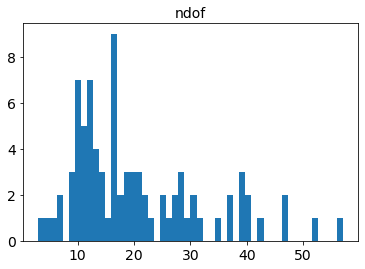

rango chisq/ndof : 0.3537199752299729, 19.35228616992267
promedio chisq/ndof : 2.7848373040159937
desviación estándar chisq/ndof : 3.688388151960613
mediana chisq/ndof : 1.4171421958278385


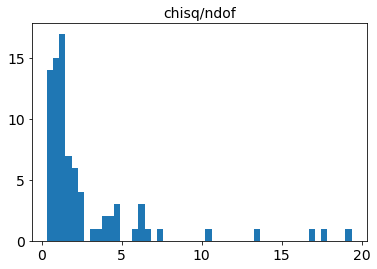

rango z : 3.2474510636149035e-09, 0.1999997551004081
promedio z : 0.07400367420938661
desviación estándar z : 0.04486330314214898
mediana z : 0.07208711497532391


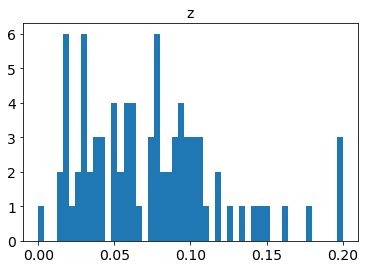

rango z_err : 0.0009552560855009273, 0.17104537277360138
promedio z_err : 0.021939726004498995
desviación estándar z_err : 0.031303078261342425
mediana z_err : 0.013495842616611301


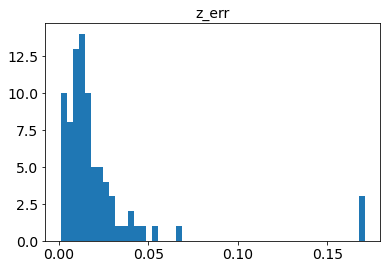

rango t0 : 58254.639819063304, 58394.951637928374
promedio t0 : 58319.80168108663
desviación estándar t0 : 39.02395950352239
mediana t0 : 58313.82632032845


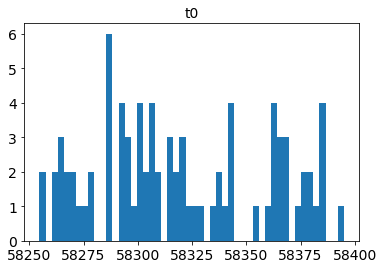

rango t0_err : 0.020384021983772982, 1.3065994698335999
promedio t0_err : 0.23650099634582455
desviación estándar t0_err : 0.21246008964061996
mediana t0_err : 0.1981789224446402


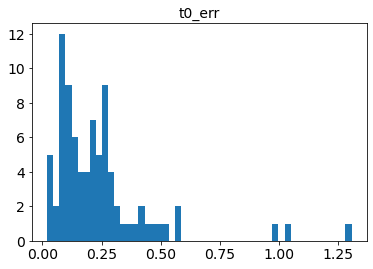

rango x0 : 0.00023151334994536514, 0.011206408124483697
promedio x0 : 0.0013208629606790145
desviación estándar x0 : 0.0017594106124842455
mediana x0 : 0.0007102350759029997


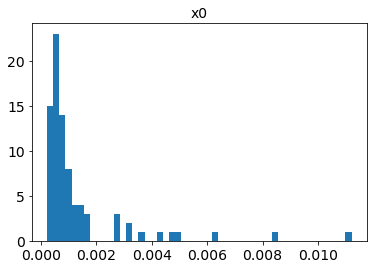

rango x0_err : 5.13260252254012e-06, 7.889477996464914e-05
promedio x0_err : 1.8907489673153863e-05
desviación estándar x0_err : 1.4476083319844634e-05
mediana x0_err : 1.4257887035923149e-05


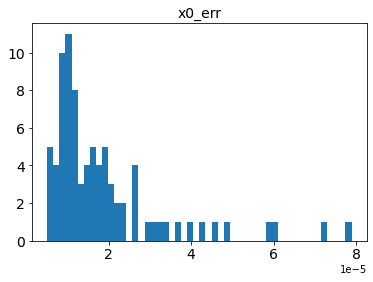

rango x1 : -2.252014411413962, 2.6923321335276116
promedio x1 : 0.05899725649989984
desviación estándar x1 : 1.1291635575953236
mediana x1 : 0.25976718284826816


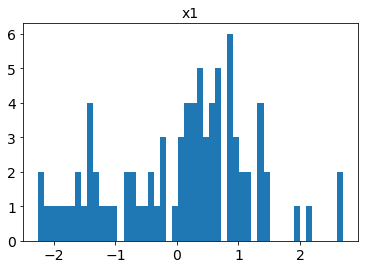

rango x1_err : 0.018300070306957572, 2.014432653937914
promedio x1_err : 0.2566352305128466
desviación estándar x1_err : 0.28190757134965994
mediana x1_err : 0.1805372209477838


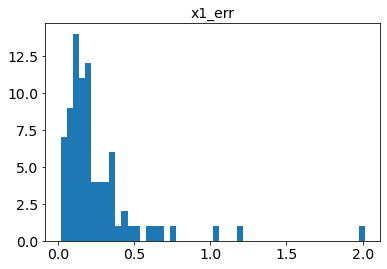

rango c : -0.16898515441970466, 0.3999999211183437
promedio c : 0.01079868142476994
desviación estándar c : 0.11193503044514436
mediana c : 0.008987653718696087


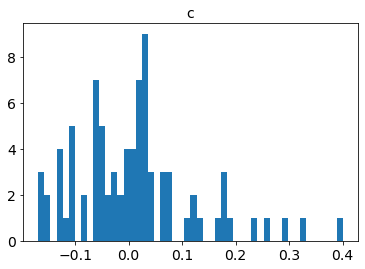

rango c_err : 0.000900294729842932, 0.15501513907137762
promedio c_err : 0.03213251019369423
desviación estándar c_err : 0.023023196933248898
mediana c_err : 0.02795870438780859


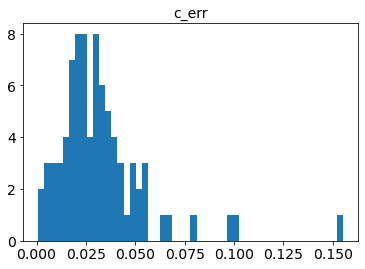

rango mwebv : 0.006204556550167132, 0.1144183424611353
promedio mwebv : 0.030089577616138525
desviación estándar mwebv : 0.020939673255291013
mediana mwebv : 0.023404313345236558


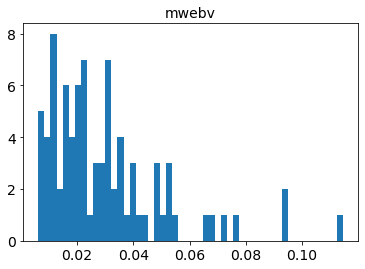

In [174]:
histogramas_estadisticas_resultados(ajustes_SALT2_early_SNIa_z_bounded_cortes_trest)

Estadísticas de los ajustes, ordenados por valor de chisq/ndof

In [175]:
estadisticas_SALT2_z_bounded_cortes_trest = estadisticas_resultados(ajustes_SALT2_early_SNIa_z_bounded_cortes_trest).sort_values(by=['chisq/ndof'])

Listas de los oid y de los valores de chisq/ndof del ajuste con con el modelo SALT2 y redshift variable, utilizando los puntos que pertenecen al rango de tiempo del modelo (determinado con los valores de $t_0$ del primer ajuste y $z=0$), ordenados según el valor de chisq/ndof

In [176]:
lista_oid_SALT2_z_bounded_cortes_trest = list(estadisticas_SALT2_z_bounded_cortes_trest['oid'])
lista_chisq_vs_ndof_SALT2_z_bounded_cortes_trest = list(estadisticas_SALT2_z_bounded_cortes_trest['chisq/ndof'])

Filas de los resultados del ajuste con chisq/ndof sobre la 
mediana 

In [177]:
median_chisq_vs_ndof_SALT2_z_bounded_cortes_trest = np.median(np.array(estadisticas_SALT2_z_bounded_cortes_trest['chisq/ndof']))
df_chisq_vs_ndof_SALT2_z_bounded_sobre_mediana_cortes_trest = estadisticas_SALT2_z_bounded_cortes_trest[estadisticas_SALT2_z_bounded_cortes_trest['chisq/ndof'] > median_chisq_vs_ndof_SALT2_z_bounded_cortes_trest].reset_index()
lista_oid_SALT2_z_bounded_sobre_mediana_cortes_trest = list(df_chisq_vs_ndof_SALT2_z_bounded_sobre_mediana_cortes_trest['oid'])

Mostrar algunas columnas de los resultados del ajuste, con valores de chisq/ndof sobre la mediana

In [178]:
display(df_chisq_vs_ndof_SALT2_z_bounded_sobre_mediana_cortes_trest[['oid', 
                                                                     'chisq/ndof', 
                                                                     'z', 
                                                                     'z_err', 
                                                                     't0', 
                                                                     't0_err']])

oid  chisq/ndof             z     z_err            t0    t0_err
0   ZTF18abpamut    1.436336  1.059142e-01  0.024055  58367.798699  0.206461
1   ZTF18aaumlfl    1.441130  1.830432e-02  0.011164  58265.035894  0.274117
2   ZTF18abimsyv    1.464449  8.639310e-02  0.009287  58334.425352  0.154028
3   ZTF18abckujg    1.470136  3.203560e-02  0.010291  58302.909650  0.233203
4   ZTF18abdbuty    1.635361  1.045593e-01  0.016046  58308.315705  0.161745
5   ZTF18abclalx    1.650098  1.756881e-02  0.016390  58300.363622  0.366216
6   ZTF18abdkimx    1.669320  7.622732e-02  0.018675  58313.830874  0.144141
7   ZTF18aaxwjmp    1.680652  5.301183e-02  0.012041  58288.218599  0.129118
8   ZTF18abjvhec    1.691556  1.501537e-01  0.012534  58340.953026  0.110068
9   ZTF18abtnlik    1.721071  8.695092e-02  0.048239  58379.073481  0.239922
10  ZTF18abealop    1.861882  3.247451e-09  0.012965  58315.374825  0.198179
11  ZTF18aaxrvzj    1.920324  1.178836e-01  0.015490  58286.183747  0.200983
12  ZTF18abcrxoj    2.004513  3.415388e-02  0.004325  58306.296634  0.081488
13  ZTF18abcflnz    2.061916  2.684695e-02  0.003353  58306.280478  0.078558
14  ZTF18aaxqyki    2.099740  1.067138e-01  0.030327  58286.563808  0.405805
15  ZTF18abbvsiv    2.177086  9.005517e-02  0.008405  58296.998725  0.093202
16  ZTF18abdefet    2.197985  4.841154e-02  0.021158  58307.433272  0.326181
17  ZTF18abetewu    2.291253  7.581996e-02  0.019337  58318.782768  0.196628
18  ZTF18abkifng    2.312953  5.837695e-02  0.067323  58343.395970  0.469716
19  ZTF18aayjvve    2.480381  1.021468e-01  0.008205  58292.383256  0.098786
20  ZTF18aaunfqq    2.546854  1.985458e-02  0.007606  58267.936854  0.184393
21  ZTF18aaytovs    3.185264  7.939857e-02  0.010037  58294.420618  0.104642
22  ZTF18aazcoob    3.517563  1.763001e-01  0.013175  58295.092952  0.239172
23  ZTF18aavrwhu    3.840133  8.031302e-02  0.010384  58275.916916  0.082200
24  ZTF18aavrzxp    4.093312  5.058892e-02  0.008036  58270.237532  0.151032
25  ZTF18abauprj    4.231571  1.918324e-02  0.002053  58301.948747  0.052802
26  ZTF18abetehf    4.290493  1.166007e-01  0.008839  58318.764904  0.115277
27  ZTF18aaqqoqs    4.654404  7.619708e-02  0.009624  58262.563744  0.075840
28  ZTF18aauocnw    4.822691  5.881110e-02  0.010600  58268.888972  0.125803
29  ZTF18abgmcmv    4.837564  9.017189e-02  0.002902  58329.757939  0.057250
30  ZTF18aatzygk    5.718754  9.591062e-02  0.013482  58262.375364  0.165831
31  ZTF18aaxcntm    6.076510  3.078836e-02  0.002140  58279.099522  0.036476
32  ZTF18aaqffyp    6.107432  6.020236e-02  0.008860  58254.639819  0.080533
33  ZTF18aaumeys    6.208018  2.919801e-02  0.004606  58267.156041  0.072094
34  ZTF18aaxsioa    6.790919  3.933633e-02  0.002481  58286.233106  0.044870
35  ZTF18aaxdrjn    7.362290  5.815731e-02  0.003107  58279.326747  0.041383
36  ZTF18aawjywv   10.430267  6.650745e-02  0.013496  58271.720195  0.091449
37  ZTF18aaslhxt   13.311370  8.162446e-02  0.004078  58263.804083  0.033579
38  ZTF18abuqugw   16.923946  9.195510e-02  0.005998  58384.751181  0.082137
39  ZTF18aasdted   17.480030  2.720105e-02  0.000955  58265.452732  0.020384
40  ZTF18aaqcqvr   19.352286  4.389275e-02  0.006141  58256.310499  0.106962

Intersección de los oid de las SN con valores de chisq/ndof mayores a la mediana de los ajustes con SALT2 y $z$ variable antes y después de eliminar los puntos fuera del rango de tiempo del modelo como si en el primer ajuste estuviese en el sistema de referencia en reposo (cota inferior del rango de tiempo)

In [179]:
inter_oid_SALT2_z_bounded_sobre_mediana_cortes_trest = np.intersect1d(np.array(lista_oid_SALT2_z_var_sobre_mediana),
                                                              np.array(lista_oid_SALT2_z_bounded_sobre_mediana_cortes_trest))
print('Elementos comunes sobre la mediana de chisq/ndof : ',
      len(inter_oid_SALT2_z_bounded_sobre_mediana_cortes_trest))

Elementos comunes sobre la mediana de chisq/ndof :  34


Tabla de astropy con las detecciones que están en el rango de tiempo del modelo, en el formato que requiere sncosmo para hacer los ajustes 

In [180]:
table_early_SNIa_SALT2_z_bounded_cortes_trest = astropy_table_detections(df_meta_early_SNIa_sin_SN50, 
                                                                         detect_early_SNIa_SALT2_z_bounded_cortes_trest)

Los gráficos se parecen mucho a aquellos con redshift real

Algunos gráficos de ajustes con $\frac{\chi^2}{ndof}$ mayor a la mediana

 ==== Con ajuste del redshift ====
chisq/ndof :  2.1770862128757935


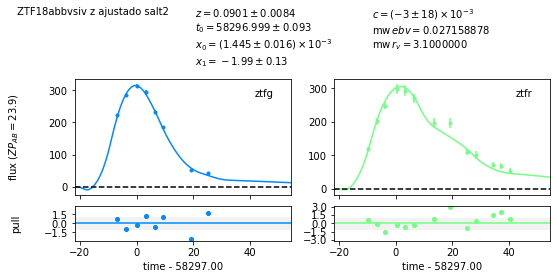

In [181]:
ajuste(lista_oid_SALT2_z_bounded_sobre_mediana_cortes_trest[15], 'salt2', df_meta_early_SNIa_sin_SN50, 
       table_early_SNIa_SALT2_z_bounded_cortes_trest, version='2.4', z_bounds=z_bounds)[0]
print('chisq/ndof : ', df_chisq_vs_ndof_SALT2_z_bounded_sobre_mediana_cortes_trest['chisq/ndof'][15])

 ==== Con ajuste del redshift ====
chisq/ndof :  4.290493432303422


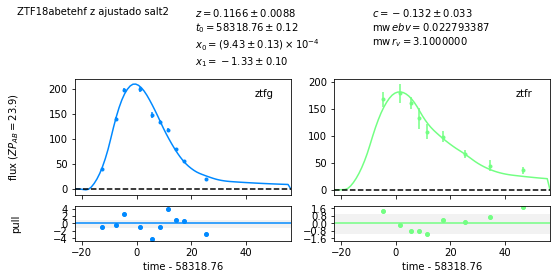

In [182]:
ajuste(lista_oid_SALT2_z_bounded_sobre_mediana_cortes_trest[26], 'salt2', df_meta_early_SNIa_sin_SN50, 
       table_early_SNIa_SALT2_z_bounded_cortes_trest, version='2.4', z_bounds=z_bounds)[0]
print('chisq/ndof : ', df_chisq_vs_ndof_SALT2_z_bounded_sobre_mediana_cortes_trest['chisq/ndof'][26])

 ==== Con ajuste del redshift ====
chisq/ndof :  4.654403592280115


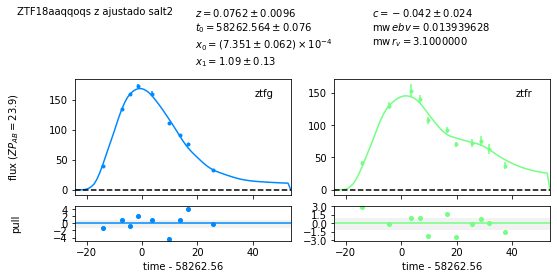

In [183]:
ajuste(lista_oid_SALT2_z_bounded_sobre_mediana_cortes_trest[27], 'salt2', df_meta_early_SNIa_sin_SN50, 
       table_early_SNIa_SALT2_z_bounded_cortes_trest, version='2.4', z_bounds=z_bounds)[0]
print('chisq/ndof : ', df_chisq_vs_ndof_SALT2_z_bounded_sobre_mediana_cortes_trest['chisq/ndof'][27])

 ==== Con ajuste del redshift ====
chisq/ndof :  5.718753898085726


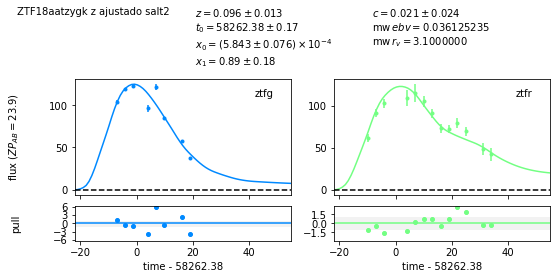

In [184]:
ajuste(lista_oid_SALT2_z_bounded_sobre_mediana_cortes_trest[30], 'salt2', df_meta_early_SNIa_sin_SN50, 
       table_early_SNIa_SALT2_z_bounded_cortes_trest, version='2.4', z_bounds=z_bounds)[0]
print('chisq/ndof : ', df_chisq_vs_ndof_SALT2_z_bounded_sobre_mediana_cortes_trest['chisq/ndof'][30])

 ==== Con ajuste del redshift ====
chisq/ndof :  6.208018491940477


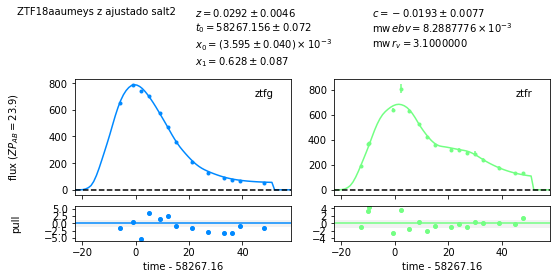

In [185]:
ajuste(lista_oid_SALT2_z_bounded_sobre_mediana_cortes_trest[33], 'salt2', df_meta_early_SNIa_sin_SN50, 
       table_early_SNIa_SALT2_z_bounded_cortes_trest, version='2.4', z_bounds=z_bounds)[0]
print('chisq/ndof : ', df_chisq_vs_ndof_SALT2_z_bounded_sobre_mediana_cortes_trest['chisq/ndof'][33])

 ==== Con ajuste del redshift ====
chisq/ndof :  6.790918609266918


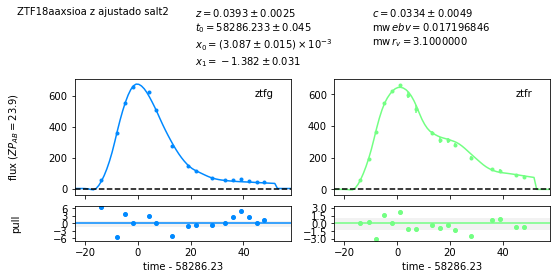

In [186]:
ajuste(lista_oid_SALT2_z_bounded_sobre_mediana_cortes_trest[34], 'salt2', df_meta_early_SNIa_sin_SN50, 
       table_early_SNIa_SALT2_z_bounded_cortes_trest, version='2.4', z_bounds=z_bounds)[0]
print('chisq/ndof : ', df_chisq_vs_ndof_SALT2_z_bounded_sobre_mediana_cortes_trest['chisq/ndof'][34])

 ==== Con ajuste del redshift ====
chisq/ndof :  19.35228616992267


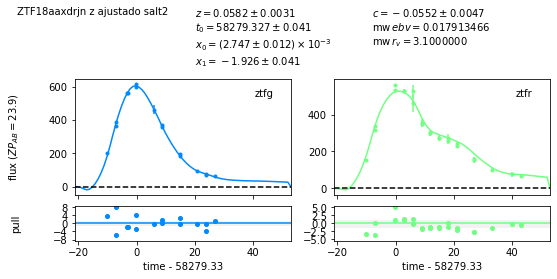

In [187]:
ajuste(lista_oid_SALT2_z_bounded_sobre_mediana_cortes_trest[35], 'salt2', df_meta_early_SNIa_sin_SN50, 
       table_early_SNIa_SALT2_z_bounded_cortes_trest, version='2.4', z_bounds=z_bounds)[0]
print('chisq/ndof : ', df_chisq_vs_ndof_SALT2_z_bounded_sobre_mediana_cortes_trest['chisq/ndof'][40])

 ==== Con ajuste del redshift ====
chisq/ndof :  17.480030395825924


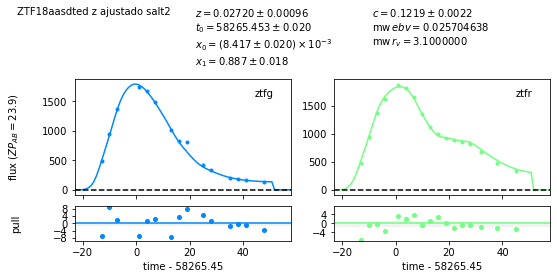

In [188]:
ajuste(lista_oid_SALT2_z_bounded_sobre_mediana_cortes_trest[39], 'salt2', df_meta_early_SNIa_sin_SN50, 
       table_early_SNIa_SALT2_z_bounded_cortes_trest, version='2.4', z_bounds=z_bounds)[0]
print('chisq/ndof : ', df_chisq_vs_ndof_SALT2_z_bounded_sobre_mediana_cortes_trest['chisq/ndof'][39])

 ==== Con ajuste del redshift ====
chisq/ndof :  19.35228616992267


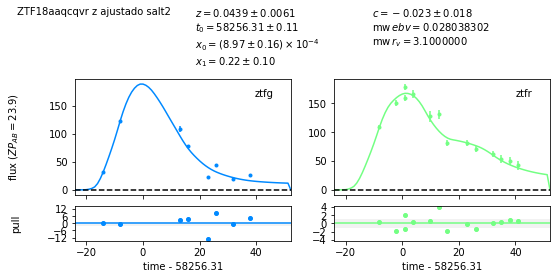

In [189]:
ajuste(lista_oid_SALT2_z_bounded_sobre_mediana_cortes_trest[40], 'salt2', df_meta_early_SNIa_sin_SN50, 
       table_early_SNIa_SALT2_z_bounded_cortes_trest, version='2.4', z_bounds=z_bounds)[0]
print('chisq/ndof : ', df_chisq_vs_ndof_SALT2_z_bounded_sobre_mediana_cortes_trest['chisq/ndof'][40])

# Ajustes con el modelo SALT3

## Primeros ajustes

### Ajuste con el redshift verdadero

In [190]:
ajustes_SALT3_z_fijo_early_SNIa = modelo_ajustado_y_resultados('salt3', df_meta_early_SNIa, 
                                                               detect_early_SNIa, 
                                                               z_real=True,
                                                               print_ind_and_oid=False)

rango ncall : 89, 162
promedio ncall : 106.80952380952381
desviación estándar ncall : 14.61528569559004
mediana ncall : 103.0


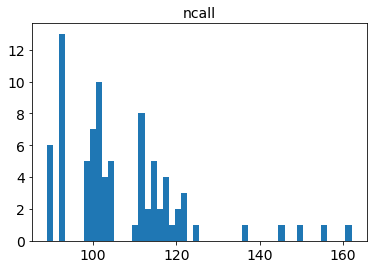

rango chisq : 1.3724525208077036, 21735.96244751
promedio chisq : 790.3411273856777
desviación estándar chisq : 3222.844436170987
mediana chisq : 34.93159554507993


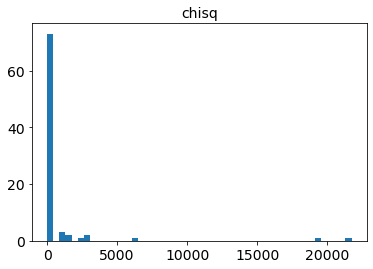

rango ndof : 4, 71
promedio ndof : 23.904761904761905
desviación estándar ndof : 15.012390951682805
mediana ndof : 18.0


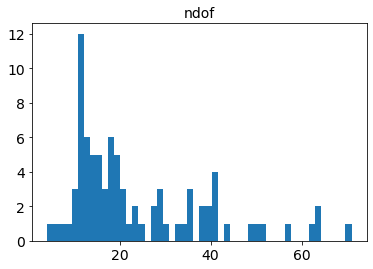

rango chisq/ndof : 0.3431131302019259, 309.02229400174525
promedio chisq/ndof : 15.956212787072499
desviación estándar chisq/ndof : 50.38067528711346
mediana chisq/ndof : 1.6837604071806982


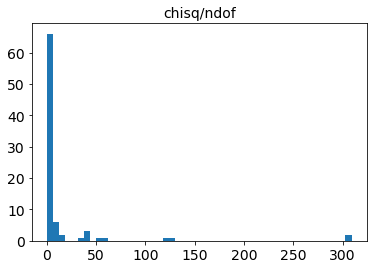

rango z : 0.0181, 0.14
promedio z : 0.07072857142857143
desviación estándar z : 0.026406531350391015
mediana z : 0.07135


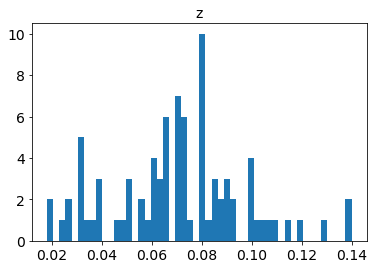

rango t0 : 58254.61862931233, 58395.71445713421
promedio t0 : 58319.849009309386
desviación estándar t0 : 38.75841146836877
mediana t0 : 58313.892844459384


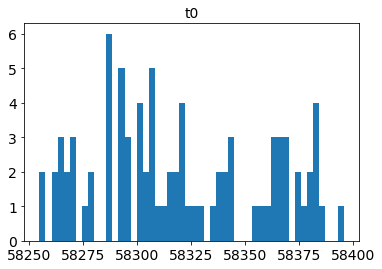

rango t0_err : 0.008853099894622574, 1.140970089356415
promedio t0_err : 0.1762610863579972
desviación estándar t0_err : 0.200773940864145
mediana t0_err : 0.123673425105153


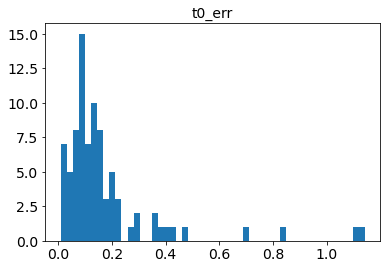

rango x0 : 0.00022861361160102106, 0.011206006717653856
promedio x0 : 0.001367952083676558
desviación estándar x0 : 0.001806790295559205
mediana x0 : 0.0007163682635537


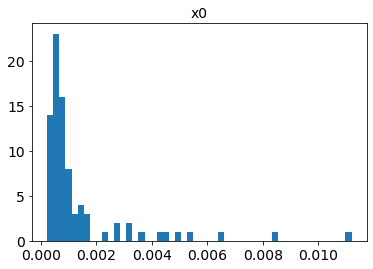

rango x0_err : 4.16418186005795e-06, 6.601356749639282e-05
promedio x0_err : 1.4219402881136581e-05
desviación estándar x0_err : 1.0656673172901915e-05
mediana x0_err : 1.0276989244245858e-05


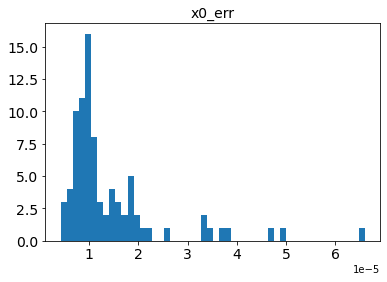

rango x1 : -2.526995129528115, 2.4762138017941413
promedio x1 : 0.06250761861593569
desviación estándar x1 : 1.0933173957010784
mediana x1 : 0.22375992543177758


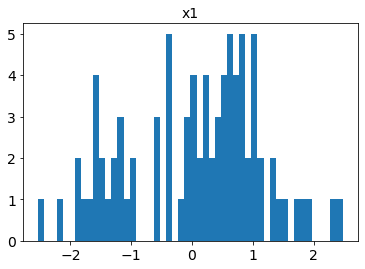

rango x1_err : 0.014901048227003276, 2.174432525459371
promedio x1_err : 0.23341298818143302
desviación estándar x1_err : 0.29146235790616043
mediana x1_err : 0.161855801646897


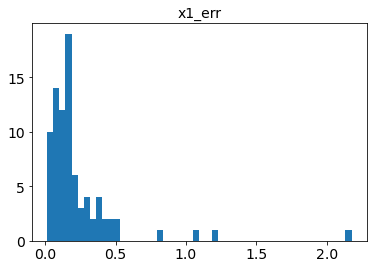

rango c : -0.18078217842949446, 0.6439642875639199
promedio c : 0.017533281753730843
desviación estándar c : 0.11972776813874117
mediana c : 0.002611182220189864


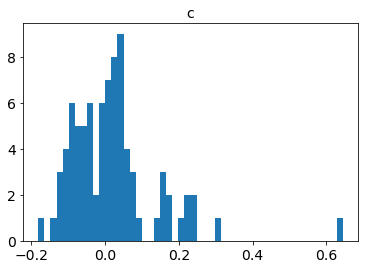

rango c_err : 0.0020820868954110577, 0.13190022716449315
promedio c_err : 0.025071420907213794
desviación estándar c_err : 0.016901873961081948
mediana c_err : 0.02172566609612752


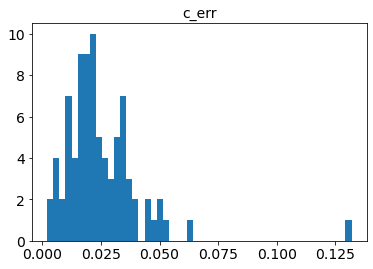

rango mwebv : 0.006204556550167132, 0.1144183424611353
promedio mwebv : 0.03064786661830939
desviación estándar mwebv : 0.02142708623940601
mediana mwebv : 0.02451353213255834


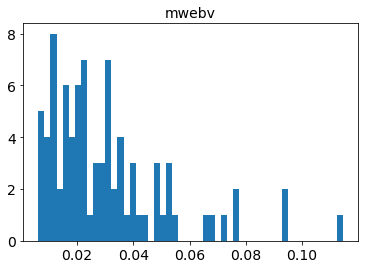

In [191]:
histogramas_estadisticas_resultados(ajustes_SALT3_z_fijo_early_SNIa, z_real=True)

Estadísticas de los ajustes, ordenados por valor de chisq/ndof

In [192]:
estadisticas_SALT3_z_fijo = estadisticas_resultados(ajustes_SALT3_z_fijo_early_SNIa, 
                                                    z_real=True).sort_values(by=['chisq/ndof'])

Listas de los oid y de los valores de chisq/ndof del primer ajuste
con SALT2 y redshift real, ordenados según el valor de chisq/ndof

In [193]:
lista_oid_SALT3_z_fijo = list(estadisticas_SALT3_z_fijo['oid'])
lista_chisq_vs_ndof_SALT3_z_fijo = list(estadisticas_SALT3_z_fijo['chisq/ndof'])

Filas de los resultados del ajuste con chisq/ndof sobre la 
mediana

In [194]:
median_chisq_vs_ndof_SALT3_z_fijo = np.median(np.array(estadisticas_SALT3_z_fijo['chisq/ndof']))
df_chisq_vs_ndof_SALT3_z_fijo_sobre_mediana = estadisticas_SALT3_z_fijo[estadisticas_SALT3_z_fijo['chisq/ndof'] > median_chisq_vs_ndof_SALT3_z_fijo].reset_index()
lista_oid_SALT3_z_fijo_sobre_mediana = list(df_chisq_vs_ndof_SALT3_z_fijo_sobre_mediana['oid'])

Mostrar algunas columnas de los resultados del ajuste, con valores de chisq/ndof sobre la mediana

In [195]:
display(df_chisq_vs_ndof_SALT3_z_fijo_sobre_mediana[['oid', 
                                                    'chisq/ndof',
                                                    'z', 
                                                    't0', 
                                                    't0_err']])

oid  chisq/ndof       z            t0    t0_err
0   ZTF18abpamut    1.742925  0.0720  58367.688928  0.147617
1   ZTF18absdgon    1.746921  0.0620  58375.934626  0.121366
2   ZTF18abtnlik    1.750879  0.0900  58379.084046  0.153028
3   ZTF18abdbuty    1.820153  0.0600  58307.994801  0.125981
4   ZTF18aazsabq    1.860961  0.0500  58293.972076  0.083865
5   ZTF18abclalx    1.905211  0.1000  58301.077940  0.187440
6   ZTF18abealop    1.924834  0.0666  58316.176128  0.189972
7   ZTF18abpaywm    1.979794  0.0450  58367.922646  0.083202
8   ZTF18abckujg    2.037916  0.0740  58303.421237  0.155806
9   ZTF18aaxqyki    2.071909  0.1003  58286.408991  0.128616
10  ZTF18abetewu    2.116499  0.0740  58318.805022  0.195059
11  ZTF18abdefet    2.172546  0.0700  58307.527539  0.221606
12  ZTF18abbpeqo    2.439711  0.0667  58300.564039  0.092127
13  ZTF18aazblzy    2.451922  0.0653  58291.735197  0.048067
14  ZTF18aazcoob    3.098912  0.0845  58294.464845  0.143561
15  ZTF18aaunfqq    3.683995  0.0711  58268.654652  0.095300
16  ZTF18abeecwe    3.787167  0.0393  58319.683379  0.073116
17  ZTF18abetehf    4.268569  0.0649  58318.544224  0.095768
18  ZTF18aavrzxp    4.336242  0.0700  58270.522110  0.095923
19  ZTF18abbvsiv    4.443372  0.0510  58296.788111  0.087649
20  ZTF18aavrwhu    5.070502  0.0620  58275.829125  0.068414
21  ZTF18aaqqoqs    5.632903  0.0800  58262.589210  0.061376
22  ZTF18aaqffyp    5.813066  0.0640  58254.618629  0.059198
23  ZTF18aaytovs    5.862588  0.0746  58294.373015  0.090958
24  ZTF18aauocnw    7.050656  0.1000  58269.065978  0.092170
25  ZTF18aaxdrjn    7.697698  0.0340  58279.024992  0.024464
26  ZTF18aawjywv    9.061203  0.0400  58271.503985  0.055787
27  ZTF18aayjvve    9.183911  0.0474  58292.045974  0.059238
28  ZTF18aatzygk    9.704415  0.0740  58262.181607  0.116401
29  ZTF18aaumlfl   11.170120  0.0874  58265.890002  0.131259
30  ZTF18aaslhxt   17.160085  0.0509  58263.635011  0.023169
31  ZTF18aaqcqvr   18.239803  0.0716  58256.522277  0.060114
32  ZTF18abfhryc   32.037375  0.0323  58324.027612  0.059370
33  ZTF18abcrxoj   38.109525  0.0309  58306.317422  0.051306
34  ZTF18aaumeys   41.614908  0.0365  58267.226855  0.027897
35  ZTF18abgmcmv   43.527976  0.0185  58328.837614  0.050930
36  ZTF18aaxsioa   53.330964  0.0315  58286.129432  0.024683
37  ZTF18aaxcntm   56.407762  0.0269  58279.026308  0.023796
38  ZTF18abuqugw  122.983823  0.0313  58384.136810  0.083168
39  ZTF18abcflnz  129.118930  0.0273  58306.363402  0.040808
40  ZTF18aasdted  306.140316  0.0181  58265.184051  0.008853
41  ZTF18abauprj  309.022294  0.0242  58302.234667  0.025706

Se ve que los valores de $\frac{\chi^{2}}{ndof}$  son muy altos, pese a que se esté usando el redshift real de la SN Ia para hacer los ajustes. Veamos si esto también pasa al ajustar el redshift de las SN y analicemos ese caso.

### Ajuste con redshift variable (se debe eliminar una SN de los datos ya que no se puede ajustar, si no se elimina el programa se cae)

In [196]:
name_52 = names_SNIa[52]
print('Eliminada ', name_52)
df_meta_early_SNIa_sin_SN52 = df_meta_early_SNIa[df_meta_early_SNIa.oid != name_52]

detect_early_SNIa_sin_SN52 = detect_early_SNIa[detect_early_SNIa["oid"]!=name_52]
ajustes_SALT3_early_SNIa_sin_SN52 = modelo_ajustado_y_resultados('salt3', 
                                                                 df_meta_early_SNIa_sin_SN52, 
                                                                 detect_early_SNIa_sin_SN52,
                                                                 print_ind_and_oid=False)

Eliminada  ZTF18abgmcmv


Link en ALeRCE ZTF explorer de esta SN: https://alerce.online/object/ZTF18abgmcmv

rango ncall : 149, 1379
promedio ncall : 366.2048192771084
desviación estándar ncall : 203.60916725143483
mediana ncall : 290.0


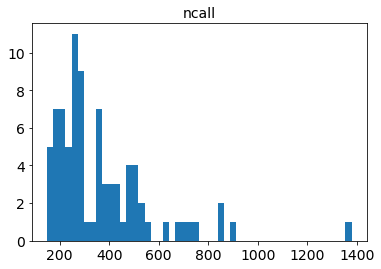

rango chisq : 1.4803418175203376, 22839.341198740418
promedio chisq : 724.1288634368391
desviación estándar chisq : 3269.606186412705
mediana chisq : 36.11884074522361


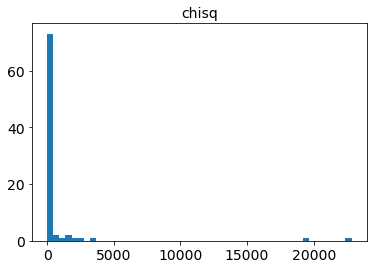

rango ndof : 3, 70
promedio ndof : 22.44578313253012
desviación estándar ndof : 14.50488327579835
mediana ndof : 17.0


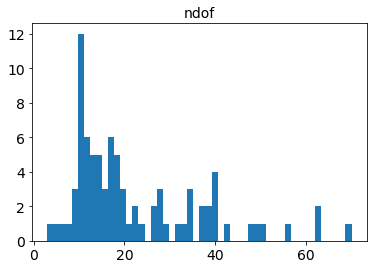

rango chisq/ndof : 0.4772206745634247, 326.27630283914885
promedio chisq/ndof : 15.012223669124726
desviación estándar chisq/ndof : 50.99437378781936
mediana chisq/ndof : 1.8784104405068656


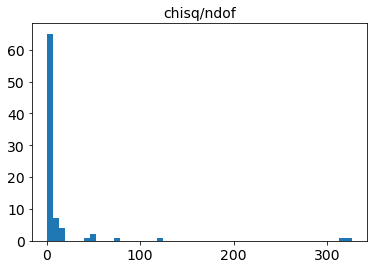

rango z : 0.0010000110338847289, 0.3398382504375163
promedio z : 0.17029670721358436
desviación estándar z : 0.09538152710675245
mediana z : 0.1763660391644759


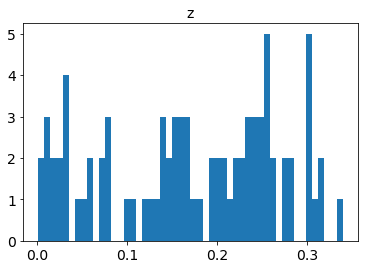

rango z_err : 2.9966641529322047e-09, 0.42086287313204446
promedio z_err : 0.027400925511172288
desviación estándar z_err : 0.049897427777295306
mediana z_err : 0.01720263135007108


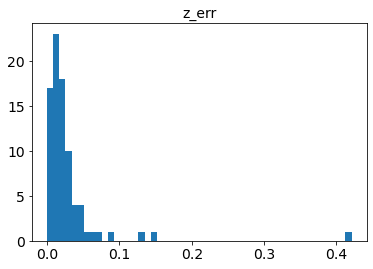

rango t0 : 58256.76099932384, 58395.08339788103
promedio t0 : 58320.612837883586
desviación estándar t0 : 38.85804708907236
mediana t0 : 58313.78372371998


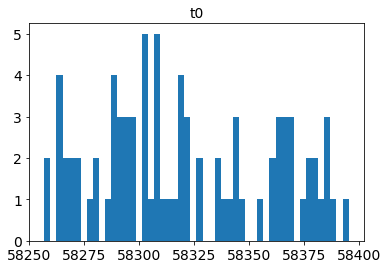

rango t0_err : 1.0899384506046772e-08, 131.59025160868987
promedio t0_err : 1.8840728348319777
desviación estándar t0_err : 14.327997652286674
mediana t0_err : 0.21342008079591324


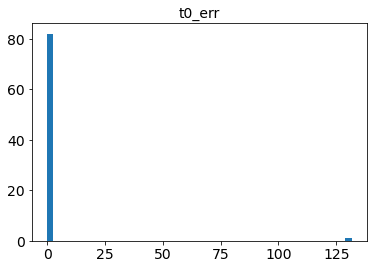

rango x0 : 0.00022795865919194336, 0.011421403851412899
promedio x0 : 0.0012789150583486877
desviación estándar x0 : 0.001709401311224778
mediana x0 : 0.0006649752247342893


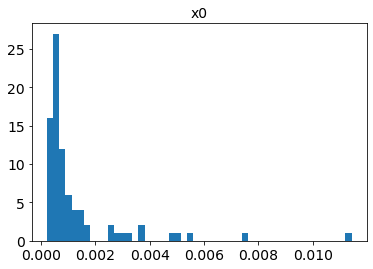

rango x0_err : 5.8647997696926295e-06, 1.0054245570771978
promedio x0_err : 0.024183357286007238
desviación estándar x0_err : 0.15377641499888395
mediana x0_err : 1.4922804751719194e-05


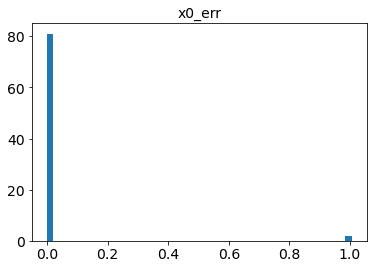

rango x1 : -2.5865571708243507, 3.999999928222608
promedio x1 : 0.054759577463091264
desviación estándar x1 : 1.228429439891589
mediana x1 : 0.15962901988828104


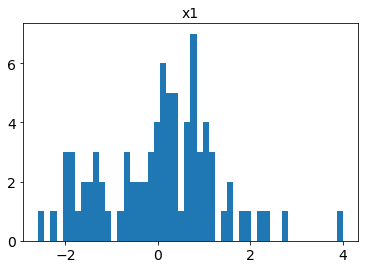

rango x1_err : 0.011042941176991672, 5.896671916029722
promedio x1_err : 0.3957232725468561
desviación estándar x1_err : 0.893229972229552
mediana x1_err : 0.19259797240889776


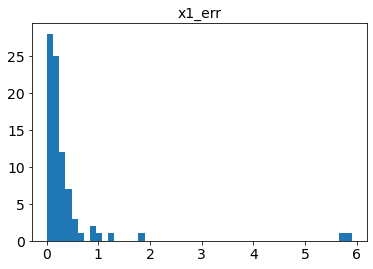

rango c : -0.3506298480117703, 0.2723707852536782
promedio c : -0.08640923078987746
desviación estándar c : 0.12272085739980527
mediana c : -0.08914624742829658


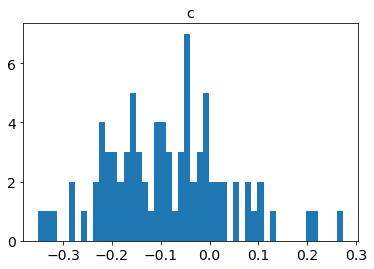

rango c_err : 0.0016252497278006622, 0.5079693999832624
promedio c_err : 0.045194612410604185
desviación estándar c_err : 0.07117298639845383
mediana c_err : 0.030741872784684904


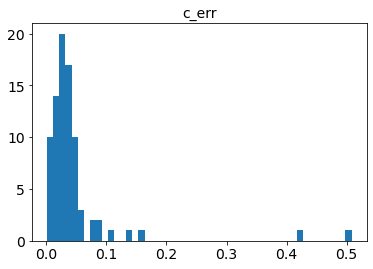

rango mwebv : 0.006204556550167132, 0.1144183424611353
promedio mwebv : 0.030530745972028404
desviación estándar mwebv : 0.02152903487450753
mediana mwebv : 0.023404313345236558


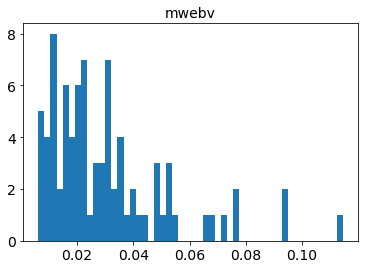

In [197]:
histogramas_estadisticas_resultados(ajustes_SALT3_early_SNIa_sin_SN52)

Estadísticas de los ajustes, ordenados por valor de chisq/ndof

In [198]:
estadisticas_SALT3_z_var = estadisticas_resultados(ajustes_SALT3_early_SNIa_sin_SN52).sort_values(by=['chisq/ndof'])

Listas de los oid y de los valores de chisq/ndof del primer ajuste
con SALT3 y redshift variable, ordenados según el valor de chisq/ndof

In [199]:
lista_oid_SALT3_z_var = list(estadisticas_SALT3_z_var['oid'])
lista_chisq_vs_ndof_SALT3_z_var = list(estadisticas_SALT3_z_var['chisq/ndof'])

Filas de los resultados del ajuste con chisq/ndof sobre la 
mediana 

In [200]:
median_chisq_vs_ndof_SALT3_z_var = np.median(np.array(estadisticas_SALT3_z_var['chisq/ndof']))
df_chisq_vs_ndof_SALT3_z_var_sobre_mediana = estadisticas_SALT3_z_var[estadisticas_SALT3_z_var['chisq/ndof'] > median_chisq_vs_ndof_SALT3_z_var].reset_index()
lista_oid_SALT3_z_var_sobre_mediana = list(df_chisq_vs_ndof_SALT3_z_var_sobre_mediana['oid'])

Mostrar algunas columnas de los resultados del ajuste, con valores de chisq/ndof sobre la mediana

In [201]:
display(df_chisq_vs_ndof_SALT3_z_var_sobre_mediana[['oid', 
                                                    'chisq/ndof',
                                                    'z', 
                                                    'z_err', 
                                                    't0', 
                                                    't0_err']])

oid  chisq/ndof         z         z_err            t0  \
0   ZTF18aazjztm    1.970341  0.301664  1.897528e-02  58293.197921   
1   ZTF18abtnlik    2.035663  0.263541  2.632175e-02  58380.518237   
2   ZTF18abimsyv    2.178769  0.240571  9.676009e-03  58336.302540   
3   ZTF18aaxwjmp    2.218599  0.302822  1.513047e-02  58290.293653   
4   ZTF18abclalx    2.266776  0.261197  2.244619e-02  58302.393653   
5   ZTF18abetewu    2.304188  0.069200  2.146927e-02  58318.796142   
6   ZTF18abbvsiv    2.438346  0.209085  1.003238e-02  58297.858941   
7   ZTF18abdefet    2.503095  0.156539  3.569423e-02  58307.885729   
8   ZTF18abbpeqo    2.725274  0.256408  1.911260e-06  58302.323243   
9   ZTF18abealop    2.733973  0.308337  2.184332e-02  58318.181160   
10  ZTF18aazcoob    2.748277  0.209750  1.720263e-02  58295.977054   
11  ZTF18abrzeym    2.754702  0.302488  1.754064e-02  58375.891087   
12  ZTF18aaxqyki    2.965502  0.251277  1.487892e-02  58287.876362   
13  ZTF18abeecwe    2.971723  0.079761  3.441223e-09  58320.177072   
14  ZTF18abcsgvj    3.391030  0.253280  1.754492e-02  58304.966417   
15  ZTF18aansqun    3.611884  0.313789  2.298137e-02  58317.036016   
16  ZTF18abetehf    3.781271  0.253457  1.139823e-02  58320.057798   
17  ZTF18aazblzy    4.554183  0.235498  9.617532e-03  58293.011045   
18  ZTF18aayjvve    5.731235  0.077159  4.199854e-06  58292.315082   
19  ZTF18aaytovs    5.802400  0.339838  1.129753e-02  58297.385249   
20  ZTF18aavrwhu    6.277488  0.158732  9.107390e-03  58276.310875   
21  ZTF18aaunfqq    6.575474  0.251730  1.391596e-02  58270.058459   
22  ZTF18aavrzxp    6.742856  0.166034  1.121106e-02  58270.818055   
23  ZTF18aaqqoqs    7.396076  0.243850  8.178882e-03  58264.284813   
24  ZTF18aauocnw    7.947095  0.167651  3.209565e-02  58269.352893   
25  ZTF18aaqffyp    8.610028  0.300922  1.652987e-02  58256.760999   
26  ZTF18aaxdrjn    9.264974  0.128377  5.376229e-03  58279.670511   
27  ZTF18aaumlfl   10.221759  0.001354  7.150559e-02  58264.740042   
28  ZTF18aatzygk   10.239375  0.193616  1.822036e-02  58262.966273   
29  ZTF18aawjywv   11.887240  0.145280  1.085629e-02  58271.997701   
30  ZTF18abcrxoj   15.477804  0.219848  1.391685e-02  58308.249533   
31  ZTF18aaslhxt   16.986813  0.026008  4.140351e-03  58263.205212   
32  ZTF18abfhryc   17.566627  0.214724  1.129559e-03  58326.426278   
33  ZTF18aaqcqvr   19.788674  0.135976  1.460313e-02  58256.963531   
34  ZTF18aaumeys   44.682281  0.139218  3.676127e-03  58267.786808   
35  ZTF18aaxsioa   47.433305  0.228103  4.759755e-04  58287.837810   
36  ZTF18aaxcntm   50.470849  0.246177  2.996664e-09  58280.871609   
37  ZTF18abcflnz   73.878194  0.279888  4.208629e-01  58309.216271   
38  ZTF18abuqugw  123.885729  0.001000  9.460704e-04  58389.201229   
39  ZTF18abauprj  313.401111  0.013254  1.660300e-03  58301.956975   
40  ZTF18aasdted  326.276303  0.274949  1.805490e-07  58267.533284   

          t0_err  
0   2.571549e-01  
1   2.933191e-01  
2   1.965998e-01  
3   2.098405e-01  
4   2.972257e-01  
5   1.984565e-01  
6   1.659674e-01  
7   2.591158e-01  
8   1.462606e-04  
9   3.431250e-01  
10  3.138649e-01  
11  2.972548e-01  
12  1.670901e-01  
13  7.044946e-08  
14  1.819074e-01  
15  6.928132e-01  
16  1.332495e-01  
17  7.277858e-02  
18  7.629763e-05  
19  2.220452e-01  
20  8.786745e-02  
21  1.286627e-01  
22  1.277196e-01  
23  9.543800e-02  
24  3.156983e-01  
25  1.973404e-01  
26  3.245094e-02  
27  2.791645e-01  
28  3.679508e-01  
29  5.852614e-02  
30  1.256672e-01  
31  8.565812e-02  
32  2.145873e-02  
33  7.888143e-02  
34  2.961892e-02  
35  2.238089e-02  
36  1.089938e-08  
37  1.315903e+02  
38  3.256142e-02  
39  5.171764e-02  
40  2.006446e-05

Algunos gráficos de los ajustes de las SN que tienen valores de $\frac{\chi^{2}}{ndof}$ menores a la mediana.

 ==== Con ajuste del redshift ====
chisq/ndof :  0.4772206745634247


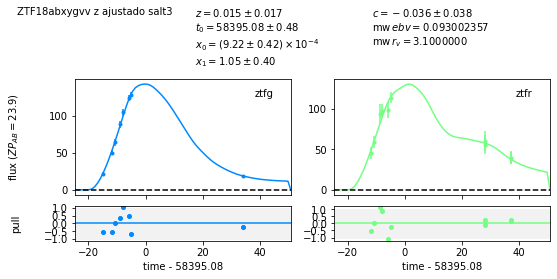

In [202]:
ajuste(lista_oid_SALT3_z_var[0], 'salt3', df_meta_early_SNIa, 
       table_early_SNIa)[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT3_z_var[0])

 ==== Con ajuste del redshift ====
chisq/ndof :  0.49344727250677917


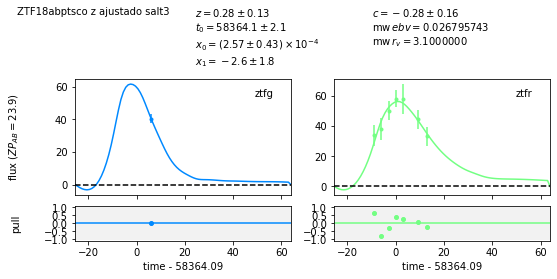

In [203]:
ajuste(lista_oid_SALT3_z_var[1], 'salt3', df_meta_early_SNIa, 
       table_early_SNIa)[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT3_z_var[1])

 ==== Con ajuste del redshift ====
chisq/ndof :  0.7328299296932578


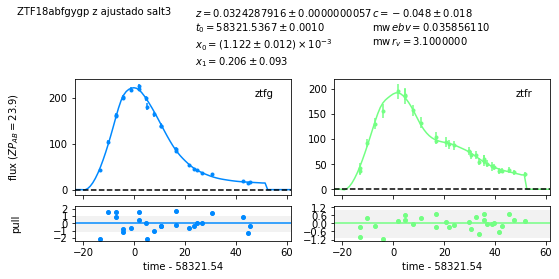

In [204]:
ajuste(lista_oid_SALT3_z_var[9], 'salt3', df_meta_early_SNIa, 
       table_early_SNIa)[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT3_z_var[9])

 ==== Con ajuste del redshift ====
chisq/ndof :  0.856670096717543


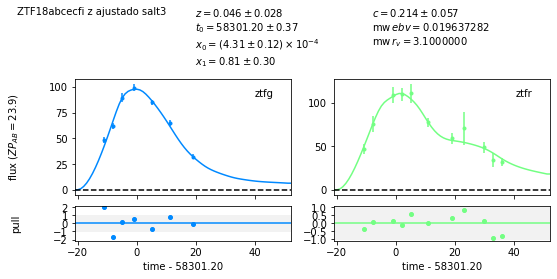

In [205]:
ajuste(lista_oid_SALT3_z_var[11], 'salt3', df_meta_early_SNIa, 
       table_early_SNIa)[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT3_z_var[11])

 ==== Con ajuste del redshift ====
chisq/ndof :  1.2642382034972446


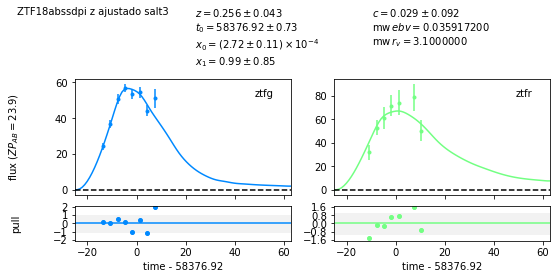

In [206]:
ajuste(lista_oid_SALT3_z_var[22], 'salt3', df_meta_early_SNIa, 
       table_early_SNIa)[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT3_z_var[22])

 ==== Con ajuste del redshift ====
chisq/ndof :  1.6416528750107602


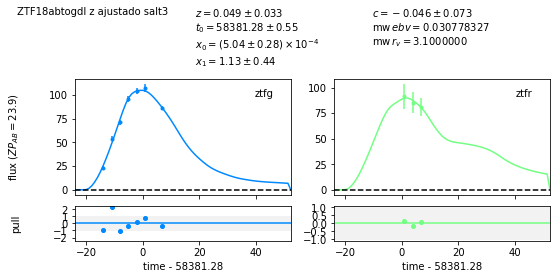

In [207]:
ajuste(lista_oid_SALT3_z_var[35], 'salt3', df_meta_early_SNIa, 
       table_early_SNIa)[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT3_z_var[35])

 ==== Con ajuste del redshift ====
chisq/ndof :  1.8757222060033736


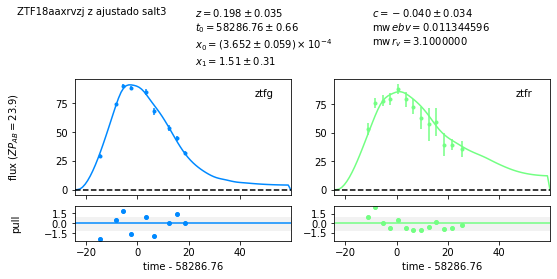

In [208]:
ajuste(lista_oid_SALT3_z_var[40], 'salt3', df_meta_early_SNIa, 
       table_early_SNIa)[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT3_z_var[40])

Algunos gráficos de los ajustes de las SN que tienen valores de $\frac{\chi^{2}}{ndof}$ mayores a la mediana.

 ==== Con ajuste del redshift ====
chisq/ndof :  2.0356625618238935


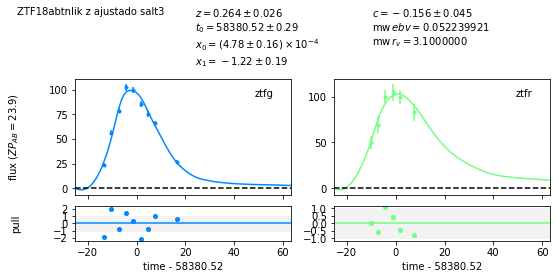

In [209]:
ajuste(lista_oid_SALT3_z_var_sobre_mediana[1], 'salt3', 
       df_meta_early_SNIa, table_early_SNIa)[0]
print('chisq/ndof : ', 
      df_chisq_vs_ndof_SALT3_z_var_sobre_mediana['chisq/ndof'][1])

 ==== Con ajuste del redshift ====
chisq/ndof :  2.5030950364639555


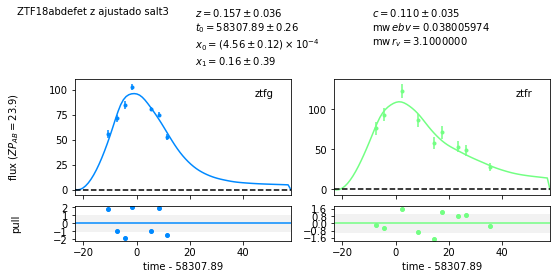

In [210]:
ajuste(lista_oid_SALT3_z_var_sobre_mediana[7], 'salt3', 
       df_meta_early_SNIa, table_early_SNIa)[0]
print('chisq/ndof : ', 
      df_chisq_vs_ndof_SALT3_z_var_sobre_mediana['chisq/ndof'][7])

 ==== Con ajuste del redshift ====
chisq/ndof :  2.748277446671471


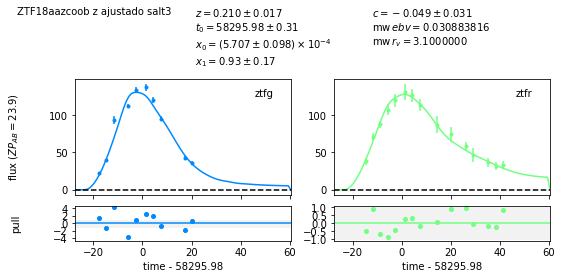

In [211]:
ajuste(lista_oid_SALT3_z_var_sobre_mediana[10], 'salt3', 
       df_meta_early_SNIa, table_early_SNIa)[0]
print('chisq/ndof : ', 
      df_chisq_vs_ndof_SALT3_z_var_sobre_mediana['chisq/ndof'][10])

 ==== Con ajuste del redshift ====
chisq/ndof :  2.971723323648


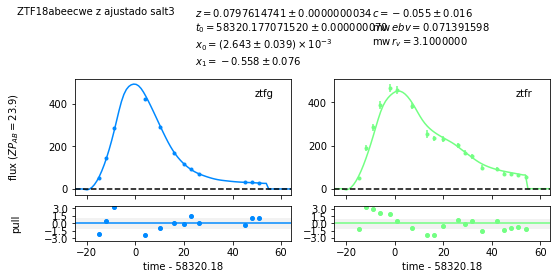

In [212]:
ajuste(lista_oid_SALT3_z_var_sobre_mediana[13], 'salt3', 
       df_meta_early_SNIa, table_early_SNIa)[0]
print('chisq/ndof : ', 
      df_chisq_vs_ndof_SALT3_z_var_sobre_mediana['chisq/ndof'][13])

 ==== Con ajuste del redshift ====
chisq/ndof :  4.55418325202497


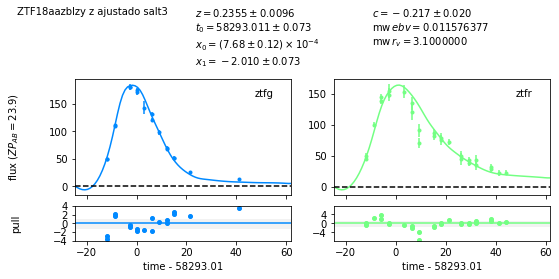

In [213]:
ajuste(lista_oid_SALT3_z_var_sobre_mediana[17], 'salt3', 
       df_meta_early_SNIa, table_early_SNIa)[0]
print('chisq/ndof : ', 
      df_chisq_vs_ndof_SALT3_z_var_sobre_mediana['chisq/ndof'][17])

 ==== Con ajuste del redshift ====
chisq/ndof :  5.802399755880406


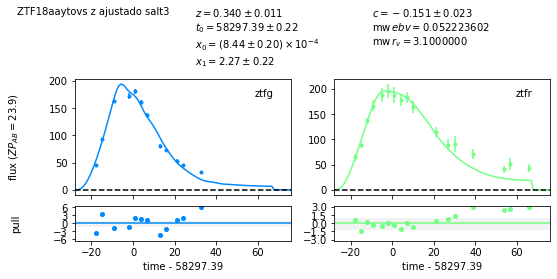

In [214]:
ajuste(lista_oid_SALT3_z_var_sobre_mediana[19], 'salt3', 
       df_meta_early_SNIa, table_early_SNIa)[0]
print('chisq/ndof : ', 
      df_chisq_vs_ndof_SALT3_z_var_sobre_mediana['chisq/ndof'][19])

 ==== Con ajuste del redshift ====
chisq/ndof :  73.8781940178702


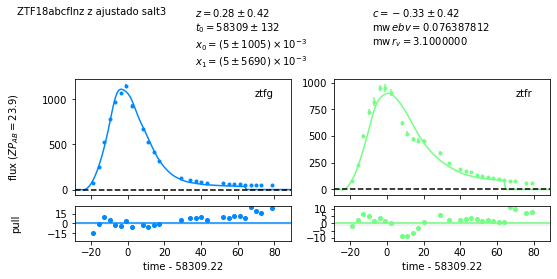

In [215]:
ajuste(lista_oid_SALT3_z_var_sobre_mediana[37], 'salt3', 
       df_meta_early_SNIa, table_early_SNIa)[0]
print('chisq/ndof : ', 
      df_chisq_vs_ndof_SALT3_z_var_sobre_mediana['chisq/ndof'][37])

 ==== Con ajuste del redshift ====
chisq/ndof :  123.88572912065412


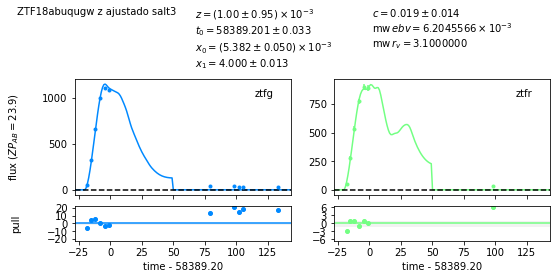

In [216]:
ajuste(lista_oid_SALT3_z_var_sobre_mediana[38], 'salt3', 
       df_meta_early_SNIa, table_early_SNIa)[0]
print('chisq/ndof : ', 
      df_chisq_vs_ndof_SALT3_z_var_sobre_mediana['chisq/ndof'][38])

 ==== Con ajuste del redshift ====
chisq/ndof :  313.4011106741384


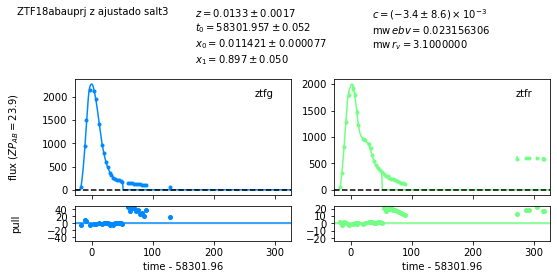

In [217]:
ajuste(lista_oid_SALT3_z_var_sobre_mediana[39], 'salt3', 
       df_meta_early_SNIa, table_early_SNIa)[0]
print('chisq/ndof : ', 
      df_chisq_vs_ndof_SALT3_z_var_sobre_mediana['chisq/ndof'][39])

Gráficamente los ajustes con los modelos SALT2 y SALT3 con redshift variable (ajustado en el modelo) son muy parecidos.

También pasa que el valor de $\frac{\chi^{2}}{ndof}$ aumenta mucho cuando hay puntos fuera del rango del modelo. Por lo que se harán cortes en las observaciones para estar dentro del rango de tiempo del modelo ($t$), determinado a partir del valor del tiempo del máximo ($t_0$) y del redshift ($z$) determinado en el primer ajuste, con $t_0 - 20 \cdot (1+z) \leq t \leq t_0 + 50 \cdot (1+z)$. 

## Ajuste con observaciones en el rango de tiempo del modelo (determinado con $t_0$ y $z$ del primer ajuste)

### Ajuste con redshift real

Seleccionar las detecciones de las SN que están dentro del rango de tiempo del modelo según el primer ajuste con el modelo SALT3 y redshift real

In [218]:
detect_early_SNIa_cortes_t_SALT3_z_fijo = cortes_t_modelo(trest_min_modelo, 
                                                          trest_max_modelo, 
                                                          detect_early_SNIa,
                                                          estadisticas_SALT3_z_fijo)

Ajustes con las detecciones de las SN que están dentro del rango de tiempo del modelo

In [219]:
ajustes_SALT3_z_fijo_early_SNIa_cortes_t = modelo_ajustado_y_resultados('salt3',
                                                                        df_meta_early_SNIa,
                                                                        detect_early_SNIa_cortes_t_SALT3_z_fijo,  
                                                                        z_real=True,
                                                                        print_ind_and_oid=False)

rango ncall : 89, 159
promedio ncall : 106.82142857142857
desviación estándar ncall : 14.397553292706595
mediana ncall : 103.0


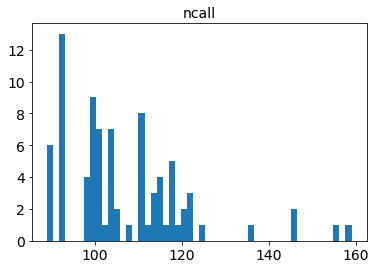

rango chisq : 1.3724525208077036, 990.6478981219617
promedio chisq : 76.95263493343786
desviación estándar chisq : 153.30867979072664
mediana chisq : 33.70174603780052


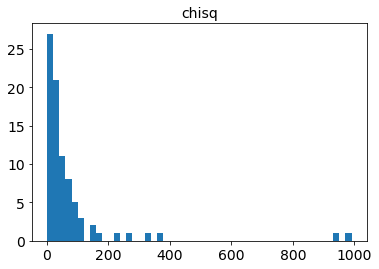

rango ndof : 4, 60
promedio ndof : 21.607142857142858
desviación estándar ndof : 11.77064332216753
mediana ndof : 18.0


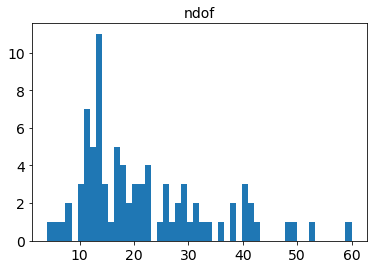

rango chisq/ndof : 0.3431131302019259, 33.41130039818293
promedio chisq/ndof : 3.2552841393287455
desviación estándar chisq/ndof : 5.224246720213584
mediana chisq/ndof : 1.5858349638230238


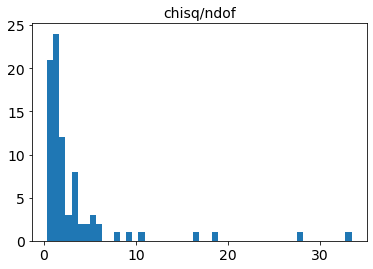

rango z : 0.0181, 0.14
promedio z : 0.07072857142857143
desviación estándar z : 0.026406531350391015
mediana z : 0.07135


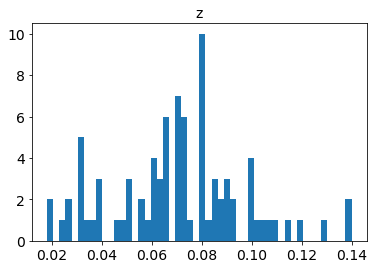

rango t0 : 58254.61862931233, 58395.71445713421
promedio t0 : 58319.8490119877
desviación estándar t0 : 38.75841286935044
mediana t0 : 58313.892844459384


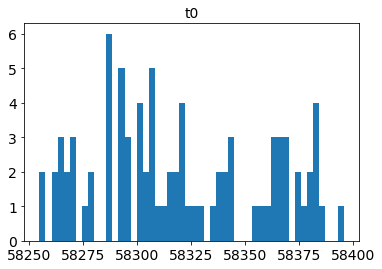

rango t0_err : 0.008852336690324591, 1.140970089356415
promedio t0_err : 0.1762606912198819
desviación estándar t0_err : 0.20077409405382526
mediana t0_err : 0.123673425105153


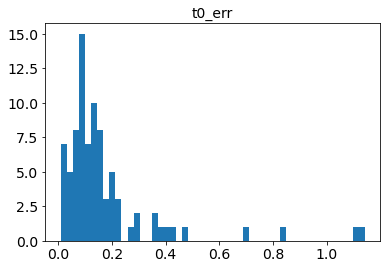

rango x0 : 0.00022861361160102106, 0.011205988295383962
promedio x0 : 0.001367951204157343
desviación estándar x0 : 0.0018067877545552614
mediana x0 : 0.0007163682635537


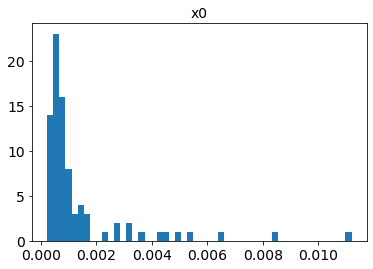

rango x0_err : 4.16418186005795e-06, 6.593178777172072e-05
promedio x0_err : 1.4217113192151224e-05
desviación estándar x0_err : 1.0649533423732002e-05
mediana x0_err : 1.0276989244245858e-05


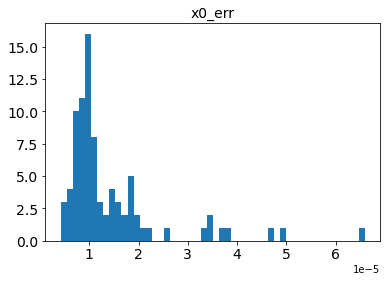

rango x1 : -2.5268717825467966, 2.4762138017941413
promedio x1 : 0.06250554772180238
desviación estándar x1 : 1.093310087610723
mediana x1 : 0.22375992543177758


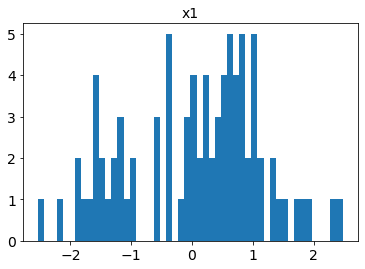

rango x1_err : 0.014895816279680505, 2.174432525459371
promedio x1_err : 0.23341052717279748
desviación estándar x1_err : 0.29146338749097334
mediana x1_err : 0.161855801646897


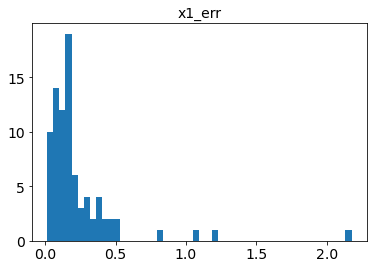

rango c : -0.18078217842949446, 0.6439813241957757
promedio c : 0.01753416567390755
desviación estándar c : 0.11972849525267731
mediana c : 0.002611182220189864


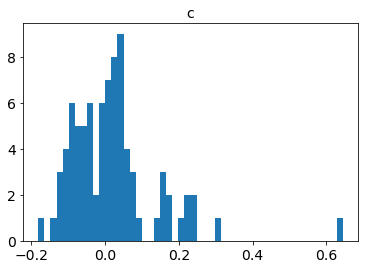

rango c_err : 0.002081287928363721, 0.13190022716449315
promedio c_err : 0.025070940796851078
desviación estándar c_err : 0.01690222949417498
mediana c_err : 0.02172566609612752


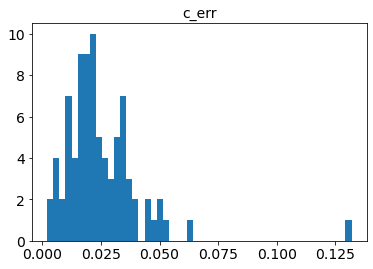

rango mwebv : 0.006204556550167132, 0.1144183424611353
promedio mwebv : 0.03064786661830939
desviación estándar mwebv : 0.02142708623940601
mediana mwebv : 0.02451353213255834


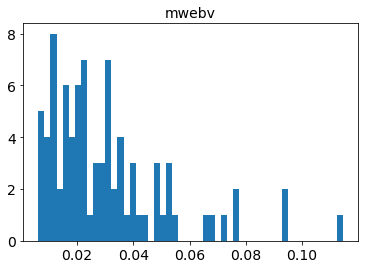

In [220]:
histogramas_estadisticas_resultados(ajustes_SALT3_z_fijo_early_SNIa_cortes_t, z_real=True)

Aquí vemos que el valor de $\frac{\chi^{2}}{ndof}$ disminuye mucho al utilizar para los ajustes solo las observaciones que están dentro del rango de tiempo del modelo. 

Estadísticas de los ajustes, ordenados por valor de chisq/ndof

In [221]:
estadisticas_SALT3_z_fijo_cortes_t = estadisticas_resultados(ajustes_SALT3_z_fijo_early_SNIa_cortes_t, 
                                                             z_real=True).sort_values(by=['chisq/ndof'])

Listas de los oid y de los valores de chisq/ndof del ajuste con con el modelo SALT3 y redshift real, utilizando los puntos que pertenecen al rango de tiempo del modelo (determinado con los valores de $t_0$ del primer ajuste y $z_{real}$), ordenados según el valor de chisq/ndof

In [222]:
lista_oid_SALT3_z_fijo_cortes_t = list(estadisticas_SALT3_z_fijo_cortes_t['oid'])
lista_chisq_vs_ndof_SALT3_z_fijo_cortes_t = list(estadisticas_SALT3_z_fijo_cortes_t['chisq/ndof'])

Filas de los resultados del ajuste con chisq/ndof sobre la 
mediana 

In [223]:
median_chisq_vs_ndof_SALT3_z_fijo_cortes_t = np.median(np.array(estadisticas_SALT3_z_fijo_cortes_t['chisq/ndof']))
df_chisq_vs_ndof_SALT3_z_fijo_sobre_mediana_cortes_t = estadisticas_SALT3_z_fijo_cortes_t[estadisticas_SALT3_z_fijo_cortes_t['chisq/ndof'] > median_chisq_vs_ndof_SALT3_z_fijo_cortes_t].reset_index()
lista_oid_SALT3_z_fijo_sobre_mediana_cortes_t = list(df_chisq_vs_ndof_SALT3_z_fijo_sobre_mediana_cortes_t['oid'])

Mostrar algunas columnas de los resultados del ajuste, con valores de chisq/ndof sobre la mediana

In [224]:
display(df_chisq_vs_ndof_SALT3_z_fijo_sobre_mediana_cortes_t[['oid', 
                                                              'chisq/ndof',
                                                              'z',
                                                              't0', 
                                                              't0_err']])

oid  chisq/ndof       z            t0    t0_err
0   ZTF18aaxrvzj    1.591053  0.1100  58286.011695  0.153579
1   ZTF18abkifng    1.604195  0.0880  58343.581778  0.170823
2   ZTF18abcsgvj    1.624596  0.0600  58303.515861  0.129176
3   ZTF18abpamut    1.742925  0.0720  58367.688928  0.147617
4   ZTF18absdgon    1.746921  0.0620  58375.934626  0.121366
5   ZTF18abtnlik    1.750879  0.0900  58379.084046  0.153028
6   ZTF18abdbuty    1.820153  0.0600  58307.994801  0.125981
7   ZTF18aazsabq    1.860961  0.0500  58293.972076  0.083865
8   ZTF18abclalx    1.905211  0.1000  58301.077940  0.187440
9   ZTF18abealop    1.924834  0.0666  58316.176128  0.189972
10  ZTF18abckujg    2.037916  0.0740  58303.421237  0.155806
11  ZTF18aaxqyki    2.071909  0.1003  58286.408991  0.128616
12  ZTF18abetewu    2.116499  0.0740  58318.805022  0.195059
13  ZTF18abdefet    2.172546  0.0700  58307.527539  0.221606
14  ZTF18aaxsioa    2.260130  0.0315  58286.129431  0.024683
15  ZTF18aazblzy    2.451922  0.0653  58291.735197  0.048067
16  ZTF18aayjvve    2.685419  0.0474  58292.046030  0.059236
17  ZTF18abcrxoj    2.856347  0.0309  58306.317421  0.051306
18  ZTF18abbvsiv    3.092940  0.0510  58296.788111  0.087649
19  ZTF18aazcoob    3.098912  0.0845  58294.464845  0.143561
20  ZTF18aaytovs    3.101108  0.0746  58294.373012  0.090955
21  ZTF18aaumlfl    3.146747  0.0874  58265.889996  0.131239
22  ZTF18abgmcmv    3.161347  0.0185  58328.837577  0.050930
23  ZTF18abcflnz    3.175693  0.0273  58306.363455  0.040806
24  ZTF18abfhryc    3.290769  0.0323  58324.027612  0.059367
25  ZTF18aauocnw    3.591153  0.1000  58269.065769  0.092167
26  ZTF18aaunfqq    3.683995  0.0711  58268.654652  0.095300
27  ZTF18abetehf    4.268569  0.0649  58318.544224  0.095768
28  ZTF18aavrzxp    4.336242  0.0700  58270.522110  0.095923
29  ZTF18aaxcntm    4.481067  0.0269  58279.026312  0.023795
30  ZTF18aavrwhu    5.070502  0.0620  58275.829125  0.068414
31  ZTF18aaumeys    5.631049  0.0365  58267.226858  0.027897
32  ZTF18aaqqoqs    5.632903  0.0800  58262.589210  0.061376
33  ZTF18aatzygk    5.674600  0.0740  58262.181825  0.116389
34  ZTF18aaqffyp    5.813066  0.0640  58254.618629  0.059198
35  ZTF18aaxdrjn    7.697698  0.0340  58279.024992  0.024464
36  ZTF18aawjywv    9.061203  0.0400  58271.503985  0.055787
37  ZTF18abauprj   10.747909  0.0242  58302.234658  0.025696
38  ZTF18aaslhxt   16.510798  0.0509  58263.635011  0.023169
39  ZTF18aaqcqvr   18.239803  0.0716  58256.522277  0.060114
40  ZTF18abuqugw   27.758132  0.0313  58384.136909  0.083195
41  ZTF18aasdted   33.411300  0.0181  58265.184050  0.008852

Intersección de los oid de las SN con valores de chisq/ndof mayores a la mediana de los ajustes con SALT2 y $z_{real}$ variable antes y después de eliminar los puntos fuera del rango de tiempo del modelo

In [225]:
inter_oid_SALT3_z_fijo_sobre_mediana_cortes_t = np.intersect1d(np.array(lista_oid_SALT3_z_fijo_sobre_mediana),
                                                               np.array(lista_oid_SALT3_z_fijo_sobre_mediana_cortes_t))
print('Elementos comunes sobre la mediana de chisq/ndof : ',len(inter_oid_SALT3_z_fijo_sobre_mediana_cortes_t))

Elementos comunes sobre la mediana de chisq/ndof :  39


Tabla de astropy con las detecciones que están en el rango de tiempo del modelo, en el formato que requiere sncosmo para hacer los ajustes 

In [226]:
table_early_SNIa_SALT3_z_fijo_cortes_t = astropy_table_detections(df_meta_early_SNIa, 
                                                                  detect_early_SNIa_cortes_t_SALT3_z_fijo)

Algunos gráficos de los ajustes de las SN que tienen valores de $\frac{\chi^{2}}{ndof}$ menores a la mediana.

 ===== Ajuste con redshift real ====
chisq/ndof :  0.3431131302019259


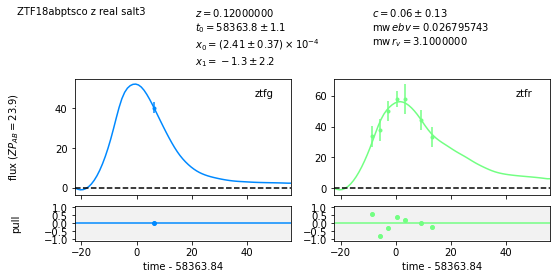

In [227]:
ajuste(lista_oid_SALT3_z_fijo_cortes_t[0], 'salt3', df_meta_early_SNIa, 
       table_early_SNIa_SALT3_z_fijo_cortes_t, z_real=True)[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT3_z_fijo_cortes_t[0])

 ===== Ajuste con redshift real ====
chisq/ndof :  0.5850638241331344


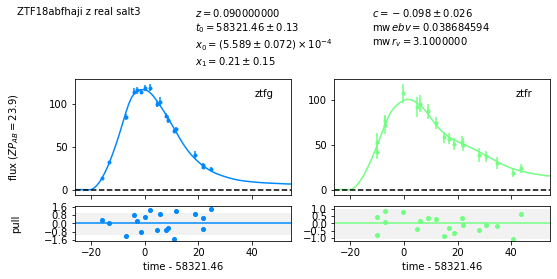

In [228]:
ajuste(lista_oid_SALT3_z_fijo_cortes_t[4], 'salt3', df_meta_early_SNIa, 
       table_early_SNIa_SALT3_z_fijo_cortes_t, z_real=True)[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT3_z_fijo_cortes_t[4])

 ===== Ajuste con redshift real ====
chisq/ndof :  0.8797551096855601


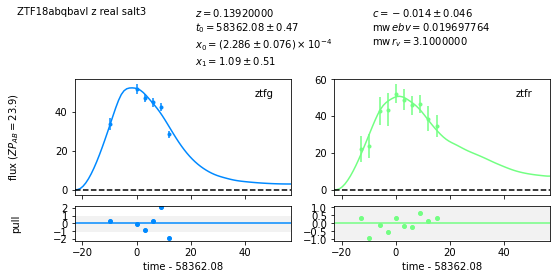

In [229]:
ajuste(lista_oid_SALT3_z_fijo_cortes_t[17], 'salt3', df_meta_early_SNIa, 
       table_early_SNIa_SALT3_z_fijo_cortes_t, z_real=True)[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT3_z_fijo_cortes_t[17])

 ===== Ajuste con redshift real ====
chisq/ndof :  0.8855314036449186


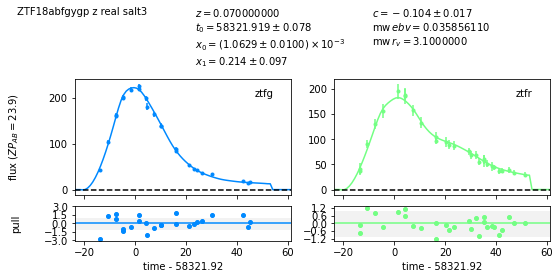

In [230]:
ajuste(lista_oid_SALT3_z_fijo_cortes_t[19], 'salt3', df_meta_early_SNIa, 
       table_early_SNIa_SALT3_z_fijo_cortes_t, z_real=True)[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT3_z_fijo_cortes_t[19])

 ===== Ajuste con redshift real ====
chisq/ndof :  1.1116657835957424


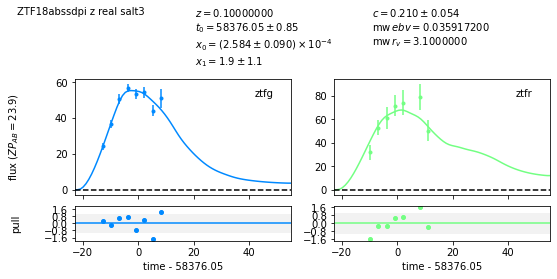

In [231]:
ajuste(lista_oid_SALT3_z_fijo_cortes_t[24], 'salt3', df_meta_early_SNIa, 
       table_early_SNIa_SALT3_z_fijo_cortes_t, z_real=True)[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT3_z_fijo_cortes_t[24])

 ===== Ajuste con redshift real ====
chisq/ndof :  1.421180707056576


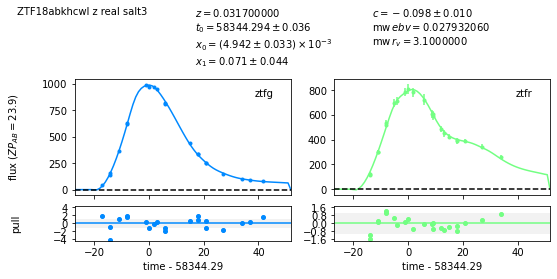

In [232]:
ajuste(lista_oid_SALT3_z_fijo_cortes_t[33], 'salt3', df_meta_early_SNIa, 
       table_early_SNIa_SALT3_z_fijo_cortes_t, z_real=True)[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT3_z_fijo_cortes_t[33])

 ===== Ajuste con redshift real ====
chisq/ndof :  1.5189389899117554


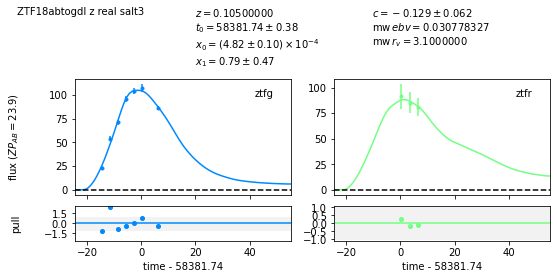

In [233]:
ajuste(lista_oid_SALT3_z_fijo_cortes_t[39], 'salt3', df_meta_early_SNIa, 
       table_early_SNIa_SALT3_z_fijo_cortes_t, z_real=True)[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT3_z_fijo_cortes_t[39])

 ===== Ajuste con redshift real ====
chisq/ndof :  1.5806166660554901


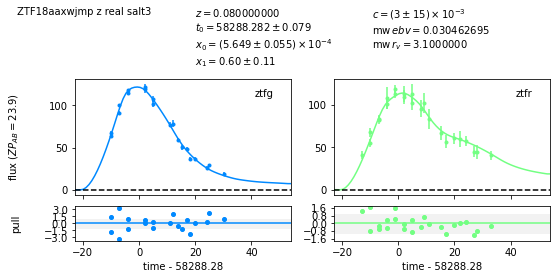

In [234]:
ajuste(lista_oid_SALT3_z_fijo_cortes_t[41], 'salt3', df_meta_early_SNIa, 
       table_early_SNIa_SALT3_z_fijo_cortes_t, z_real=True)[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT3_z_fijo_cortes_t[41])

Algunos gráficos de los ajustes de las SN que tienen valores de $\frac{\chi^{2}}{ndof}$ mayores a la mediana.

 ===== Ajuste con redshift real ====
chisq/ndof :  1.5910532615905575


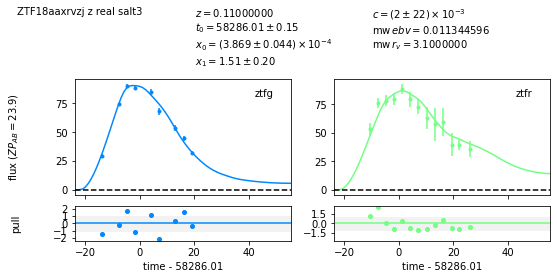

In [235]:
ajuste(lista_oid_SALT3_z_fijo_sobre_mediana_cortes_t[0], 'salt3', df_meta_early_SNIa, 
       table_early_SNIa_SALT3_z_fijo_cortes_t, z_real=True)[0]
print('chisq/ndof : ', 
      df_chisq_vs_ndof_SALT3_z_fijo_sobre_mediana_cortes_t['chisq/ndof'][0])

 ===== Ajuste con redshift real ====
chisq/ndof :  1.8609612076132915


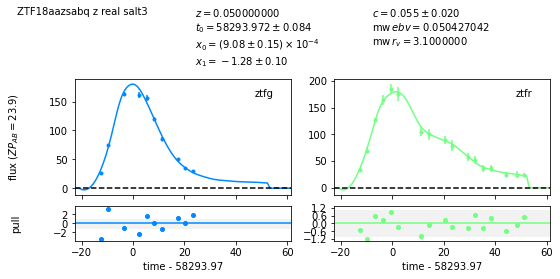

In [236]:
ajuste(lista_oid_SALT3_z_fijo_sobre_mediana_cortes_t[7], 'salt3', df_meta_early_SNIa, 
       table_early_SNIa_SALT3_z_fijo_cortes_t, z_real=True)[0]
print('chisq/ndof : ', 
      df_chisq_vs_ndof_SALT3_z_fijo_sobre_mediana_cortes_t['chisq/ndof'][7])

 ===== Ajuste con redshift real ====
chisq/ndof :  2.071908764523922


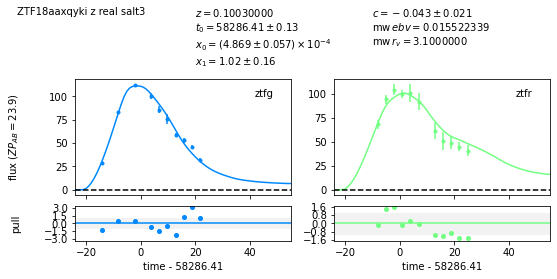

In [237]:
ajuste(lista_oid_SALT3_z_fijo_sobre_mediana_cortes_t[11], 'salt3', df_meta_early_SNIa, 
       table_early_SNIa_SALT3_z_fijo_cortes_t, z_real=True)[0]
print('chisq/ndof : ', 
      df_chisq_vs_ndof_SALT3_z_fijo_sobre_mediana_cortes_t['chisq/ndof'][11])

 ===== Ajuste con redshift real ====
chisq/ndof :  2.1725461680813276


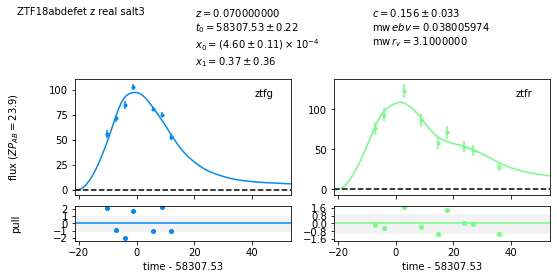

In [238]:
ajuste(lista_oid_SALT3_z_fijo_sobre_mediana_cortes_t[13], 'salt3', df_meta_early_SNIa, 
       table_early_SNIa_SALT3_z_fijo_cortes_t, z_real=True)[0]
print('chisq/ndof : ', 
      df_chisq_vs_ndof_SALT3_z_fijo_sobre_mediana_cortes_t['chisq/ndof'][13])

 ===== Ajuste con redshift real ====
chisq/ndof :  2.8563470632003916


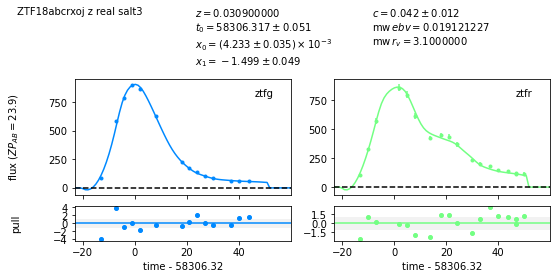

In [239]:
ajuste(lista_oid_SALT3_z_fijo_sobre_mediana_cortes_t[17], 'salt3', df_meta_early_SNIa, 
       table_early_SNIa_SALT3_z_fijo_cortes_t, z_real=True)[0]
print('chisq/ndof : ', 
      df_chisq_vs_ndof_SALT3_z_fijo_sobre_mediana_cortes_t['chisq/ndof'][17])

 ===== Ajuste con redshift real ====
chisq/ndof :  3.092939630447042


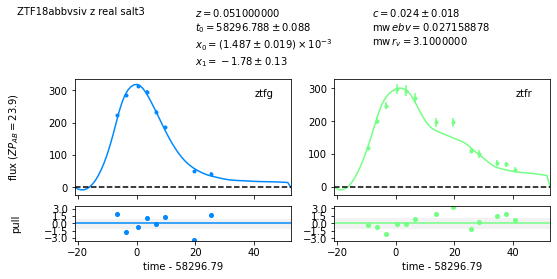

In [240]:
ajuste(lista_oid_SALT3_z_fijo_sobre_mediana_cortes_t[18], 'salt3', df_meta_early_SNIa, 
       table_early_SNIa_SALT3_z_fijo_cortes_t, z_real=True)[0]
print('chisq/ndof : ', 
      df_chisq_vs_ndof_SALT3_z_fijo_sobre_mediana_cortes_t['chisq/ndof'][18])

 ===== Ajuste con redshift real ====
chisq/ndof :  3.1011076321617876


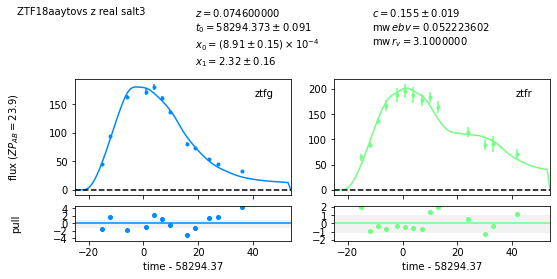

In [241]:
ajuste(lista_oid_SALT3_z_fijo_sobre_mediana_cortes_t[20], 'salt3', df_meta_early_SNIa, 
       table_early_SNIa_SALT3_z_fijo_cortes_t, z_real=True)[0]
print('chisq/ndof : ', 
      df_chisq_vs_ndof_SALT3_z_fijo_sobre_mediana_cortes_t['chisq/ndof'][20])

 ===== Ajuste con redshift real ====
chisq/ndof :  3.161346837994085


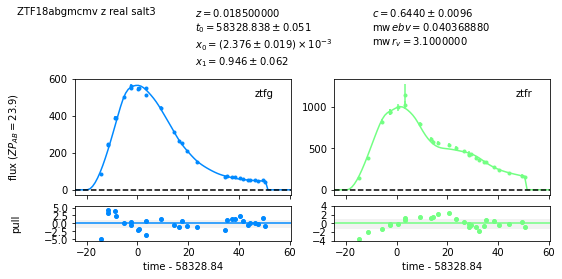

In [242]:
ajuste(lista_oid_SALT3_z_fijo_sobre_mediana_cortes_t[22], 'salt3', df_meta_early_SNIa, 
       table_early_SNIa_SALT3_z_fijo_cortes_t, z_real=True)[0]
print('chisq/ndof : ', 
      df_chisq_vs_ndof_SALT3_z_fijo_sobre_mediana_cortes_t['chisq/ndof'][22])

 ===== Ajuste con redshift real ====
chisq/ndof :  27.758131529006537


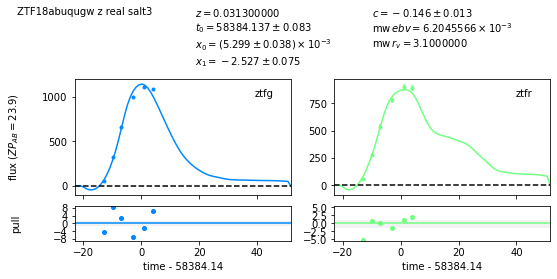

In [243]:
ajuste(lista_oid_SALT3_z_fijo_sobre_mediana_cortes_t[40], 'salt3', df_meta_early_SNIa, 
       table_early_SNIa_SALT3_z_fijo_cortes_t, z_real=True)[0]
print('chisq/ndof : ', 
      df_chisq_vs_ndof_SALT3_z_fijo_sobre_mediana_cortes_t['chisq/ndof'][40])

 ===== Ajuste con redshift real ====
chisq/ndof :  33.41130039818293


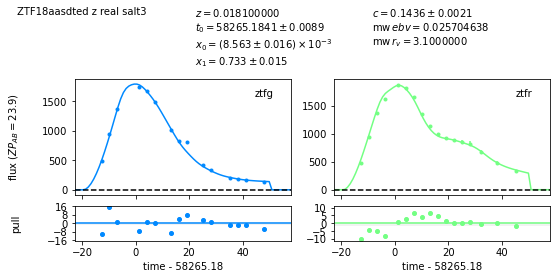

In [244]:
ajuste(lista_oid_SALT3_z_fijo_sobre_mediana_cortes_t[41], 'salt3', df_meta_early_SNIa, 
       table_early_SNIa_SALT3_z_fijo_cortes_t, z_real=True)[0]
print('chisq/ndof : ', 
      df_chisq_vs_ndof_SALT3_z_fijo_sobre_mediana_cortes_t['chisq/ndof'][41])

### Ajuste con redshift variable

Seleccionar las detecciones de las SN que están dentro del rango de tiempo del modelo según el primer ajuste con el modelo SALT3 y redshift variable

In [245]:
detect_early_SNIa_sin_SN52_cortes_t = cortes_t_modelo(trest_min_modelo, 
                                                      trest_max_modelo, 
                                                      detect_early_SNIa_sin_SN52,
                                                     estadisticas_SALT3_z_var)

Ajuste con las detecciones de las SN que están dentro del rango de tiempo del modelo

In [246]:
ajustes_SALT3_early_SNIa_sin_SN52_cortes_t = modelo_ajustado_y_resultados('salt3', 
                                                                          df_meta_early_SNIa_sin_SN52, 
                                                                          detect_early_SNIa_sin_SN52_cortes_t,
                                                                          print_ind_and_oid=False)

rango ncall : 149, 1379
promedio ncall : 369.43373493975906
desviación estándar ncall : 211.17589269879875
mediana ncall : 290.0


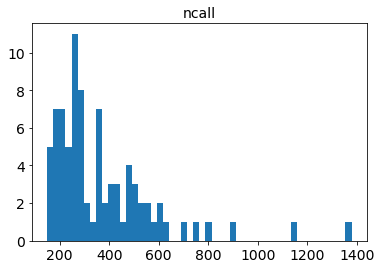

rango chisq : 1.4803418175203376, 8757.093751008098
promedio chisq : 227.8101459771426
desviación estándar chisq : 977.3949611648221
mediana chisq : 31.88727750205735


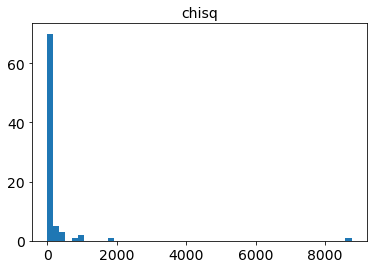

rango ndof : 3, 59
promedio ndof : 20.927710843373493
desviación estándar ndof : 11.976667207965844
mediana ndof : 17.0


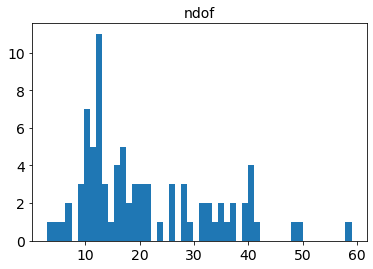

rango chisq/ndof : 0.4772206745634247, 243.2526041946694
promedio chisq/ndof : 7.4913396143791315
desviación estándar chisq/ndof : 26.94168804580453
mediana chisq/ndof : 1.8757222060033736


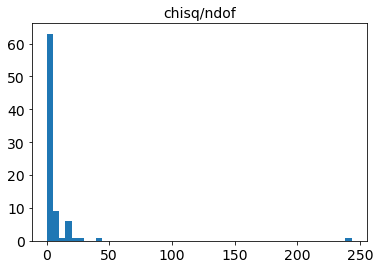

rango z : 0.0010000000002969996, 0.3398382504375163
promedio z : 0.16971381099370583
desviación estándar z : 0.09484418738145742
mediana z : 0.1763660391644759


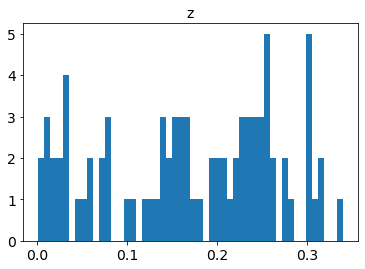

rango z_err : 2.137162669058057e-10, 0.40590237372824345
promedio z_err : 0.03561693325424395
desviación estándar z_err : 0.07013041206880928
mediana z_err : 0.0173805779303592


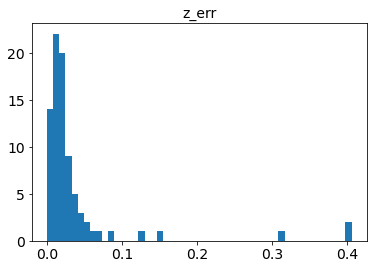

rango t0 : 58256.76099932384, 58395.08339788103
promedio t0 : 58320.60577598077
desviación estándar t0 : 38.86108077969683
mediana t0 : 58313.78372371998


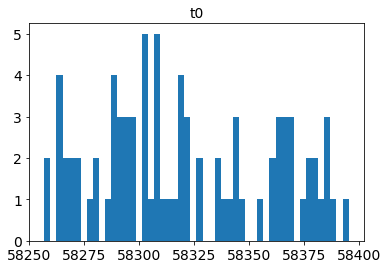

rango t0_err : 5.602487362921238e-10, 122.65784992303452
promedio t0_err : 3.194137424012779
desviación estándar t0_err : 18.39307339734557
mediana t0_err : 0.2210188284589094


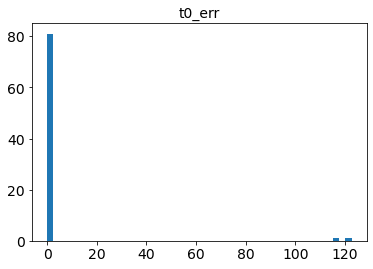

rango x0 : 0.00022795865919194336, 0.011421426616418486
promedio x0 : 0.001283264292947558
desviación estándar x0 : 0.0017187519724842144
mediana x0 : 0.0006649752247342893


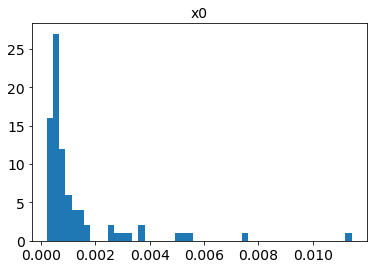

rango x0_err : 5.8647997696926295e-06, 1.0175138843689064
promedio x0_err : 0.03637480560566483
desviación estándar x0_err : 0.18774246164781283
mediana x0_err : 1.4893328727994932e-05


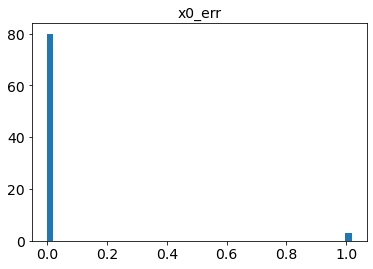

rango x1 : -2.5865571708243507, 3.9999999532332513
promedio x1 : 0.05439053336071555
desviación estándar x1 : 1.2298901417169246
mediana x1 : 0.15962901988828104


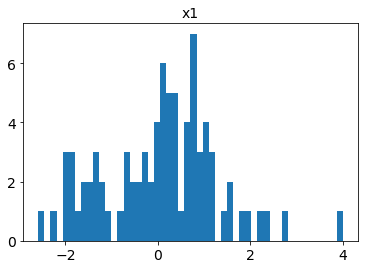

rango x1_err : 0.011045039694947523, 5.900043674893869
promedio x1_err : 0.46221362271767363
desviación estándar x1_err : 1.0600508421374748
mediana x1_err : 0.19452444935389757


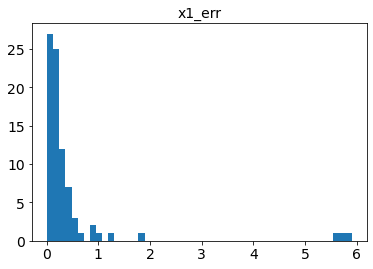

rango c : -0.3506298480117703, 0.2723707852536782
promedio c : -0.08574771663028169
desviación estándar c : 0.12148507133712892
mediana c : -0.08914624742829658


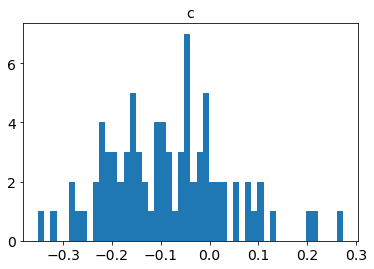

rango c_err : 0.0016254287609830803, 0.5757435139722138
promedio c_err : 0.05227704439232323
desviación estándar c_err : 0.09376563136032426
mediana c_err : 0.03158707128589673


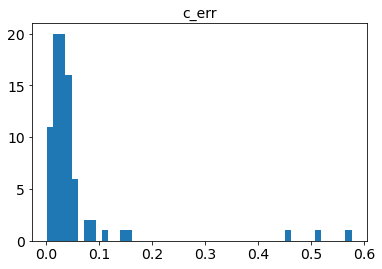

rango mwebv : 0.006204556550167132, 0.1144183424611353
promedio mwebv : 0.030530745972028404
desviación estándar mwebv : 0.02152903487450753
mediana mwebv : 0.023404313345236558


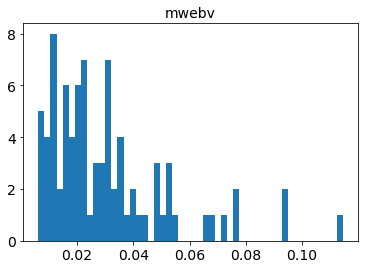

In [247]:
histogramas_estadisticas_resultados(ajustes_SALT3_early_SNIa_sin_SN52_cortes_t)

Aquí vemos que el valor de $\frac{\chi^{2}}{ndof}$ disminuye un poco al utilizar para los ajustes solo las observaciones que están dentro del rango de tiempo del modelo. 

Estadísticas de los ajustes, ordenados por valor de chisq/ndof

In [248]:
estadisticas_SALT3_z_var_cortes_t = estadisticas_resultados(ajustes_SALT3_early_SNIa_sin_SN52_cortes_t).sort_values(by=['chisq/ndof'])

Listas de los oid y de los valores de chisq/ndof del ajuste con con el modelo SALT3 y redshift variable, utilizando los puntos que pertenecen al rango de tiempo del modelo (determinado con los valores de $t_0$ y $z$ del primer ajuste), ordenados según el valor de chisq/ndof

In [249]:
lista_oid_SALT3_z_var_cortes_t = list(estadisticas_SALT3_z_var_cortes_t['oid'])
lista_chisq_vs_ndof_SALT3_z_var_cortes_t = list(estadisticas_SALT3_z_var_cortes_t['chisq/ndof'])

Filas de los resultados del ajuste con chisq/ndof sobre la 
mediana 

In [250]:
median_chisq_vs_ndof_SALT3_z_var_cortes_t = np.median(np.array(estadisticas_SALT3_z_var_cortes_t['chisq/ndof']))
df_chisq_vs_ndof_SALT3_z_var_sobre_mediana_cortes_t = estadisticas_SALT3_z_var_cortes_t[estadisticas_SALT3_z_var_cortes_t['chisq/ndof'] > median_chisq_vs_ndof_SALT3_z_var_cortes_t].reset_index()
lista_oid_SALT3_z_var_sobre_mediana_cortes_t = list(df_chisq_vs_ndof_SALT3_z_var_sobre_mediana_cortes_t['oid'])

Mostrar algunas columnas de los resultados del ajuste, con valores de chisq/ndof sobre la mediana

In [251]:
display(df_chisq_vs_ndof_SALT3_z_var_sobre_mediana_cortes_t[['oid', 
                                                             'chisq/ndof',
                                                             'z', 
                                                             'z_err', 
                                                             't0', 
                                                             't0_err']])

oid  chisq/ndof         z         z_err            t0  \
0   ZTF18abckujg    1.878410  0.028785  9.639951e-03  58302.911508   
1   ZTF18aazjztm    1.970341  0.301664  1.897528e-02  58293.197921   
2   ZTF18abtnlik    2.035663  0.263541  2.632175e-02  58380.518237   
3   ZTF18abimsyv    2.178769  0.240571  9.676009e-03  58336.302540   
4   ZTF18aaxwjmp    2.218599  0.302822  1.513047e-02  58290.293653   
5   ZTF18abbpeqo    2.237542  0.256890  3.142024e-01  58302.299430   
6   ZTF18abclalx    2.266776  0.261197  2.244619e-02  58302.393653   
7   ZTF18abetewu    2.304188  0.069200  2.146927e-02  58318.796142   
8   ZTF18abbvsiv    2.438346  0.209085  1.003238e-02  58297.858941   
9   ZTF18abdefet    2.503095  0.156539  3.569423e-02  58307.885729   
10  ZTF18abealop    2.733973  0.308337  2.184332e-02  58318.181160   
11  ZTF18aazcoob    2.748277  0.209750  1.720263e-02  58295.977054   
12  ZTF18abrzeym    2.754702  0.302488  1.754064e-02  58375.891087   
13  ZTF18aaxqyki    2.965502  0.251277  1.487892e-02  58287.876362   
14  ZTF18abeecwe    2.971723  0.079761  3.441223e-09  58320.177072   
15  ZTF18aayjvve    3.146730  0.078033  1.901241e-06  58292.271294   
16  ZTF18abcsgvj    3.391030  0.253280  1.754492e-02  58304.966417   
17  ZTF18aansqun    3.611884  0.313789  2.298137e-02  58317.036016   
18  ZTF18abetehf    3.781271  0.253457  1.139823e-02  58320.057798   
19  ZTF18aauocnw    4.121432  0.167545  3.080211e-02  58269.352074   
20  ZTF18aazblzy    4.554183  0.235498  9.617532e-03  58293.011045   
21  ZTF18aaytovs    5.802400  0.339838  1.129753e-02  58297.385249   
22  ZTF18aatzygk    5.991135  0.193538  1.841849e-02  58262.965114   
23  ZTF18aavrwhu    6.277488  0.158732  9.107390e-03  58276.310875   
24  ZTF18aaunfqq    6.575474  0.251730  1.391596e-02  58270.058459   
25  ZTF18aavrzxp    6.742856  0.166034  1.121106e-02  58270.818055   
26  ZTF18aaqqoqs    7.396076  0.243850  8.178882e-03  58264.284813   
27  ZTF18aaqffyp    8.610028  0.300922  1.652987e-02  58256.760999   
28  ZTF18aaxdrjn    9.264974  0.128377  5.376229e-03  58279.670511   
29  ZTF18abauprj    9.936158  0.013254  1.938575e-03  58301.957011   
30  ZTF18aawjywv   11.887240  0.145280  1.085629e-02  58271.997701   
31  ZTF18abfhryc   15.399305  0.213759  4.001726e-01  58326.475310   
32  ZTF18abcrxoj   15.477804  0.219848  1.391685e-02  58308.249533   
33  ZTF18abuqugw   15.829426  0.001000  9.443113e-04  58389.201234   
34  ZTF18aaumeys   16.104133  0.139221  3.833834e-03  58267.786803   
35  ZTF18aaslhxt   16.314775  0.026021  3.511936e-03  58263.205529   
36  ZTF18aaqcqvr   19.788674  0.135976  1.460313e-02  58256.963531   
37  ZTF18aaxsioa   20.968159  0.228110  9.179793e-08  58287.837361   
38  ZTF18aaxcntm   28.588255  0.247036  2.137163e-10  58280.828506   
39  ZTF18abcflnz   44.030238  0.230414  4.059024e-01  58308.691930   
40  ZTF18aasdted  243.252604  0.274913  2.223167e-10  58267.533716   

          t0_err  
0   2.376389e-01  
1   2.571549e-01  
2   2.933191e-01  
3   1.965998e-01  
4   2.098405e-01  
5   2.595371e-05  
6   2.972257e-01  
7   1.984565e-01  
8   1.659674e-01  
9   2.591158e-01  
10  3.431250e-01  
11  3.138649e-01  
12  2.972548e-01  
13  1.670901e-01  
14  7.044946e-08  
15  5.365019e-05  
16  1.819074e-01  
17  6.928132e-01  
18  1.332495e-01  
19  3.023166e-01  
20  7.277858e-02  
21  2.220452e-01  
22  3.714272e-01  
23  8.786745e-02  
24  1.286627e-01  
25  1.277196e-01  
26  9.543800e-02  
27  1.973404e-01  
28  3.245094e-02  
29  5.833835e-02  
30  5.852614e-02  
31  1.177428e+02  
32  1.256672e-01  
33  3.256141e-02  
34  2.964153e-02  
35  7.367430e-02  
36  7.888143e-02  
37  1.662205e-05  
38  5.602487e-10  
39  1.226578e+02  
40  8.074923e-06

Intersección de los oid de las SN con valores de chisq/ndof mayores a la mediana de los ajustes con SALT3 y $z$ variable antes y después de eliminar los puntos fuera del rango de tiempo del modelo

In [252]:
inter_oid_SALT3_z_var_sobre_mediana_cortes_t = np.intersect1d(np.array(lista_oid_SALT3_z_var_sobre_mediana),
                                                              np.array(lista_oid_SALT3_z_var_sobre_mediana_cortes_t))
print('Elementos comunes sobre la mediana de chisq/ndof : ',len(inter_oid_SALT3_z_var_sobre_mediana_cortes_t))

Elementos comunes sobre la mediana de chisq/ndof :  40


Tabla de astropy con las detecciones que están en el rango de tiempo del modelo, en el formato que requiere sncosmo para hacer los ajustes 

In [253]:
table_early_SNIa_sin_SN52_SALT3_z_var_cortes_t = astropy_table_detections(df_meta_early_SNIa_sin_SN52,
                                                                          detect_early_SNIa_sin_SN52_cortes_t)

Algunos gráficos de los ajustes de las SN que tienen valores de $\frac{\chi^{2}}{ndof}$ menores a la mediana.

 ==== Con ajuste del redshift ====
chisq/ndof :  0.4772206745634247


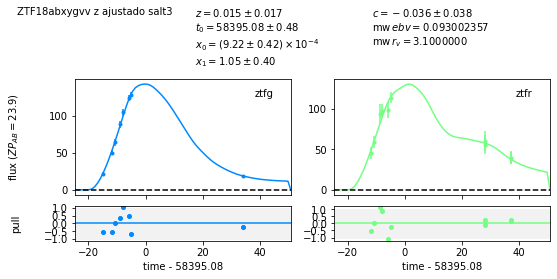

In [254]:
ajuste(lista_oid_SALT3_z_var_cortes_t[0], 'salt3', df_meta_early_SNIa_sin_SN52, 
       table_early_SNIa_sin_SN52_SALT3_z_var_cortes_t)[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT3_z_var_cortes_t[0])

 ==== Con ajuste del redshift ====
chisq/ndof :  0.49344727250677917


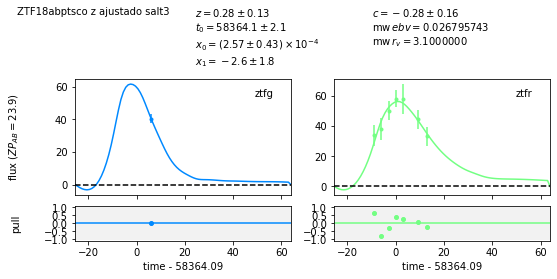

In [255]:
ajuste(lista_oid_SALT3_z_var_cortes_t[1], 'salt3', df_meta_early_SNIa_sin_SN52, 
       table_early_SNIa_sin_SN52_SALT3_z_var_cortes_t)[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT3_z_var_cortes_t[1])

 ==== Con ajuste del redshift ====
chisq/ndof :  0.5569357112573126


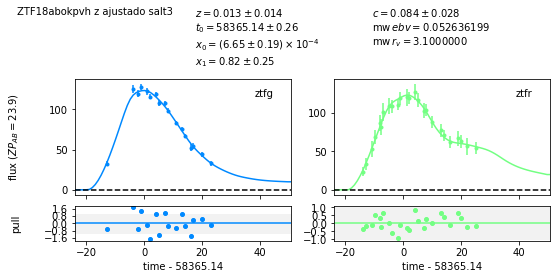

In [256]:
ajuste(lista_oid_SALT3_z_var_cortes_t[6], 'salt3', df_meta_early_SNIa_sin_SN52, 
       table_early_SNIa_sin_SN52_SALT3_z_var_cortes_t)[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT3_z_var_cortes_t[6])

 ==== Con ajuste del redshift ====
chisq/ndof :  0.954616458439399


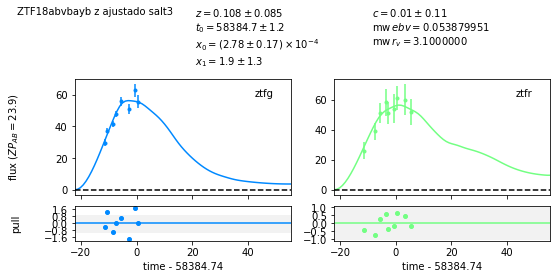

In [257]:
ajuste(lista_oid_SALT3_z_var_cortes_t[14], 'salt3', df_meta_early_SNIa_sin_SN52, 
       table_early_SNIa_sin_SN52_SALT3_z_var_cortes_t)[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT3_z_var_cortes_t[14])

 ==== Con ajuste del redshift ====
chisq/ndof :  1.0661139574277532


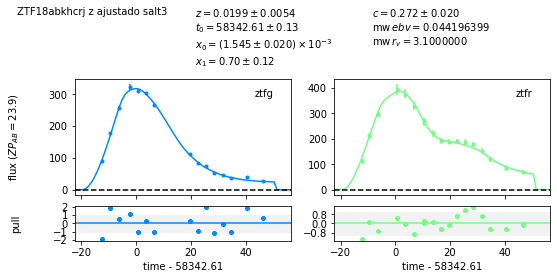

In [258]:
ajuste(lista_oid_SALT3_z_var_cortes_t[17], 'salt3', df_meta_early_SNIa_sin_SN52, 
       table_early_SNIa_sin_SN52_SALT3_z_var_cortes_t)[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT3_z_var_cortes_t[17])

 ==== Con ajuste del redshift ====
chisq/ndof :  1.4476431809725094


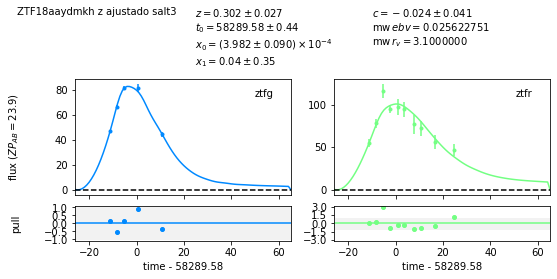

In [259]:
ajuste(lista_oid_SALT3_z_var_cortes_t[28], 'salt3', df_meta_early_SNIa_sin_SN52, 
       table_early_SNIa_sin_SN52_SALT3_z_var_cortes_t)[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT3_z_var_cortes_t[28])

 ==== Con ajuste del redshift ====
chisq/ndof :  1.6230128415402219


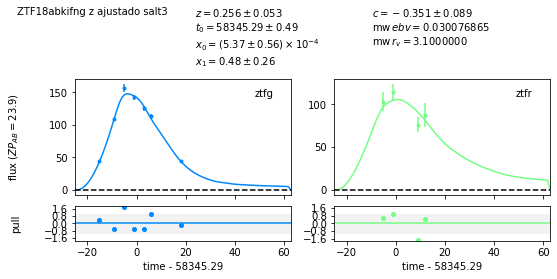

In [260]:
ajuste(lista_oid_SALT3_z_var_cortes_t[34], 'salt3', df_meta_early_SNIa_sin_SN52, 
       table_early_SNIa_sin_SN52_SALT3_z_var_cortes_t)[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT3_z_var_cortes_t[34])

 ==== Con ajuste del redshift ====
chisq/ndof :  1.8757222060033736


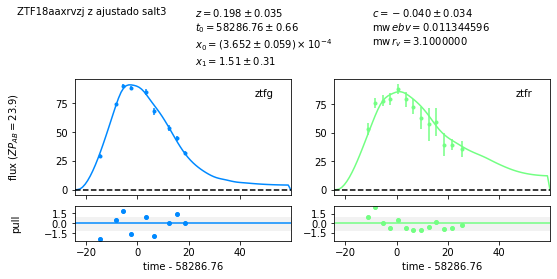

In [261]:
ajuste(lista_oid_SALT3_z_var_cortes_t[41], 'salt3', df_meta_early_SNIa_sin_SN52, 
       table_early_SNIa_sin_SN52_SALT3_z_var_cortes_t)[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT3_z_var_cortes_t[41])

Algunos gráficos de los ajustes de las SN que tienen valores de $\frac{\chi^{2}}{ndof}$ menores a la mediana.

 ==== Con ajuste del redshift ====
chisq/ndof :  1.8784104405068656


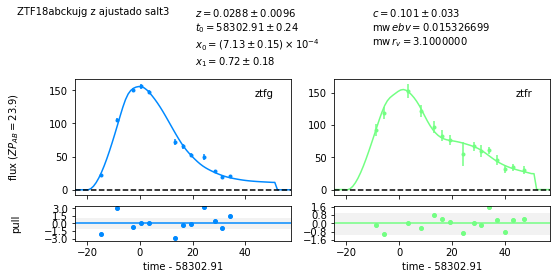

In [262]:
ajuste(lista_oid_SALT3_z_var_sobre_mediana_cortes_t[0], 'salt3', df_meta_early_SNIa_sin_SN52, 
       table_early_SNIa_sin_SN52_SALT3_z_var_cortes_t)[0]
print('chisq/ndof : ', df_chisq_vs_ndof_SALT3_z_var_sobre_mediana_cortes_t['chisq/ndof'][0])

 ==== Con ajuste del redshift ====
chisq/ndof :  2.3041878461086616


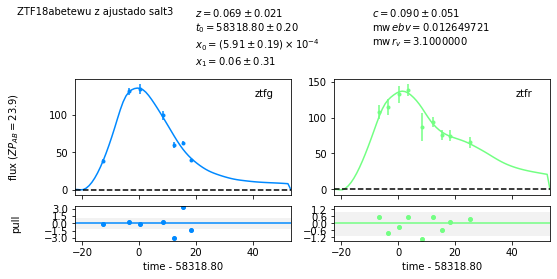

In [263]:
ajuste(lista_oid_SALT3_z_var_sobre_mediana_cortes_t[7], 'salt3', df_meta_early_SNIa_sin_SN52, 
       table_early_SNIa_sin_SN52_SALT3_z_var_cortes_t)[0]
print('chisq/ndof : ', df_chisq_vs_ndof_SALT3_z_var_sobre_mediana_cortes_t['chisq/ndof'][7])

 ==== Con ajuste del redshift ====
chisq/ndof :  2.971723323648


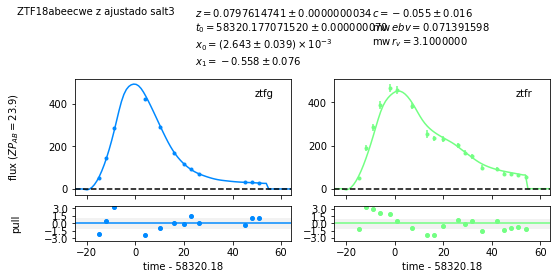

In [264]:
ajuste(lista_oid_SALT3_z_var_sobre_mediana_cortes_t[14], 'salt3', df_meta_early_SNIa_sin_SN52, 
       table_early_SNIa_sin_SN52_SALT3_z_var_cortes_t)[0]
print('chisq/ndof : ', df_chisq_vs_ndof_SALT3_z_var_sobre_mediana_cortes_t['chisq/ndof'][14])

 ==== Con ajuste del redshift ====
chisq/ndof :  5.802399755880406


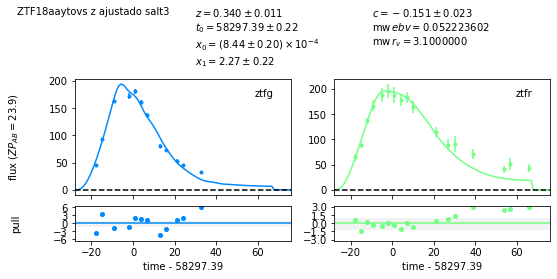

In [265]:
ajuste(lista_oid_SALT3_z_var_sobre_mediana_cortes_t[21], 'salt3', df_meta_early_SNIa_sin_SN52, 
       table_early_SNIa_sin_SN52_SALT3_z_var_cortes_t)[0]
print('chisq/ndof : ', df_chisq_vs_ndof_SALT3_z_var_sobre_mediana_cortes_t['chisq/ndof'][21])

 ==== Con ajuste del redshift ====
chisq/ndof :  16.3147752411403


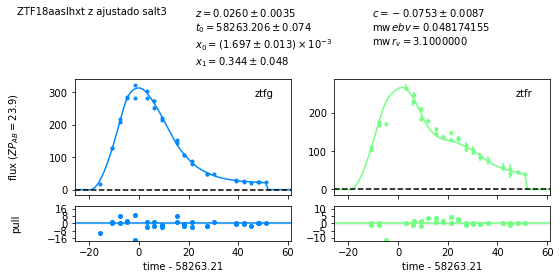

In [266]:
ajuste(lista_oid_SALT3_z_var_sobre_mediana_cortes_t[35], 'salt3', df_meta_early_SNIa_sin_SN52, 
       table_early_SNIa_sin_SN52_SALT3_z_var_cortes_t)[0]
print('chisq/ndof : ', df_chisq_vs_ndof_SALT3_z_var_sobre_mediana_cortes_t['chisq/ndof'][35])

 ==== Con ajuste del redshift ====
chisq/ndof :  19.78867410921886


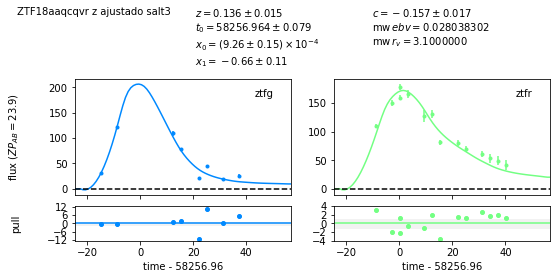

In [267]:
ajuste(lista_oid_SALT3_z_var_sobre_mediana_cortes_t[36], 'salt3', df_meta_early_SNIa_sin_SN52, 
       table_early_SNIa_sin_SN52_SALT3_z_var_cortes_t)[0]
print('chisq/ndof : ', df_chisq_vs_ndof_SALT3_z_var_sobre_mediana_cortes_t['chisq/ndof'][36])

 ==== Con ajuste del redshift ====
chisq/ndof :  20.968158645726664


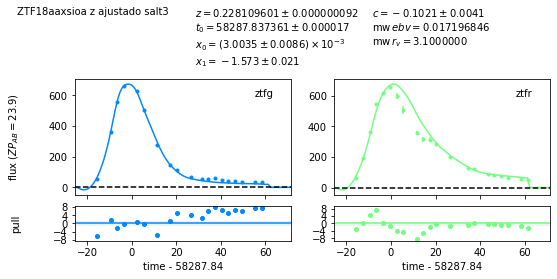

In [268]:
ajuste(lista_oid_SALT3_z_var_sobre_mediana_cortes_t[37], 'salt3', df_meta_early_SNIa_sin_SN52, 
       table_early_SNIa_sin_SN52_SALT3_z_var_cortes_t)[0]
print('chisq/ndof : ', df_chisq_vs_ndof_SALT3_z_var_sobre_mediana_cortes_t['chisq/ndof'][37])

 ==== Con ajuste del redshift ====
chisq/ndof :  44.0302379477112


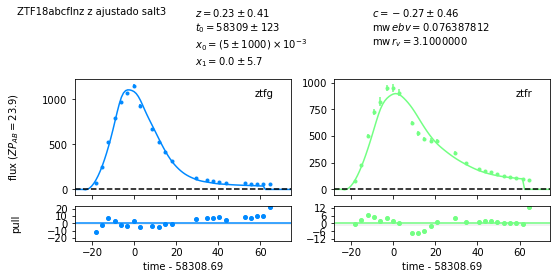

In [269]:
ajuste(lista_oid_SALT3_z_var_sobre_mediana_cortes_t[39], 'salt3', df_meta_early_SNIa_sin_SN52, 
       table_early_SNIa_sin_SN52_SALT3_z_var_cortes_t)[0]
print('chisq/ndof : ', df_chisq_vs_ndof_SALT3_z_var_sobre_mediana_cortes_t['chisq/ndof'][39])

Se observa que al hacer este mismo ajuste pero con el modelo SALT2, SALT2 deja más observaciones fuera del rango de tiempo del modelo (1 en $g$ y 2 en $r$) que SALT3 (1 en $g$ y 1 en $r$), pero SALT2 se ajusta mejor a la forma de la curva de luz que SALT3

Aquí vemos que aún hay observaciones que están fuera del rango del modelo pese a que se hayan descartados las observaciones fuera del rango del modelo del obtenido a partir de los parámetros $t_0$ y $z$ del primer ajuste. Esto se debe a que los parámetros $t_0$ y $z$ pueden cambiar al hacer un nuevo ajuste. En particular, si el $z$ obtenido en el segundo ajuste es menor que el del primer ajuste y/o el valor de $t_0$ cambia puede pasar que puntos que estaban dentro del rango de tiempo del modelo en el primer ajuste, ya no lo estén.

Por lo anterior, ahora se hará el ajuste considerando solo las observaciones que están dentro del rango del modelo, como si este estuviese en el sistema de referencia en reposo (en el cual $z=0$) y considerando como correcto el valor de $t_0$ del primer ajuste. 

## Ajuste con observaciones en el rango de tiempo del modelo como si estuviese en el sistema de referencia en reposo (determinado con $t_0$ del primer ajuste)

### Ajuste con redshift real 

Seleccionar las detecciones de las SN que están dentro del rango de tiempo del modelo según el primer ajuste de $t_0$ con el modelo SALT3 y $z=0$, pero utilizando el redshift real para el siguiente ajuste.

In [270]:
detect_early_SNIa_cortes_trest_SALT3_z_fijo = cortes_trest_modelo(trest_min_modelo, 
                                                                  trest_max_modelo, 
                                                                  detect_early_SNIa,
                                                                  estadisticas_SALT3_z_fijo)

Ajustes con las detecciones de las SN que están dentro del rango de tiempo del modelo, determinado con $z=0$ y $t_0$ del primer ajuste

In [271]:
ajustes_SALT3_z_fijo_early_SNIa_cortes_trest = modelo_ajustado_y_resultados('salt3',
                                                                            df_meta_early_SNIa,
                                                                            detect_early_SNIa_cortes_trest_SALT3_z_fijo,  
                                                                            z_real=True,
                                                                            print_ind_and_oid=False)

rango ncall : 89, 156
promedio ncall : 106.69047619047619
desviación estándar ncall : 14.214325596179194
mediana ncall : 103.0


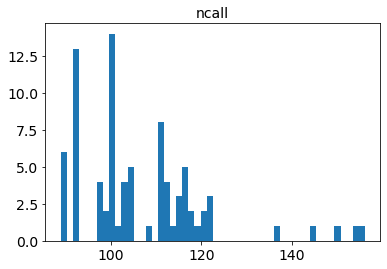

rango chisq : 1.3724525208077036, 987.283129096583
promedio chisq : 76.84899237630627
desviación estándar chisq : 153.0458967936361
mediana chisq : 33.70174603780052


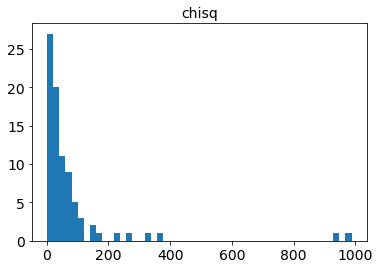

rango ndof : 4, 58
promedio ndof : 21.44047619047619
desviación estándar ndof : 11.554581847821431
mediana ndof : 18.0


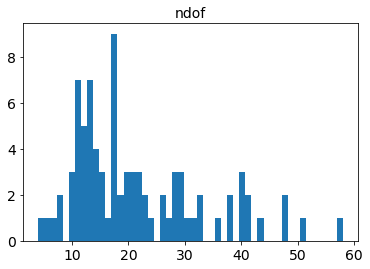

rango chisq/ndof : 0.3431131302019259, 33.41130039818293
promedio chisq/ndof : 3.273255431810132
desviación estándar chisq/ndof : 5.244008190367825
mediana chisq/ndof : 1.5858349638230238


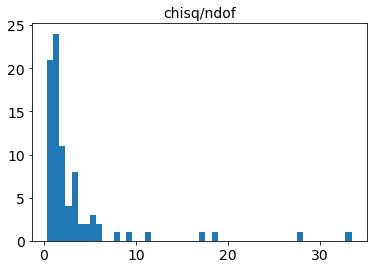

rango z : 0.0181, 0.14
promedio z : 0.07072857142857143
desviación estándar z : 0.026406531350391015
mediana z : 0.07135


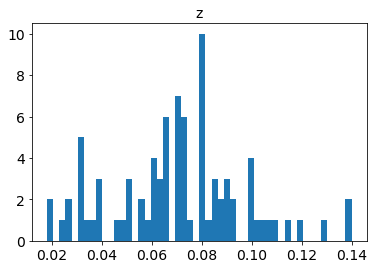

rango t0 : 58254.61862931233, 58395.71445713421
promedio t0 : 58319.848965512225
desviación estándar t0 : 38.75846683464822
mediana t0 : 58313.892844459384


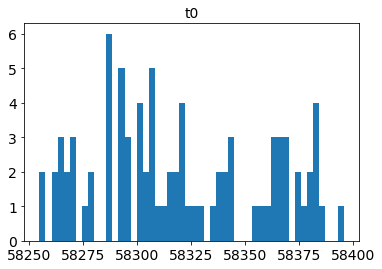

rango t0_err : 0.008852336690324591, 1.140970089356415
promedio t0_err : 0.17626712269174322
desviación estándar t0_err : 0.20077045470327368
mediana t0_err : 0.123673425105153


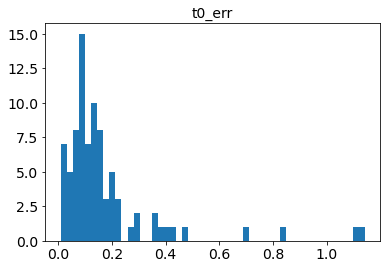

rango x0 : 0.00022861361160102106, 0.011210377293994598
promedio x0 : 0.0013679158137044635
desviación estándar x0 : 0.001806984169907194
mediana x0 : 0.0007163682635537


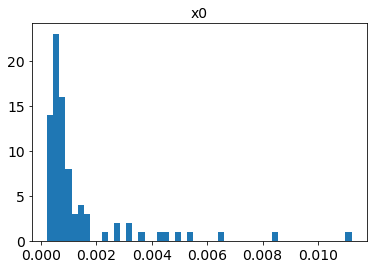

rango x0_err : 4.16418186005795e-06, 6.61640250366066e-05
promedio x0_err : 1.4225789149005223e-05
desviación estándar x0_err : 1.0675545256837621e-05
mediana x0_err : 1.0276989244245858e-05


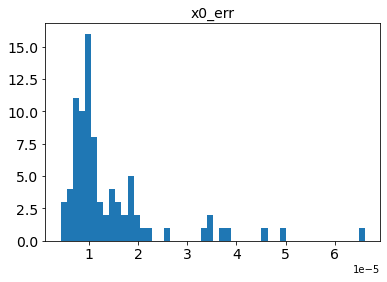

rango x1 : -2.5268717825467966, 2.4762138017941413
promedio x1 : 0.06255589986395063
desviación estándar x1 : 1.09341189245829
mediana x1 : 0.22377092114241343


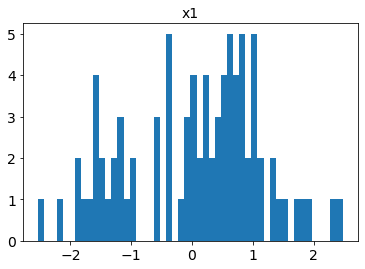

rango x1_err : 0.014895816279680505, 2.174432525459371
promedio x1_err : 0.23342343704628465
desviación estándar x1_err : 0.29145665641586216
mediana x1_err : 0.161855801646897


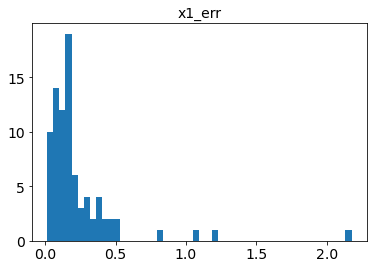

rango c : -0.18078217842949446, 0.6446503059899552
promedio c : 0.017561457170104957
desviación estándar c : 0.11976733508407836
mediana c : 0.002611182220189864


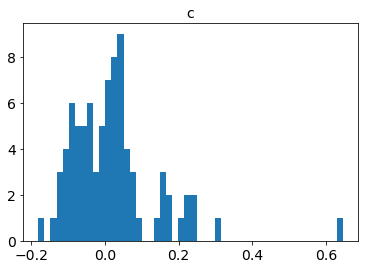

rango c_err : 0.002081287928363721, 0.13190022716449315
promedio c_err : 0.02507899670135853
desviación estándar c_err : 0.01689721103826232
mediana c_err : 0.02172566609612752


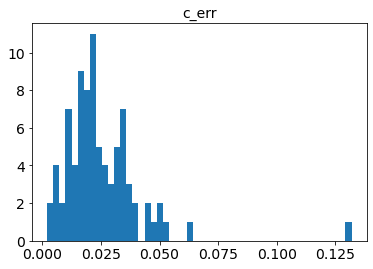

rango mwebv : 0.006204556550167132, 0.1144183424611353
promedio mwebv : 0.03064786661830939
desviación estándar mwebv : 0.02142708623940601
mediana mwebv : 0.02451353213255834


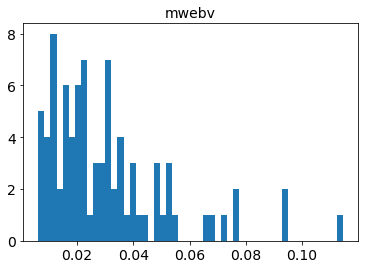

In [272]:
histogramas_estadisticas_resultados(ajustes_SALT3_z_fijo_early_SNIa_cortes_trest, z_real=True)

Estadísticas de los ajustes, ordenados por valor de chisq/ndof

In [273]:
estadisticas_SALT3_z_fijo_cortes_trest = estadisticas_resultados(ajustes_SALT3_z_fijo_early_SNIa_cortes_trest, 
                                                                 z_real=True).sort_values(by=['chisq/ndof'])

Listas de los oid y de los valores de chisq/ndof del ajuste con con el modelo SALT3 y redshift real, utilizando los puntos que pertenecen al rango de tiempo del modelo (determinado con los valores de $t_0$ del primer ajuste y $z=0$), ordenados según el valor de chisq/ndof

In [274]:
lista_oid_SALT3_z_fijo_cortes_trest = list(estadisticas_SALT3_z_fijo_cortes_trest['oid'])
lista_chisq_vs_ndof_SALT3_z_fijo_cortes_trest = list(estadisticas_SALT3_z_fijo_cortes_trest['chisq/ndof'])

Filas de los resultados del ajuste con chisq/ndof sobre la 
mediana 

In [275]:
median_chisq_vs_ndof_SALT3_z_fijo_cortes_trest = np.median(np.array(estadisticas_SALT3_z_fijo_cortes_trest['chisq/ndof']))
df_chisq_vs_ndof_SALT3_z_fijo_sobre_mediana_cortes_trest = estadisticas_SALT3_z_fijo_cortes_trest[estadisticas_SALT3_z_fijo_cortes_trest['chisq/ndof'] > median_chisq_vs_ndof_SALT3_z_fijo_cortes_trest].reset_index()
lista_oid_SALT3_z_fijo_sobre_mediana_cortes_trest = list(df_chisq_vs_ndof_SALT3_z_fijo_sobre_mediana_cortes_trest['oid'])

Mostrar algunas columnas de los resultados del ajuste, con valores de chisq/ndof sobre la mediana

In [276]:
display(df_chisq_vs_ndof_SALT3_z_fijo_sobre_mediana_cortes_trest[['oid', 
                                                                  'chisq/ndof', 
                                                                  'z', 
                                                                  't0', 
                                                                  't0_err']])

oid  chisq/ndof       z            t0    t0_err
0   ZTF18aaxrvzj    1.591053  0.1100  58286.011695  0.153579
1   ZTF18abkifng    1.604195  0.0880  58343.581778  0.170823
2   ZTF18abcsgvj    1.624596  0.0600  58303.515861  0.129176
3   ZTF18abpamut    1.742925  0.0720  58367.688928  0.147617
4   ZTF18absdgon    1.746921  0.0620  58375.934626  0.121366
5   ZTF18abtnlik    1.750879  0.0900  58379.084046  0.153028
6   ZTF18abdbuty    1.820153  0.0600  58307.994801  0.125981
7   ZTF18abclalx    1.905211  0.1000  58301.077940  0.187440
8   ZTF18abealop    1.924834  0.0666  58316.176128  0.189972
9   ZTF18aazsabq    1.936241  0.0500  58293.969488  0.083987
10  ZTF18abckujg    2.037916  0.0740  58303.421237  0.155806
11  ZTF18aaxqyki    2.071909  0.1003  58286.408991  0.128616
12  ZTF18abetewu    2.116499  0.0740  58318.805022  0.195059
13  ZTF18abdefet    2.172546  0.0700  58307.527539  0.221606
14  ZTF18aaxsioa    2.414403  0.0315  58286.129820  0.024758
15  ZTF18aazblzy    2.451922  0.0653  58291.735197  0.048067
16  ZTF18aayjvve    2.851766  0.0474  58292.044427  0.059403
17  ZTF18abcrxoj    2.856347  0.0309  58306.317421  0.051306
18  ZTF18abbvsiv    3.092940  0.0510  58296.788111  0.087649
19  ZTF18aazcoob    3.098912  0.0845  58294.464845  0.143561
20  ZTF18aaytovs    3.101108  0.0746  58294.373012  0.090955
21  ZTF18aaumlfl    3.146747  0.0874  58265.889996  0.131239
22  ZTF18abcflnz    3.175693  0.0273  58306.363455  0.040806
23  ZTF18abgmcmv    3.253776  0.0185  58328.839096  0.050917
24  ZTF18abfhryc    3.383823  0.0323  58324.028687  0.059373
25  ZTF18aauocnw    3.591153  0.1000  58269.065769  0.092167
26  ZTF18aaunfqq    3.683995  0.0711  58268.654652  0.095300
27  ZTF18abetehf    4.268569  0.0649  58318.544224  0.095768
28  ZTF18aavrzxp    4.336242  0.0700  58270.522110  0.095923
29  ZTF18aaxcntm    4.481067  0.0269  58279.026312  0.023795
30  ZTF18aavrwhu    5.070502  0.0620  58275.829125  0.068414
31  ZTF18aaumeys    5.631049  0.0365  58267.226858  0.027897
32  ZTF18aaqqoqs    5.632903  0.0800  58262.589210  0.061376
33  ZTF18aatzygk    5.674600  0.0740  58262.181825  0.116389
34  ZTF18aaqffyp    5.813066  0.0640  58254.618629  0.059198
35  ZTF18aaxdrjn    7.697698  0.0340  58279.024992  0.024464
36  ZTF18aawjywv    9.061203  0.0400  58271.503985  0.055787
37  ZTF18abauprj   11.052427  0.0242  58302.233818  0.025713
38  ZTF18aaslhxt   17.022123  0.0509  58263.634225  0.023178
39  ZTF18aaqcqvr   18.239803  0.0716  58256.522277  0.060114
40  ZTF18abuqugw   27.758132  0.0313  58384.136909  0.083195
41  ZTF18aasdted   33.411300  0.0181  58265.184050  0.008852

Intersección de los oid de las SN con valores de chisq/ndof mayores a la mediana de los ajustes con SALT3 y $z_{real}$  antes y después de eliminar los puntos fuera del rango de tiempo del modelo en trest

In [277]:
inter_oid_SALT3_z_fijo_sobre_mediana_cortes_trest = np.intersect1d(np.array(lista_oid_SALT3_z_fijo_sobre_mediana),
                                                                   np.array(lista_oid_SALT3_z_fijo_sobre_mediana_cortes_trest))
print('Elementos comunes sobre la mediana de chisq/ndof : ',len(inter_oid_SALT3_z_fijo_sobre_mediana_cortes_trest))

Elementos comunes sobre la mediana de chisq/ndof :  39


Tabla de astropy con las detecciones que están en el rango de tiempo del modelo, en el formato que requiere sncosmo para hacer los ajustes 

In [278]:
table_early_SNIa_SALT3_z_fijo_cortes_trest = astropy_table_detections(df_meta_early_SNIa, 
                                                                     detect_early_SNIa_cortes_trest_SALT3_z_fijo)

Algunos gráficos de los ajustes de las SN que tienen valores de $\frac{\chi^{2}}{ndof}$ menores a la mediana.

 ===== Ajuste con redshift real ====
chisq/ndof :  0.49751373052530834


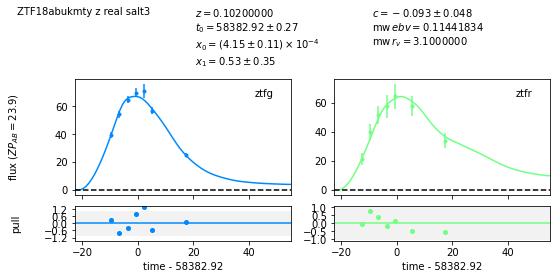

In [279]:
ajuste(lista_oid_SALT3_z_fijo_cortes_trest[2], 'salt3', df_meta_early_SNIa, 
       table_early_SNIa_SALT3_z_fijo_cortes_trest, z_real=True)[0]
print('chisq/ndof : ', 
      lista_chisq_vs_ndof_SALT3_z_fijo_cortes_trest[2])

 ===== Ajuste con redshift real ====
chisq/ndof :  0.8693973479228999


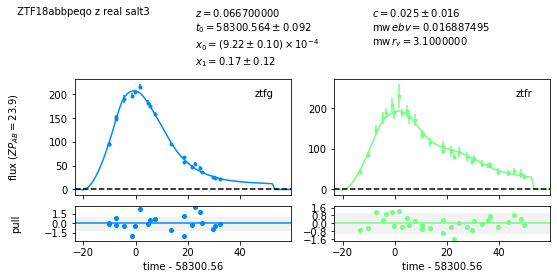

In [280]:
ajuste(lista_oid_SALT3_z_fijo_cortes_trest[16], 'salt3', df_meta_early_SNIa, 
       table_early_SNIa_SALT3_z_fijo_cortes_trest, z_real=True)[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT3_z_fijo_cortes_trest[16])

 ===== Ajuste con redshift real ====
chisq/ndof :  0.8834262214283835


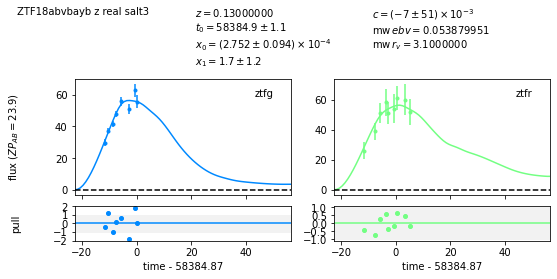

In [281]:
ajuste(lista_oid_SALT3_z_fijo_cortes_trest[18], 'salt3', df_meta_early_SNIa, 
       table_early_SNIa_SALT3_z_fijo_cortes_trest, z_real=True)[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT3_z_fijo_cortes_trest[18])

 ===== Ajuste con redshift real ====
chisq/ndof :  1.1872435047433483


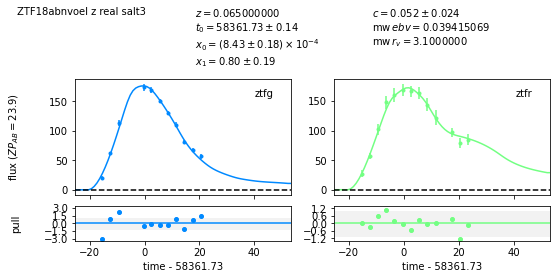

In [282]:
ajuste(lista_oid_SALT3_z_fijo_cortes_trest[26], 'salt3', df_meta_early_SNIa, 
       table_early_SNIa_SALT3_z_fijo_cortes_trest, z_real=True)[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT3_z_fijo_cortes_trest[26])

 ===== Ajuste con redshift real ====
chisq/ndof :  1.4420701475804265


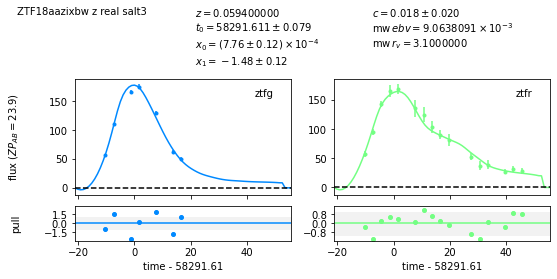

In [283]:
ajuste(lista_oid_SALT3_z_fijo_cortes_trest[33], 'salt3', df_meta_early_SNIa, 
       table_early_SNIa_SALT3_z_fijo_cortes_trest, z_real=True)[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT3_z_fijo_cortes_trest[33])

 ===== Ajuste con redshift real ====
chisq/ndof :  1.4938626949453462


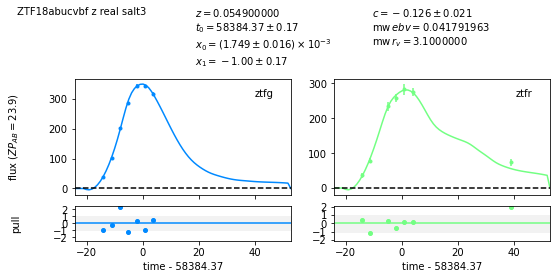

In [284]:
ajuste(lista_oid_SALT3_z_fijo_cortes_trest[35], 'salt3', df_meta_early_SNIa, 
       table_early_SNIa_SALT3_z_fijo_cortes_trest, z_real=True)[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT3_z_fijo_cortes_trest[35])

 ===== Ajuste con redshift real ====
chisq/ndof :  1.5040002473861547


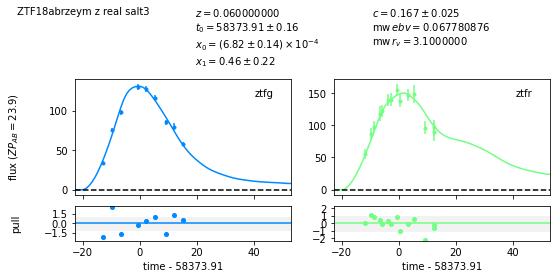

In [285]:
ajuste(lista_oid_SALT3_z_fijo_cortes_trest[38], 'salt3', df_meta_early_SNIa, 
       table_early_SNIa_SALT3_z_fijo_cortes_trest, z_real=True)[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT3_z_fijo_cortes_trest[38])

 ===== Ajuste con redshift real ====
chisq/ndof :  1.5189389899117554


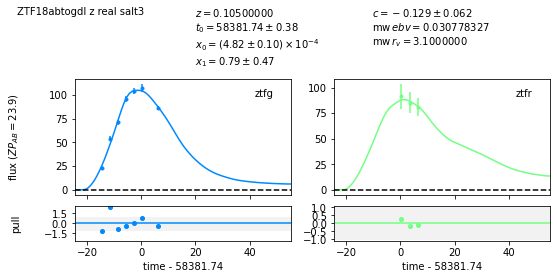

In [286]:
ajuste(lista_oid_SALT3_z_fijo_cortes_trest[39], 'salt3', df_meta_early_SNIa, 
       table_early_SNIa_SALT3_z_fijo_cortes_trest, z_real=True)[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT3_z_fijo_cortes_trest[39])

Algunos gráficos de los ajustes de las SN que tienen valores de $\frac{\chi^{2}}{ndof}$ mayores a la mediana.

 ===== Ajuste con redshift real ====
chisq/ndof :  1.5910532615905575


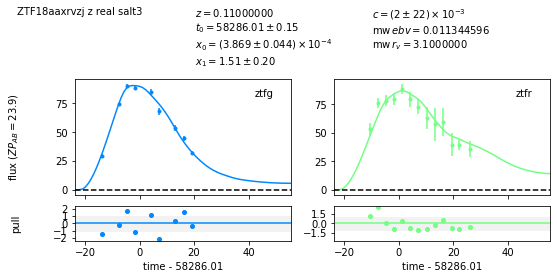

In [287]:
ajuste(lista_oid_SALT3_z_fijo_sobre_mediana_cortes_trest[0], 'salt3', df_meta_early_SNIa, 
       table_early_SNIa_SALT3_z_fijo_cortes_trest, z_real=True)[0]
print('chisq/ndof : ', 
      df_chisq_vs_ndof_SALT3_z_fijo_sobre_mediana_cortes_trest['chisq/ndof'][0])

 ===== Ajuste con redshift real ====
chisq/ndof :  1.7429247230708345


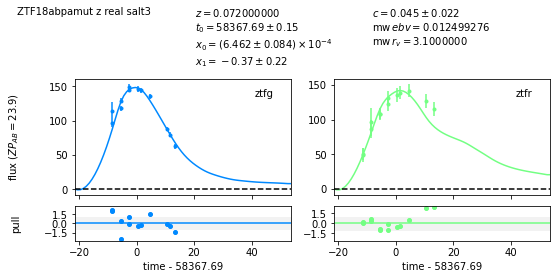

In [288]:
ajuste(lista_oid_SALT3_z_fijo_sobre_mediana_cortes_trest[3], 'salt3', df_meta_early_SNIa, 
       table_early_SNIa_SALT3_z_fijo_cortes_trest, z_real=True)[0]
print('chisq/ndof : ', 
      df_chisq_vs_ndof_SALT3_z_fijo_sobre_mediana_cortes_trest['chisq/ndof'][3])

 ===== Ajuste con redshift real ====
chisq/ndof :  1.9362407034884597


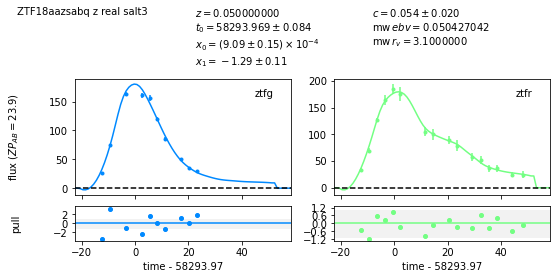

In [289]:
ajuste(lista_oid_SALT3_z_fijo_sobre_mediana_cortes_trest[9], 'salt3', df_meta_early_SNIa, 
       table_early_SNIa_SALT3_z_fijo_cortes_trest, z_real=True)[0]
print('chisq/ndof : ', 
      df_chisq_vs_ndof_SALT3_z_fijo_sobre_mediana_cortes_trest['chisq/ndof'][9])

 ===== Ajuste con redshift real ====
chisq/ndof :  2.1725461680813276


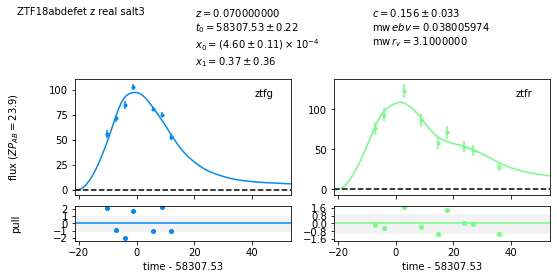

In [290]:
ajuste(lista_oid_SALT3_z_fijo_sobre_mediana_cortes_trest[13], 'salt3', df_meta_early_SNIa, 
       table_early_SNIa_SALT3_z_fijo_cortes_trest, z_real=True)[0]
print('chisq/ndof : ', 
      df_chisq_vs_ndof_SALT3_z_fijo_sobre_mediana_cortes_trest['chisq/ndof'][13])

 ===== Ajuste con redshift real ====
chisq/ndof :  3.092939630447042


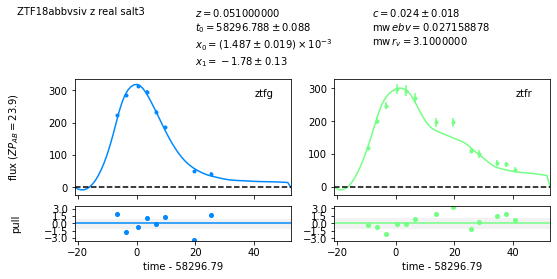

In [291]:
ajuste(lista_oid_SALT3_z_fijo_sobre_mediana_cortes_trest[18], 'salt3', df_meta_early_SNIa, 
       table_early_SNIa_SALT3_z_fijo_cortes_trest, z_real=True)[0]
print('chisq/ndof : ', 
      df_chisq_vs_ndof_SALT3_z_fijo_sobre_mediana_cortes_trest['chisq/ndof'][18])

 ===== Ajuste con redshift real ====
chisq/ndof :  3.1011076321617876


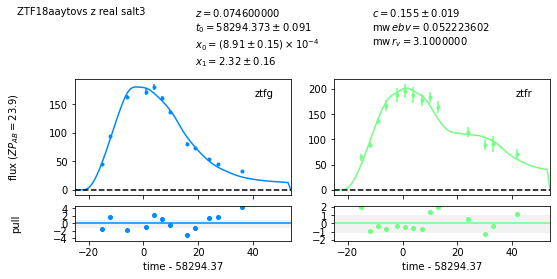

In [292]:
ajuste(lista_oid_SALT3_z_fijo_sobre_mediana_cortes_trest[20], 'salt3', df_meta_early_SNIa, 
       table_early_SNIa_SALT3_z_fijo_cortes_trest, z_real=True)[0]
print('chisq/ndof : ', 
      df_chisq_vs_ndof_SALT3_z_fijo_sobre_mediana_cortes_trest['chisq/ndof'][20])

 ===== Ajuste con redshift real ====
chisq/ndof :  18.239802608113298


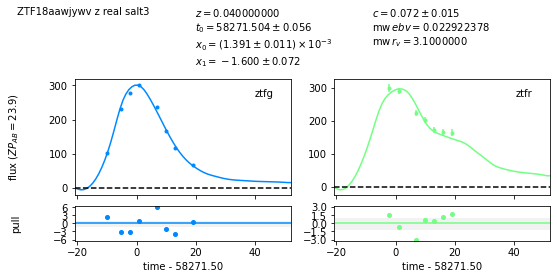

In [293]:
ajuste(lista_oid_SALT3_z_fijo_sobre_mediana_cortes_trest[36], 'salt3', df_meta_early_SNIa, 
       table_early_SNIa_SALT3_z_fijo_cortes_trest, z_real=True)[0]
print('chisq/ndof : ', 
      df_chisq_vs_ndof_SALT3_z_fijo_sobre_mediana_cortes_trest['chisq/ndof'][39])

 ===== Ajuste con redshift real ====
chisq/ndof :  33.41130039818293


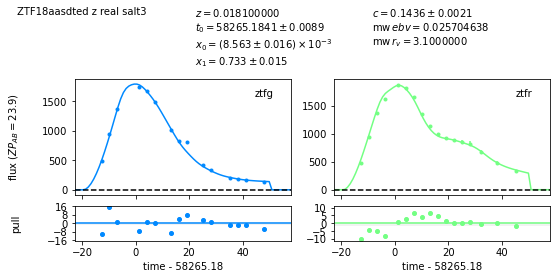

In [294]:
ajuste(lista_oid_SALT3_z_fijo_sobre_mediana_cortes_trest[41], 'salt3', df_meta_early_SNIa, 
       table_early_SNIa_SALT3_z_fijo_cortes_trest, z_real=True)[0]
print('chisq/ndof : ', 
      df_chisq_vs_ndof_SALT3_z_fijo_sobre_mediana_cortes_trest['chisq/ndof'][41])

### Ajuste con redshift variable

Seleccionar las detecciones de las SN que están dentro del rango de tiempo del modelo según el valor de $t_0$ del primer ajuste con el modelo SALT3 $z=0$, donde el siguiente ajuste se realizará con redshift variable

In [295]:
detect_early_SNIa_sin_SN52_cortes_trest = cortes_trest_modelo(trest_min_modelo, 
                                                              trest_max_modelo, 
                                                              detect_early_SNIa_sin_SN52,
                                                              estadisticas_SALT3_z_var)

Ajustes con las detecciones de las SN que están dentro del rango de tiempo del modelo, determinado con $z=0$ y $t_0$ del primer ajuste

In [296]:
ajustes_SALT3_early_SNIa_sin_SN52_cortes_trest = modelo_ajustado_y_resultados('salt3', 
                                                                              df_meta_early_SNIa_sin_SN52, 
                                                                              detect_early_SNIa_sin_SN52_cortes_trest,
                                                                              print_ind_and_oid=False)

rango ncall : 149, 1108
promedio ncall : 340.1927710843373
desviación estándar ncall : 166.11488678138812
mediana ncall : 288.0


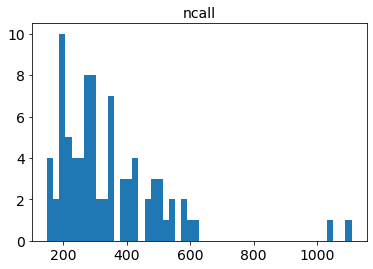

rango chisq : 1.4803418175203376, 961.9926197170648
promedio chisq : 93.85400440718269
desviación estándar chisq : 173.83938730979165
mediana chisq : 31.579796509588057


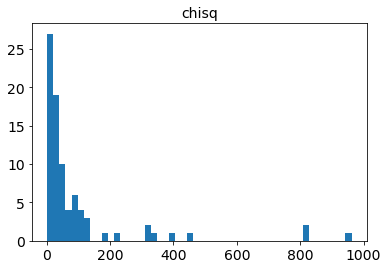

rango ndof : 3, 57
promedio ndof : 20.132530120481928
desviación estándar ndof : 11.190326162475637
mediana ndof : 17.0


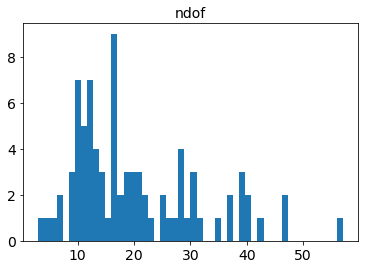

rango chisq/ndof : 0.4772206745634247, 32.76611388447659
promedio chisq/ndof : 4.086963137440969
desviación estándar chisq/ndof : 5.941275152025697
mediana chisq/ndof : 1.8572069424035058


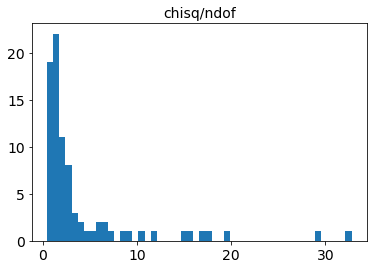

rango z : 0.0010000000002969996, 0.34578605065753426
promedio z : 0.15641934050167366
desviación estándar z : 0.10029198781460162
mediana z : 0.15873161828621143


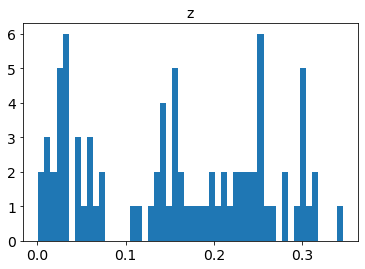

rango z_err : 1.880221672800886e-12, 0.1515034069608234
promedio z_err : 0.0225893226649873
desviación estándar z_err : 0.023987191333724345
mediana z_err : 0.017128224112049027


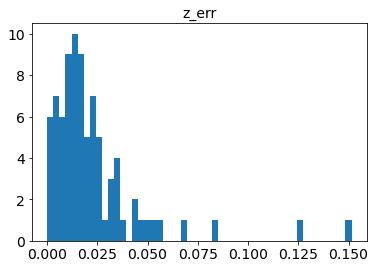

rango t0 : 58256.76099932384, 58395.08339788103
promedio t0 : 58320.473137356945
desviación estándar t0 : 38.9244178097839
mediana t0 : 58313.78372371998


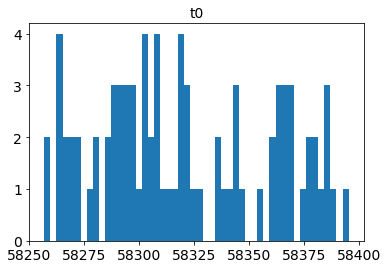

rango t0_err : 5.3551048040390015e-09, 2.096757954579516
promedio t0_err : 0.3061841716949112
desviación estándar t0_err : 0.34885069770757776
mediana t0_err : 0.20984049589606002


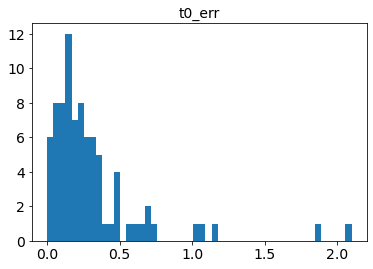

rango x0 : 0.00022795865919194336, 0.011446448142203995
promedio x0 : 0.0013224688658093828
desviación estándar x0 : 0.0018170615931488172
mediana x0 : 0.0006649752247342893


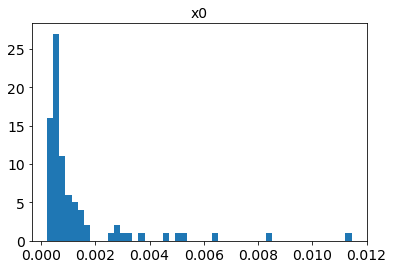

rango x0_err : 5.8647997696926295e-06, 7.890015495755771e-05
promedio x0_err : 2.0855870277150237e-05
desviación estándar x0_err : 1.4117511996168976e-05
mediana x0_err : 1.6278705637479562e-05


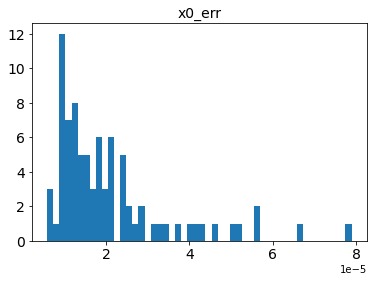

rango x1 : -2.5865571708243507, 3.9999999532332513
promedio x1 : 0.06289799410581347
desviación estándar x1 : 1.227134605078029
mediana x1 : 0.20898746732671736


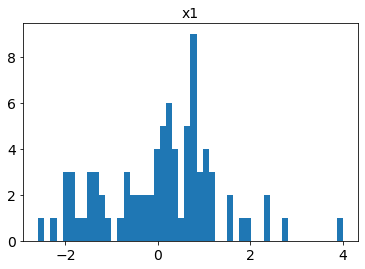

rango x1_err : 0.013075263987949892, 1.7884604736473213
promedio x1_err : 0.2585926544681858
desviación estándar x1_err : 0.28080620367636483
mediana x1_err : 0.18381136074043614


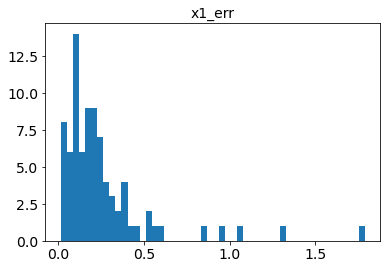

rango c : -0.3506298480117703, 0.2723707852536782
promedio c : -0.0710923671584574
desviación estándar c : 0.12498517777336089
mediana c : -0.06399832272697792


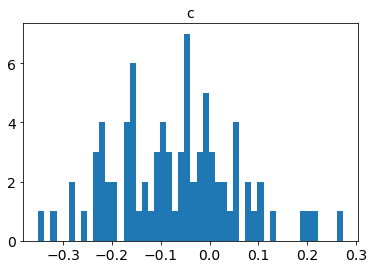

rango c_err : 0.002305617688235395, 0.15880576579460273
promedio c_err : 0.03454442604339404
desviación estándar c_err : 0.026489124483535312
mediana c_err : 0.02896001046211677


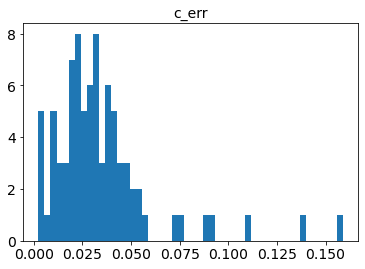

rango mwebv : 0.006204556550167132, 0.1144183424611353
promedio mwebv : 0.030530745972028404
desviación estándar mwebv : 0.02152903487450753
mediana mwebv : 0.023404313345236558


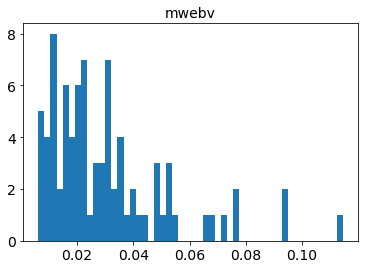

In [297]:
histogramas_estadisticas_resultados(ajustes_SALT3_early_SNIa_sin_SN52_cortes_trest)

Estadísticas de los ajustes, ordenados por valor de chisq/ndof

In [298]:
estadisticas_SALT3_z_var_cortes_trest = estadisticas_resultados(ajustes_SALT3_early_SNIa_sin_SN52_cortes_trest).sort_values(by=['chisq/ndof'])

Listas de los oid y de los valores de chisq/ndof del ajuste con con el modelo SALT3 y redshift variable, utilizando los puntos que pertenecen al rango de tiempo del modelo (determinado con los valores de $t_0$ del primer ajuste y $z=0$), ordenados según el valor de chisq/ndof

In [299]:
lista_oid_SALT3_z_var_cortes_trest = list(estadisticas_SALT3_z_var_cortes_trest['oid'])
lista_chisq_vs_ndof_SALT3_z_var_cortes_trest = list(estadisticas_SALT3_z_var_cortes_trest['chisq/ndof'])

Filas de los resultados del ajuste con chisq/ndof sobre la 
mediana 

In [300]:
median_chisq_vs_ndof_SALT3_z_var_cortes_trest = np.median(np.array(estadisticas_SALT3_z_var_cortes_trest['chisq/ndof']))
df_chisq_vs_ndof_SALT3_z_var_sobre_mediana_cortes_trest = estadisticas_SALT3_z_var_cortes_trest[estadisticas_SALT3_z_var_cortes_trest['chisq/ndof'] > median_chisq_vs_ndof_SALT3_z_var_cortes_trest].reset_index()
lista_oid_SALT3_z_var_sobre_mediana_cortes_trest = list(df_chisq_vs_ndof_SALT3_z_var_sobre_mediana_cortes_trest['oid'])

Mostrar algunas columnas de los resultados del ajuste, con valores de chisq/ndof sobre la mediana

In [301]:
display(df_chisq_vs_ndof_SALT3_z_var_sobre_mediana_cortes_trest[['oid', 
                                                                 'chisq/ndof', 
                                                                 'z', 
                                                                 'z_err', 
                                                                 't0', 
                                                                 't0_err']])

oid  chisq/ndof         z         z_err            t0  \
0   ZTF18aaxrvzj    1.875722  0.198386  3.471400e-02  58286.756858   
1   ZTF18abckujg    1.878410  0.028785  9.639951e-03  58302.911508   
2   ZTF18aazsabq    1.919094  0.033883  7.921356e-03  58293.747247   
3   ZTF18aazjztm    1.970341  0.301664  1.897528e-02  58293.197921   
4   ZTF18abtnlik    2.035663  0.263541  2.632175e-02  58380.518237   
5   ZTF18abimsyv    2.178769  0.240571  9.676009e-03  58336.302540   
6   ZTF18aaxwjmp    2.218599  0.302822  1.513047e-02  58290.293653   
7   ZTF18abclalx    2.266776  0.261197  2.244619e-02  58302.393653   
8   ZTF18abetewu    2.304188  0.069200  2.146927e-02  58318.796142   
9   ZTF18aaxsioa    2.332523  0.032291  2.777458e-03  58286.141831   
10  ZTF18abdefet    2.503095  0.156539  3.569423e-02  58307.885729   
11  ZTF18abbvsiv    2.510577  0.209014  1.025051e-02  58297.855964   
12  ZTF18abealop    2.733973  0.308337  2.184332e-02  58318.181160   
13  ZTF18aazcoob    2.748277  0.209750  1.720263e-02  58295.977054   
14  ZTF18abrzeym    2.754702  0.302488  1.754064e-02  58375.891087   
15  ZTF18abfhryc    2.880559  0.024978  4.369770e-11  58323.935412   
16  ZTF18aaxqyki    2.965502  0.251277  1.487892e-02  58287.876362   
17  ZTF18aayjvve    2.978996  0.045567  7.644825e-03  58292.019659   
18  ZTF18abcsgvj    3.391030  0.253280  1.754492e-02  58304.966417   
19  ZTF18abcflnz    3.546539  0.034229  1.880222e-12  58306.500555   
20  ZTF18aansqun    3.611884  0.313789  2.298137e-02  58317.036016   
21  ZTF18abetehf    3.781271  0.253457  1.139823e-02  58320.057798   
22  ZTF18aauocnw    4.121432  0.167545  3.080211e-02  58269.352074   
23  ZTF18aazblzy    4.554183  0.235498  9.617532e-03  58293.011045   
24  ZTF18aaytovs    5.569442  0.345786  1.081799e-02  58297.476078   
25  ZTF18aatzygk    5.991135  0.193538  1.841849e-02  58262.965114   
26  ZTF18aavrwhu    6.277488  0.158732  9.107390e-03  58276.310875   
27  ZTF18aaunfqq    6.575474  0.251730  1.391596e-02  58270.058459   
28  ZTF18aavrzxp    6.742856  0.166034  1.121106e-02  58270.818055   
29  ZTF18aaqqoqs    7.396076  0.243850  8.178882e-03  58264.284813   
30  ZTF18aaqffyp    8.610028  0.300922  1.652987e-02  58256.760999   
31  ZTF18aaxdrjn    9.264974  0.128377  5.376229e-03  58279.670511   
32  ZTF18abauprj   10.508305  0.012544  1.673271e-03  58301.937093   
33  ZTF18aawjywv   11.887240  0.145280  1.085629e-02  58271.997701   
34  ZTF18abcrxoj   14.968129  0.222513  6.344720e-03  58308.251810   
35  ZTF18abuqugw   15.829426  0.001000  9.443113e-04  58389.201234   
36  ZTF18aaslhxt   16.877064  0.026615  3.088138e-03  58263.217061   
37  ZTF18aaumeys   17.904043  0.139732  4.063460e-03  58267.787587   
38  ZTF18aaqcqvr   19.788674  0.135976  1.460313e-02  58256.963531   
39  ZTF18aasdted   29.256932  0.028263  9.229065e-04  58265.366913   
40  ZTF18aaxcntm   32.766114  0.292970  3.641975e-03  58281.330606   

          t0_err  
0   6.573904e-01  
1   2.376389e-01  
2   1.534722e-01  
3   2.571549e-01  
4   2.933191e-01  
5   1.965998e-01  
6   2.098405e-01  
7   2.972257e-01  
8   1.984565e-01  
9   4.956389e-02  
10  2.591158e-01  
11  1.688636e-01  
12  3.431250e-01  
13  3.138649e-01  
14  2.972548e-01  
15  5.355105e-09  
16  1.670901e-01  
17  1.221331e-01  
18  1.819074e-01  
19  4.111585e-02  
20  6.928132e-01  
21  1.332495e-01  
22  3.023166e-01  
23  7.277858e-02  
24  2.124026e-01  
25  3.714272e-01  
26  8.786745e-02  
27  1.286627e-01  
28  1.277196e-01  
29  9.543800e-02  
30  1.973404e-01  
31  3.245094e-02  
32  5.228579e-02  
33  5.852614e-02  
34  7.272317e-02  
35  3.256141e-02  
36  6.562237e-02  
37  2.972526e-02  
38  7.888143e-02  
39  1.908250e-02  
40  5.204346e-02

Intersección de los oid de las SN con valores de chisq/ndof mayores a la mediana de los ajustes con SALT3 y $z$ variable  antes y después de eliminar los puntos fuera del rango de tiempo del modelo en trest

In [302]:
inter_oid_SALT3_z_var_sobre_mediana_cortes_trest = np.intersect1d(np.array(lista_oid_SALT3_z_var_sobre_mediana),
                                                                   np.array(lista_oid_SALT3_z_var_sobre_mediana_cortes_trest))
print('Elementos comunes sobre la mediana de chisq/ndof : ',len(inter_oid_SALT3_z_var_sobre_mediana_cortes_trest))

Elementos comunes sobre la mediana de chisq/ndof :  38


Tabla de astropy con las detecciones que están en el rango de tiempo del modelo, en el formato que requiere sncosmo para hacer los ajustes 

In [303]:
table_early_SNIa_sin_SN52_SALT3_z_var_cortes_trest = astropy_table_detections(df_meta_early_SNIa_sin_SN52,
                                                                              detect_early_SNIa_sin_SN52_cortes_trest)

Algunos gráficos de los ajustes de las SN que tienen valores de $\frac{\chi^{2}}{ndof}$ menores a la mediana.

 ==== Con ajuste del redshift ====
chisq/ndof :  0.4772206745634247


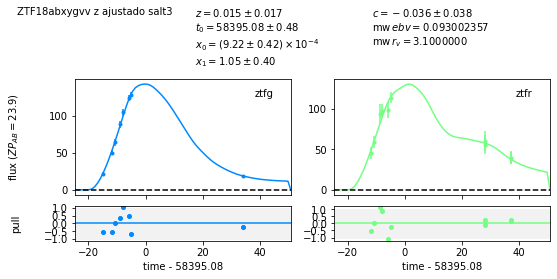

In [304]:
ajuste(lista_oid_SALT3_z_var_cortes_trest[0], 'salt3', df_meta_early_SNIa_sin_SN52, 
       table_early_SNIa_sin_SN52_SALT3_z_var_cortes_trest)[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT3_z_var_cortes_trest[0])

 ==== Con ajuste del redshift ====
chisq/ndof :  0.5372267826312719


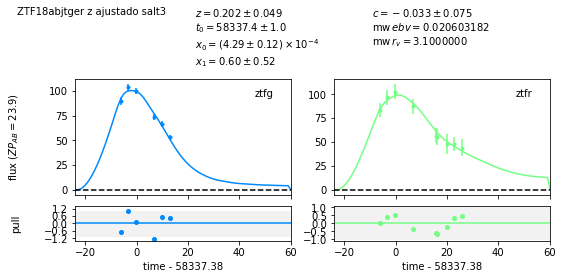

In [305]:
ajuste(lista_oid_SALT3_z_var_cortes_trest[3], 'salt3', df_meta_early_SNIa_sin_SN52, 
       table_early_SNIa_sin_SN52_SALT3_z_var_cortes_trest)[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT3_z_var_cortes_trest[3])

 ==== Con ajuste del redshift ====
chisq/ndof :  0.7656544692580272


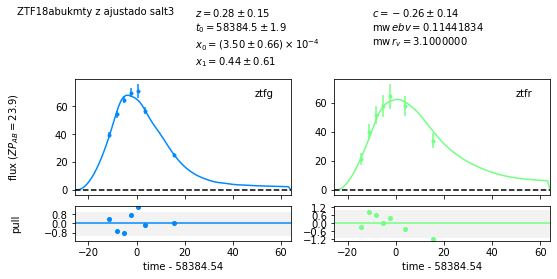

In [306]:
ajuste(lista_oid_SALT3_z_var_cortes_trest[10], 'salt3', df_meta_early_SNIa_sin_SN52, 
       table_early_SNIa_sin_SN52_SALT3_z_var_cortes_trest)[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT3_z_var_cortes_trest[10])

 ==== Con ajuste del redshift ====
chisq/ndof :  1.1278498753424306


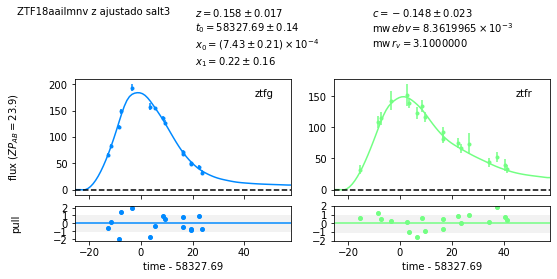

In [307]:
ajuste(lista_oid_SALT3_z_var_cortes_trest[19], 'salt3', df_meta_early_SNIa_sin_SN52, 
       table_early_SNIa_sin_SN52_SALT3_z_var_cortes_trest)[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT3_z_var_cortes_trest[19])

 ==== Con ajuste del redshift ====
chisq/ndof :  1.4476431809725094


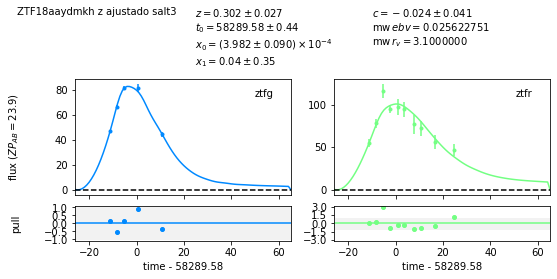

In [308]:
ajuste(lista_oid_SALT3_z_var_cortes_trest[31], 'salt3', df_meta_early_SNIa_sin_SN52, 
       table_early_SNIa_sin_SN52_SALT3_z_var_cortes_trest)[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT3_z_var_cortes_trest[31])

 ==== Con ajuste del redshift ====
chisq/ndof :  1.6230128415402219


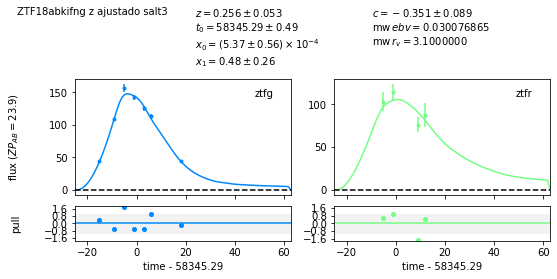

In [309]:
ajuste(lista_oid_SALT3_z_var_cortes_trest[36], 'salt3', df_meta_early_SNIa_sin_SN52, 
       table_early_SNIa_sin_SN52_SALT3_z_var_cortes_trest)[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT3_z_var_cortes_trest[36])

 ==== Con ajuste del redshift ====
chisq/ndof :  1.676841733205033


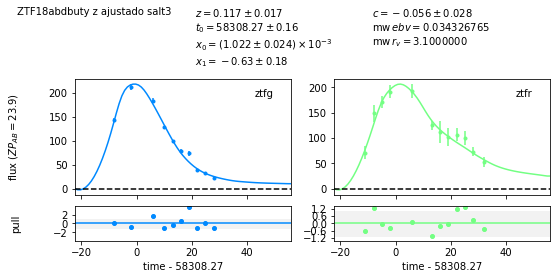

In [310]:
ajuste(lista_oid_SALT3_z_var_cortes_trest[40], 'salt3', df_meta_early_SNIa_sin_SN52, 
       table_early_SNIa_sin_SN52_SALT3_z_var_cortes_trest)[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT3_z_var_cortes_trest[40])

 ==== Con ajuste del redshift ====
chisq/ndof :  1.8572069424035058


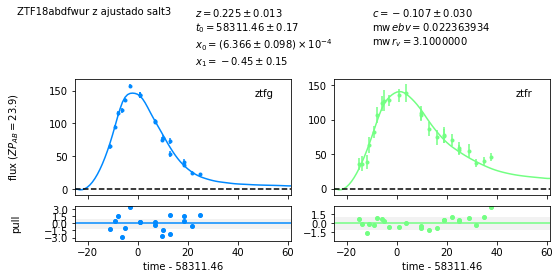

In [311]:
ajuste(lista_oid_SALT3_z_var_cortes_trest[41], 'salt3', df_meta_early_SNIa_sin_SN52, 
       table_early_SNIa_sin_SN52_SALT3_z_var_cortes_trest)[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT3_z_var_cortes_trest[41])

Algunos gráficos de los ajustes de las SN que tienen valores de $\frac{\chi^{2}}{ndof}$ mayores a la mediana.

 ==== Con ajuste del redshift ====
chisq/ndof :  1.9703406295734411


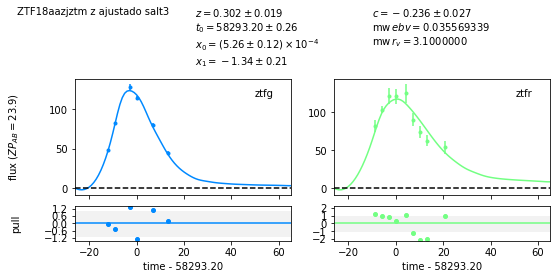

In [312]:
ajuste(lista_oid_SALT3_z_var_sobre_mediana_cortes_trest[3], 'salt3', df_meta_early_SNIa_sin_SN52, 
       table_early_SNIa_sin_SN52_SALT3_z_var_cortes_trest)[0]
print('chisq/ndof : ', df_chisq_vs_ndof_SALT3_z_var_sobre_mediana_cortes_trest['chisq/ndof'][3])

 ==== Con ajuste del redshift ====
chisq/ndof :  2.5030950364639555


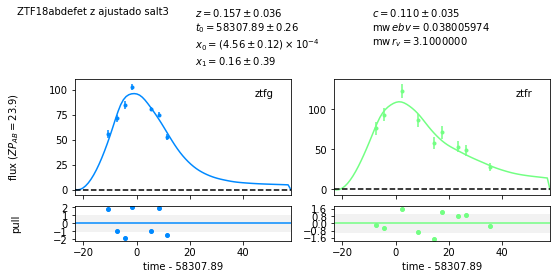

In [313]:
ajuste(lista_oid_SALT3_z_var_sobre_mediana_cortes_trest[10], 'salt3', df_meta_early_SNIa_sin_SN52, 
       table_early_SNIa_sin_SN52_SALT3_z_var_cortes_trest)[0]
print('chisq/ndof : ', df_chisq_vs_ndof_SALT3_z_var_sobre_mediana_cortes_trest['chisq/ndof'][10])

 ==== Con ajuste del redshift ====
chisq/ndof :  2.754702041876596


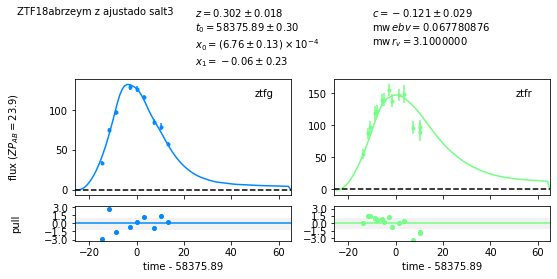

In [314]:
ajuste(lista_oid_SALT3_z_var_sobre_mediana_cortes_trest[14], 'salt3', df_meta_early_SNIa_sin_SN52, 
       table_early_SNIa_sin_SN52_SALT3_z_var_cortes_trest)[0]
print('chisq/ndof : ', df_chisq_vs_ndof_SALT3_z_var_sobre_mediana_cortes_trest['chisq/ndof'][14])

 ==== Con ajuste del redshift ====
chisq/ndof :  2.9789958026212093


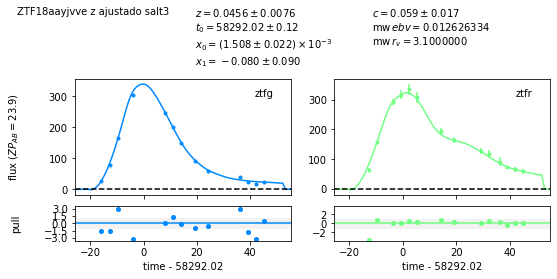

In [315]:
ajuste(lista_oid_SALT3_z_var_sobre_mediana_cortes_trest[17], 'salt3', df_meta_early_SNIa_sin_SN52, 
       table_early_SNIa_sin_SN52_SALT3_z_var_cortes_trest)[0]
print('chisq/ndof : ', df_chisq_vs_ndof_SALT3_z_var_sobre_mediana_cortes_trest['chisq/ndof'][17])

 ==== Con ajuste del redshift ====
chisq/ndof :  3.6118840745223606


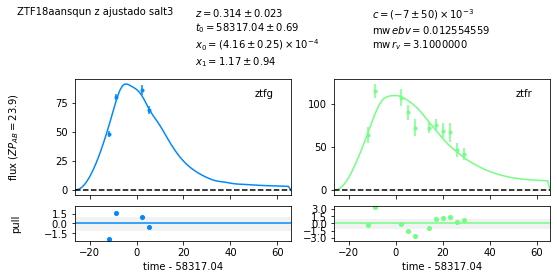

In [316]:
ajuste(lista_oid_SALT3_z_var_sobre_mediana_cortes_trest[20], 'salt3', df_meta_early_SNIa_sin_SN52, 
       table_early_SNIa_sin_SN52_SALT3_z_var_cortes_trest)[0]
print('chisq/ndof : ', df_chisq_vs_ndof_SALT3_z_var_sobre_mediana_cortes_trest['chisq/ndof'][20])

 ==== Con ajuste del redshift ====
chisq/ndof :  2.17876879766047


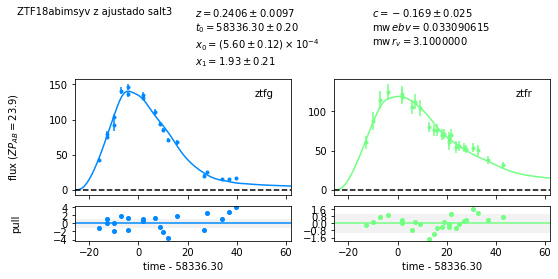

In [317]:
ajuste(lista_oid_SALT3_z_var_sobre_mediana_cortes_trest[5], 'salt3', df_meta_early_SNIa_sin_SN52, 
       table_early_SNIa_sin_SN52_SALT3_z_var_cortes_trest)[0]
print('chisq/ndof : ', df_chisq_vs_ndof_SALT3_z_var_sobre_mediana_cortes_trest['chisq/ndof'][5])

 ==== Con ajuste del redshift ====
chisq/ndof :  5.56944210122612


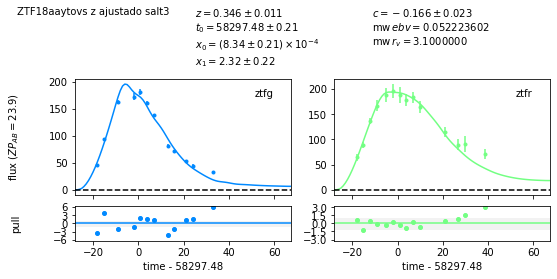

In [318]:
ajuste(lista_oid_SALT3_z_var_sobre_mediana_cortes_trest[24], 'salt3', df_meta_early_SNIa_sin_SN52, 
       table_early_SNIa_sin_SN52_SALT3_z_var_cortes_trest)[0]
print('chisq/ndof : ', df_chisq_vs_ndof_SALT3_z_var_sobre_mediana_cortes_trest['chisq/ndof'][24])

 ==== Con ajuste del redshift ====
chisq/ndof :  7.396076422265404


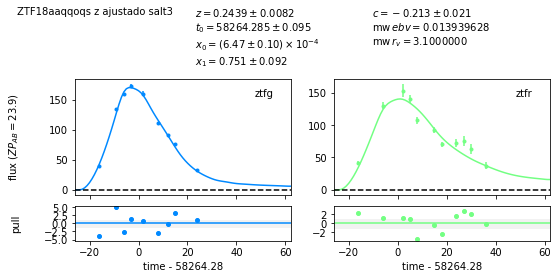

In [319]:
ajuste(lista_oid_SALT3_z_var_sobre_mediana_cortes_trest[29], 'salt3', df_meta_early_SNIa_sin_SN52, 
       table_early_SNIa_sin_SN52_SALT3_z_var_cortes_trest)[0]
print('chisq/ndof : ', df_chisq_vs_ndof_SALT3_z_var_sobre_mediana_cortes_trest['chisq/ndof'][29])

 ==== Con ajuste del redshift ====
chisq/ndof :  15.829426219720606


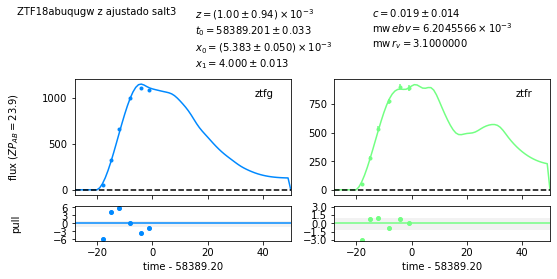

In [320]:
ajuste(lista_oid_SALT3_z_var_sobre_mediana_cortes_trest[35], 'salt3', df_meta_early_SNIa_sin_SN52, 
       table_early_SNIa_sin_SN52_SALT3_z_var_cortes_trest)[0]
print('chisq/ndof : ', df_chisq_vs_ndof_SALT3_z_var_sobre_mediana_cortes_trest['chisq/ndof'][35])

 ==== Con ajuste del redshift ====
chisq/ndof :  32.76611388447659


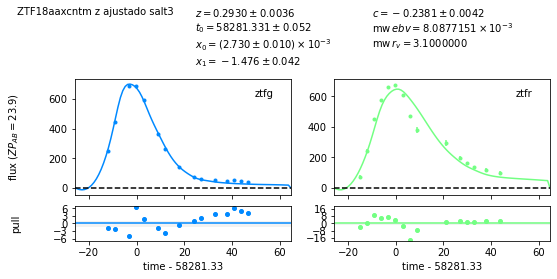

In [321]:
ajuste(lista_oid_SALT3_z_var_sobre_mediana_cortes_trest[40], 'salt3', df_meta_early_SNIa_sin_SN52, 
       table_early_SNIa_sin_SN52_SALT3_z_var_cortes_trest)[0]
print('chisq/ndof : ', df_chisq_vs_ndof_SALT3_z_var_sobre_mediana_cortes_trest['chisq/ndof'][40])

## Ajuste con límite más estricto en el valor de $z$ (solo afecta a los que también ajustan $z$) 

Aquí sabemos que el rango de redshift real de las SNIa es $0.0181 \leq z \leq 0.141$. Probaremos que pasa si en los ajustes se utiliza un rango más estricto de valores de $z$, que en este ejemplo será $z_{bounds} = [0, 0.2]$.

### Ajuste usando todas las observaciones (con redshift variable), se debe eliminar una SN ya que no se puede ajustar (si no se elimina el programa se cae)

In [322]:
name_15 = names_SNIa[15]
print('Eliminada : ', name_15)

df_meta_early_SNIa_sin_SN15 = df_meta_early_SNIa[df_meta_early_SNIa['oid'] != name_15]
detect_early_SNIa_sin_SN15 = detect_early_SNIa[detect_early_SNIa['oid'] != name_15]

ajustes_SALT3_early_SNIa_z_bounded = modelo_ajustado_y_resultados('salt3', 
                                                                  df_meta_early_SNIa_sin_SN15, 
                                                                  detect_early_SNIa_sin_SN15,
                                                                  z_bounds=z_bounds,
                                                                  print_ind_and_oid=False)

Eliminada :  ZTF18aaxcntm


Link en ALeRCE ZTF explorer de esta SN: https://alerce.online/object/ZTF18aaxcntm

rango ncall : 123, 878
promedio ncall : 254.24096385542168
desviación estándar ncall : 128.34099818818012
mediana ncall : 209.0


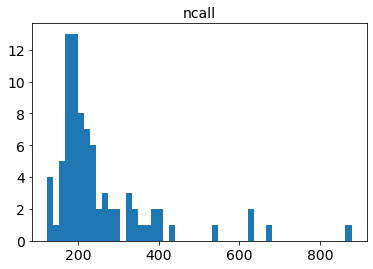

rango chisq : 1.3678884774614748, 21517.75265769396
promedio chisq : 738.3675737799368
desviación estándar chisq : 3189.430067781605
mediana chisq : 30.578420886966448


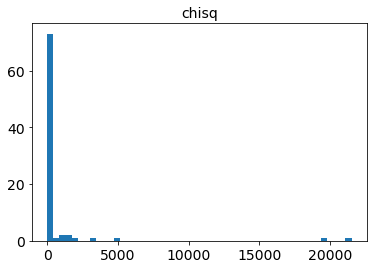

rango ndof : 3, 70
promedio ndof : 22.698795180722893
desviación estándar ndof : 14.984116039599051
mediana ndof : 17.0


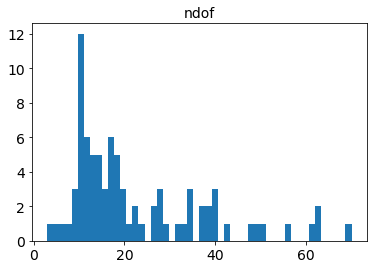

rango chisq/ndof : 0.4559628258204916, 313.4011114793887
promedio chisq/ndof : 15.183151086286548
desviación estándar chisq/ndof : 50.42450947488705
mediana chisq/ndof : 1.6516434723216722


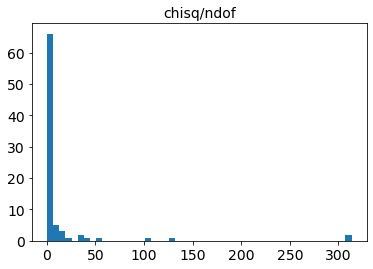

rango z : 5.340272746234831e-09, 0.19999999225625217
promedio z : 0.07472251562356827
desviación estándar z : 0.048426924745739626
mediana z : 0.06922584156413392


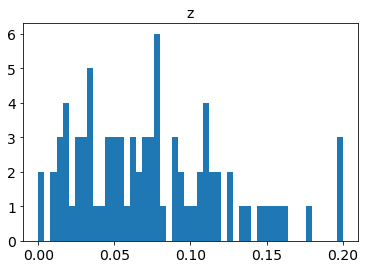

rango z_err : 1.1570257890669566e-08, 0.1708037720503088
promedio z_err : 0.02340903850461938
desviación estándar z_err : 0.0317510273303074
mediana z_err : 0.014871935808906502


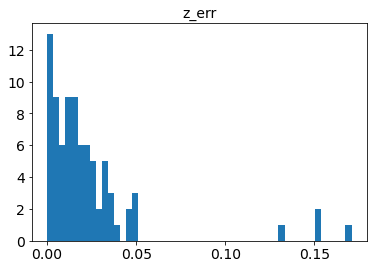

rango t0 : 58254.63512320608, 58395.08397202128
promedio t0 : 58320.31359970872
desviación estándar t0 : 38.706988275134336
mediana t0 : 58313.784808649274


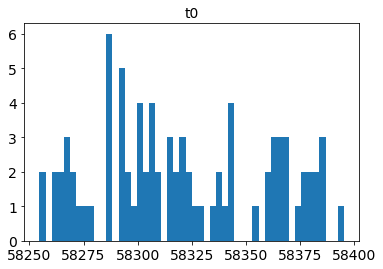

rango t0_err : 2.587512426543981e-07, 1.2954760865250137
promedio t0_err : 0.23907165761819812
desviación estándar t0_err : 0.22996426532571065
mediana t0_err : 0.18167788109713


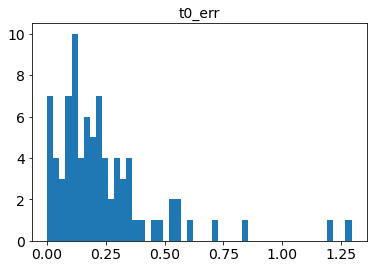

rango x0 : 0.0002311547337047612, 0.011421758159275193
promedio x0 : 0.0013442938778718458
desviación estándar x0 : 0.0017918552763561719
mediana x0 : 0.0007128070288991813


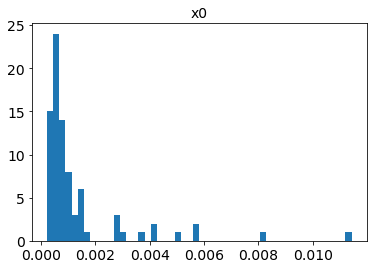

rango x0_err : 4.481379839874968e-06, 7.732491119479496e-05
promedio x0_err : 1.959751866534147e-05
desviación estándar x0_err : 1.2911651078154064e-05
mediana x0_err : 1.5755585448791694e-05


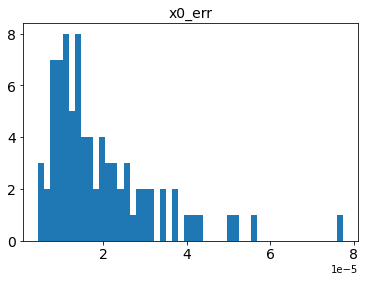

rango x1 : -2.441262495814739, 2.7058195692010614
promedio x1 : 0.04344455803357176
desviación estándar x1 : 1.116227024186965
mediana x1 : 0.24420528010282982


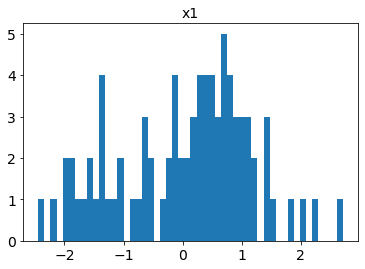

rango x1_err : 0.012669393350498659, 2.1418138437304246
promedio x1_err : 0.26267255395865957
desviación estándar x1_err : 0.2943790363820371
mediana x1_err : 0.19676665940697058


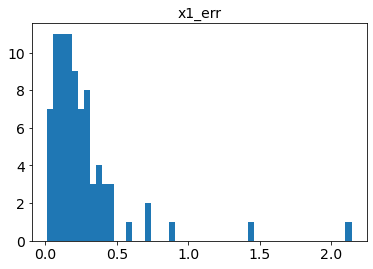

rango c : -0.2336414399383486, 0.39999999999997804
promedio c : 0.01731357690944436
desviación estándar c : 0.12007841752023056
mediana c : -0.005867563743046367


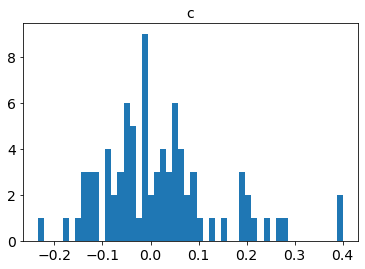

rango c_err : 0.0006582896655202286, 0.6833865397438257
promedio c_err : 0.040468329288246334
desviación estándar c_err : 0.07491681330233758
mediana c_err : 0.027919316794307897


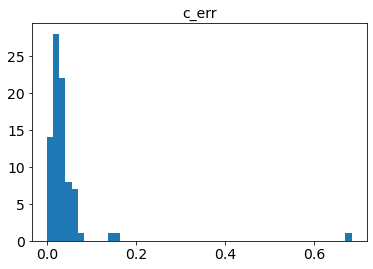

rango mwebv : 0.006204556550167132, 0.1144183424611353
promedio mwebv : 0.030919675672372172
desviación estándar mwebv : 0.02141134413521493
mediana mwebv : 0.025622750919880123


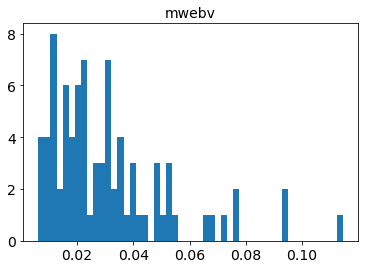

In [323]:
histogramas_estadisticas_resultados(ajustes_SALT3_early_SNIa_z_bounded)

Estadísticas de los ajustes, ordenados por valor de chisq/ndof

In [324]:
estadisticas_SALT3_z_bounded = estadisticas_resultados(ajustes_SALT3_early_SNIa_z_bounded).sort_values(by=['chisq/ndof'])

Listas de los oid y de los valores de chisq/ndof del ajuste con con el modelo SALT3 y redshift variable, utilizando los puntos que pertenecen al rango de tiempo del modelo (determinado con los valores de $t_0$ del primer ajuste y $z=0$), ordenados según el valor de chisq/ndof

In [325]:
lista_oid_SALT3_z_bounded = list(estadisticas_SALT3_z_bounded['oid'])
lista_chisq_vs_ndof_SALT3_z_bounded = list(estadisticas_SALT3_z_bounded['chisq/ndof'])

Filas de los resultados del ajuste con chisq/ndof sobre la 
mediana

In [326]:
median_chisq_vs_ndof_SALT3_z_bounded = np.median(np.array(estadisticas_SALT3_z_bounded['chisq/ndof']))
df_chisq_vs_ndof_SALT3_z_bounded_sobre_mediana = estadisticas_SALT3_z_bounded[estadisticas_SALT3_z_bounded['chisq/ndof'] > median_chisq_vs_ndof_SALT3_z_bounded]
lista_oid_SALT3_z_bounded_sobre_mediana = list(df_chisq_vs_ndof_SALT3_z_bounded_sobre_mediana['oid'])

Mostrar algunas columnas de los resultados del ajuste, con valores de chisq/ndof sobre la mediana

In [327]:
display(df_chisq_vs_ndof_SALT3_z_bounded_sobre_mediana[['oid', 
                                                        'chisq/ndof', 
                                                        'z', 
                                                        'z_err', 
                                                        't0', 
                                                        't0_err']])

oid  chisq/ndof             z         z_err            t0  \
38  ZTF18abdbuty    1.676841  1.175183e-01  1.668655e-02  58308.273651   
17  ZTF18aaxrvzj    1.679437  1.257937e-01  3.242199e-02  58286.108908   
24  ZTF18aazblzy    1.696134  1.883670e-02  5.802215e-03  58291.200089   
58  ZTF18abkifng    1.750535  1.323600e-01  4.931771e-02  58343.920679   
28  ZTF18aazsabq    1.852065  3.458562e-02  6.526298e-03  58293.761876   
43  ZTF18abealop    1.861342  2.620719e-02  1.727052e-02  58315.752003   
34  ZTF18abckujg    1.878410  2.880497e-02  9.272853e-03  58302.911566   
35  ZTF18abclalx    1.897549  1.144366e-02  3.498806e-02  58300.262090   
76  ZTF18abtnlik    1.925403  9.227441e-02  2.907010e-02  58379.091282   
66  ZTF18abpaywm    1.940003  6.196593e-02  7.900543e-03  58368.045699   
16  ZTF18aaxqyki    2.195689  1.059365e-01  1.738662e-02  58286.469027   
46  ZTF18abetewu    2.304182  6.922584e-02  2.107502e-02  58318.796490   
39  ZTF18abdefet    2.333101  4.961970e-02  2.395007e-02  58307.389057   
30  ZTF18abbpeqo    2.457552  5.057225e-02  1.397181e-02  58300.468132   
31  ZTF18abbvsiv    2.705694  1.047912e-01  6.655596e-06  58297.027854   
25  ZTF18aazcoob    2.760022  2.000000e-01  2.285256e-02  58295.801049   
10  ZTF18aaunfqq    2.875515  1.611028e-02  7.974834e-03  58267.949601   
45  ZTF18abetehf    4.275912  1.107600e-01  1.410209e-02  58318.782199   
13  ZTF18aavrzxp    4.500336  4.052134e-02  1.730054e-02  58270.271018   
12  ZTF18aavrwhu    5.275645  5.211909e-02  8.164093e-03  58275.751590   
22  ZTF18aayjvve    5.779714  7.667323e-02  6.759148e-07  58292.339359   
4   ZTF18aaqqoqs    5.896804  6.731050e-02  1.071298e-02  58262.524648   
3   ZTF18aaqffyp    6.026094  6.745897e-02  6.192555e-03  58254.635123   
23  ZTF18aaytovs    6.105148  7.744055e-02  1.389923e-02  58294.387578   
11  ZTF18aauocnw    7.913317  1.082529e-01  2.109207e-02  58269.125897   
15  ZTF18aaxdrjn    7.917315  3.449031e-02  3.429482e-03  58279.031570   
14  ZTF18aawjywv    9.806930  4.725878e-02  5.497578e-03  58271.619357   
7   ZTF18aatzygk   10.020937  9.213502e-02  8.968522e-03  58262.248338   
9   ZTF18aaumlfl   10.221759  1.167574e-03  2.414859e-02  58264.735983   
44  ZTF18abeecwe   16.536051  2.633122e-02  5.028125e-03  58319.467981   
6   ZTF18aaslhxt   16.973582  7.284875e-02  2.291337e-06  58263.767445   
2   ZTF18aaqcqvr   19.001598  4.541314e-02  5.788377e-03  58256.338781   
49  ZTF18abfhryc   19.446992  7.790022e-02  1.157026e-08  58324.343594   
51  ZTF18abgmcmv   34.010497  8.831531e-02  2.546161e-03  58329.764252   
36  ZTF18abcrxoj   37.606977  5.231488e-02  6.422024e-06  58306.624870   
8   ZTF18aaumeys   42.665691  2.972959e-02  2.695624e-03  58267.136498   
18  ZTF18aaxsioa   54.281726  3.226913e-02  2.859294e-03  58286.141389   
33  ZTF18abcflnz  105.254969  1.570354e-01  4.565258e-06  58307.492436   
80  ZTF18abuqugw  130.299396  5.340273e-09  1.815395e-03  58383.863344   
5   ZTF18aasdted  307.396467  6.978914e-02  6.369485e-08  58265.875107   
29  ZTF18abauprj  313.401111  1.325833e-02  1.649912e-03  58301.957081   

          t0_err  
38  1.576068e-01  
17  1.649772e-01  
24  1.098710e-01  
58  2.070761e-01  
28  1.340640e-01  
43  3.238317e-01  
34  2.325086e-01  
35  8.544299e-01  
76  1.876913e-01  
66  8.792701e-02  
16  2.341395e-01  
46  1.983404e-01  
39  3.376918e-01  
30  1.621834e-01  
31  2.587512e-07  
25  1.541346e-01  
10  1.816779e-01  
45  1.378465e-01  
13  3.060990e-01  
12  1.061429e-01  
22  7.696628e-05  
4   8.123246e-02  
3   6.591395e-02  
23  1.186786e-01  
11  1.799947e-01  
15  5.184009e-02  
14  9.652899e-02  
7   1.253922e-01  
9   2.896462e-01  
44  1.120158e-01  
6   2.327502e-02  
2   9.858032e-02  
49  5.269190e-06  
51  5.623405e-02  
36  1.383314e-04  
8   4.538515e-02  
18  5.066954e-02  
33  4.644900e-02  
80  8.516336e-02  
5   1.181864e-05  
29  5.147606e-02

Se observa que los valores de $\frac{\chi^{2}}{ndof}$ son muy altos, y que estos tenían que ver principalmente con hay observaciones que están fuera del rango de tiempo del modelo

### Ajuste con observaciones en el rango de tiempo del modelo (determinado con $t_0$ y $z$ del primer ajuste)

Seleccionar las detecciones de las SN que están dentro del rango de tiempo del modelo según el primer ajuste con el modelo SALT3 y límites para $z$

In [328]:
detect_early_SNIa_SALT3_z_bounded_cortes_t = cortes_t_modelo(trest_min_modelo, 
                                                             trest_max_modelo, 
                                                             detect_early_SNIa_sin_SN15,
                                                             estadisticas_SALT3_z_bounded)

Ajustes con las detecciones de las SN que están dentro del rango de tiempo del modelo

In [329]:
ajustes_SALT3_early_SNIa_z_bounded_cortes_t = modelo_ajustado_y_resultados('salt3', 
                                                                           df_meta_early_SNIa_sin_SN15, 
                                                                           detect_early_SNIa_SALT3_z_bounded_cortes_t,
                                                                           z_bounds=z_bounds,
                                                                           print_ind_and_oid=False)

rango ncall : 123, 742
promedio ncall : 244.289156626506
desviación estándar ncall : 105.31679463323427
mediana ncall : 208.0


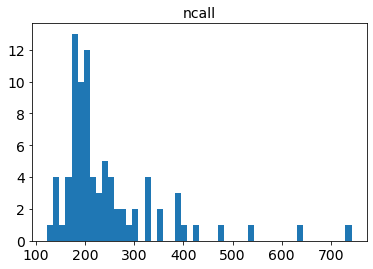

rango chisq : 1.3678884774614748, 1826.7082767348966
promedio chisq : 93.43203237290443
desviación estándar chisq : 234.3279336991033
mediana chisq : 29.84399531343533


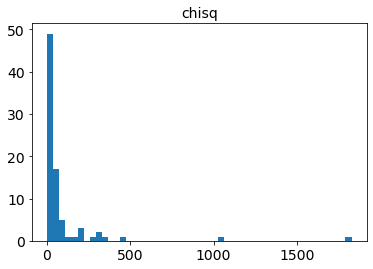

rango ndof : 3, 61
promedio ndof : 20.746987951807228
desviación estándar ndof : 12.105802027738376
mediana ndof : 17.0


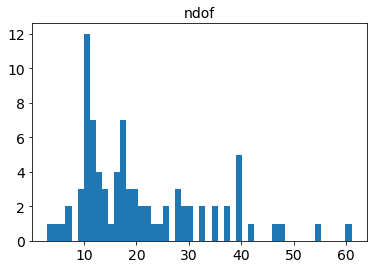

rango chisq/ndof : 0.4559628258204916, 62.9899405770654
promedio chisq/ndof : 3.8309391191048503
desviación estándar chisq/ndof : 7.841025310005324
mediana chisq/ndof : 1.6147470351516384


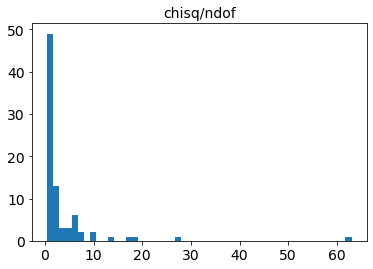

rango z : 2.1616759804388154e-08, 0.19999999225625217
promedio z : 0.0740398286916137
desviación estándar z : 0.04812746697077103
mediana z : 0.06882429835870481


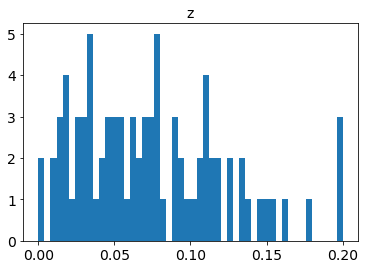

rango z_err : 2.089460847398694e-09, 0.1708037720503088
promedio z_err : 0.023433125809371135
desviación estándar z_err : 0.03170713095342922
mediana z_err : 0.014871935808906502


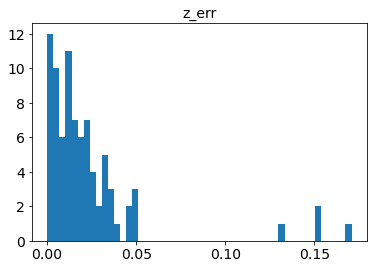

rango t0 : 58254.63512320608, 58395.08397202128
promedio t0 : 58320.30988770792
desviación estándar t0 : 38.709907932983654
mediana t0 : 58313.784808649274


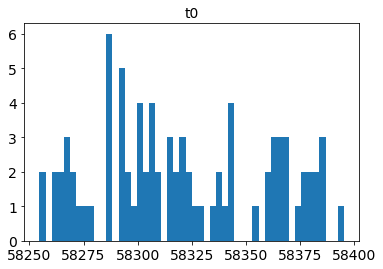

rango t0_err : 2.503038558643311e-07, 1.2954760865250137
promedio t0_err : 0.24004135811242944
desviación estándar t0_err : 0.2290286335542724
mediana t0_err : 0.18167788109713


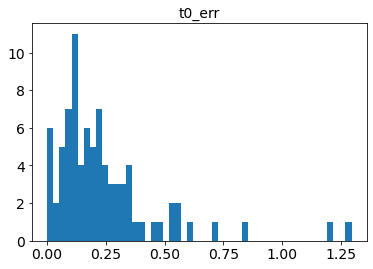

rango x0 : 0.0002311547337047612, 0.011421531312458922
promedio x0 : 0.0013457680845212
desviación estándar x0 : 0.001794418372534633
mediana x0 : 0.0007128070288991813


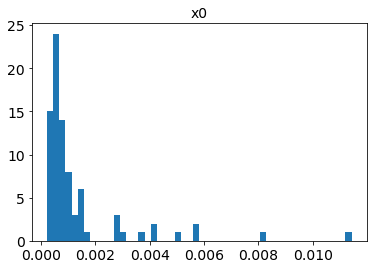

rango x0_err : 4.481226410390044e-06, 8.224107669102113e-05
promedio x0_err : 1.9679802319229204e-05
desviación estándar x0_err : 1.3144024666280676e-05
mediana x0_err : 1.5755585448791694e-05


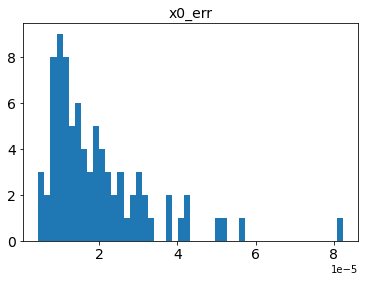

rango x1 : -2.441233773750012, 2.7058195692010614
promedio x1 : 0.047080161273527786
desviación estándar x1 : 1.1157904187368346
mediana x1 : 0.24435796585568337


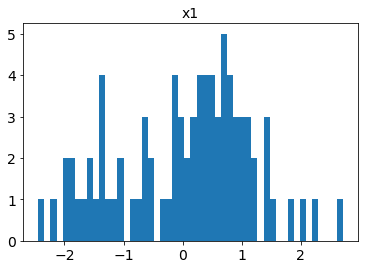

rango x1_err : 0.013154318493741268, 2.1418138437304246
promedio x1_err : 0.26268236728757827
desviación estándar x1_err : 0.29424593234519475
mediana x1_err : 0.19676665940697058


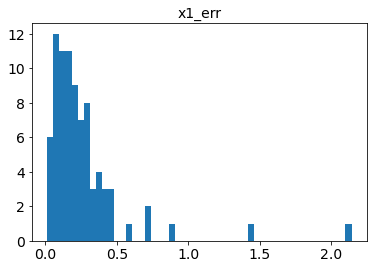

rango c : -0.2336414399383486, 0.39999999994854385
promedio c : 0.017668853419905678
desviación estándar c : 0.1201318413528394
mediana c : -0.006022675792955512


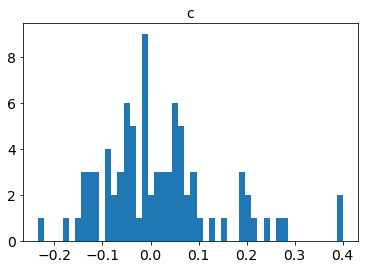

rango c_err : 0.0006584477220070717, 0.6833865397438257
promedio c_err : 0.04048231042546236
desviación estándar c_err : 0.07490873573811861
mediana c_err : 0.02761817447785278


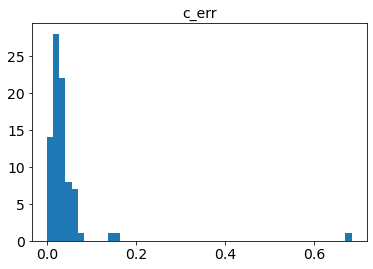

rango mwebv : 0.006204556550167132, 0.1144183424611353
promedio mwebv : 0.030919675672372172
desviación estándar mwebv : 0.02141134413521493
mediana mwebv : 0.025622750919880123


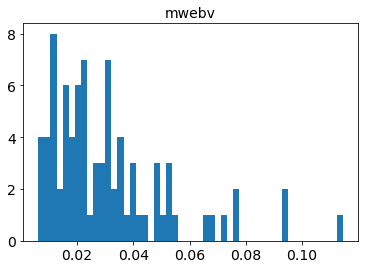

In [330]:
histogramas_estadisticas_resultados(ajustes_SALT3_early_SNIa_z_bounded_cortes_t)

Estadísticas de los ajustes, ordenados por valor de chisq/ndof

In [331]:
estadisticas_SALT3_z_bounded_cortes_t = estadisticas_resultados(ajustes_SALT3_early_SNIa_z_bounded_cortes_t).sort_values(by=['chisq/ndof'])

Listas de los oid y de los valores de chisq/ndof del ajuste con con el modelo SALT3 y redshift variable, utilizando los puntos que pertenecen al rango de tiempo del modelo (determinado con los valores de $t_0$ del primer ajuste y $z=0$), ordenados según el valor de chisq/ndof

In [332]:
lista_oid_SALT3_z_bounded_cortes_t = list(estadisticas_SALT3_z_bounded_cortes_t['oid'])
lista_chisq_vs_ndof_SALT3_z_bounded_cortes_t = list(estadisticas_SALT3_z_bounded_cortes_t['chisq/ndof'])

Filas de los resultados del ajuste con chisq/ndof sobre la 
mediana 

In [333]:
median_chisq_vs_ndof_SALT3_z_bounded_cortes_t = np.median(np.array(estadisticas_SALT3_z_bounded_cortes_t['chisq/ndof']))
df_chisq_vs_ndof_SALT3_z_bounded_sobre_mediana_cortes_t = estadisticas_SALT3_z_bounded_cortes_t[estadisticas_SALT3_z_bounded_cortes_t['chisq/ndof'] > median_chisq_vs_ndof_SALT3_z_bounded_cortes_t]
lista_oid_SALT3_z_bounded_sobre_mediana_cortes_t = list(df_chisq_vs_ndof_SALT3_z_bounded_sobre_mediana_cortes_t['oid'])
lista_chisq_vs_ndof_SALT3_z_bounded_sobre_mediana_cortes_t = list(df_chisq_vs_ndof_SALT3_z_bounded_sobre_mediana_cortes_t['chisq/ndof'])

Mostrar algunas columnas de los resultados del ajuste, con valores de chisq/ndof sobre la mediana

In [334]:
display(df_chisq_vs_ndof_SALT3_z_bounded_sobre_mediana_cortes_t[['oid', 
                                                                 'chisq/ndof', 
                                                                 'z', 
                                                                 'z_err', 
                                                                 't0', 
                                                                 't0_err']])

oid  chisq/ndof             z         z_err            t0  \
55  ZTF18abjvhec    1.629772  1.501476e-01  1.241429e-02  58340.893166   
65  ZTF18abpamut    1.635688  1.109075e-01  4.760861e-02  58367.845649   
77  ZTF18abtogdl    1.641625  4.873072e-02  3.307702e-02  58381.284959   
73  ZTF18absdgon    1.651643  2.431725e-02  1.487194e-02  58375.450930   
38  ZTF18abdbuty    1.676841  1.175183e-01  1.668655e-02  58308.273651   
17  ZTF18aaxrvzj    1.679437  1.257937e-01  3.242199e-02  58286.108908   
24  ZTF18aazblzy    1.696134  1.883670e-02  5.802215e-03  58291.200089   
58  ZTF18abkifng    1.750535  1.323600e-01  4.931771e-02  58343.920679   
28  ZTF18aazsabq    1.852065  3.458562e-02  6.526298e-03  58293.761876   
43  ZTF18abealop    1.861342  2.620719e-02  1.727052e-02  58315.752003   
34  ZTF18abckujg    1.878410  2.880497e-02  9.272853e-03  58302.911566   
35  ZTF18abclalx    1.897549  1.144366e-02  3.498806e-02  58300.262090   
76  ZTF18abtnlik    1.925403  9.227441e-02  2.907010e-02  58379.091282   
16  ZTF18aaxqyki    2.195689  1.059365e-01  1.738662e-02  58286.469027   
46  ZTF18abetewu    2.304182  6.922584e-02  2.107502e-02  58318.796490   
18  ZTF18aaxsioa    2.332522  3.229391e-02  2.844331e-03  58286.141724   
39  ZTF18abdefet    2.333101  4.961970e-02  2.395007e-02  58307.389057   
31  ZTF18abbvsiv    2.705694  1.047912e-01  6.655596e-06  58297.027854   
25  ZTF18aazcoob    2.760022  2.000000e-01  2.285256e-02  58295.801049   
10  ZTF18aaunfqq    2.875515  1.611028e-02  7.974834e-03  58267.949601   
23  ZTF18aaytovs    3.246821  7.745311e-02  1.333476e-02  58294.387683   
36  ZTF18abcrxoj    3.835820  5.273460e-02  2.199195e-07  58306.605019   
11  ZTF18aauocnw    4.082835  1.082615e-01  2.101773e-02  58269.125885   
45  ZTF18abetehf    4.275912  1.107600e-01  1.410209e-02  58318.782199   
13  ZTF18aavrzxp    4.500336  4.052134e-02  1.730054e-02  58270.271018   
12  ZTF18aavrwhu    5.275645  5.211909e-02  8.164093e-03  58275.751590   
8   ZTF18aaumeys    5.662789  2.974312e-02  2.767367e-03  58267.136653   
7   ZTF18aatzygk    5.759042  9.213484e-02  9.009672e-03  58262.248335   
4   ZTF18aaqqoqs    5.896804  6.731050e-02  1.071298e-02  58262.524648   
3   ZTF18aaqffyp    6.026094  6.745897e-02  6.192555e-03  58254.635123   
51  ZTF18abgmcmv    6.152383  8.831874e-02  2.528499e-03  58329.764312   
49  ZTF18abfhryc    6.163118  7.792079e-02  1.430513e-06  58324.342819   
22  ZTF18aayjvve    7.265247  4.307966e-02  5.718910e-03  58291.984387   
15  ZTF18aaxdrjn    7.917315  3.449031e-02  3.429482e-03  58279.031570   
14  ZTF18aawjywv    9.806930  4.725878e-02  5.497578e-03  58271.619357   
29  ZTF18abauprj    9.936158  1.325163e-02  2.139469e-03  58301.956929   
33  ZTF18abcflnz   13.378145  1.334055e-01  2.026047e-08  58307.557745   
6   ZTF18aaslhxt   16.790003  7.282895e-02  2.834583e-06  58263.766959   
2   ZTF18aaqcqvr   19.001598  4.541314e-02  5.788377e-03  58256.338781   
80  ZTF18abuqugw   27.740525  2.161676e-08  1.811121e-03  58383.863379   
5   ZTF18aasdted   62.989941  6.977465e-02  2.089461e-09  58265.875809   

          t0_err  
55  1.127944e-01  
65  3.269917e-01  
77  5.513288e-01  
73  2.672547e-01  
38  1.576068e-01  
17  1.649772e-01  
24  1.098710e-01  
58  2.070761e-01  
28  1.340640e-01  
43  3.238317e-01  
34  2.325086e-01  
35  8.544299e-01  
76  1.876913e-01  
16  2.341395e-01  
46  1.983404e-01  
18  5.046918e-02  
39  3.376918e-01  
31  2.587512e-07  
25  1.541346e-01  
10  1.816779e-01  
23  1.167292e-01  
36  5.248778e-02  
11  1.795202e-01  
45  1.378465e-01  
13  3.060990e-01  
12  1.061429e-01  
8   4.614160e-02  
7   1.254689e-01  
4   8.123246e-02  
3   6.591395e-02  
51  5.617703e-02  
49  3.428509e-05  
22  1.056192e-01  
15  5.184009e-02  
14  9.652899e-02  
29  6.325310e-02  
33  3.604587e-05  
6   6.972335e-05  
2   9.858032e-02  
80  8.516306e-02  
5   2.503039e-07

Intersección de los oid de las SN con valores de chisq/ndof mayores a la mediana de los ajustes con SALT3 y $z$ variable antes y después de eliminar los puntos fuera del rango de tiempo del modelo

In [335]:
inter_oid_SALT3_z_bounded_sobre_mediana_cortes_t = np.intersect1d(np.array(lista_oid_SALT3_z_var_sobre_mediana),
                                                                  np.array(lista_oid_SALT3_z_bounded_sobre_mediana_cortes_t))
print('Elementos comunes sobre la mediana de chisq/ndof : ',
      len(inter_oid_SALT3_z_bounded_sobre_mediana_cortes_t))

Elementos comunes sobre la mediana de chisq/ndof :  31


Tabla de astropy con las detecciones que están en el rango de tiempo del modelo, en el formato que requiere sncosmo para hacer los ajustes 

In [336]:
table_early_SNIa_SALT3_z_bounded_cortes_t = astropy_table_detections(df_meta_early_SNIa_sin_SN15,
                                                                     detect_early_SNIa_SALT3_z_bounded_cortes_t)

Algunos gráficos interesantes de ajustes con $\frac{\chi^2}{ndof}$ mayor a la mediana

 ==== Con ajuste del redshift ====
chisq/ndof :  1.67684138492349


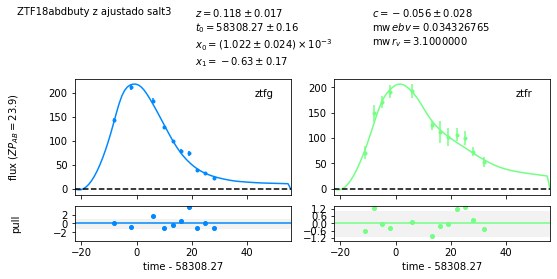

In [337]:
ajuste(lista_oid_SALT3_z_bounded_sobre_mediana_cortes_t[4], 'salt3', df_meta_early_SNIa_sin_SN15, 
       table_early_SNIa_SALT3_z_bounded_cortes_t, z_bounds=z_bounds)[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT3_z_bounded_sobre_mediana_cortes_t[4])

 ==== Con ajuste del redshift ====
chisq/ndof :  2.705694384810282


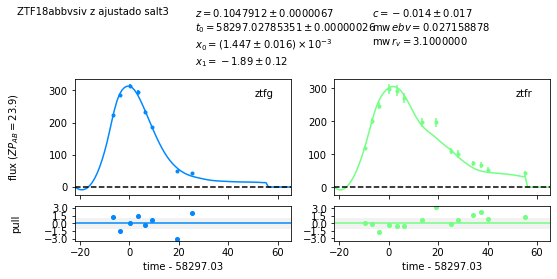

In [338]:
ajuste(lista_oid_SALT3_z_bounded_sobre_mediana_cortes_t[17], 'salt3', df_meta_early_SNIa_sin_SN15, 
       table_early_SNIa_SALT3_z_bounded_cortes_t, z_bounds=z_bounds)[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT3_z_bounded_sobre_mediana_cortes_t[17])

 ==== Con ajuste del redshift ====
chisq/ndof :  3.2468208331415647


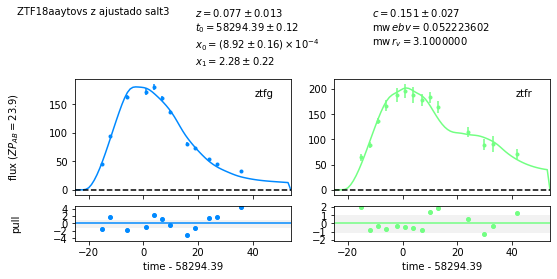

In [339]:
ajuste(lista_oid_SALT3_z_bounded_sobre_mediana_cortes_t[20], 'salt3', df_meta_early_SNIa_sin_SN15, 
       table_early_SNIa_SALT3_z_bounded_cortes_t, z_bounds=z_bounds)[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT3_z_bounded_sobre_mediana_cortes_t[20])

 ==== Con ajuste del redshift ====
chisq/ndof :  4.275911905240923


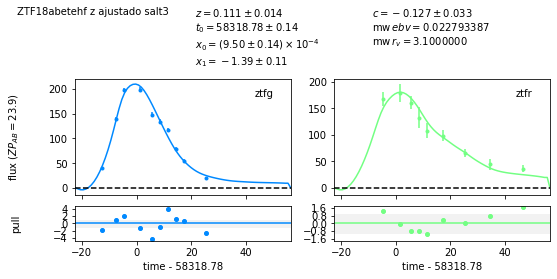

In [340]:
ajuste(lista_oid_SALT3_z_bounded_sobre_mediana_cortes_t[23], 'salt3', df_meta_early_SNIa_sin_SN15, 
       table_early_SNIa_SALT3_z_bounded_cortes_t, z_bounds=z_bounds)[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT3_z_bounded_sobre_mediana_cortes_t[23])

 ==== Con ajuste del redshift ====
chisq/ndof :  5.759041746411583


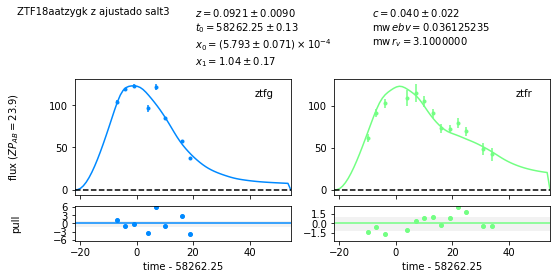

In [341]:
ajuste(lista_oid_SALT3_z_bounded_sobre_mediana_cortes_t[27], 'salt3', df_meta_early_SNIa_sin_SN15, 
       table_early_SNIa_SALT3_z_bounded_cortes_t, z_bounds=z_bounds)[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT3_z_bounded_sobre_mediana_cortes_t[27])

 ==== Con ajuste del redshift ====
chisq/ndof :  6.152382522334138


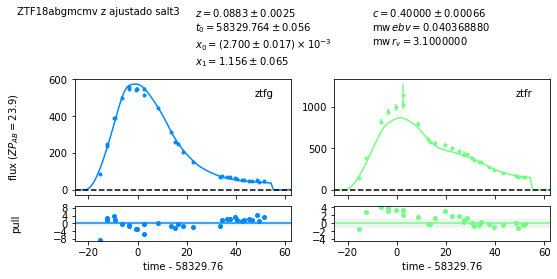

In [342]:
ajuste(lista_oid_SALT3_z_bounded_sobre_mediana_cortes_t[30], 'salt3', df_meta_early_SNIa_sin_SN15, 
       table_early_SNIa_SALT3_z_bounded_cortes_t, z_bounds=z_bounds)[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT3_z_bounded_sobre_mediana_cortes_t[30])

 ==== Con ajuste del redshift ====
chisq/ndof :  7.265246901923752


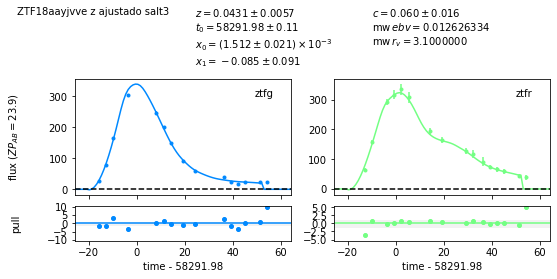

In [343]:
ajuste(lista_oid_SALT3_z_bounded_sobre_mediana_cortes_t[32], 'salt3', df_meta_early_SNIa_sin_SN15, 
       table_early_SNIa_SALT3_z_bounded_cortes_t, z_bounds=z_bounds)[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT3_z_bounded_sobre_mediana_cortes_t[32])

 ==== Con ajuste del redshift ====
chisq/ndof :  13.378144574062608


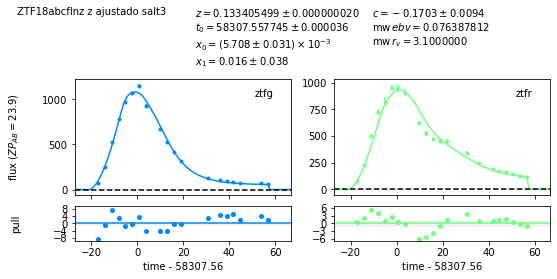

In [344]:
ajuste(lista_oid_SALT3_z_bounded_sobre_mediana_cortes_t[36], 'salt3', df_meta_early_SNIa_sin_SN15, 
       table_early_SNIa_SALT3_z_bounded_cortes_t, z_bounds=z_bounds)[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT3_z_bounded_sobre_mediana_cortes_t[36])

 ==== Con ajuste del redshift ====
chisq/ndof :  27.740524745654053


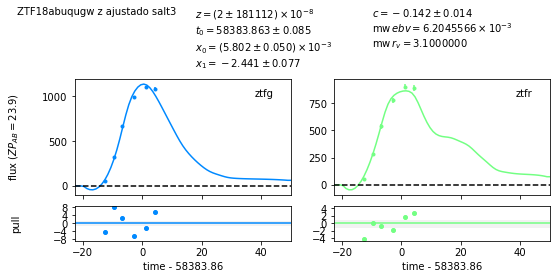

In [345]:
ajuste(lista_oid_SALT3_z_bounded_sobre_mediana_cortes_t[39], 'salt3', df_meta_early_SNIa_sin_SN15, 
       table_early_SNIa_SALT3_z_bounded_cortes_t, z_bounds=z_bounds)[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT3_z_bounded_sobre_mediana_cortes_t[39])

En general los ajustes se ven bien y se parecen al caso en que se utiliza el redshift real de las SN.

Se ve que hay puntos que quedaron fuera del rango de tiempo del modelo, lo que aumenta el valor de $\frac{\chi^2}{ndof}$.

### Ajuste con observaciones en el rango de tiempo del modelo como si estuviese en el sistema de referencia en reposo (determinado con $t_0$ del primer ajuste)

Seleccionar las detecciones de las SN que están dentro del rango de tiempo del modelo asumiendo que está en el sistema de referencia en reposo $z=0$, con el valor de $t_0$ del primer ajuste con el modelo SALT3 y límites para $z$

In [346]:
detect_early_SNIa_SALT3_z_bounded_cortes_trest = cortes_trest_modelo(trest_min_modelo, 
                                                                     trest_max_modelo, 
                                                                     detect_early_SNIa_sin_SN15,
                                                                     estadisticas_SALT3_z_bounded)

Ajustes con las detecciones de las SN que están dentro del rango de tiempo del modelo

In [347]:
ajustes_SALT3_early_SNIa_z_bounded_cortes_trest = modelo_ajustado_y_resultados('salt3', 
                                                                               df_meta_early_SNIa_sin_SN15, 
                                                                               detect_early_SNIa_SALT3_z_bounded_cortes_trest, 
                                                                               z_bounds=z_bounds,
                                                                               print_ind_and_oid=False)

rango ncall : 123, 425
promedio ncall : 222.33734939759037
desviación estándar ncall : 61.55539714984797
mediana ncall : 202.0


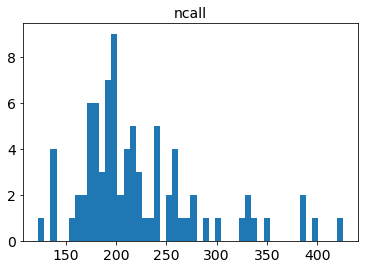

rango chisq : 1.3678884774614748, 961.9926075419348
promedio chisq : 72.62144139787668
desviación estándar chisq : 145.99201881605137
mediana chisq : 29.84399531343533


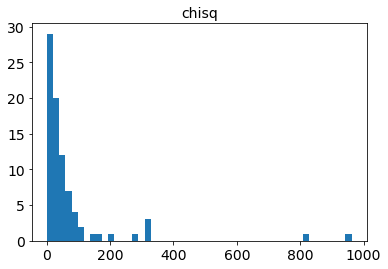

rango ndof : 3, 57
promedio ndof : 20.397590361445783
desviación estándar ndof : 11.664940529944248
mediana ndof : 17.0


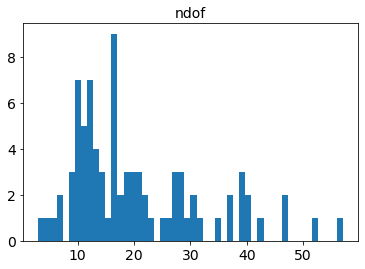

rango chisq/ndof : 0.4559628258204916, 30.327267713084012
promedio chisq/ndof : 3.220274543318476
desviación estándar chisq/ndof : 5.123846836089779
mediana chisq/ndof : 1.6147470351516384


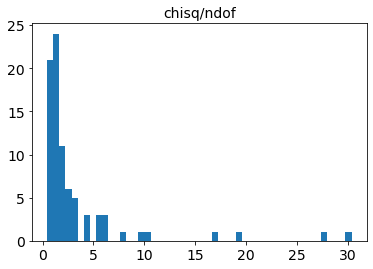

rango z : 2.1616759804388154e-08, 0.19999999225625217
promedio z : 0.0703524537907949
desviación estándar z : 0.048985486856076475
mediana z : 0.06201513729810579


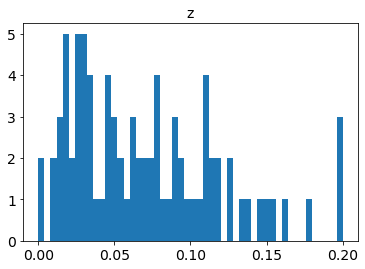

rango z_err : 0.0009228457109131949, 0.1708037720503088
promedio z_err : 0.023819297548193976
desviación estándar z_err : 0.03145707695758453
mediana z_err : 0.014871935808906502


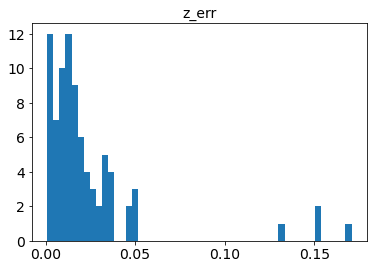

rango t0 : 58254.63512320608, 58395.08397202128
promedio t0 : 58320.2679753531
desviación estándar t0 : 38.73508418004518
mediana t0 : 58313.784808649274


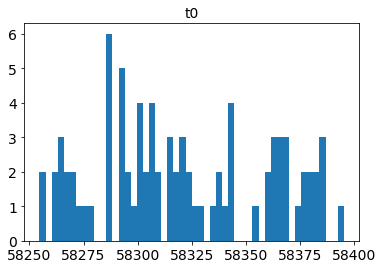

rango t0_err : 0.0191888554727484, 1.2954760865250137
promedio t0_err : 0.24652036259825522
desviación estándar t0_err : 0.22364630983130276
mediana t0_err : 0.18167788109713


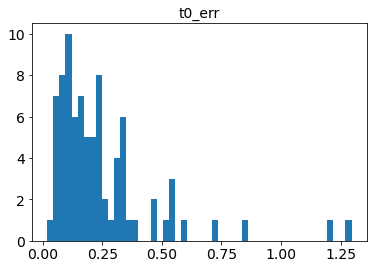

rango x0 : 0.0002311547337047612, 0.01144628406603895
promedio x0 : 0.0013645833042249345
desviación estándar x0 : 0.0018398404706973545
mediana x0 : 0.0007128070288991813


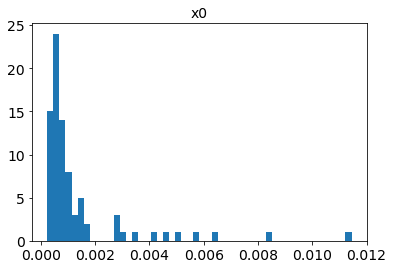

rango x0_err : 4.720434321243278e-06, 7.892914679162033e-05
promedio x0_err : 2.0400046308520564e-05
desviación estándar x0_err : 1.3546744441744113e-05
mediana x0_err : 1.6086651881140876e-05


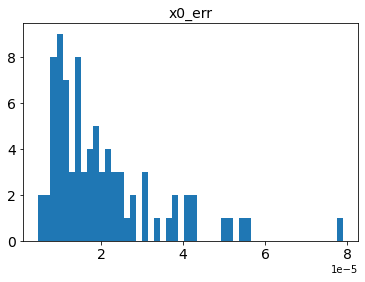

rango x1 : -2.441233773750012, 2.7058195692010614
promedio x1 : 0.044464329571973646
desviación estándar x1 : 1.1171363318805794
mediana x1 : 0.24435796585568337


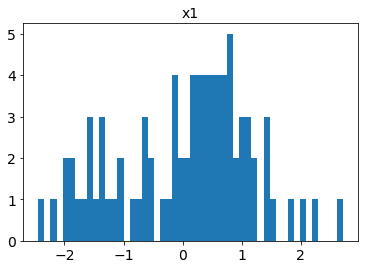

rango x1_err : 0.01832705302323223, 2.1418138437304246
promedio x1_err : 0.2637626558957722
desviación estándar x1_err : 0.2935294325491324
mediana x1_err : 0.19676665940697058


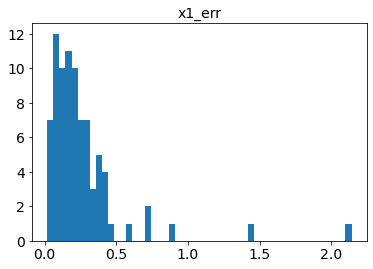

rango c : -0.2336414399383486, 0.39999999996807056
promedio c : 0.02290833765116645
desviación estándar c : 0.11757154408117165
mediana c : 0.00274018678033372


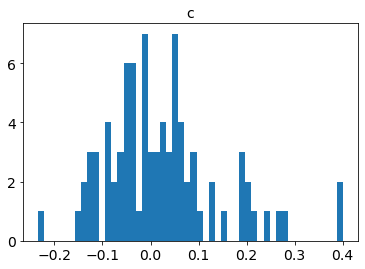

rango c_err : 0.0006479168385304934, 0.6833865397438257
promedio c_err : 0.04072513840899811
desviación estándar c_err : 0.07482482677362222
mediana c_err : 0.02761817447785278


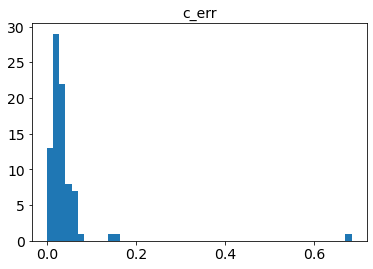

rango mwebv : 0.006204556550167132, 0.1144183424611353
promedio mwebv : 0.030919675672372172
desviación estándar mwebv : 0.02141134413521493
mediana mwebv : 0.025622750919880123


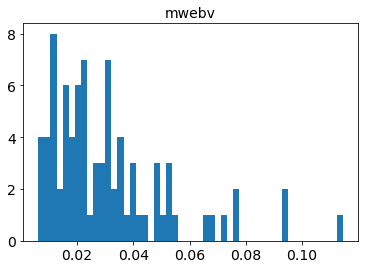

In [348]:
histogramas_estadisticas_resultados(ajustes_SALT3_early_SNIa_z_bounded_cortes_trest)

Estadísticas de los ajustes, ordenados por valor de chisq/ndof

In [349]:
estadisticas_SALT3_z_bounded_cortes_trest = estadisticas_resultados(ajustes_SALT3_early_SNIa_z_bounded_cortes_trest).sort_values(by=['chisq/ndof'])

Listas de los oid y de los valores de chisq/ndof del ajuste con con el modelo SALT3 y redshift variable, utilizando los puntos que pertenecen al rango de tiempo del modelo (determinado con los valores de $t_0$ del primer ajuste y $z=0$), ordenados según el valor de chisq/ndof

In [350]:
lista_oid_SALT3_z_bounded_cortes_trest = list(estadisticas_SALT3_z_bounded_cortes_trest['oid'])
lista_chisq_vs_ndof_SALT3_z_bounded_cortes_trest = list(estadisticas_SALT3_z_bounded_cortes_trest['chisq/ndof'])

Filas de los resultados del ajuste con chisq/ndof sobre la 
mediana 

In [351]:
median_chisq_vs_ndof_SALT3_z_bounded_cortes_trest = np.median(np.array(estadisticas_SALT3_z_bounded_cortes_trest['chisq/ndof']))
df_chisq_vs_ndof_SALT3_z_bounded_sobre_mediana_cortes_trest = estadisticas_SALT3_z_bounded_cortes_trest[estadisticas_SALT3_z_bounded_cortes_trest['chisq/ndof'] > median_chisq_vs_ndof_SALT3_z_bounded_cortes_trest]
lista_oid_SALT3_z_bounded_sobre_mediana_cortes_trest = list(df_chisq_vs_ndof_SALT3_z_bounded_sobre_mediana_cortes_trest['oid'])
lista_chisq_vs_ndof_SALT3_z_bounded_sobre_mediana_cortes_trest = list(df_chisq_vs_ndof_SALT3_z_bounded_sobre_mediana_cortes_trest['chisq/ndof'])

Mostrar algunas columnas de los resultados del ajuste, con valores de chisq/ndof sobre la mediana

In [352]:
display(df_chisq_vs_ndof_SALT3_z_bounded_sobre_mediana_cortes_trest[['oid', 
                                                                     'chisq/ndof', 
                                                                     'z', 
                                                                     'z_err', 
                                                                     't0', 
                                                                     't0_err']])

oid  chisq/ndof             z     z_err            t0    t0_err
55  ZTF18abjvhec    1.629772  1.501476e-01  0.012414  58340.893166  0.112794
65  ZTF18abpamut    1.635688  1.109075e-01  0.047609  58367.845649  0.326992
77  ZTF18abtogdl    1.641625  4.873072e-02  0.033077  58381.284959  0.551329
73  ZTF18absdgon    1.651643  2.431725e-02  0.014872  58375.450930  0.267255
38  ZTF18abdbuty    1.676841  1.175183e-01  0.016687  58308.273651  0.157607
17  ZTF18aaxrvzj    1.679437  1.257937e-01  0.032422  58286.108908  0.164977
24  ZTF18aazblzy    1.696134  1.883670e-02  0.005802  58291.200089  0.109871
58  ZTF18abkifng    1.750535  1.323600e-01  0.049318  58343.920679  0.207076
43  ZTF18abealop    1.861342  2.620719e-02  0.017271  58315.752003  0.323832
34  ZTF18abckujg    1.878410  2.880497e-02  0.009273  58302.911566  0.232509
35  ZTF18abclalx    1.897549  1.144366e-02  0.034988  58300.262090  0.854430
28  ZTF18aazsabq    1.919094  3.388292e-02  0.007902  58293.747292  0.153320
76  ZTF18abtnlik    1.925403  9.227441e-02  0.029070  58379.091282  0.187691
16  ZTF18aaxqyki    2.195689  1.059365e-01  0.017387  58286.469027  0.234140
46  ZTF18abetewu    2.304182  6.922584e-02  0.021075  58318.796490  0.198340
39  ZTF18abdefet    2.333101  4.961970e-02  0.023950  58307.389057  0.337692
18  ZTF18aaxsioa    2.498379  3.219825e-02  0.002832  58286.140555  0.049949
31  ZTF18abbvsiv    2.544217  8.655965e-02  0.008186  58296.934634  0.091379
49  ZTF18abfhryc    2.658374  1.611265e-02  0.003146  58323.708277  0.087096
25  ZTF18aazcoob    2.760022  2.000000e-01  0.022853  58295.801049  0.154135
10  ZTF18aaunfqq    2.875515  1.611028e-02  0.007975  58267.949601  0.181678
36  ZTF18abcrxoj    2.915098  2.670295e-02  0.003898  58306.249489  0.080932
22  ZTF18aayjvve    2.978996  4.558215e-02  0.007833  58292.020025  0.124489
33  ZTF18abcflnz    3.189608  2.203384e-02  0.003099  58306.257165  0.075049
23  ZTF18aaytovs    3.246821  7.745311e-02  0.013335  58294.387683  0.116729
11  ZTF18aauocnw    4.082835  1.082615e-01  0.021018  58269.125885  0.179520
45  ZTF18abetehf    4.275912  1.107600e-01  0.014102  58318.782199  0.137846
13  ZTF18aavrzxp    4.500336  4.052134e-02  0.017301  58270.271018  0.306099
12  ZTF18aavrwhu    5.275645  5.211909e-02  0.008164  58275.751590  0.106143
8   ZTF18aaumeys    5.662789  2.974312e-02  0.002767  58267.136653  0.046142
7   ZTF18aatzygk    5.759042  9.213484e-02  0.009010  58262.248335  0.125469
4   ZTF18aaqqoqs    5.896804  6.731050e-02  0.010713  58262.524648  0.081232
3   ZTF18aaqffyp    6.026094  6.745897e-02  0.006193  58254.635123  0.065914
51  ZTF18abgmcmv    6.286993  8.866200e-02  0.002555  58329.763641  0.056501
15  ZTF18aaxdrjn    7.917315  3.449031e-02  0.003429  58279.031570  0.051840
14  ZTF18aawjywv    9.806930  4.725878e-02  0.005498  58271.619357  0.096529
29  ZTF18abauprj   10.508305  1.253429e-02  0.001675  58301.936901  0.052351
6   ZTF18aaslhxt   16.877063  2.662793e-02  0.003084  58263.217266  0.065552
2   ZTF18aaqcqvr   19.001598  4.541314e-02  0.005788  58256.338781  0.098580
80  ZTF18abuqugw   27.740525  2.161676e-08  0.001811  58383.863379  0.085163
5   ZTF18aasdted   30.327268  2.826063e-02  0.000923  58265.366836  0.019189

Intersección de los oid de las SN con valores de chisq/ndof mayores a la mediana de los ajustes con SALT3 y $z$ variable antes y después de eliminar los puntos fuera del rango de tiempo del modelo como si en el primer ajuste estuviese en el sistema de referencia en reposo (cota inferior del rango de tiempo)

In [353]:
inter_oid_SALT3_z_bounded_sobre_mediana_cortes_trest = np.intersect1d(np.array(lista_oid_SALT3_z_var_sobre_mediana),
                                                                      np.array(lista_oid_SALT3_z_bounded_sobre_mediana_cortes_trest))
print('Elementos comunes sobre la mediana de chisq/ndof : ',
      len(inter_oid_SALT3_z_bounded_sobre_mediana_cortes_trest))

Elementos comunes sobre la mediana de chisq/ndof :  31


Tabla de astropy con las detecciones que están en el rango de tiempo del modelo, en el formato que requiere sncosmo para hacer los ajustes 

In [354]:
table_early_SNIa_SALT3_z_bounded_cortes_trest = astropy_table_detections(df_meta_early_SNIa_sin_SN15,
                                                                         detect_early_SNIa_SALT3_z_bounded_cortes_trest)

Algunos gráficos de ajustes con $\frac{\chi^2}{ndof}$ mayor a la mediana

Los ajustes se parecen al caso en que se usa el redshift real.

 ==== Con ajuste del redshift ====
chisq/ndof :  1.67684138492349


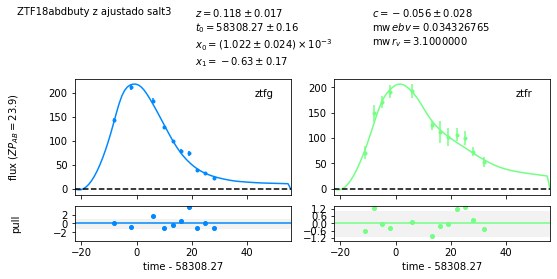

In [355]:
ajuste(lista_oid_SALT3_z_bounded_sobre_mediana_cortes_trest[4], 'salt3', df_meta_early_SNIa_sin_SN15, 
       table_early_SNIa_SALT3_z_bounded_cortes_trest, z_bounds=z_bounds)[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT3_z_bounded_sobre_mediana_cortes_trest[4])

 ==== Con ajuste del redshift ====
chisq/ndof :  1.8975488295471312


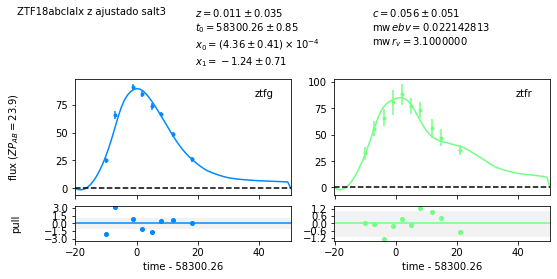

In [356]:
ajuste(lista_oid_SALT3_z_bounded_sobre_mediana_cortes_trest[10], 'salt3', df_meta_early_SNIa_sin_SN15, 
       table_early_SNIa_SALT3_z_bounded_cortes_trest, z_bounds=z_bounds)[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT3_z_bounded_sobre_mediana_cortes_trest[10])

 ==== Con ajuste del redshift ====
chisq/ndof :  2.5442169838400828


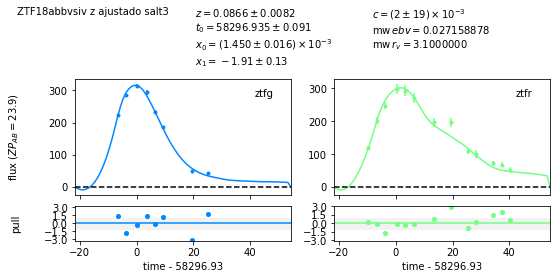

In [357]:
ajuste(lista_oid_SALT3_z_bounded_sobre_mediana_cortes_trest[17], 'salt3', df_meta_early_SNIa_sin_SN15, 
       table_early_SNIa_SALT3_z_bounded_cortes_trest, z_bounds=z_bounds)[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT3_z_bounded_sobre_mediana_cortes_trest[17])

 ==== Con ajuste del redshift ====
chisq/ndof :  2.760021578282748


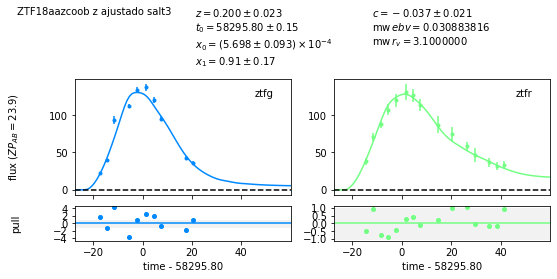

In [358]:
ajuste(lista_oid_SALT3_z_bounded_sobre_mediana_cortes_trest[19], 'salt3', df_meta_early_SNIa_sin_SN15, 
       table_early_SNIa_SALT3_z_bounded_cortes_trest, z_bounds=z_bounds)[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT3_z_bounded_sobre_mediana_cortes_trest[19])

 ==== Con ajuste del redshift ====
chisq/ndof :  3.1896082846271554


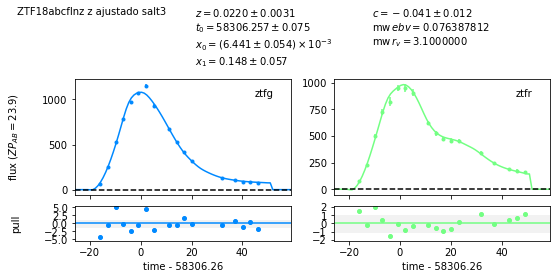

In [359]:
ajuste(lista_oid_SALT3_z_bounded_sobre_mediana_cortes_trest[23], 'salt3', df_meta_early_SNIa_sin_SN15, 
       table_early_SNIa_SALT3_z_bounded_cortes_trest, z_bounds=z_bounds)[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT3_z_bounded_sobre_mediana_cortes_trest[23])

 ==== Con ajuste del redshift ====
chisq/ndof :  3.2468208331415647


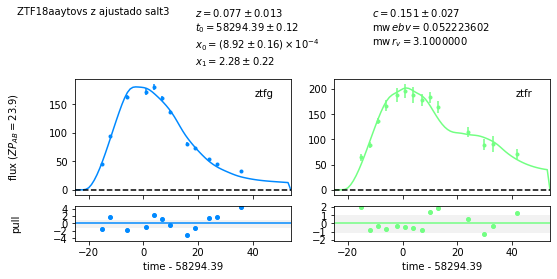

In [360]:
ajuste(lista_oid_SALT3_z_bounded_sobre_mediana_cortes_trest[24], 'salt3', df_meta_early_SNIa_sin_SN15, 
       table_early_SNIa_SALT3_z_bounded_cortes_trest, z_bounds=z_bounds)[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT3_z_bounded_sobre_mediana_cortes_trest[24])

 ==== Con ajuste del redshift ====
chisq/ndof :  5.759041746411583


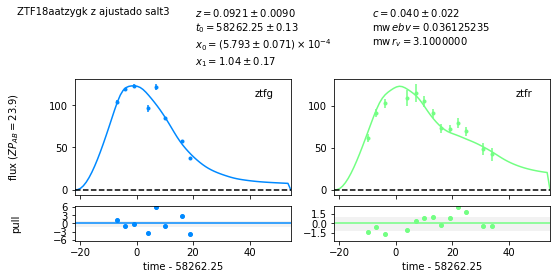

In [361]:
ajuste(lista_oid_SALT3_z_bounded_sobre_mediana_cortes_trest[30], 'salt3', df_meta_early_SNIa_sin_SN15, 
       table_early_SNIa_SALT3_z_bounded_cortes_trest, z_bounds=z_bounds)[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT3_z_bounded_sobre_mediana_cortes_trest[30])

 ==== Con ajuste del redshift ====
chisq/ndof :  19.001597626071575


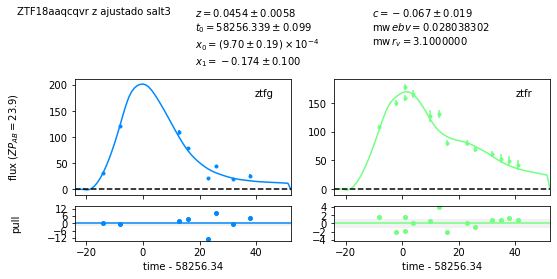

In [362]:
ajuste(lista_oid_SALT3_z_bounded_sobre_mediana_cortes_trest[38], 'salt3', df_meta_early_SNIa_sin_SN15, 
       table_early_SNIa_SALT3_z_bounded_cortes_trest, z_bounds=z_bounds)[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT3_z_bounded_sobre_mediana_cortes_trest[38])

 ==== Con ajuste del redshift ====
chisq/ndof :  30.327267713084012


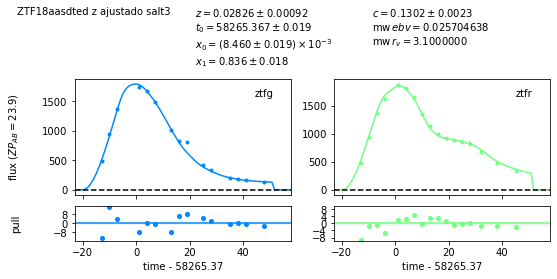

In [363]:
ajuste(lista_oid_SALT3_z_bounded_sobre_mediana_cortes_trest[40], 'salt3', df_meta_early_SNIa_sin_SN15, 
       table_early_SNIa_SALT3_z_bounded_cortes_trest, z_bounds=z_bounds)[0]
print('chisq/ndof : ', lista_chisq_vs_ndof_SALT3_z_bounded_sobre_mediana_cortes_trest[40])

# Comparación de los valores de $\frac{\chi^2}{ndof}$ de todos los ajustes

### Seleccionar las columnas oid y $\frac{\chi^2}{ndof}$ de las estadísticas de cada uno de los ajustes y renombrar las columnas de $\frac{\chi^2}{ndof}$ 

Ajustes con $z$ fijo y con todas las observaciones

In [364]:
SALT2_z_fijo = estadisticas_SALT2_z_fijo[['oid', 'chisq/ndof']]
SALT3_z_fijo = estadisticas_SALT3_z_fijo[['oid', 'chisq/ndof']]

SALT2_z_fijo = SALT2_z_fijo.rename(columns={'chisq/ndof': 'SALT2_z_fijo'})
SALT3_z_fijo = SALT3_z_fijo.rename(columns={'chisq/ndof': 'SALT3_z_fijo'})

Ajustes con $z$ variable y con todas las observaciones

In [365]:
SALT2_z_var = estadisticas_SALT2_z_var[['oid', 'chisq/ndof']]
SALT3_z_var = estadisticas_SALT3_z_var[['oid', 'chisq/ndof']]

SALT2_z_var = SALT2_z_var.rename(columns={'chisq/ndof': 'SALT2_z_var'})
SALT3_z_var = SALT3_z_var.rename(columns={'chisq/ndof': 'SALT3_z_var'})

Ajustes con $z$ fijo y con las observaciones que están en el rango de tiempo del modelo determinado con $t_0$ del primer ajuste y $z_{real}$ (cortes_t)

In [366]:
SALT2_z_fijo_cortes_t = estadisticas_SALT2_z_fijo_cortes_t[['oid', 'chisq/ndof']]
SALT3_z_fijo_cortes_t = estadisticas_SALT3_z_fijo_cortes_t[['oid', 'chisq/ndof']]

SALT2_z_fijo_cortes_t = SALT2_z_fijo_cortes_t.rename(columns={'chisq/ndof': 'SALT2_z_fijo_cortes_t'})
SALT3_z_fijo_cortes_t = SALT3_z_fijo_cortes_t.rename(columns={'chisq/ndof': 'SALT3_z_fijo_cortes_t'})

Ajustes con $z$ variable con las observaciones que están en el rango de tiempo del modelo determinado con $t_0$ y $z$ del primer ajuste (cortes_t)

In [367]:
SALT2_z_var_cortes_t = estadisticas_SALT2_z_var_cortes_t[['oid', 'chisq/ndof']]
SALT3_z_var_cortes_t = estadisticas_SALT3_z_var_cortes_t[['oid', 'chisq/ndof']]

SALT2_z_var_cortes_t = SALT2_z_var_cortes_t.rename(columns={'chisq/ndof': 'SALT2_z_var_cortes_t'})
SALT3_z_var_cortes_t = SALT3_z_var_cortes_t.rename(columns={'chisq/ndof': 'SALT3_z_var_cortes_t'})

Ajustes con $z$ fijo con las observaciones que están en el rango de tiempo del modelo como si estuviese en el sistema de referencia en reposo ($z =0$) determinado con $t_0$ (cortes_trest) (para comparar los resultados)

In [368]:
SALT2_z_fijo_cortes_trest = estadisticas_SALT2_z_fijo_cortes_trest[['oid', 'chisq/ndof']]
SALT3_z_fijo_cortes_trest = estadisticas_SALT3_z_fijo_cortes_trest[['oid', 'chisq/ndof']]

SALT2_z_fijo_cortes_trest = SALT2_z_fijo_cortes_trest.rename(columns={'chisq/ndof': 'SALT2_z_fijo_cortes_trest'})
SALT3_z_fijo_cortes_trest = SALT3_z_fijo_cortes_trest.rename(columns={'chisq/ndof': 'SALT3_z_fijo_cortes_trest'})

Ajustes con $z$ variable con las observaciones que están en el rango de tiempo del modelo como si estuviese en el sistema de referencia en reposo ($z =0$) determinado con $t_0$ (cortes_trest) (para evitar el caso en que las observaciones quedan fuera del rango de tiempo del modelo, ya que esto podría ser una cota inferior del rango de tiempo si $t_0$ está bien determinado)

In [369]:
SALT2_z_var_cortes_trest = estadisticas_SALT2_z_var_cortes_trest[['oid', 'chisq/ndof']]
SALT3_z_var_cortes_trest = estadisticas_SALT3_z_var_cortes_trest[['oid', 'chisq/ndof']]

SALT2_z_var_cortes_trest = SALT2_z_var_cortes_trest.rename(columns={'chisq/ndof': 'SALT2_z_var_cortes_trest'})
SALT3_z_var_cortes_trest = SALT3_z_var_cortes_trest.rename(columns={'chisq/ndof': 'SALT3_z_var_cortes_trest'})

Ajustes con $z$ variable en un rango entre $[0, 0.2]$ y con todas las observaciones

In [370]:
SALT2_z_bounded = estadisticas_SALT2_z_bounded[['oid', 'chisq/ndof']]
SALT3_z_bounded = estadisticas_SALT3_z_bounded[['oid', 'chisq/ndof']]

SALT2_z_bounded = SALT2_z_bounded.rename(columns={'chisq/ndof': 'SALT2_z_bounded'})
SALT3_z_bounded = SALT3_z_bounded.rename(columns={'chisq/ndof': 'SALT3_z_bounded'})

Ajustes con $z$ variable en un rango entre $[0, 0.2]$ con las observaciones que están en el rango de tiempo del modelo determinado con $t_0$ y $z$ del primer ajuste (cortes_t)

In [371]:
SALT2_z_bounded_cortes_t = estadisticas_SALT2_z_bounded_cortes_t[['oid', 'chisq/ndof']]
SALT3_z_bounded_cortes_t = estadisticas_SALT3_z_bounded_cortes_t[['oid', 'chisq/ndof']]

SALT2_z_bounded_cortes_t = SALT2_z_bounded_cortes_t.rename(columns={'chisq/ndof': 'SALT2_z_bounded_cortes_t'})
SALT3_z_bounded_cortes_t = SALT3_z_bounded_cortes_t.rename(columns={'chisq/ndof': 'SALT3_z_bounded_cortes_t'})

Ajustes con $z$ variable en un rango entre $[0, 0.2]$ con las observaciones que están en el rango de tiempo del modelo como si estuviese en el sistema de referencia en reposo ($z =0$) determinado con $t_0$ (cortes_trest)

In [372]:
SALT2_z_bounded_cortes_trest = estadisticas_SALT2_z_bounded_cortes_trest[['oid', 'chisq/ndof']]
SALT3_z_bounded_cortes_trest = estadisticas_SALT3_z_bounded_cortes_trest[['oid', 'chisq/ndof']]

SALT2_z_bounded_cortes_trest = SALT2_z_bounded_cortes_trest.rename(columns={'chisq/ndof': 'SALT2_z_bounded_cortes_trest'})
SALT3_z_bounded_cortes_trest = SALT3_z_bounded_cortes_trest.rename(columns={'chisq/ndof': 'SALT3_z_bounded_cortes_trest'})

### Unir todos las columnas de los valores de $\frac{\chi^2}{ndof}$ de los ajustes de acuerdo al valor del oid

Crear una lista que contiene a todos los Data Frames

In [373]:
dfs = [SALT2_z_fijo, SALT3_z_fijo, SALT2_z_var, SALT3_z_var, SALT2_z_fijo_cortes_t,
       SALT3_z_fijo_cortes_t, SALT2_z_var_cortes_t, SALT3_z_var_cortes_t,
       SALT2_z_fijo_cortes_trest, SALT3_z_fijo_cortes_trest, SALT2_z_var_cortes_trest,
       SALT3_z_var_cortes_trest, SALT2_z_bounded, SALT3_z_bounded, SALT2_z_bounded_cortes_t, 
       SALT3_z_bounded_cortes_t, SALT2_z_bounded_cortes_trest, SALT3_z_bounded_cortes_trest]

Unir todas las columnas de $\frac{\chi^2}{ndof}$ de los ajustes de acuerdo al oid

In [374]:
dfs = [df.set_index('oid') for df in dfs]
df_chisq_vs_ndof_ajustes = dfs[0].join(dfs[1:])

display(df_chisq_vs_ndof_ajustes)

SALT2_z_fijo  SALT3_z_fijo  SALT2_z_var  SALT3_z_var  \
oid                                                                  
ZTF18abptsco      0.308793      0.343113     0.424190     0.493447   
ZTF18abjtger      0.442368      0.491140     0.470233     0.537227   
ZTF18abukmty      0.469940      0.497514     0.650834     0.765654   
ZTF18abqjvyl      0.535810      0.531700     0.570724     0.527829   
ZTF18abxygvv      0.555674      0.758087     0.604918     0.477221   
...                    ...           ...          ...          ...   
ZTF18aaxcntm     57.352522     56.407762    45.442265    50.470849   
ZTF18abuqugw    118.045506    122.983823   119.602447   123.885729   
ZTF18abcflnz    128.387523    129.118930    72.646404    73.878194   
ZTF18aasdted    300.968475    306.140316   304.648354   326.276303   
ZTF18abauprj    305.397762    309.022294   310.249186   313.401111   

              SALT2_z_fijo_cortes_t  SALT3_z_fijo_cortes_t  \
oid                                                          
ZTF18abptsco               0.308793               0.343113   
ZTF18abjtger               0.442368               0.491140   
ZTF18abukmty               0.469940               0.497514   
ZTF18abqjvyl               0.535810               0.531700   
ZTF18abxygvv               0.555674               0.758087   
...                             ...                    ...   
ZTF18aaxcntm               5.970880               4.481067   
ZTF18abuqugw              19.116075              27.758132   
ZTF18abcflnz               1.996004               3.175693   
ZTF18aasdted              20.296988              33.411300   
ZTF18abauprj               4.031864              10.747909   

              SALT2_z_var_cortes_t  SALT3_z_var_cortes_t  \
oid                                                        
ZTF18abptsco              0.424190              0.493447   
ZTF18abjtger              0.470233              0.537227   
ZTF18abukmty              0.650834              0.765654   
ZTF18abqjvyl              0.570724              0.527829   
ZTF18abxygvv              0.604918              0.477221   
...                            ...                   ...   
ZTF18aaxcntm             14.434108             28.588255   
ZTF18abuqugw              3.974160             15.829426   
ZTF18abcflnz             20.874397             44.030238   
ZTF18aasdted            201.212186            243.252604   
ZTF18abauprj              4.014362              9.936158   

              SALT2_z_fijo_cortes_trest  SALT3_z_fijo_cortes_trest  \
oid                                                                  
ZTF18abptsco                   0.308793                   0.343113   
ZTF18abjtger                   0.442368                   0.491140   
ZTF18abukmty                   0.469940                   0.497514   
ZTF18abqjvyl                   0.535810                   0.531700   
ZTF18abxygvv                   0.555674                   0.758087   
...                                 ...                        ...   
ZTF18aaxcntm                   5.970880                   4.481067   
ZTF18abuqugw                  19.116075                  27.758132   
ZTF18abcflnz                   1.996004                   3.175693   
ZTF18aasdted                  20.296988                  33.411300   
ZTF18abauprj                   4.278638                  11.052427   

              SALT2_z_var_cortes_trest  SALT3_z_var_cortes_trest  \
oid                                                                
ZTF18abptsco                  0.424190                  0.493447   
ZTF18abjtger                  0.470233                  0.537227   
ZTF18abukmty                  0.650834                  0.765654   
ZTF18abqjvyl                  0.570724                  0.527829   
ZTF18abxygvv                  0.604918                  0.477221   
...                                ...                       ...   
ZTF18aaxcntm                 16.152312                 32.76

Agregar la columna que contiene el valor mínimo de $\frac{\chi^2}{ndof}$ de los ajustes cada oid

In [375]:
min_chisq_vs_ndof_ajustes = np.array(df_chisq_vs_ndof_ajustes.min(axis=1))
df_chisq_vs_ndof_ajustes['min_chisq/ndof'] = min_chisq_vs_ndof_ajustes

Agregar el nombre de la columna que contiene el valor mínimo de $\frac{\chi^2}{ndof}$ de los ajustes cada oid

In [376]:
columna_min_chisq_vs_ndof_ajustes = np.array(df_chisq_vs_ndof_ajustes.idxmin(axis=1))
df_chisq_vs_ndof_ajustes['columna_min_chisq/ndof'] = columna_min_chisq_vs_ndof_ajustes

Histograma de los valores mínimos de $\frac{\chi^2}{ndof}$

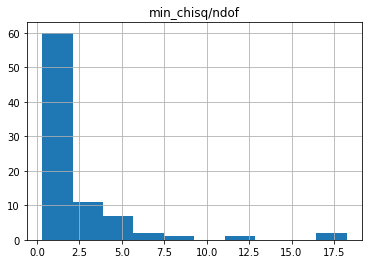

In [377]:
df_chisq_vs_ndof_ajustes.hist(column='min_chisq/ndof');

Contar las frecuencias de las columnas donde se encontró el mínimo valor de $\frac{\chi^2}{ndof}$

In [378]:
contar_columnas_min = df_chisq_vs_ndof_ajustes['columna_min_chisq/ndof'].value_counts()
contar_columnas_min

SALT2_z_fijo                    21
SALT3_z_fijo                    16
SALT2_z_bounded                 14
SALT2_z_var                      6
SALT3_z_var                      6
SALT2_z_fijo_cortes_t            4
SALT3_z_fijo_cortes_t            4
SALT2_z_bounded_cortes_t         3
SALT2_z_var_cortes_trest         3
SALT2_z_bounded_cortes_trest     2
SALT2_z_var_cortes_t             2
SALT3_z_bounded_cortes_t         1
SALT3_z_bounded                  1
SALT3_z_var_cortes_trest         1
Name: columna_min_chisq/ndof, dtype: int64

Gráfico de barras de los ajustes en los que se obtuvo el mínimo valor de $\frac{\chi^2}{ndof}$

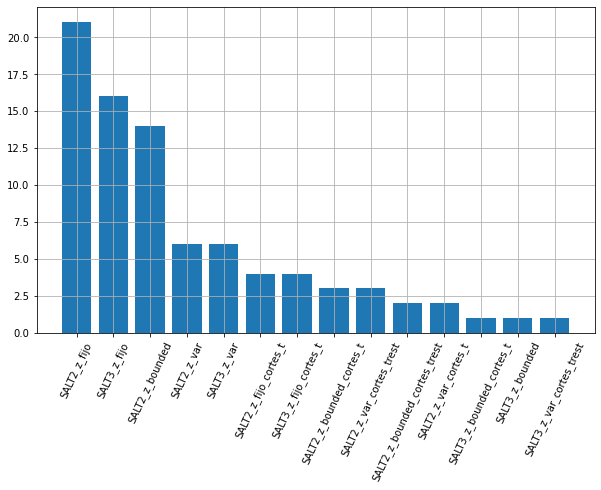

In [379]:
columnas_contadas = contar_columnas_min.index
cantidad_cada_columna = np.array(contar_columnas_min)

plt.figure(figsize=(10, 6))
plt.bar(columnas_contadas, cantidad_cada_columna)
plt.xticks(rotation=65)
plt.grid()

# Comparación de los valores de $\frac{\chi^2}{ndof}$ de todos los ajustes con $z$ variable

Crear una lista que contiene a todos los Data Frames de los ajustes con $z$ variable

In [380]:
dfs_var = [SALT2_z_var, SALT3_z_var, SALT2_z_var_cortes_t, SALT3_z_var_cortes_t,
           SALT2_z_var_cortes_trest, SALT3_z_var_cortes_trest, SALT2_z_bounded, 
           SALT3_z_bounded, SALT2_z_bounded_cortes_t, SALT3_z_bounded_cortes_t, 
           SALT2_z_bounded_cortes_trest, SALT3_z_bounded_cortes_trest]

Unir todas las columnas de $\frac{\chi^2}{ndof}$ de los ajustes de acuerdo al oid

In [381]:
dfs_var = [df_var.set_index('oid') for df_var in dfs_var]
df_chisq_vs_ndof_ajustes_var = dfs_var[0].join(dfs_var[1:])

display(df_chisq_vs_ndof_ajustes_var)

SALT2_z_var  SALT3_z_var  SALT2_z_var_cortes_t  \
oid                                                            
ZTF18abptsco     0.424190     0.493447              0.424190   
ZTF18abjtger     0.470233     0.537227              0.470233   
ZTF18abokpvh     0.555170     0.556936              0.555170   
ZTF18abpmmpo     0.557564     0.546762              0.557564   
ZTF18abqjvyl     0.570724     0.527829              0.570724   
...                   ...          ...                   ...   
ZTF18aaxsioa    47.375581    47.433305             21.527486   
ZTF18abcflnz    72.646404    73.878194             20.874397   
ZTF18abuqugw   119.602447   123.885729              3.974160   
ZTF18aasdted   304.648354   326.276303            201.212186   
ZTF18abauprj   310.249186   313.401111              4.014362   

              SALT3_z_var_cortes_t  SALT2_z_var_cortes_trest  \
oid                                                            
ZTF18abptsco              0.493447                  0.424190   
ZTF18abjtger              0.537227                  0.470233   
ZTF18abokpvh              0.556936                  0.555170   
ZTF18abpmmpo              0.546762                  0.557564   
ZTF18abqjvyl              0.527829                  0.570724   
...                            ...                       ...   
ZTF18aaxsioa             20.968159                 24.238261   
ZTF18abcflnz             44.030238                 14.445752   
ZTF18abuqugw             15.829426                  3.974160   
ZTF18aasdted            243.252604                 16.857810   
ZTF18abauprj              9.936158                  4.231567   

              SALT3_z_var_cortes_trest  SALT2_z_bounded  SALT3_z_bounded  \
oid                                                                        
ZTF18abptsco                  0.493447         0.353720         0.455963   
ZTF18abjtger                  0.537227         0.470233         0.535988   
ZTF18abokpvh                  0.556936         0.555171         0.556936   
ZTF18abpmmpo                  0.546762         0.557564         0.546764   
ZTF18abqjvyl                  0.527829         0.564267         0.527831   
...                                ...              ...              ...   
ZTF18aaxsioa                  2.332523        56.444163        54.281726   
ZTF18abcflnz                  3.546539        84.285780       105.254969   
ZTF18abuqugw                 15.829426       127.111838       130.299396   
ZTF18aasdted                 29.256932       301.968561       307.396467   
ZTF18abauprj                 10.508305       310.249186       313.401111   

              SALT2_z_bounded_cortes_t  SALT3_z_bounded_cortes_t  \
oid                                                                
ZTF18abptsco                  0.353720                  0.455963   
ZTF18abjtger                  0.470233                  0.535988   
ZTF18abokpvh                  0.555171                  0.556936   
ZTF18abpmmpo                  0.557564                  0.546764   
ZTF18abqjvyl                  0.564267                  0.527831   
...                                ...                       ...   
ZTF18aaxsioa                  6.369074                  2.332522   
ZTF18abcflnz                 35.756362                 13.378145   
ZTF18abuqugw                 16.923946                 27.740525   
ZTF18aasdted                 16.857812                 62.989941   
ZTF18abauprj                  4.014362                  9.936158   

              SALT2_z_bounded_cortes_trest  SALT3_z_bounded_cortes_trest  
oid                                                                       
ZTF18abptsco                      0.353720                      0.455963  
ZTF18abjtger                      0.470233                      0.535988  
ZTF18abokpvh                      0.555171                      0.556936  
ZTF18abpmmpo                      0.557564                      0.546764  
ZTF18abqjvyl            

Agregar la columna que contiene el valor mínimo de $\frac{\chi^2}{ndof}$ de los ajustes cada oid

In [382]:
min_chisq_vs_ndof_ajustes_var = np.array(df_chisq_vs_ndof_ajustes_var.min(axis=1))
df_chisq_vs_ndof_ajustes_var['min_chisq/ndof'] = min_chisq_vs_ndof_ajustes_var

Agregar el nombre de la columna que contiene el valor mínimo de $\frac{\chi^2}{ndof}$ de los ajustes cada oid

In [383]:
columna_min_chisq_vs_ndof_ajustes_var = np.array(df_chisq_vs_ndof_ajustes_var.idxmin(axis=1))
df_chisq_vs_ndof_ajustes_var['columna_min_chisq/ndof'] = columna_min_chisq_vs_ndof_ajustes_var

Histograma de los valores mínimos de $\frac{\chi^2}{ndof}$

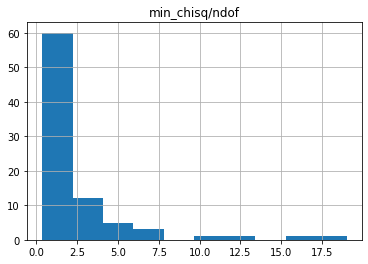

In [384]:
df_chisq_vs_ndof_ajustes_var.hist(column='min_chisq/ndof');

Contar las frecuencias de las columnas donde se encontró el mínimo valor de $\frac{\chi^2}{ndof}$

In [385]:
contar_columnas_min_var = df_chisq_vs_ndof_ajustes_var['columna_min_chisq/ndof'].value_counts()
contar_columnas_min_var

SALT2_z_bounded                 27
SALT3_z_bounded                 14
SALT2_z_var                     13
SALT3_z_var                     10
SALT2_z_bounded_cortes_trest     6
SALT3_z_bounded_cortes_t         4
SALT2_z_bounded_cortes_t         4
SALT2_z_var_cortes_trest         3
SALT2_z_var_cortes_t             2
SALT3_z_var_cortes_trest         1
Name: columna_min_chisq/ndof, dtype: int64

Gráfico de barras de los ajustes con $z$ variable en los que se obtuvo el mínimo valor de $\frac{\chi^2}{ndof}$ 

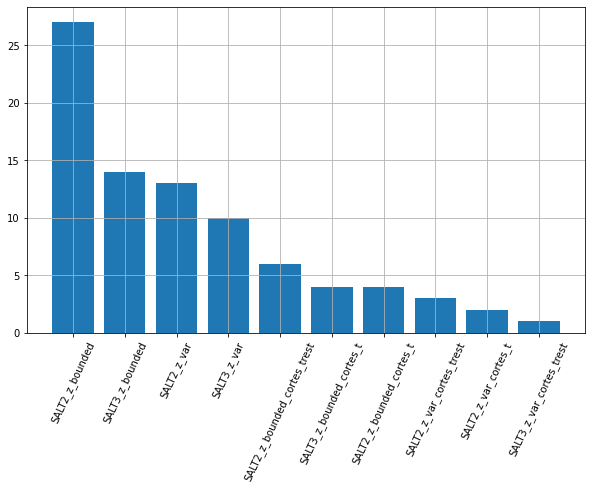

In [386]:
columnas_contadas_var = contar_columnas_min_var.index
cantidad_cada_columna_var = np.array(contar_columnas_min_var)

plt.figure(figsize=(10, 6))
plt.bar(columnas_contadas_var, cantidad_cada_columna_var)
plt.xticks(rotation=65)
plt.grid()